In this notebook I will be evaluating my two models: Inductive Matrix Factorization and IGMC.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from models import MF_inc, IGMC
import tensorflow as tf
import keras
from scipy.sparse import csr_matrix, coo_matrix, lil_matrix, csc_matrix
from graph_extraction import *

from spektral.data import Dataset, DisjointLoader, Graph, BatchLoader
from spektral.data.utils import to_disjoint

In [4]:
users = pd.read_csv('users_for_training_new_mapping.csv',index_col=0)

In [5]:
users.shape

(1534489, 4)

In [6]:
users.head()

,UserID,AnimeID,Score,User_Mapped
0,1,102,7,0
1,1,3229,5,0
2,1,4730,6,0
3,1,589,10,0
4,1,182,7,0


In [7]:
users.UserID.unique()

array([   1,   10, 1000, ..., 9993, 9996, 9998], dtype=int64)

We shuffle the users as we did for training the IGMC algorithm, and select all the users that weren't used for training or validation, ie. mapped users 6000 and on.

In [8]:
users_test = users[users.User_Mapped.isin(shuffle(users.User_Mapped.unique(),random_state=42)[6000:])]

In [9]:
vc = users_test.UserID.value_counts()

In [8]:
users_test['vc'] = users_test.apply(lambda x: vc[x[0]],axis=1)

C:\Users\nickj\AppData\Local\Temp\ipykernel_15328\2813286631.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  users_test['vc'] = users_test.apply(lambda x: vc[x[0]],axis=1)


In [9]:
users_test.head()

,UserID,AnimeID,Score,User_Mapped,vc
232,10000,221,9,3,28
233,10000,1380,6,3,28
234,10000,274,7,3,28
235,10000,61,10,3,28
236,10000,472,9,3,28


The test users are filtered by the number of anime they've watched, since we'll be needing to split them into 'known' and 'unknown' ratings for the testing process, and there need to be a substantial amount in each subset.

In [10]:
users_test = users_test[users_test.vc >= 100]
users_test = users_test.drop('vc',axis=1)

In [11]:
users_test.head()

,UserID,AnimeID,Score,User_Mapped
260,10001,61,10,4
261,10001,1318,6,4
262,10001,4887,6,4
263,10001,2107,6,4
264,10001,1491,6,4


In [12]:
len(users_test.UserID.unique())

988

Now we need to split the test users into data that already 'exists' that can be fed into the algorithm to establish the user's preferences, and 'unseen' data that we are trying to predict as accurately as possible. The cutoff will be set to half the total data if the number of entries for the user is lower than 200, otherwise it will be set to 100.

In [13]:
for user in users_test.User_Mapped.unique():
    userdata = users_test[users_test['User_Mapped'] == user]
    if len(userdata) <= 200:
        cutoff = int(len(userdata)/2)
    else:
        cutoff = 100
    userdata.iloc[:cutoff,:].to_csv('holdout_known/User_'+str(user)+'.csv')
    userdata.iloc[cutoff:,:].to_csv('holdout_unknown/User_'+str(user)+'.csv')
    

As a means of initial comparison, I will implement a simple 'random' model.

In [36]:
def random_model():
    users = 0
    APsum = 0
    for filename in os.listdir('holdout_unknown'):
        users += 1
        f_known = pd.read_csv('holdout_known/' + filename)
        f_unknown = pd.read_csv('holdout_unknown/' + filename)
        f_unknown = f_unknown.sample(frac=1,random_state=42)
        f_unknown = zscore(f_known,f_unknown)
        
        largest = f_unknown.iloc[:5,:]
        
        print(largest)
         # calculate MAP
        rel = 0
        AP = 0
        for i in largest.index:
            rel += relevance(largest.loc[i,'Score'],largest.loc[i,'Zscore'])
            AP += (rel/(i+1))
        AP = AP/len(largest)
            
        APsum += AP
        MAP = APsum/users
        #print(MAP)
    print(MAP)

In [37]:
random_model()

     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30       306166    1277      184      8         1015  0.654252
126      306262    1277     1264      7         1015 -0.267230
220      306356    1277     1341      7         1015 -0.267230
142      306278    1277     1017      6         1015 -1.188712
255      306391    1277     3484      8         1015  0.654252
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19       308421    1289     2629      6         1021 -0.739585
42       308444    1289      389      7         1021 -0.067235
153      308555    1289      899      8         1021  0.605115
78       308480    1289     2041      7         1021 -0.067235
145      308547    1289      554      6         1021 -0.739585
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
218      317100    1326      156      9         1045  1.571781
66       316948    1326     3286      8         1045  0.748859
9        316891    1326     3894      5         1045 -1

10      370577    1621       53      8         1250  0.767042
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
428      371272    1623     1014      8         1252  0.706559
713      371557    1623     3636      7         1252 -0.451735
326      371170    1623     1775      7         1252 -0.451735
766      371610    1623     1158      8         1252  0.706559
361      371205    1623      186      9         1252  1.864853
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
101      373255    1629     3928     10         1254  1.119990
55       373209    1629      177      8         1254 -0.221315
56       373210    1629      298      8         1254 -0.221315
139      373293    1629      719      7         1254 -0.891968
157      373311    1629       16      9         1254  0.449337
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
13      373565    1632      364      8         1256 -0.536875
39      373591    1632      905      6         1256 -2.684

17      402319    1815      458      6         1396 -1.991219
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
78      403975    1832     1451      7         1409 -0.488191
0       403897    1832       58      8         1409  0.808567
68      403965    1832      416      8         1409  0.808567
22      403919    1832       41      8         1409  0.808567
12      403909    1832     2629      8         1409  0.808567
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
100       48084   10226       23     10          143  0.145197
215       48199   10226     3670      1          143 -9.188889
139       48123   10226     3710     10          143  0.145197
178       48162   10226     1381     10          143  0.145197
15        47999   10226      514     10          143  0.145197
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
44      414150    1900      731      7         1460 -0.117396
53      414159    1900     2751      6         1460 -0.855314
30

53      454639     214     2806      6         1645 -1.801665
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
62      459748    2169     2751      9         1664 -0.163599
40      459726    2169     3118      9         1664 -0.163599
93      459779    2169       62     10         1664  0.883437
18      459704    2169      543      9         1664 -0.163599
81      459767    2169     3645      7         1664 -2.257673
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19      460405    2173     5223     10         1668  1.155080
49      460435    2173     1364     10         1668  1.155080
48      460434    2173     3465      9         1668 -0.172033
12      460398    2173      429     10         1668  1.155080
44      460430    2173      785      9         1668 -0.172033
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30       461995     218     4164      6         1673 -1.359349
116      462081     218      375      9         1673  0.742737
79   

0       504801    2422       60      7         1857 -0.255378
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
0       506272     243      458      6         1863 -0.569121
5       506277     243      595      7         1863  0.104532
34      506306     243     1743      5         1863 -1.242775
13      506285     243      943      6         1863 -0.569121
44      506316     243      899      8         1863  0.778186
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
0        60208   10296      602      9          189 -0.180522
5        60213   10296     2839      9          189 -0.180522
34       60242   10296       72     10          189  0.771320
13       60221   10296      128      9          189 -0.180522
45       60253   10296     3655     10          189  0.771320
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
73        60440   10297     2597      6          190 -0.966565
45        60412   10297      575      7          190 -0.111198
60   

97       539188    2605     1631      6         2000 -1.081819
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
46       61821   10313     1964      7          201 -0.457009
16       61791   10313      646      8          201  0.430894
4        61779   10313     3892      6          201 -1.344912
9        61784   10313     3098      5          201 -2.232815
28       61803   10313     1075      8          201  0.430894
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
101       62044   10314     3705      8          202 -0.131274
108       62051   10314     4919      8          202 -0.131274
78        62021   10314      580      9          202  0.559640
56        61999   10314      458      9          202  0.559640
98        62041   10314     2664      7          202 -0.822187
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
80      545462     264      899     10         2026  1.633287
77      545459     264     3645      8         2026 -0.665413
7

155      560493    2719     2038      5         2082 -0.548646
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
0       569542    2771      250      8         2116  0.253462
5       569547    2771       29     10         2116  1.589898
34      569576    2771      689      9         2116  0.921680
13      569555    2771     1895      6         2116 -1.082974
44      569586    2771     4352      7         2116 -0.414756
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
73       571144    2780      727      8         2122  0.300853
18       571089    2780     1191      8         2122  0.300853
117      571188    2780      467      7         2122 -0.584009
78       571149    2780     1604      8         2122  0.300853
76       571147    2780     1028      9         2122  1.185715
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
145      571655    2783     1628      6         2125 -1.076440
334      571844    2783     4519      8         2125  0.16799

81      621283    3063      905      9         2327 -0.347958
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
135      622658    3069     5198      7         2332 -1.660165
115      622638    3069      127      9         2332  1.083910
131      622654    3069     2593      8         2332 -0.288128
55       622578    3069      165      9         2332  1.083910
95       622618    3069     3108      7         2332 -1.660165
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
54      623283    3074      979     10         2336  0.372922
62      623291    3074       22     10         2336  0.372922
0       623229    3074      562     10         2336  0.372922
45      623274    3074      142     10         2336  0.372922
5       623234    3074     2688     10         2336  0.372922
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
40      628728     311     3118      8         2363  0.687043
22      628710     311     1895      7         2363 -0.305352
55

67       661504    3286       12      8         2491  0.505444
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
76      663814    3301       92      9         2504  0.889372
10      663748    3301      129      9         2504  0.889372
4       663742    3301      458      8         2504  0.350359
99      663837    3301      551      4         2504 -1.805695
70      663808    3301     1125      8         2504  0.350359
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30      665191     331     2213      7         2508 -0.826723
0       665161     331     1385      8         2508  0.056625
22      665183     331     1617      9         2508  0.939973
31      665192     331        3     10         2508  1.823321
18      665179     331     2257      7         2508 -0.826723
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
44      665671    3314     2041      8         2511 -0.791641
47      665674    3314     1076      8         2511 -0.791641
4      

12      713768    3621      458      8         2739  0.588845
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
291      715304    3632      495      7         2747  0.482359
365      715378    3632     4056      5         2747 -1.073639
467      715480    3632     1948      6         2747 -0.295640
567      715580    3632     2573      5         2747 -1.073639
118      715131    3632     5249      7         2747  0.482359
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
155      720021    3645       16     10         2756  1.833597
144      720010    3645     3655      5         2756 -1.908438
101      719967    3645     1140      7         2756 -0.411624
127      719993    3645     1429      6         2756 -1.160031
140      720006    3645     1123      7         2756 -0.411624
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
40      723755    3654     4261      7         2762 -1.351007
65      723780    3654     1047      9         2762  0.810

45      760430    3881     4919      7         2931 -1.374585
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
117      760778    3886     2736      8         2933  0.143306
19       760680    3886      646      9         2933  0.825718
82       760743    3886      944      8         2933  0.143306
97       760758    3886     1580      8         2933  0.143306
56       760717    3886     1029      9         2933  0.825718
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
180      761309    3889     3710     10         2935  0.423922
154      761283    3889      596     10         2935  0.423922
111      761240    3889      152     10         2935  0.423922
247      761376    3889      554     10         2935  0.423922
60       761189    3889      551     10         2935  0.423922
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
710      766586    3911     2178      7         2947 -0.568978
440      766316    3911      288      9         2947  1.

10      803209    4173      179      8         3136  0.418485
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
80      804671    4179     3543      6         3140 -1.548126
77      804668    4179     4835      7         3140 -0.651346
73      804664    4179      554      7         3140 -0.651346
94      804685    4179      829      4         3140 -3.341686
33      804624    4179      193      8         3140  0.245435
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
73      804844     418      226     10         3141  1.029493
0       804771     418      308     10         3141  1.029493
58      804829     418      396     10         3141  1.029493
22      804793     418      152      9         3141  0.128687
12      804783     418      154     10         3141  1.029493
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
50      807445    4194      431     10         3152  1.673473
56      807451    4194       98      9         3152  0.392543
0       

90       844392    4382     2025      7         3304 -1.963862
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
54      846138    4395       92      8         3310 -0.828453
62      846146    4395      143      8         3310 -0.828453
0       846084    4395       31      9         3310  0.099986
45      846129    4395      112      7         3310 -1.756891
5       846089    4395       29     10         3310  1.028424
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30      847127    4402     4100      5         3314 -1.657060
0       847097    4402       56      8         3314  0.496232
22      847119    4402      422      7         3314 -0.221532
31      847128    4402     1249      6         3314 -0.939296
18      847115    4402      196      8         3314  0.496232
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
6        849201    4413      176      7         3324 -0.434248
488      849683    4413     3483      6         3324 -1.338932
104 

53      876856    4547      423      7         3432 -0.249571
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
55       877728    4552      123      8         3436  0.260322
40       877713    4552      746      5         3436 -0.999301
19       877692    4552      792      3         3436 -1.839050
31       877704    4552      531      7         3436 -0.159552
114      877787    4552     2651      4         3436 -1.419176
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19      878337    4556      298      9         3440  1.521982
49      878367    4556       68      4         3440 -3.061259
48      878366    4556      473      6         3440 -1.227963
12      878330    4556      168      7         3440 -0.311314
44      878362    4556       16      7         3440 -0.311314
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30      878866    4560     1717      8         3444  0.678293
65      878901    4560     4336      7         3444 -0.067084
64

44      943294    4977      899      7         3746  0.260479
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30      117278   10571     3444      6          375 -1.861046
0       117248   10571      997      7          375 -1.120331
22      117270   10571     3840      6          375 -1.861046
31      117279   10571     3270      7          375 -1.120331
18      117266   10571     2041      7          375 -1.120331
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19       944845     499      914      7         3756  0.123328
42       944868     499      220      7         3756  0.123328
156      944982     499      296      5         3756 -1.327586
111      944937     499     3159      7         3756  0.123328
148      944974     499     3720      6         3756 -0.602129
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
159      946701    4998     1151      6         3763 -1.211091
264      946806    4998     4251      7         3763 -0.352161

55      988340    5259      785      9         3962  0.930436
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
336      991866    5283       92     10         3981  2.504683
307      991837    5283     3028      7         3981  0.032956
90       991620    5283     1576      7         3981  0.032956
265      991795    5283     2071      8         3981  0.856865
150      991680    5283      779      7         3981  0.032956
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
50      993100     529     4411      8         3987 -0.105354
56      993106     529     2313      1         3987 -5.103821
0       993050     529     3091      9         3987  0.608713
57      993107     529      784      7         3987 -0.819421
5       993055     529     1007      9         3987  0.608713
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
115      993757    5293      179      8         3991  0.322034
15       993657    5293       59     10         3991  1.819865

5      1037120    5514     3919      6         4164 -1.408855
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30       130104   10630       85      9          417  1.047394
116      130190   10630      224      9          417  1.047394
79       130153   10630     1191      9          417  1.047394
127      130201   10630     3089      9          417  1.047394
196      130270   10630      163      9          417  1.047394
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19     1038149    5521     1719      8         4171  0.293117
41     1038171    5521      899      7         4171 -0.603476
47     1038177    5521       76      8         4171  0.293117
12     1038142    5521     2958      7         4171 -0.603476
43     1038173    5521       55      8         4171  0.293117
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
0      1039493    5532      189      7         4175 -0.854850
5      1039498    5532      308      9         4175  0.854850
34

12     1100144    5889      198      9         4451  0.803847
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19      1100643    5894     3772     10         4455  0.475864
42      1100666    5894      551     10         4455  0.475864
155     1100779    5894     3645      9         4455 -1.687153
111     1100735    5894     1885     10         4455  0.475864
147     1100771    5894      416     10         4455  0.475864
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
75     1105140    5911     2373     10         4469  0.874425
0      1105065    5911      469      7         4469 -0.881310
70     1105135    5911     3102      8         4469 -0.296065
22     1105087    5911      196      8         4469 -0.296065
12     1105077    5911     3101      5         4469 -2.051800
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
322     1106134    5916      657      5         4474 -1.570998
116     1105928    5916       56      9         4474  1.080476

19     1137579    6126      531      9         4627  0.613056
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
215     1138622    6132      623      8         4632  0.260562
66      1138473    6132     1678      8         4632  0.260562
9       1138416    6132       51      9         4632  0.928670
200     1138607    6132     3196      7         4632 -0.407546
15      1138422    6132      157     10         4632  1.596778
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19     1139453    6139      298      8         4636 -0.116153
41     1139475    6139      431      8         4636 -0.116153
47     1139481    6139     2333      6         4636 -2.090763
12     1139446    6139       41      9         4636  0.871151
43     1139477    6139      432      7         4636 -1.103458
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
73     1140908    6140     1364      7         4637 -1.776998
0      1140835    6140     1934      9         4637  0.226597
58

15      1171601    6307      139      8         4754  0.486065
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
46     1172302    6311      397     10         4757  1.340118
16     1172272    6311     1425      7         4757 -0.867781
4      1172260    6311       42     10         4757  1.340118
9      1172265    6311     3450      9         4757  0.604151
28     1172284    6311     1340      9         4757  0.604151
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
53     1172498    6314     5096      9         4759  0.860009
60     1172505    6314     1096      7         4759 -0.808665
0      1172445    6314      108      8         4759  0.025672
45     1172490    6314      912      8         4759  0.025672
5      1172450    6314     2629      9         4759  0.860009
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
73       153404   10719      366     10          477  1.866038
414      153745   10719     2443      8          477  0.080356
394 

      Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
363      1221396    6594     4865      7         4973 -0.409072
1265     1222298    6594     2990      7         4973 -0.409072
1219     1222252    6594     2878      8         4973  0.564909
979      1222012    6594     4624      6         4973 -1.383053
478      1221511    6594      787      8         4973  0.564909
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
4      1223013      66       31     10         4978  1.471781
63     1223072      66     3153      4         4978 -2.973599
18     1223027      66      458      6         4978 -1.491806
0      1223009      66      140      7         4978 -0.750909
28     1223037      66       19     10         4978  1.471781
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30      159903   10757      451      9          499  0.451912
0       159873   10757      683      9          499  0.451912
22      159895   10757     4102      8          499 -0.475

256     1254704    6815       92     10         5142  0.892942
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
66      1258039    6842      779      8         5161 -0.579444
45      1258018    6842     4236      7         5161 -1.457389
9       1257982    6842      641      9         5161  0.298501
73      1258046    6842      458      9         5161  0.298501
136     1258109    6842     3393      8         5161 -0.579444
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
18     1259887    6859      644      9         5172  0.835528
42     1259911    6859      429      9         5172  0.835528
36     1259905    6859      595      5         5172 -2.540343
76     1259945    6859     4919      7         5172 -0.852407
53     1259922    6859     3765      6         5172 -1.696375
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
0      1260050    6860      383      8         5173  0.068979
5      1260055    6860      154      7         5173 -0.717383
3

54     1285384    7015     5096      8         5287  0.567166
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
40     1287243    7023      498      6         5293 -1.148479
22     1287225    7023       53      9         5293  1.165245
55     1287258    7023      432      5         5293 -1.919721
72     1287275    7023     2150      4         5293 -2.690962
0      1287203    7023     4098      7         5293 -0.377238
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
33     1287876    7029     3042      8         5297 -1.351962
0      1287843    7029      846      9         5297 -0.050699
34     1287877    7029     1721      8         5297 -1.351962
12     1287855    7029      646     10         5297  1.250565
10     1287853    7029       40      9         5297 -0.050699
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
140     1288161     703      398      8         5298  0.240927
113     1288134     703      484      8         5298  0.240927
16   

    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
33     1329417    7247     3450      7         5463 -0.510381
0      1329384    7247      413      9         5463  1.317496
34     1329418    7247       70      9         5463  1.317496
12     1329396    7247     2462      7         5463 -0.510381
10     1329394    7247     5162      6         5463 -1.424320
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
13     1330010    7252      469      7         5467 -1.279051
39     1330036    7252       92      8         5467 -0.230649
30     1330027    7252      269      8         5467 -0.230649
45     1330042    7252      431      9         5467  0.817754
17     1330014    7252       29      8         5467 -0.230649
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
563     1330710    7253     1930      9         5468  0.480216
289     1330436    7253     4257      8         5468 -0.563732
76      1330223    7253     5030      7         5468 -1.607681
78  

13     1360297     743      747      8         5596 -0.867511
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
139     1363277     745     1808      7         5611 -1.441311
113     1363251     745      142     10         5611  1.261147
16      1363154     745     1546      8         5611 -0.540492
75      1363213     745      269     10         5611  1.261147
154     1363292     745       22     10         5611  1.261147
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
76     1364660    7456     3356      6         5615 -1.341750
0      1364584    7456      413      6         5615 -1.341750
26     1364610    7456      110      9         5615  0.541028
22     1364606    7456      429      9         5615  0.541028
12     1364596    7456      633     10         5615  1.168621
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
40     1364802    7457      255     10         5616  1.537830
22     1364784    7457     5188      5         5616 -1.558244
55

154      186934   10898      554      9          580  1.008031
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
52     1401524      77     1123      7         5800  0.000000
58     1401530      77       43      8         5800  0.778312
0      1401472      77      469      6         5800 -0.778312
44     1401516      77     4919      7         5800  0.000000
5      1401477      77      442      6         5800 -0.778312
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
54     1402794    7715     1123      7         5811 -1.100504
62     1402802    7715     5079      9         5811  0.665737
0      1402740    7715     1628      7         5811 -1.100504
45     1402785    7715     4919      7         5811 -1.100504
5      1402745    7715      154     10         5811  1.548858
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
190     1411423    7766      796      6         5851 -1.027948
6       1411239    7766      969      7         5851 -0.266505
79  

10      193386   10929      267      7          600 -0.460400
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
86      1445878    7993     1572      7         6015 -0.647682
353     1446145    7993     2115      8         6015  0.215894
570     1446362    7993      687      8         6015  0.215894
212     1446004    7993     4313      7         6015 -0.647682
626     1446418    7993     1394      5         6015 -2.374833
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
33      1446994    7998     1042      7         6019  0.075600
6       1446967    7998      975      7         6019  0.075600
181     1447142    7998     4271      5         6019 -0.869397
86      1447047    7998      505      7         6019  0.075600
155     1447116    7998     1263      7         6019  0.075600
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30     1448522    8003     1014      7         6024 -0.663058
67     1448559    8003     4265      8         6024  0.423

5      1504976    8359      846      9         6294  1.318755
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
181     1505517    8362     4519      8         6297  0.095577
119     1505455    8362      130      9         6297  1.290288
139     1505475    8362     2747      8         6297  0.095577
216     1505552    8362     2400      7         6297 -1.099135
45      1505381    8362     5181      5         6297 -3.488558
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
40     1506508    8368      181     10         6303  1.334028
22     1506490    8368      110     10         6303  1.334028
55     1506523    8368      291      7         6303 -0.602464
70     1506538    8368      720      8         6303  0.043033
0      1506468    8368      902      8         6303  0.043033
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
68     1508202    8378       51      5         6313 -0.898230
22     1508156    8378     2005      5         6313 -0.898230
72

18     1563176    8678     1719     10         6541  0.989987
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19     1563790    8684      825      8         6545 -0.519472
49     1563820    8684      829      8         6545 -0.519472
48     1563819    8684     1373      8         6545 -0.519472
12     1563783    8684      337     10         6545  0.956922
44     1563815    8684     2400      6         6545 -1.995867
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
24      1563949    8687     5248      7         6546 -0.522732
6       1563931    8687     1572      7         6546 -0.522732
153     1564078    8687      943      8         6546  0.544068
211     1564136    8687      424      8         6546  0.544068
198     1564123    8687      503      8         6546  0.544068
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
4      1564245    8688     2219      8         6547  0.166118
63     1564304    8688     2871      7         6547 -1.542529
18

15      1605869    8947      108      7         6748  0.169498
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
0       209599   11050      779      8          675  1.102437
5       209604   11050      375      5          675 -1.052889
34      209633   11050     2503      3          675 -2.489774
13      209612   11050     1309      7          675  0.383995
44      209643   11050      158      9          675  1.820879
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
0      1608858    8969      413      8         6763  0.051857
5      1608863    8969     4728      6         6763 -2.022424
36     1608894    8969     4919      7         6763 -0.985284
45     1608903    8969      215      9         6763  1.088998
13     1608871    8969      196      9         6763  1.088998
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19     1612000    8985      929      7         6777 -0.334795
41     1612022    8985     1451      7         6777 -0.334795
47     

104     1671240    9321     1125      7         7036 -0.607581
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
126     1671564    9323      719      8         7038  0.250341
45      1671483    9323     2840      7         7038 -0.531975
133     1671571    9323      899      7         7038 -0.531975
138     1671576    9323     1313      7         7038 -0.531975
111     1671549    9323     2673      9         7038  1.032657
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
268     1672397    9327     1524      6         7039 -0.820342
250     1672379    9327     3457      5         7039 -1.914131
355     1672484    9327     1168      7         7039  0.273447
332     1672461    9327     1415      8         7039  1.367236
56      1672185    9327      138      8         7039  1.367236
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
54     1672632    9329     1900      5         7040 -1.102546
62     1672640    9329     4103      5         7040 -1.10

10     1724907    9582      288      8         7190 -0.113553
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
627     1732364    9608     4543      5         7208 -1.486573
271     1732008    9608      543      7         7208 -0.007396
290     1732027    9608     2115      6         7208 -0.746985
63      1731800    9608      952      7         7208 -0.007396
302     1732039    9608      197      9         7208  1.471782
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
19      1733514    9619      570      5         7215 -1.310508
42      1733537    9619       29      7         7215  0.287672
153     1733648    9619     3543      5         7215 -1.310508
78      1733573    9619     4708      5         7215 -1.310508
145     1733640    9619     1248      7         7215  0.287672
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
56     1734506    9621     1076      6         7218 -0.888624
89     1734539    9621      434      8         7218  0.408

5      1794995    9962     2839      5         7433 -2.242843
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
30     1797593    9973      652      8         7441  0.414214
0      1797563    9973      250      8         7441  0.414214
22     1797585    9973      429      9         7441  1.518785
31     1797594    9973      100      7         7441 -0.690357
18     1797581    9973     1678      6         7441 -1.794928
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
96      1798127    9975     2871      8         7443 -0.457565
69      1798100    9975     3846      8         7443 -0.457565
82      1798113    9975      234     10         7443  1.336808
76      1798107    9975     3026      8         7443 -0.457565
114     1798145    9975      433     10         7443  1.336808
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
62     1799290    9980      679      8         7447  0.574397
40     1799268    9980      918      8         7447  0.574397
95

    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
4       281254   11407      161      8          899  0.036755
35      281285   11407      580     10          899  1.433436
10      281260   11407     1628      7          899 -0.661586
0       281250   11407      250      7          899 -0.661586
45      281295   11407     1723      9          899  0.735095
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
0       281498    1141      413      9          901  0.574016
5       281503    1141      122      9          901  0.574016
36      281534    1141      687      9          901  0.574016
45      281543    1141      631      8          901 -0.502264
13      281511    1141      458      8          901 -0.502264
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore
220      285400     115     5100      6          918 -0.420042
42       285222     115      228      9          918  1.680170
286      285466     115      314      6          918 -0.420042
181 

MAP: 0.1084382679466956

The function below determines whether an anime is 'relevant' to a particular user, relevance being determined by a score above 9 or a standardized score above 0.5.

In [21]:
def relevance(score,zscore):
    if score >= 9:
        return 1
    elif zscore >= 0.5:
        return 1
    else:
        return 0

The function below calculates the standardized score for unknown data from the mean and standard deviation of the known data.

In [11]:
def zscore(known,unknown):
    zmean = known['Score'].mean()
    zstd = known['Score'].std()
    unknown['Zscore'] = (unknown['Score'] - zmean)/zstd
    return unknown

Now, it's time to evaluate my primary models: Matrix Factorization and IGMC.

First, evaluate Matrix Factorization using one-sided least squares.

The code below is necessary in order to reload the saved model weights for the final Matrix Factorization model. There may be a more succinct way to achieve this, but this format serves the purpose.

In [21]:
df = pd.read_csv('users_for_training_new_mapping.csv',index_col=0)
anime = pd.read_csv('anime_REINDEXED.csv',index_col=0)
data = df[df.User_Mapped.isin(shuffle(df.User_Mapped.unique(),random_state=42)[:6000])]

user_mapping = {v: k-1 for k, v in enumerate(data['UserID'].unique(), 1)}
data['User_Mapped_MF'] = data.UserID.replace(user_mapping)
data = data.sample(frac=1,random_state=42)

train_data = data.iloc[:int(len(data)*0.9),:]
val_data = data.iloc[int(len(data)*0.9):,:]

N = len(data['User_Mapped_MF'].unique())
M = anime.shape[0]
mu = train_data.Score.mean()
model_reg = [0,0]

mf = MF_inc(20,N,M,model_reg,mu)
mf.create_model()
mf.model.load_weights('checkpoints/model_mf.h5')

C:\Users\nickj\AppData\Local\Temp\ipykernel_11236\3688267544.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['User_Mapped_MF'] = data.UserID.replace(user_mapping)


The function below evaluates the Matrix Factorization update method. It calculates both the squared error and MAP for the unknown data. The Final RMSE is calculated by dividing the squared error by the count and taking the square root.

In [40]:
def evaluate_MF():
    count = 0
    sqerror = 0
    users = 0
    APsum = 0
    MAP = 0
    for f in os.listdir('holdout_known'):
        users += 1
        known = pd.read_csv('holdout_known/' + f)
        unknown = pd.read_csv('holdout_unknown/' + f)
        zmean = known['Score'].mean()
        zstd = known['Score'].std()
        unknown['Zscore'] = (unknown['Score'] - zmean)/zstd
        known_data = [(known.loc[i,'AnimeID'],known.loc[i,'Score']) for i in known.index]
        unknown_data = [(unknown.loc[i,'AnimeID'],unknown.loc[i,'Score']) for i in unknown.index]
        recs = mf.update(data=known_data,reg=1)
        unknown['Prediction'] = unknown['AnimeID'].apply(lambda x: recs[x][0])
        print(unknown['Prediction'])
        largest = unknown.nlargest(5,'Prediction')
        
        print(largest)
        # calculate mse
        for d in unknown_data:
            try:
                sqerror += (min(recs[d[0]],10)-d[1])**2
                count += 1
            except:
                continue

        # calculate MAP
        rel = 0
        AP = 0
        for i in range(len(largest.index)):
            rel += relevance(largest.loc[largest.index[i],'Score'],largest.loc[largest.index[i],'Zscore'])
            AP += (rel/(i+1))
        AP = AP/len(largest)

        APsum += AP
        MAP = APsum/users

        print(sqerror)
        print(count)
        print(MAP)

In [41]:
evaluate_MF()

0      9.535064
1      6.631810
2      7.080925
3      6.536946
4      7.531885
         ...   
272    7.685779
273    5.908032
274    7.781486
275    6.816677
276    5.673657
Name: Prediction, Length: 277, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
13       306149    1277        1      9         1015  1.575735    9.781234
0        306136    1277       85      9         1015  1.575735    9.535064
52       306188    1277        0      9         1015  1.575735    9.087213
101      306237    1277       41      9         1015  1.575735    9.054900
105      306241    1277      531      6         1015 -1.188712    8.886418
[290.30148713]
277
0.96
0      10.702581
1       6.218203
2       7.291957
3       4.309508
4       7.522393
         ...    
175     6.567867
176     6.237764
177     6.339549
178     4.434083
179     6.105588
Name: Prediction, Length: 180, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predict

0     7.993919
1     8.421363
2     8.347852
3     8.027715
4     8.285622
5     7.487844
6     6.159192
7     7.156446
8     7.891168
9     6.598736
10    5.979975
11    7.811957
12    7.985584
13    7.825512
14    8.510103
15    6.570301
16    7.539844
17    6.753295
18    7.863414
19    9.297924
20    8.863475
21    7.892138
22    8.133700
23    7.282585
24    7.924919
25    6.000468
26    7.722336
27    7.565082
28    7.237724
29    8.338752
30    7.806110
31    7.546382
32    7.699459
33    7.199010
34    8.636218
35    8.143252
36    7.987241
37    8.148113
38    7.954076
39    8.580160
40    9.023423
41    6.609402
42    7.047991
43    6.261280
44    8.066476
45    8.851172
46    8.098724
47    8.128779
48    7.268610
49    8.055576
50    9.176088
51    7.227382
52    6.493127
53    7.279610
54    8.283800
55    7.232252
56    7.441267
57    8.560259
Name: Prediction, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
19      346210    1481 

0     8.395640
1     7.968861
2     7.930150
3     6.943948
4     7.204700
        ...   
83    8.801125
84    7.251150
85    7.999048
86    7.918970
87    6.915088
Name: Prediction, Length: 88, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
65      357758    1537      431      9         1191  0.659933   10.106390
26      357719    1537      429      8         1191 -0.233515    9.192412
51      357744    1537      105     10         1191  1.553380    8.897320
71      357764    1537       43      9         1191  0.659933    8.838090
24      357717    1537      274     10         1191  1.553380    8.808279
[6665.04709278]
4723
0.6943478260869566
0     6.203337
1     7.200369
2     7.293573
3     8.990697
4     8.893721
        ...   
67    8.063263
68    8.921355
69    6.313688
70    9.042677
71    9.704854
Name: Prediction, Length: 72, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
65      360751    1553

0      8.499248
1      7.915393
2      9.243642
3      7.994645
4      8.215251
         ...   
164    9.523694
165    8.613244
166    9.371244
167    7.976360
168    8.466815
Name: Prediction, Length: 169, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
64       42460   10205      429      9          127  0.606196   10.470699
63       42459   10205      294     10          127  1.583932   10.148310
29       42425   10205      250      9          127  0.606196   10.100644
27       42423   10205      413      9          127  0.606196   10.085055
98       42494   10205        3     10          127  1.583932    9.956623
[8964.3554607]
7119
0.698627450980392
0      8.872956
1     10.373780
2      6.129127
3      9.107364
4      9.792124
5     10.449189
6     10.444852
7      9.859219
8      8.846274
9      8.119413
10     8.241529
11     7.520453
12     8.066888
13     7.557229
14    10.860212
15     6.647937
16     6.101077
17     5.890323
18     8

0      6.586200
1      7.640810
2      7.688455
3      6.236554
4      6.628716
         ...   
173    6.725159
174    6.833509
175    7.289847
176    6.490874
177    6.832457
Name: Prediction, Length: 178, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
154      390789    1748       22      8         1342  0.655993    9.116855
55       390690    1748      196      9         1342  1.697251    9.020134
56       390691    1748       89      8         1342  0.655993    8.719313
137      390772    1748       43      9         1342  1.697251    8.379365
7        390642    1748      675      7         1342 -0.385266    8.360495
[11434.44594828]
8026
0.7188636363636364
0      9.542806
1     12.501785
2     12.318507
3     12.179319
4      8.623308
5      7.522554
6      9.100619
7      8.464871
8      7.547493
9      7.151889
10     8.644719
11     8.905643
12    10.644598
13     8.166148
14     7.999445
15     8.385435
16     9.209342
17    10.735389

0      9.072197
1      6.758811
2      8.457183
3      8.276843
4      7.511105
5      8.048233
6      9.576780
7      8.545088
8      8.760306
9      8.738705
10     8.812544
11     7.948380
12     8.034389
13    10.090261
14    10.093191
15     6.825481
16     6.521052
17     6.675727
18     6.566386
19     8.525912
20     8.696392
21     7.463812
22     7.562051
23     6.583765
24     8.502570
25     8.486690
26     9.802810
27     9.525663
28     8.712413
29     8.754410
30     9.323373
31     9.087489
32     6.441277
33     9.022468
34     7.985688
35     7.463331
36     9.319198
37     5.493882
38     7.578475
39     9.402958
40     4.749289
41     9.177178
42     7.513399
43     8.981093
44     9.025020
45     8.192031
46     7.980734
47     9.383997
48     9.870170
49     9.313452
Name: Prediction, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
14      402316    1815       23      7         1396 -1.201053   10.093191
13      402315    1

0      6.908067
1      7.463623
2      7.763870
3      7.585598
4      7.145429
5      6.426417
6      7.275036
7      7.975067
8      8.211690
9      8.458532
10     7.412727
11     5.055764
12     5.754681
13     6.250639
14     5.799259
15     5.544770
16     7.706538
17     7.381868
18     5.243466
19     5.691363
20     7.795065
21     7.501081
22     7.095326
23     8.208276
24     8.443813
25     7.630917
26     6.927698
27     7.461810
28     7.559712
29     7.047534
30     7.467695
31     7.845202
32     7.862162
33     7.077002
34     7.362961
35     7.755469
36     8.365167
37     7.685698
38     7.606142
39     6.282845
40     5.660707
41     7.697179
42     7.098935
43     7.428906
44     8.026063
45     8.620074
46     6.390337
47     8.286993
48     7.041267
49     8.099946
50     7.934653
51     7.032391
52     7.177101
53     8.554668
54     7.334293
55     8.201720
56     6.848490
57     9.329042
58    10.507375
Name: Prediction, dtype: float64
    Unnamed: 0  UserID 

0     7.511779
1     7.870879
2     5.519281
3     6.379053
4     6.696823
5     8.168525
6     5.689022
7     7.475990
8     5.917388
9     5.293122
10    4.793464
11    6.515631
12    7.012664
13    6.403221
14    6.522985
15    7.124719
16    7.688076
17    7.388920
18    8.819952
19    8.354155
20    8.641184
21    7.326496
22    7.271685
23    6.954828
24    8.456362
25    8.621767
26    9.098172
27    6.572886
28    7.497243
29    7.822787
30    7.401927
31    8.755566
32    8.000434
33    4.893691
34    7.302421
35    5.611259
36    7.089299
37    7.541160
38    8.203264
39    7.947128
40    7.496058
41    8.299719
42    5.486379
43    6.449962
44    7.754592
45    7.591612
46    5.861103
47    8.437598
48    7.795312
49    8.288408
50    8.118818
51    8.079524
52    7.124253
53    7.834823
54    6.681967
55    9.102162
56    7.160481
Name: Prediction, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
55      450236    2116       62     10

0     11.765025
1      9.506193
2      9.153930
3      7.984184
4      8.956801
        ...    
79    10.190959
80     8.303238
81     8.396571
82     8.407044
83     6.603717
Name: Prediction, Length: 84, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
59      463783    2194     1719     10         1685  0.821463   11.768727
0       463724    2194      675      9         1685 -0.030805   11.765025
62      463786    2194      943      7         1685 -1.735341   11.222634
61      463785    2194      657      8         1685 -0.883073   10.822586
37      463761    2194     1795      8         1685 -0.883073   10.281731
[23623.80365251]
14481
0.7277906976744188
0      7.886256
1      8.976091
2      9.499780
3      8.199388
4      7.842185
         ...   
194    5.346657
195    7.989151
196    6.128090
197    5.962788
198    9.277822
Name: Prediction, Length: 199, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predict

0     10.514241
1     10.192556
2     10.104306
3     10.304362
4      9.672960
        ...    
73     7.297404
74     8.386133
75     8.730540
76     8.973063
77     9.124059
Name: Prediction, Length: 78, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
58      496239    2367     3543      7         1816 -1.447340   10.534199
0       496181    2367      413     10         1816  0.954628   10.514241
36      496217    2367     2751      8         1816 -0.646684   10.370022
3       496184    2367      250     10         1816  0.954628   10.304362
1       496182    2367      791     10         1816  0.954628   10.192556
[27223.86808105]
16298
0.723090277777778
0     10.253673
1     10.487255
2     10.772520
3      9.952423
4     10.785411
5     10.379635
6     10.101580
7      7.910627
8      8.688268
9     10.663799
10    10.154841
11    10.126949
12     8.729297
13     9.796586
14     9.206396
15    10.076333
16     9.831717
17     8.563856
18    

0     8.444934
1     8.573125
2     8.634790
3     8.512061
4     7.611376
        ...   
57    7.450699
58    7.465700
59    8.004469
60    8.535474
61    8.517154
Name: Prediction, Length: 62, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
54      503177    2412       55      8         1848  0.225558    9.554415
38      503161    2412     2751      6         1848 -2.067611    8.749720
24      503147    2412      123      8         1848  0.225558    8.670301
2       503125    2412       31      8         1848  0.225558    8.634790
35      503158    2412       26      8         1848  0.225558    8.590447
[29178.0440123]
18302
0.706888888888889
0      7.533464
1      6.337458
2      6.067079
3      5.572630
4      7.382631
         ...   
467    7.301418
468    7.058871
469    7.725133
470    7.589271
471    6.006739
Name: Prediction, Length: 472, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
435      

0      5.567895
1      5.344912
2      6.495948
3      5.352370
4      5.702009
         ...   
448    5.905797
449    5.728301
450    5.478236
451    5.434467
452    7.007005
Name: Prediction, Length: 453, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
119      518048    2514     2162      6         1930  0.272064   11.172450
122      518051    2514     1656      4         1930 -1.088255   10.874178
120      518049    2514     1853      4         1930 -1.088255   10.398050
36       517965    2514     4963      5         1930 -0.408096    9.490142
221      518150    2514      179      8         1930  1.632383    9.443152
[32066.38953313]
20026
0.6954782608695655
0      7.489737
1      6.975230
2      7.706591
3      7.626183
4      7.663772
         ...   
208    6.706780
209    7.426348
210    8.366365
211    7.930494
212    6.344713
Name: Prediction, Length: 213, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  

0      8.271157
1      8.440941
2      7.635597
3      8.744187
4      8.072362
         ...   
110    8.305703
111    8.086556
112    8.858204
113    8.184256
114    7.733588
Name: Prediction, Length: 115, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
36       537759    2599       70     10         1994  2.090414    9.537773
103      537826    2599       16     10         1994  2.090414    9.251667
37       537760    2599      255     10         1994  2.090414    9.197092
47       537770    2599      134      9         1994  0.922585    9.131730
7        537730    2599       35      9         1994  0.922585    9.058296
[36369.11231873]
22991
0.690767195767196
0     7.525451
1     7.361679
2     7.430958
3     7.771424
4     7.949236
        ...   
56    6.414061
57    5.705457
58    6.542246
59    6.406981
60    8.071167
Name: Prediction, Length: 61, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
23 

0      9.107909
1      8.875440
2      8.930908
3      8.139764
4      7.670249
        ...    
81     7.359457
82     8.035643
83     8.255738
84     7.307528
85    10.123829
Name: Prediction, Length: 86, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
85      548875    2659     2751      5         2041 -2.485400   10.123829
23      548813    2659      196      8         2041  0.278536    9.825727
24      548814    2659       89      7         2041 -0.642776    9.794931
30      548820    2659      110      9         2041  1.199848    9.470631
31      548821    2659     1719      8         2041  0.278536    9.303850
[39273.16198351]
24939
0.68524154589372
0      6.280519
1      8.665714
2      8.433639
3      8.173745
4      7.493607
         ...   
315    7.118481
316    7.420233
317    8.862111
318    8.786135
319    7.355666
Name: Prediction, Length: 320, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predictio

0      9.175652
1      8.908957
2      9.491565
3      9.488321
4      9.350025
         ...   
108    6.765940
109    8.823631
110    7.927599
111    7.642925
112    7.944377
Name: Prediction, Length: 113, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
56      555374    2701       53     10         2065  1.148971    9.914208
76      555394    2701        3      9         2065  0.388063    9.518279
2       555320    2701      364     10         2065  1.148971    9.491565
3       555321    2701      458     10         2065  1.148971    9.488321
27      555345    2701      110     10         2065  1.148971    9.374623
[40800.87620303]
26397
0.6920861678004537
0       6.806827
1       6.952147
2       5.844754
3       5.791572
4       6.911711
          ...   
1243    6.437986
1244    5.730688
1245    6.344236
1246    5.964605
1247    6.494353
Name: Prediction, Length: 1248, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zs

0      7.416121
1      8.710545
2      8.175958
3      9.456760
4      8.874469
         ...   
388    7.396336
389    7.608251
390    7.311523
391    8.735431
392    7.703980
Name: Prediction, Length: 393, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
348      577344    2821       22      9         2150  0.930261   10.899587
78       577074    2821       87     10         2150  1.674469   10.414644
191      577187    2821      943     10         2150  1.674469   10.324224
192      577188    2821      652      9         2150  0.930261   10.201282
277      577273    2821      434      8         2150  0.186052    9.960800
[47727.71829946]
30020
0.6878059071729957
0      9.721655
1      8.494399
2      7.809855
3      8.896237
4     10.165635
        ...    
75     7.160036
76     6.831902
77     7.637617
78     7.868944
79     7.726001
Name: Prediction, Length: 80, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Pr

0      7.368715
1      7.941146
2      7.464446
3      7.544377
4      7.721226
         ...   
262    8.136491
263    7.682594
264    7.027008
265    8.244591
266    8.209618
Name: Prediction, Length: 267, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
14       598065    2949      238      9         2237  1.563884    9.497409
66       598117    2949      305      9         2237  1.563884    9.432644
158      598209    2949      110      7         2237 -0.958509    9.415350
15       598066    2949      346     10         2237  2.825080    9.310668
12       598063    2949      284      9         2237  1.563884    9.258129
[49694.68448463]
31436
0.6919526627218935
0      8.748172
1      8.145581
2      8.596492
3      8.350160
4      8.416685
        ...    
70     8.435482
71     9.764286
72     8.148883
73    11.889524
74     9.769516
Name: Prediction, Length: 75, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Pr

0      8.270332
1      8.819253
2      6.844617
3      7.099121
4      6.447910
         ...   
217    7.047473
218    8.109058
219    8.163468
220    8.571215
221    6.617297
Name: Prediction, Length: 222, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
57       620493    3061        0      9         2326  2.013393    9.486885
94       620530    3061      364      8         2326  0.807769    8.902356
1        620437    3061       85      8         2326  0.807769    8.819253
60       620496    3061       64      9         2326  2.013393    8.781304
134      620570    3061      269      9         2326  2.013393    8.774425
[51753.45268125]
32628
0.6822592592592592
0     8.576617
1     9.327224
2     9.373367
3     9.325461
4     8.864815
        ...   
92    9.521051
93    8.881645
94    8.800257
95    9.375146
96    9.102254
Name: Prediction, Length: 97, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
13

0       9.130241
1       9.306750
2       9.810982
3       8.222281
4       9.147436
         ...    
465     8.945730
466     9.196341
467    10.148162
468     9.791974
469     8.436621
Name: Prediction, Length: 470, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
361       72792   10375     1743     10          242  1.347431   11.291081
105       72536   10375       68     10          242  1.347431   11.058278
360       72791   10375     1360     10          242  1.347431   11.040012
359       72790   10375     1429     10          242  1.347431   10.840266
86        72517   10375      343     10          242  1.347431   10.734577
[53646.58521701]
34473
0.6919618055555555
0     7.841081
1     8.196379
2     8.274277
3     9.213292
4     9.312069
        ...   
85    7.875556
86    7.859480
87    7.481148
88    7.884893
89    7.708162
Name: Prediction, Length: 90, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Pr

0      8.921876
1      8.340449
2      8.634672
3      8.207718
4      8.962548
         ...   
137    8.124227
138    7.802414
139    7.638655
140    8.945353
141    7.432655
Name: Prediction, Length: 142, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
80       659553    3271      180      9         2482  0.874114   11.555562
130      659603    3271       55      9         2482  0.874114   11.508218
61       659534    3271      429      6         2482 -1.112509   11.027213
79       659552    3271      269      9         2482  0.874114   10.736839
121      659594    3271      899      7         2482 -0.450301   10.694180
[56037.61576029]
36121
0.6930049261083743
0      6.495041
1      6.963823
2      6.569147
3      9.620365
4      8.867839
         ...   
122    5.332754
123    5.142488
124    8.064124
125    6.246491
126    9.201949
Name: Prediction, Length: 127, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  

0      6.842339
1      6.952327
2      8.560533
3      8.829548
4      7.202504
5      7.061891
6      7.150095
7      8.863511
8      7.441293
9      7.121987
10     8.077670
11     7.634377
12     8.719758
13     8.206106
14     7.489919
15     8.430576
16     9.677290
17     8.017274
18     8.719102
19     8.959086
20     8.260622
21     8.009881
22     7.898458
23     7.666265
24     8.602151
25     8.540846
26     7.447009
27     7.724739
28     8.464223
29     8.160732
30     8.226794
31     8.219223
32     8.396887
33     8.202276
34     6.637661
35     6.322487
36     8.955198
37     6.969160
38     6.668594
39     6.715395
40     6.626187
41     7.416564
42     8.500902
43     8.638916
44     6.218515
45     7.858492
46    10.236966
47     7.104065
48     8.697797
49     7.189195
50     6.760320
51     5.903947
52     7.570428
53     5.075638
54     7.213650
Name: Prediction, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
46      67195

0      6.624079
1      7.920207
2      8.820886
3      6.953522
4      9.553975
         ...   
171    7.201312
172    7.108517
173    8.046041
174    8.977061
175    9.281483
Name: Prediction, Length: 176, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
6         79123   10396        2      9          262  0.782441    9.874972
5         79122   10396        5      9          262  0.782441    9.831576
7         79124   10396        6      9          262  0.782441    9.827384
124       79241   10396        3     10          262  1.967959    9.768407
4         79121   10396       13      9          262  0.782441    9.553975
[59778.84527846]
38954
0.6940922619047619
0     9.128334
1     8.421027
2     8.216410
3     8.679232
4     8.248654
        ...   
60    8.012515
61    8.861273
62    8.016027
63    7.881123
64    7.494393
Name: Prediction, Length: 65, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
19

0     7.070108
1     6.842825
2     6.963336
3     7.510717
4     7.595762
        ...   
59    5.814016
60    6.398499
61    8.557873
62    8.080191
63    7.080035
Name: Prediction, Length: 64, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
22      711850    3606      364      9         2731  1.000879   11.317015
30      711858    3606      595     10         2731  1.841617   10.495705
23      711851    3606      458      8         2731  0.160141   10.385917
21      711849    3606      646      9         2731  1.000879   10.206047
31      711859    3606      274     10         2731  1.841617   10.131475
[65019.95908728]
42735
0.7026241134751772
0      7.931849
1      7.584580
2      8.162796
3      8.214161
4      7.373642
         ...   
676    8.024490
677    9.662037
678    8.608354
679    8.419870
680    7.648956
Name: Prediction, Length: 681, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
416    

0       6.724385
1       7.217722
2      10.650834
3       6.355028
4       5.704818
         ...    
256    10.989941
257     7.772110
258     7.558841
259     6.223693
260     7.915286
Name: Prediction, Length: 261, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
256      727824    3683       22      9         2783  1.237527   10.989941
2        727570    3683        1      8         2783  0.534387   10.650834
99       727667    3683      429      9         2783  1.237527   10.280834
14       727582    3683       65      8         2783  0.534387   10.236134
111      727679    3683      657      7         2783 -0.168754    9.871513
[68639.95529407]
45246
0.6953171390013494
0      6.446095
1      8.603997
2      7.165893
3      8.333091
4      7.671551
         ...   
97     8.028094
98     9.714048
99     7.687221
100    7.117533
101    6.282022
Name: Prediction, Length: 102, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped  

0       8.289837
1       9.127903
2       7.793746
3       7.154365
4       7.357347
         ...    
119     7.200654
120     8.390693
121     8.494207
122     9.040633
123    10.408158
Name: Prediction, Length: 124, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
123      748182    3804       73      7         2871 -1.208878   10.408158
96       748155    3804       62      9         2871  0.911961    9.900807
46       748105    3804       34      7         2871 -1.208878    9.841482
117      748176    3804      161      8         2871 -0.148459    9.586726
47       748106    3804       26     10         2871  1.972380    9.400737
[71031.68989478]
47244
0.6935649935649935
0      6.455228
1      6.701829
2      8.067366
3      8.530232
4      6.183276
         ...   
193    7.635094
194    8.137415
195    9.146354
196    9.013016
197    7.833216
Name: Prediction, Length: 198, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped 

0      9.072667
1      7.144239
2      7.744493
3      9.355338
4      9.301029
        ...    
71     9.763677
72    11.438195
73    10.361348
74     8.198682
75     7.972749
Name: Prediction, Length: 76, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
72      760457    3881       62     10         2931  0.880130   11.438195
64      760449    3881      432      7         2931 -1.374585   11.412921
45      760430    3881     4919      7         2931 -1.374585   11.147455
44      760429    3881     2751      6         2931 -2.126156   11.061783
67      760452    3881      226      9         2931  0.128558   10.715652
[73735.69763828]
48903
0.7005824039653036
0      7.088852
1      7.757043
2      7.458551
3      8.682388
4      9.013159
         ...   
138    8.423136
139    8.757857
140    7.326551
141    7.548316
142    6.870900
Name: Prediction, Length: 143, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predict

0       6.751744
1       7.426153
2       7.613495
3       7.781043
4       6.482819
         ...    
110    10.866748
111     7.073274
112     9.056624
113     7.354765
114     5.563777
Name: Prediction, Length: 115, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
110       93810   10455        8      9          302  1.164382   10.866748
61        93761   10455        3     10          302  1.737969    9.826731
5         93705   10455      168     10          302  1.737969    9.735586
6         93706   10455       12     10          302  1.737969    9.724648
55        93755   10455      229      9          302  1.164382    9.172276
[78310.04410992]
51902
0.7080545670225386
0      9.041206
1      8.368976
2      8.470719
3      7.144305
4      7.665800
        ...    
77     7.699249
78     7.564792
79     9.390549
80    10.534506
81     6.992898
Name: Prediction, Length: 82, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped   

0     6.910065
1     6.462815
2     6.392452
3     7.970747
4     6.986732
        ...   
90    6.982697
91    7.647013
92    7.344250
93    8.522759
94    9.148669
Name: Prediction, Length: 95, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
94      789782    4090       22      8         3073  0.503678    9.148669
82      789770    4090       55      9         3073  1.380450    9.042165
83      789771    4090       16     10         3073  2.257223    8.998164
25      789713    4090       74      8         3073  0.503678    8.896870
15      789703    4090       42      8         3073  0.503678    8.841246
[79385.21510279]
52854
0.7096792668957618
0      7.531490
1      7.345927
2      6.760669
3      7.793135
4      5.558547
         ...   
134    5.476679
135    5.433371
136    6.877292
137    5.741043
138    4.257509
Name: Prediction, Length: 139, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
65     

0     8.171668
1     7.794720
2     7.867245
3     7.103245
4     7.297088
        ...   
91    9.946139
92    7.448407
93    6.716497
94    7.391252
95    8.644939
Name: Prediction, Length: 96, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
48      804639    4179       34      8         3140  0.245435   10.396060
91      804682    4179       22      9         3140  1.142215    9.946139
34      804625    4179       70     10         3140  2.038995    9.418673
35      804626    4179      255      9         3140  1.142215    9.248329
7       804598    4179       56      9         3140  1.142215    9.128275
[82072.91288869]
54241
0.7022516556291392
0     9.557933
1     8.152610
2     7.981073
3     8.373236
4     8.928717
        ...   
79    8.103482
80    9.385794
81    9.355763
82    8.829131
83    8.025969
Name: Prediction, Length: 84, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
47      804818     4

0      6.744970
1      6.825280
2      6.152103
3      7.254693
4      8.871710
         ...   
226    6.809784
227    7.390225
228    6.429980
229    5.672417
230    7.362990
Name: Prediction, Length: 231, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
51      823231    4287      179     10         3228  2.454698   11.507717
52      823232    4287       41     10         3228  2.454698   11.364791
19      823199    4287      413     10         3228  2.454698   11.004461
22      823202    4287      250     10         3228  2.454698   10.244246
20      823200    4287      791     10         3228  2.454698   10.134114
[87306.02046695]
57422
0.7048407643312101
0     8.709510
1     8.725196
2     7.999829
3     7.452387
4     8.998910
        ...   
72    8.286080
73    8.750307
74    7.332253
75    7.866060
76    8.507560
Name: Prediction, Length: 77, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
67      

0     8.886216
1     8.535743
2     9.619119
3     9.118214
4     7.793507
        ...   
81    9.169154
82    9.099656
83    7.990390
84    8.204106
85    7.723600
Name: Prediction, Length: 86, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
77      836890    4354       16      8         3284 -0.353657    9.718156
56      836869    4354        3      9         3284  0.596796    9.706548
10      836823    4354       31     10         3284  1.547249    9.652633
2       836815    4354        0      9         3284  0.596796    9.619119
46      836859    4354       19      9         3284  0.596796    9.592774
[89457.8352279]
58464
0.701425641025641
0      7.049387
1      7.500990
2      7.484452
3      7.468432
4      8.486625
         ...   
202    7.425133
203    8.428899
204    9.118621
205    6.843360
206    6.494848
Name: Prediction, Length: 207, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
57       

0       5.931048
1       6.611993
2       6.259945
3       6.200950
4       6.634352
         ...    
134     3.939804
135     7.702120
136     6.152618
137     6.931773
138    10.366506
Name: Prediction, Length: 139, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
49       853284    4432      196      8         3342  0.376422   12.347982
50       853285    4432       89      9         3342  0.973918   11.989415
138      853373    4432      404      8         3342  0.376422   10.366506
19       853254    4432      413      6         3342 -0.818569   10.187277
7        853242    4432        8      9         3342  0.973918    9.968942
[92950.97175615]
60629
0.7015727002967358
0      5.383066
1      4.792040
2      3.104951
3      9.419355
4      7.960612
         ...   
103    7.897885
104    7.047365
105    5.880192
106    6.527265
107    6.284561
Name: Prediction, Length: 108, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped  

0      7.065861
1      7.636729
2      6.533858
3      7.009325
4      7.323972
         ...   
803    6.110796
804    6.756742
805    7.601721
806    6.961451
807    7.344546
Name: Prediction, Length: 808, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
714      866773    4493      431      8         3389  0.866010   10.277174
420      866479    4493      198      9         3389  1.922119    9.815337
422      866481    4493      364     10         3389  2.978229    9.730431
418      866477    4493       41     10         3389  2.978229    9.688158
466      866525    4493      429     10         3389  2.978229    9.640008
[96213.22452061]
62789
0.7036781609195402
0      8.151797
1      6.256179
2      6.837562
3      6.050533
4      5.933335
         ...   
510    7.057341
511    8.853511
512    8.820128
513    6.353290
514    7.690795
Name: Prediction, Length: 515, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  

0      5.484714
1      6.426087
2      5.280046
3      9.127031
4      8.678261
         ...   
100    7.353681
101    8.792105
102    8.377065
103    6.275707
104    6.776070
Name: Prediction, Length: 105, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
21       878857    4560      192      9         3444  1.423670    9.264411
3        878839    4560      198      8         3444  0.678293    9.127031
101      878937    4560       62     10         3444  2.169047    8.792105
13       878849    4560      429      8         3444  0.678293    8.698586
4        878840    4560      646      8         3444  0.678293    8.678261
[99388.70228033]
64643
0.7089851024208567
0     7.503990
1     7.032445
2     6.974382
3     7.192046
4     7.414709
5     6.870326
6     6.717283
7     5.708727
8     9.095652
9     8.067533
10    8.414955
11    8.395230
12    8.321524
13    7.179884
14    6.799472
15    6.589011
16    7.894280
17    7.986268
18    7.821917
1

0      6.943420
1      6.208605
2      6.891708
3      7.627621
4      8.419812
         ...   
127    7.992088
128    6.883640
129    6.829043
130    6.785060
131    6.287145
Name: Prediction, Length: 132, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
95       890600     465        3      8         3510  0.890278    9.044222
69       890574     465      192      8         3510  0.890278    9.002842
59       890564     465      110      9         3510  1.798724    8.800564
126      890631     465       62     10         3510  2.707171    8.774363
18       890523     465       51      8         3510  0.890278    8.578182
[102390.44323789]
65943
0.7098007246376811
0     8.057209
1     7.538057
2     7.203262
3     6.654302
4     8.124864
        ...   
56    7.546574
57    7.983322
58    7.547682
59    7.476463
60    7.302748
Name: Prediction, Length: 61, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
3

0     5.165371
1     5.021083
2     5.917619
3     7.670738
4     7.087994
        ...   
59    7.857285
60    7.184846
61    5.959663
62    6.607123
63    6.867942
Name: Prediction, Length: 64, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
12      910482    4764      413      6         3597 -0.569190    9.521095
14      910484    4764      250      6         3597 -0.569190    9.165290
45      910515    4764        3      8         3597  0.780001    8.968177
13      910483    4764      126      7         3597  0.105406    8.700791
20      910490    4764       29     10         3597  2.129192    8.388173
[111698.86998341]
70001
0.711578947368421
0      7.749326
1      7.630762
2      7.071760
3      9.259794
4      8.779671
         ...   
396    7.863199
397    7.870002
398    7.370266
399    7.787303
400    7.128295
Name: Prediction, Length: 401, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
384    

0      6.539964
1      6.659221
2      7.731762
3      6.143079
4      6.304790
         ...   
329    7.497422
330    7.137576
331    6.529233
332    5.910687
333    6.079609
Name: Prediction, Length: 334, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
15       929847    4896        1      7         3687  0.208723    9.766658
64       929896    4896        8      9         3687  1.699602    9.632698
304      930136    4896      432      8         3687  0.954163    9.260734
49       929881    4896       65      8         3687  0.954163    8.844238
48       929880    4896      138      8         3687  0.954163    8.633875
[114896.33647749]
72501
0.7109572649572647
0      6.490842
1      8.193501
2      7.945578
3      6.784107
4      7.570227
5      8.144927
6      7.422089
7      7.866882
8      8.244631
9      8.729037
10     8.061877
11     8.452865
12     8.132749
13     8.821618
14     7.441625
15     7.192856
16     8.236289
17     8.9858

0     7.335665
1     7.847441
2     8.029855
3     8.567669
4     6.882722
        ...   
76    8.582940
77    7.521402
78    7.740524
79    9.238734
80    7.280669
Name: Prediction, Length: 81, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
49      117297   10571     2751     10          375  1.101814   12.622906
10      117258   10571      274     10          375  1.101814   12.289686
45      117293   10571       34      8          375 -0.379616   11.088688
53      117301   10571     1743     10          375  1.101814   11.043013
52      117300   10571     1360      7          375 -1.120331   10.916800
[117177.18172465]
73831
0.7095416666666665
0      12.227250
1       6.788951
2       6.312638
3       7.336730
4       6.134331
         ...    
179     5.321225
180     7.441537
181     5.730364
182     6.623818
183     7.166338
Name: Prediction, Length: 184, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predic

0     6.897700
1     8.899636
2     8.047740
3     9.865443
4     6.347317
5     8.498159
6     8.871251
7     9.585309
8     9.505740
9     8.031171
10    8.556855
11    8.848783
12    8.560304
13    7.992963
14    7.821790
15    8.233595
16    6.648657
17    8.697255
18    8.867036
19    9.283728
20    9.080802
21    8.372481
22    6.933490
23    7.403646
24    6.800444
25    5.469402
26    8.657874
27    3.182786
28    1.959236
29    5.055735
30    7.199234
31    4.341507
32    4.796739
33    4.610816
34    6.080163
35    7.026207
36    7.541442
37    7.709599
38    7.816617
39    7.481124
40    6.056642
41    5.877366
42    6.307733
43    7.983280
44    7.724873
45    7.748274
46    7.099996
47    7.161513
48    6.986143
49    7.080469
50    6.264149
51    7.700079
52    8.335662
53    6.701137
54    7.423669
Name: Prediction, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
3       957325    5055      413      8         3812  0.386043    9.8

0     9.337985
1     8.807430
2     9.454327
3     8.843954
4     9.520428
        ...   
95    7.647309
96    7.795890
97    7.852286
98    8.149662
99    9.119362
Name: Prediction, Length: 100, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
19      121606   10592       35     10          391  1.241383   10.199317
48      121635   10592      112      9          391  0.387932   10.115617
18      121605   10592      122      8          391 -0.465519   10.053651
77      121664   10592      342     10          391  1.241383   10.005747
28      121615   10592      375     10          391  1.241383    9.900445
[124231.02328505]
77390
0.7094431185361969
0     8.010597
1     8.871513
2     8.490863
3     8.388678
4     8.729358
        ...   
67    7.389903
68    5.631759
69    6.213063
70    6.366744
71    5.852320
Name: Prediction, Length: 72, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
46      982523    

0      8.065983
1      7.654049
2      8.455081
3      8.281785
4      8.813027
         ...   
419    8.735462
420    8.315676
421    7.285981
422    6.806811
423    8.787077
Name: Prediction, Length: 424, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
390     1000849    5321       55     10         4014  2.282658   10.275509
265     1000724    5321      269      8         4014  0.000000   10.060761
391     1000850    5321       16     10         4014  2.282658    9.927447
49      1000508    5321        7      9         4014  1.141329    9.844473
166     1000625    5321       56      9         4014  1.141329    9.726028
[127346.80083844]
79643
0.7047022428460941
0      10.016682
1       9.256557
2       9.287730
3       9.334044
4       9.699741
         ...    
750     8.687247
751     9.843433
752     8.852316
753    10.115914
754     8.921702
Name: Prediction, Length: 755, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped

0      7.026799
1      7.706179
2      6.968016
3      7.599715
4      7.558289
         ...   
126    7.820968
127    7.826457
128    8.311642
129    7.447497
130    6.813790
Name: Prediction, Length: 131, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
94      129131   10625       34     10          412  1.915493   10.024570
56      129093   10625       89      8          412  0.345417    9.811746
55      129092   10625      196      8          412  0.345417    9.558649
39      129076   10625       23     10          412  1.915493    9.212503
76      129113   10625       53     10          412  1.915493    9.168270
[133254.76086398]
82857
0.7067042889390514
0      7.213334
1      6.885885
2      8.433990
3      9.329515
4      8.473550
         ...   
193    9.171767
194    8.396868
195    8.196003
196    8.047324
197    7.336577
Name: Prediction, Length: 198, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predic

0     5.670061
1     5.545395
2     7.752892
3     8.813049
4     7.417040
        ...   
63    7.595058
64    8.338255
65    7.433189
66    7.334782
67    8.192637
Name: Prediction, Length: 68, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
21     1035901    5504      274      8         4158 -0.252902   11.513969
20     1035900    5504      595      7         4158 -0.930678   11.252918
40     1035920    5504        3     10         4158  1.102651    9.964640
43     1035923    5504      131      8         4158 -0.252902    9.462507
23     1035903    5504      602      7         4158 -0.930678    9.336771
[136020.91465361]
83622
0.7051401179940997
0     8.733766
1     9.172393
2     7.013639
3     7.819658
4     7.919642
        ...   
59    8.441059
60    8.539533
61    8.025021
62    7.556387
63    7.402013
Name: Prediction, Length: 64, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
18     1037133    5

0      8.633764
1      3.009837
2      3.127276
3      7.334991
4      6.625765
5      5.334694
6      7.053666
7      6.522415
8      6.369654
9      6.503076
10     7.492182
11     8.484713
12     8.854269
13     6.391187
14     4.729067
15     8.162690
16    10.144636
17     8.190340
18     8.146941
19     7.673674
20     8.056192
21     6.063349
22     9.099022
23     7.840682
24     6.190246
25     7.592541
26     5.983437
27     8.330835
28     6.085992
29     7.137146
30     7.360777
31     7.862599
32     7.476613
33     7.651457
34    10.708849
35     9.890880
36     5.962412
37     4.370200
38     6.400521
39     6.809097
40     5.888604
41    10.697839
42     5.587739
43     6.339623
44     6.909860
45     9.832703
46     9.403624
47     6.983197
48     8.146856
49     8.909997
50     6.607867
51     7.216024
52     7.441351
53     6.744616
54     6.612049
55     8.776090
56     8.699840
57     2.944913
58     6.053195
Name: Prediction, dtype: float64
    Unnamed: 0  UserID 

0      5.804553
1      4.733837
2      5.505340
3      5.001938
4      4.825602
         ...   
618    8.581941
619    6.899890
620    5.524750
621    7.859851
622    7.001307
Name: Prediction, Length: 623, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
327     1065215    5681      595      5         4282 -0.585960   10.628759
615     1065503    5681       62      8         4282  0.854925    9.697493
369     1065257    5681       69     10         4282  1.815515    9.622934
89      1064977    5681       85      9         4282  1.335220    9.569657
293     1065181    5681       54      8         4282  0.854925    9.520500
[141873.63294297]
87040
0.7006144067796606
0     7.886132
1     7.893543
2     7.493825
3     7.629885
4     8.222190
        ...   
62    7.618241
63    8.942192
64    7.645048
65    7.466503
66    7.702867
Name: Prediction, Length: 67, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
2

0      6.966617
1      7.866903
2      8.784663
3      6.386489
4      6.629595
         ...   
183    8.738893
184    8.663638
185    6.387932
186    7.900842
187    7.841996
Name: Prediction, Length: 188, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
70      1093523    5852      196      8         4422 -0.018019   11.516810
112     1093565    5852      123      8         4422 -0.018019    9.087477
123     1093576    5852       34      8         4422 -0.018019    9.058456
32      1093485    5852        0      9         4422  0.882948    8.917924
48      1093501    5852       35      9         4422  0.882948    8.859633
[143841.42870004]
88783
0.6966253443526167
0     6.615020
1     9.767964
2     8.250189
3     8.270380
4     8.410826
        ...   
61    5.423111
62    7.650928
63    6.476918
64    7.155270
65    7.860000
Name: Prediction, Length: 66, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
2

0      9.435332
1      9.281371
2      9.207797
3      9.667567
4      9.481966
        ...    
90     9.508791
91     7.928492
92     8.755813
93     9.452305
94    10.039826
Name: Prediction, Length: 95, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
50     1109214    5944     2751     10         4495  1.177213   10.386369
17     1109181    5944      274     10         4495  1.177213   10.298473
94     1109258    5944       22      9         4495  0.296621   10.039826
87     1109251    5944       16      8         4495 -0.583972    9.814412
6      1109170    5944      364     10         4495  1.177213    9.802560
[145716.91197163]
89798
0.6969235970250165
0      6.218618
1      6.227185
2      7.522170
3      6.461187
4      7.379251
         ...   
254    6.673596
255    6.015847
256    5.726131
257    6.059715
258    7.488713
Name: Prediction, Length: 259, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predic

0      7.541403
1      8.610169
2      7.317535
3      6.761324
4      7.536709
         ...   
101    5.312042
102    8.228361
103    6.488715
104    5.452784
105    9.232557
Name: Prediction, Length: 106, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
77      1123452    6019        3      9         4555  1.601729    9.929688
92      1123467    6019      899      5         4555 -2.123222    9.482426
105     1123480    6019        0      7         4555 -0.260747    9.232557
78      1123453    6019      105      8         4555  0.670491    9.118764
95      1123470    6019       55      8         4555  0.670491    8.777958
[148431.5063409]
91651
0.698661365142478
0     7.682311
1     8.569699
2     8.026248
3     8.251720
4     8.968326
        ...   
60    7.936504
61    8.135872
62    8.945902
63    7.250835
64    8.174966
Name: Prediction, Length: 65, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
36 

0      8.934295
1      8.594430
2      8.893393
3      9.307204
4      9.331757
        ...    
79     8.619398
80    11.153092
81     8.722900
82     8.010018
83     8.504515
Name: Prediction, Length: 84, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
80     1140915    6140       22      9         4637  0.226597   11.153092
24     1140859    6140      633     10         4637  1.228395   10.932616
22     1140857    6140      364      9         4637  0.226597   10.770786
23     1140858    6140      458     10         4637  1.228395   10.534871
57     1140892    6140       34      9         4637  0.226597   10.252148
[151942.33032008]
93074
0.6964002599090314
0     7.471565
1     7.606011
2     8.763799
3     9.135378
4     9.029240
5     7.695547
6     9.217098
7     7.148918
8     6.695632
9     7.032890
10    7.759494
11    7.918441
12    6.615497
13    6.420291
14    6.653896
15    8.185615
16    7.515318
17    7.565944
18    7.717011
19    7

0      6.694741
1      7.490117
2      7.085853
3      8.763806
4      8.413730
         ...   
447    8.604204
448    6.842237
449    8.653215
450    7.922546
451    7.376884
Name: Prediction, Length: 452, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
125     1162278    6255      140     10         4718  1.958578   10.414890
307     1162460    6255     2751     10         4718  1.958578   10.292898
124     1162277    6255      439      8         4718  0.240527   10.213812
213     1162366    6255      196      8         4718  0.240527   10.204970
121     1162274    6255      675     10         4718  1.958578   10.020150
[156435.74643334]
95153
0.6978689567430021
0      8.223189
1      7.031092
2      9.770609
3     10.420354
4     10.271434
        ...    
72     7.383243
73     7.349597
74     6.651081
75     6.682487
76     6.920113
Name: Prediction, Length: 77, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  P

0       6.148650
1       7.397089
2       6.637597
3       7.657968
4       7.620796
         ...    
226     6.356998
227     9.042354
228    10.065530
229     4.807777
230     8.635078
Name: Prediction, Length: 231, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
31      1171617    6307      504      9         4754  1.057906   10.236231
54      1171640    6307      168      9         4754  1.057906   10.204752
55      1171641    6307       12     10         4754  1.629748   10.142338
187     1171773    6307      432      8         4754  0.486065   10.133744
111     1171697    6307       69      9         4754  1.057906   10.083729
[159843.06737489]
96073
0.6970669168230139
0     15.278869
1      8.497893
2      8.632474
3      8.609288
4      8.179124
        ...    
63     7.123437
64     7.657294
65     8.994958
66     8.173195
67     7.914908
Name: Prediction, Length: 68, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped  

0      7.591537
1      7.291567
2      7.643479
3      7.972694
4      7.707063
         ...   
240    7.635769
241    6.515774
242    7.328604
243    6.538129
244    6.851957
Name: Prediction, Length: 245, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
197     1181354    6369       22      8         4807  0.802377    8.618460
12      1181169    6369       87      8         4807  0.802377    8.494044
226     1181383    6369        1      7         4807 -0.683506    8.478904
211     1181368    6369       74      7         4807 -0.683506    8.368014
82      1181239    6369      196      8         4807  0.802377    8.359179
[162202.54314032]
97780
0.6993749999999994
0     4.510702
1     5.048521
2     6.135464
3     2.621666
4     5.432688
        ...   
85    5.965560
86    4.182166
87    6.182829
88    3.170714
89    4.856795
Name: Prediction, Length: 90, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
4

0     7.733748
1     8.438499
2     8.297682
3     9.426424
4     8.339623
        ...   
88    9.798343
89    9.143204
90    7.116174
91    8.082460
92    6.670634
Name: Prediction, Length: 93, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
76     1204959    6504      432      8         4911 -0.023128   10.412742
61     1204944    6504        3      8         4911 -0.023128   10.243809
75     1204958    6504      899      8         4911 -0.023128   10.198232
31     1204914    6504      298      8         4911 -0.023128    9.839470
88     1204971    6504       62     10         4911  1.395371    9.798343
[166886.5265954]
100527
0.6994474474474469
0       8.824678
1      10.260747
2       7.103923
3       9.246811
4       9.876964
         ...    
129     6.309655
130     4.848712
131     8.208868
132     7.060097
133     6.814146
Name: Prediction, Length: 134, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predic

0      7.335449
1      6.893262
2      7.310371
3      7.499393
4      7.761948
         ...   
471    7.192014
472    7.143233
473    6.774824
474    6.696958
475    6.506818
Name: Prediction, Length: 476, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
54      1220511    6593        1     10         4972  2.342765   10.028378
232     1220689    6593      364      9         4972  1.378664    9.927739
233     1220690    6593      458      9         4972  1.378664    9.723191
84      1220541    6593       68      9         4972  1.378664    9.529383
245     1220702    6593      595      8         4972  0.414563    9.455771
[170957.23961075]
103639
0.6967430922986473
0       7.094185
1       7.753520
2       7.389932
3       8.422737
4       6.614628
          ...   
1392    7.975734
1393    6.645215
1394    6.968547
1395    7.425378
1396    7.017814
Name: Prediction, Length: 1397, dtype: float64
      Unnamed: 0  UserID  AnimeID  Score  User_Map

0      9.866214
1      9.675455
2      9.870708
3      9.717312
4      9.948713
         ...   
344    9.377258
345    8.891394
346    9.364154
347    9.223460
348    9.112183
Name: Prediction, Length: 349, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
329     1235099    6685      196     10         5042  0.323765   12.739527
157     1234927    6685      274     10         5042  0.323765   11.788567
305     1235075    6685       55     10         5042  0.323765   11.416185
156     1234926    6685      595     10         5042  0.323765   10.966625
125     1234895    6685       12     10         5042  0.323765   10.816804
[175331.92259381]
106708
0.6969953863898495
0      7.342782
1      7.384327
2      7.355186
3     10.527471
4      9.740123
        ...    
87     8.720097
88     7.630692
89     8.173328
90     8.820041
91     8.038113
Name: Prediction, Length: 92, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  

0      7.620457
1      7.625020
2      8.014660
3      7.894544
4      7.327363
         ...   
353    7.073486
354    6.682001
355    6.514185
356    7.212054
357    7.112341
Name: Prediction, Length: 358, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
135     1251355    6792      364      7         5126 -0.197752    9.323036
132     1251352    6792       41      7         5126 -0.197752    9.286624
29      1251249    6792        1      9         5126  1.883852    9.284746
131     1251351    6792      179      8         5126  0.843050    9.197138
134     1251354    6792      646      7         5126 -0.197752    9.029716
[182818.99109669]
109562
0.6947821165817764
0     8.053397
1     7.690250
2     6.730671
3     7.871183
4     8.805287
5     7.233925
6     7.342066
7     6.210575
8     8.222502
9     7.080717
10    7.714836
11    8.092620
12    8.388797
13    7.968264
14    8.603812
15    6.709086
16    9.389049
17    7.822003
18    8.738956

0      7.640677
1      6.788440
2      9.944670
3      6.583748
4      6.375775
         ...   
346    6.537038
347    5.438440
348    6.199494
349    6.842226
350    5.884833
Name: Prediction, Length: 351, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
2       1267992    6920        1     10         5215  1.697920    9.944670
128     1268118    6920      196      8         5215  0.554540    9.430460
269     1268259    6920      432      9         5215  1.126230    9.340950
200     1268190    6920      229      8         5215  0.554540    9.256618
211     1268201    6920      803      6         5215 -0.588841    9.122507
[186079.93247647]
111312
0.6943238731218692
0      9.025823
1      9.019962
2      8.748905
3      9.577313
4      8.812754
         ...   
288    9.092833
289    9.121645
290    8.811879
291    8.818897
292    8.522458
Name: Prediction, Length: 293, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore

0       4.531149
1       5.010424
2       5.045445
3       5.960845
4       5.111355
          ...   
1000    6.648786
1001    4.688753
1002    5.754292
1003    5.175279
1004    3.709363
Name: Prediction, Length: 1005, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
397      169567   10805      250      5          525 -0.292467   11.212463
394      169564   10805      413      7          525  0.832405   10.993711
572      169742   10805      110      9          525  1.957278   10.982047
98       169268   10805       98      8          525  1.394842   10.915460
529      169699   10805      458      5          525 -0.292467   10.767230
[194236.97673394]
113545
0.6912315270935954
0       9.388257
1       9.898192
2       9.577066
3       8.009506
4      10.901122
         ...    
347     8.177135
348     9.464258
349     7.425975
350     8.077141
351     8.850473
Name: Prediction, Length: 352, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score 

0      6.461059
1      7.507346
2      8.601774
3      9.581752
4      8.974322
         ...   
305    7.266750
306    6.776032
307    7.296998
308    7.355884
309    5.605625
Name: Prediction, Length: 310, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
92      1289518    7040        0     10         5308  1.145498   11.438226
91      1289517    7040      157      9         5308  0.561060   11.376443
93      1289519    7040       64      9         5308  0.561060   11.193928
147     1289573    7040      298      7         5308 -0.607816   10.870930
103     1289529    7040      413     10         5308  1.145498   10.754906
[198808.98120702]
116348
0.6869887278582925
0     5.755043
1     4.587930
2     4.779562
3     4.861393
4     3.540573
5     6.511876
6     4.923687
7     5.232340
8     5.683054
9     5.223115
10   -0.545817
11    0.396790
12    7.989660
13    5.956291
14    5.952888
15    5.611595
16    6.815307
17    5.363308
18    5.686598

0     6.904195
1     7.169276
2     9.775603
3     6.658241
4     9.159755
        ...   
73    7.830635
74    8.315015
75    9.528163
76    9.699444
77    7.130879
Name: Prediction, Length: 78, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
25     1304283    7126       89     10         5373  1.715002   10.083890
12     1304270    7126       23     10         5373  1.715002    9.944403
2      1304260    7126      161      9         5373  1.048057    9.775603
76     1304334    7126       22      8         5373  0.381112    9.699444
24     1304282    7126      196     10         5373  1.715002    9.543943
[200818.2355945]
117722
0.6867248677248672
0     6.253066
1     7.863275
2     7.524621
3     7.156826
4     8.889161
        ...   
57    5.839271
58    6.855998
59    7.047322
60    6.876000
61    6.606601
Name: Prediction, Length: 62, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
14     1304841     

0      8.397918
1      8.806030
2      9.750737
3      8.620735
4     10.023005
        ...    
67     8.204932
68     7.935833
69     8.427983
70     8.691678
71     8.232769
Name: Prediction, Length: 72, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
60     1317518    7193     3543      6         5423 -1.833597   10.026431
4      1317462    7193       41      9         5423  0.738201   10.023005
2      1317460    7193      179      9         5423  0.738201    9.750737
13     1317471    7193      274      9         5423  0.738201    9.744832
59     1317517    7193      899      7         5423 -0.976331    9.677536
[202270.21231021]
118813
0.687541666666666
0     8.913968
1     9.092175
2     8.921486
3     7.983802
4     8.175763
        ...   
73    8.202552
74    8.221304
75    8.420906
76    8.261896
77    8.732862
Name: Prediction, Length: 78, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
1      1

0      8.678920
1      8.052397
2      8.865629
3      8.038282
4      8.921605
5      8.697957
6      7.418820
7      7.855812
8      7.678353
9      6.693199
10     7.407523
11     8.225919
12     9.448794
13     7.696750
14    10.799505
15     9.173403
16    10.444422
17     9.038126
18     7.945585
19     9.542248
20     8.044653
21     8.079778
22     8.161998
23     9.998275
24     8.797815
25     8.076947
26     8.887660
27     8.891757
28     9.242124
29     8.889484
30     8.022828
31     9.543478
32     8.266509
33     7.588407
34     8.624410
35     8.852014
36     9.203666
37     9.297574
38     9.210707
39     9.011236
40     8.145454
41     9.267650
42     8.583038
43     8.344639
44     9.317218
45     9.315237
46     9.153859
47     8.314902
48     8.992384
49     8.652159
50     9.005642
51     9.867276
52     8.817078
Name: Prediction, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
14     1339380    7308      196     10       

0      7.260634
1      7.118938
2      6.754560
3      6.461910
4      6.953781
         ...   
160    8.518299
161    6.766414
162    6.764287
163    7.199080
164    5.709404
Name: Prediction, Length: 165, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
45     1355541    7394      177      9         5575  1.205386   10.815157
83     1355579    7394       70      8         5575  0.642122   10.551859
46     1355542    7394      298      8         5575  0.642122   10.422737
44     1355540    7394      531      8         5575  0.642122   10.111090
10     1355506    7394        0      9         5575  1.205386   10.035164
[209666.1996487]
124540
0.6895871097683777
0     5.632644
1     5.796479
2     5.480013
3     8.545610
4     8.089132
        ...   
81    6.555114
82    6.605345
83    6.541944
84    7.669031
85    9.590046
Name: Prediction, Length: 86, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
31     

0     8.359152
1     8.597427
2     8.498771
3     8.490091
4     7.866408
        ...   
72    8.724758
73    8.808791
74    7.933623
75    8.082388
76    8.505418
Name: Prediction, Length: 77, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
15     1365787    7464      274      9         5622  0.575244   10.377085
34     1365806    7464        3     10         5622  1.338931    9.792039
18     1365790    7464      110      8         5622 -0.188442    9.628139
66     1365838    7464      226      8         5622 -0.188442    9.395022
54     1365826    7464       92      9         5622  0.575244    9.353731
[212836.4900959]
126015
0.6894650817236248
0      6.674025
1      6.700750
2      6.975200
3      7.697781
4      7.370548
         ...   
290    7.222096
291    6.201000
292    7.417460
293    6.353086
294    7.777114
Name: Prediction, Length: 295, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
65    

0      7.679330
1     10.479788
2     10.769438
3      5.941974
4      7.993662
        ...    
91     7.860987
92     7.319809
93     6.590586
94     6.592538
95     5.620421
Name: Prediction, Length: 96, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
2      1390284    7628       89     10         5742  1.766694   10.769438
1      1390283    7628      196      9         5742  1.080043   10.479788
27     1390309    7628      484      9         5742  1.080043    8.934866
11     1390293    7628       19     10         5742  1.766694    8.806083
44     1390326    7628       84     10         5742  1.766694    8.795132
[217370.1158292]
129286
0.6903454987834542
0      4.165328
1      4.203420
2      5.596974
3      5.769507
4      5.279957
         ...   
303    6.170760
304    5.903291
305    4.322050
306    5.046592
307    5.333861
Name: Prediction, Length: 308, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predic

0      7.995731
1      8.205432
2      7.716964
3      7.071836
4      8.417476
         ...   
222    7.684959
223    6.757997
224    7.756516
225    7.728310
226    6.516656
Name: Prediction, Length: 227, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
49     1400192    7692        0     10         5794  2.550622    9.596004
60     1400203    7692      551      5         5794 -2.411678    9.552293
50     1400193    7692       64      9         5794  1.558162    9.360042
84     1400227    7692      646      7         5794 -0.426758    9.349109
85     1400228    7692      364      7         5794 -0.426758    9.273908
[220190.85427147]
130552
0.6912517985611504
0      6.358925
1      6.872127
2      6.886841
3      6.812569
4      5.553509
         ...   
558    5.270664
559    5.359209
560    6.946091
561    5.824256
562    6.118295
Name: Prediction, Length: 563, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Pred

0      8.106122
1      7.975852
2      8.494481
3      8.293859
4      8.259532
         ...   
188    6.795735
189    7.349635
190    7.369748
191    7.380697
192    9.216010
Name: Prediction, Length: 193, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
136     1416582    7801     2751     10         5878  1.624462   10.562641
18      1416464    7801        8      9         5878  0.899256   10.343444
44      1416490    7801      413      6         5878 -1.276363   10.005204
33      1416479    7801       51      9         5878  0.899256    9.916189
45      1416491    7801      250      5         5878 -2.001570    9.829156
[224093.41739278]
132577
0.6902785646836631
0      7.083135
1      7.638145
2      7.029212
3      7.817210
4      7.227700
         ...   
145    8.695139
146    7.621629
147    8.718680
148    7.979606
149    7.684951
Name: Prediction, Length: 150, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore

0     7.940994
1     7.865199
2     8.411721
3     8.486691
4     8.906949
        ...   
56    7.311794
57    7.788967
58    8.224363
59    9.730040
60    8.637800
Name: Prediction, Length: 61, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
59     1430487    7906       62      9         5954  1.264640    9.730040
4      1430432    7906       29      9         5954  1.264640    8.906949
20     1430448    7906      100     10         5954  2.068214    8.855439
48     1430476    7906       43      9         5954  1.264640    8.707320
60     1430488    7906       22      9         5954  1.264640    8.637800
[225525.20738447]
133902
0.6894878957169454
0       9.627143
1      10.612681
2      10.875215
3       8.944441
4       9.340325
         ...    
690     9.278289
691    10.801182
692    10.353329
693    10.694877
694     9.369379
Name: Prediction, Length: 695, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predi

0     4.644985
1     5.059882
2     7.358402
3     7.193484
4     5.349835
        ...   
59    7.302487
60    6.301895
61    4.424760
62    7.975713
63    6.538674
Name: Prediction, Length: 64, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
13     1441410    7963       23     10         5996  1.718466    9.445313
54     1441451    7963      431      8         5996  0.572822    8.980352
55     1441452    7963       43      8         5996  0.572822    8.962205
25     1441422    7963       89      7         5996  0.000000    8.944169
24     1441421    7963      196      7         5996  0.000000    8.656986
[229222.98960754]
135745
0.6911616161616155
0      10.027839
1       8.594018
2       8.426117
3       7.738222
4       7.811408
         ...    
223     8.688448
224     8.561634
225     7.596492
226     8.233384
227     8.135416
Name: Prediction, Length: 228, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predi

0     7.027868
1     7.217142
2     7.354546
3     7.835968
4     6.916373
        ...   
84    7.194586
85    5.699855
86    7.412981
87    7.834873
88    9.333549
Name: Prediction, Length: 89, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
81     1468210    8104       16     10         6102  2.482645    9.723915
41     1468170    8104      180      9         6102  1.440402    9.392914
88     1468217    8104       22      7         6102 -0.644082    9.333549
78     1468207    8104      432      8         6102  0.398160    9.201856
44     1468173    8104     2812      8         6102  0.398160    9.176241
[232344.55429685]
137974
0.6896883468834681
0      7.269959
1      6.956321
2      6.937251
3      8.062853
4      7.762875
         ...   
430    6.643172
431    7.636282
432    7.633836
433    6.832670
434    8.430388
Name: Prediction, Length: 435, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
415  

0      9.957309
1      5.620214
2      4.187534
3      7.453630
4      6.750481
         ...   
214    8.094929
215    8.770133
216    8.735759
217    8.261233
218    7.076493
Name: Prediction, Length: 219, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
202     1484189    8205       55      9         6181  0.586794   11.669811
150     1484137    8205       34      8         6181  0.043466   11.103294
93      1484080    8205      274     10         6181  1.130122   11.092670
92      1484079    8205      595      9         6181  0.586794   10.706877
138     1484125    8205      112      8         6181  0.043466   10.196831
[237695.04264205]
140053
0.6906186025812188
0     6.869734
1     7.733072
2     7.536362
3     7.160591
4     7.347154
        ...   
77    8.596150
78    7.787611
79    8.566716
80    7.137748
81    8.324098
Name: Prediction, Length: 82, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction


0      8.076913
1      8.397158
2      8.656207
3      9.443328
4      9.444209
         ...   
352    8.856504
353    9.536397
354    8.805396
355    8.918510
356    8.418791
Name: Prediction, Length: 357, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
52     1494941    8279       64     10         6238  0.723257   12.645702
50     1494939    8279      157     10         6238  0.723257   12.484530
62     1494951    8279      551      8         6238 -0.920509   12.070083
51     1494940    8279        0     10         6238  0.723257   11.888788
49     1494938    8279      351      9         6238 -0.098626   11.789325
[239260.20837072]
141093
0.6912005277044849
0     8.366983
1     8.942113
2     8.573623
3     6.440467
4     8.155311
5     8.110021
6     6.936225
7     7.467957
8     6.945944
9     7.057016
10    7.623218
11    8.618631
12    7.743315
13    8.282674
14    6.749265
15    6.764158
16    8.082583
17    8.709419
18    9.288776
19   

0     9.309385
1     7.695254
2     8.734493
3     9.017326
4     7.400446
        ...   
85    6.932364
86    9.611713
87    7.578232
88    7.533705
89    7.771610
Name: Prediction, Length: 90, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
15     1506483    8368      196     10         6303  1.334028   12.129593
16     1506484    8368       89     10         6303  1.334028   11.802560
11     1506479    8368      595      8         6303  0.043033   10.336000
48     1506516    8368      484     10         6303  1.334028   10.090744
12     1506480    8368      274      8         6303  0.043033   10.060620
[241416.90027827]
142159
0.6900130208333327
0     5.507755
1     5.771530
2     4.358647
3     4.396562
4     5.394430
        ...   
90    3.708886
91    6.942458
92    4.759181
93    4.598126
94    6.945739
Name: Prediction, Length: 95, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
69     1508203    

0       6.179773
1       6.907554
2       4.254929
3       5.521300
4       5.375571
          ...   
1156    6.726957
1157    5.262990
1158    5.473010
1159    5.028557
1160    6.009773
Name: Prediction, Length: 1161, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
575     1522754    8443       54      7         6371  0.604199    9.412221
858     1523037    8443       34      8         6371  1.240198    9.244488
521     1522700    8443       12      9         6371  1.876196    9.177126
214     1522393    8443        2      8         6371  1.240198    9.171780
319     1522498    8443        8     10         6371  2.512195    9.082975
[244909.98129806]
144466
0.688564695801199
0      8.020749
1      8.102540
2      7.834935
3      8.485991
4      7.504707
         ...   
113    8.022473
114    9.648052
115    8.946436
116    6.384893
117    7.200882
Name: Prediction, Length: 118, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mappe

0      7.420100
1      5.322468
2      5.904682
3      6.242537
4      6.741040
         ...   
196    6.683726
197    6.938167
198    5.164341
199    6.469586
200    7.090424
Name: Prediction, Length: 201, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
180     1540813    8536      432      8         6439  1.219926    9.194908
136     1540769    8536     2751      7         6439  0.322921    9.077087
133     1540766    8536        3      9         6439  2.116930    8.834062
132     1540765    8536       34      7         6439  0.322921    8.735014
152     1540785    8536       72      9         6439  2.116930    8.727180
[248063.45864118]
146140
0.6884433164128588
0      9.832563
1      9.898793
2     10.363375
3      9.941503
4      9.101660
        ...    
81     9.714091
82     8.598791
83     8.800073
84     9.259148
85    10.483284
Name: Prediction, Length: 86, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  

0      8.148285
1      8.540392
2      8.490287
3      8.255774
4      7.719730
         ...   
244    8.800772
245    8.706553
246    8.139122
247    8.289739
248    8.917001
Name: Prediction, Length: 249, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
193     1553974     861     3543      9         6496  0.791599   10.187786
132     1553913     861       34     10         6496  2.009444   10.040431
192     1553973     861      899      9         6496  0.791599    9.848607
169     1553950     861      679      7         6496 -1.644091    9.391633
96      1553877     861      605      8         6496 -0.426246    9.339570
[252022.0058382]
148736
0.6889949748743711
0     8.746534
1     8.884823
2     9.121709
3     6.595419
4     7.887729
        ...   
71    8.723667
72    8.668264
73    9.352835
74    8.346160
75    7.650467
Name: Prediction, Length: 76, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
1

0      7.381633
1      7.293567
2      7.229088
3      7.238146
4      7.016125
         ...   
239    7.658350
240    7.619216
241    7.941310
242    8.985336
243    7.929488
Name: Prediction, Length: 244, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
161     1564086    8687      180      9         6546  1.610868    9.985283
162     1564087    8687      123      9         6546  1.610868    9.754048
233     1564158    8687       16     10         6546  2.677668    9.298274
72      1563997    8687        0      8         6546  0.544068    9.263349
213     1564138    8687      416      8         6546  0.544068    9.069698
[256474.85188196]
150254
0.6890830235439894
0     8.334827
1     8.473632
2     8.336036
3     7.835185
4     7.622950
        ...   
68    8.172721
69    7.902594
70    7.961779
71    7.902287
72    8.089414
Name: Prediction, Length: 73, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction


0      10.425181
1       9.617524
2       9.885370
3      10.441167
4       9.547317
         ...    
197     9.698329
198    10.668172
199    10.146832
200    10.385738
201     9.713417
Name: Prediction, Length: 202, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
179     1576487    8790      554     10         6619  0.319033   11.512382
165     1576473    8790      215     10         6619  0.319033   11.245285
148     1576456    8790      230     10         6619  0.319033   11.234008
164     1576472    8790      166     10         6619  0.319033   11.206945
149     1576457    8790      271     10         6619  0.319033   11.058516
[258431.61211094]
152078
0.6893145654834754
0      8.277239
1      8.135446
2      7.479588
3      8.889053
4      6.998013
         ...   
151    8.444547
152    8.455109
153    8.465867
154    9.023091
155    7.140466
Name: Prediction, Length: 156, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped

0      5.105386
1      4.136850
2      4.413086
3      5.584701
4      5.070023
         ...   
280    5.115468
281    4.603479
282    8.213223
283    6.142771
284    6.155800
Name: Prediction, Length: 285, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
122     1592047    8884      429      5         6692 -0.239993   11.140270
119     1592044    8884      375      9         6692  2.354529   10.107656
118     1592043    8884       89     10         6692  3.003159   10.093017
116     1592041    8884      196     10         6692  3.003159    9.707930
140     1592065    8884      652      5         6692 -0.239993    9.571721
[261215.49696458]
154517
0.690450341777241
0     7.537581
1     8.708750
2     8.988496
3     7.929685
4     6.546866
5     6.743594
6     6.245907
7     7.224361
8     7.530435
9     7.991907
10    7.760093
11    7.920206
12    8.761172
13    6.593060
14    8.330906
15    7.444613
16    8.259009
17    7.923649
18    6.800238


0      7.829095
1      8.470239
2      7.065719
3      8.612465
4      9.078309
         ...   
165    7.188335
166    7.113560
167    7.668433
168    7.878512
169    8.594892
Name: Prediction, Length: 170, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
154     1603215    8933        1      8         6736 -0.325486    9.841115
19      1603080    8933        0     10         6736  1.919243    9.824630
17      1603078    8933       51     10         6736  1.919243    9.759437
135     1603196    8933      174      9         6736  0.796879    9.668581
52      1603113    8933       29     10         6736  1.919243    9.571104
[262847.27534277]
155649
0.6909427207637224
0     6.692294
1     7.434069
2     7.461501
3     5.746452
4     5.929798
        ...   
93    6.868103
94    7.842258
95    6.788613
96    7.769138
97    6.404242
Name: Prediction, Length: 98, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction


0      8.411686
1      9.469868
2      9.208786
3      5.713724
4      6.288612
         ...   
206    7.326243
207    7.190730
208    6.215651
209    8.570513
210    7.492894
Name: Prediction, Length: 211, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
52     1616332    9025      140      9         6808  0.925191   11.405550
51     1616331    9025      439      9         6808  0.925191   11.137905
17     1616297    9025        2     10         6808  1.463093   10.464271
12     1616292    9025        1     10         6808  1.463093   10.425662
63     1616343    9025      413      9         6808  0.925191   10.404749
[264824.28502752]
156731
0.693093270365997
0      2.740977
1      5.419234
2      6.256045
3      3.247943
4      4.686607
         ...   
323    6.329267
324    6.388512
325    5.751078
326    5.877405
327    6.032530
Name: Prediction, Length: 328, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predi

0     7.654675
1     7.710408
2     7.999428
3     7.994690
4     7.970377
5     8.133390
6     8.453201
7     7.115224
8     7.620869
9     7.331425
10    7.436004
11    7.099125
12    7.327638
13    7.686494
14    8.505816
15    7.952356
16    6.865075
17    7.588013
18    6.933189
19    7.532674
20    7.057515
21    8.121336
22    7.457847
23    5.723988
24    7.202966
25    7.073440
26    7.181221
27    8.020121
28    8.177310
29    8.595034
30    8.487628
31    7.032879
32    7.963128
33    8.436698
34    6.500518
35    6.371349
36    6.429820
37    6.490799
38    7.062166
39    8.106630
40    7.927823
41    7.688473
42    7.436829
43    7.556764
44    6.252477
45    5.336017
46    6.893590
47    8.425460
48    7.985462
49    7.003192
50    6.657987
51    7.655698
52    7.990405
Name: Prediction, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
29     1636377    9112      166     10         6878  2.069980    8.595034
14     1636362    9112  

0     7.725592
1     7.996938
2     8.632950
3     9.375517
4     6.824276
        ...   
65    8.148544
66    8.824708
67    9.752241
68    8.839757
69    8.061125
Name: Prediction, Length: 70, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
67     1647638    9183      544      7         6932 -1.517587    9.752241
6      1647577    9183        3      9         6932  0.607035    9.691163
3      1647574    9183      255      9         6932  0.607035    9.375517
31     1647602    9183      687      9         6932  0.607035    9.084683
25     1647596    9183      416      9         6932  0.607035    9.050342
[272888.08774012]
163456
0.6914444444444438
0      7.259292
1      7.882408
2      8.356753
3      7.895841
4      7.581015
         ...   
161    8.819261
162    6.203609
163    5.887662
164    7.344208
165    6.833217
Name: Prediction, Length: 166, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
96    

0      7.946364
1      7.700409
2      6.255925
3      6.294697
4      6.911599
         ...   
379    7.037939
380    6.937664
381    5.678264
382    7.134421
383    6.615306
Name: Prediction, Length: 384, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
177     1672306    9327      595      8         7039  1.367236    9.292374
178     1672307    9327      274      8         7039  1.367236    8.810357
100     1672229    9327       64      7         7039  0.273447    8.711427
162     1672291    9327      364      8         7039  1.367236    8.588851
163     1672292    9327      458      8         7039  1.367236    8.446336
[274997.45430788]
165071
0.6905486189935672
0     7.352879
1     7.531840
2     8.858189
3     4.769584
4     8.991540
        ...   
61    6.098471
62    4.887084
63    6.528659
64    3.877951
65    8.688815
Name: Prediction, Length: 66, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction


0     6.898343
1     8.023596
2     8.067592
3     7.165128
4     7.901977
        ...   
75    6.911810
76    8.309326
77    7.609800
78    7.789383
79    8.939501
Name: Prediction, Length: 80, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
36     1692087    9429     2751      8         7098 -0.164066    9.883177
57     1692108    9429      404      6         7098 -2.550481    9.482249
62     1692113    9429       61     10         7098  2.222349    9.439647
34     1692085    9429        3      9         7098  1.029141    9.299754
50     1692101    9429      432      9         7098  1.029141    9.264668
[278395.10147971]
166382
0.6902207257762808
0      8.129700
1      7.945653
2      7.285837
3      8.168738
4      7.786180
         ...   
240    7.868100
241    8.581138
242    8.957469
243    7.677459
244    7.087159
Name: Prediction, Length: 245, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
118  

0      6.941384
1      9.157638
2      7.727803
3      5.982661
4      9.038206
         ...   
157    7.144455
158    8.021461
159    8.515879
160    8.220741
161    7.092527
Name: Prediction, Length: 162, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
34      1720976    9564        9     10         7179  1.917862    9.464889
93      1721035    9564       87      9         7179  0.913746    9.435246
152     1721094    9564       33      9         7179  0.913746    9.404108
145     1721087    9564      126      8         7179 -0.090370    9.289608
121     1721063    9564       64      9         7179  0.913746    9.282853
[283641.36988969]
169815
0.6905617147080556
0      9.077200
1      7.495603
2      8.369410
3      9.042796
4     10.273305
5      9.755233
6     10.221603
7     10.466045
8      9.619470
9      9.486697
10     9.533616
11     8.169102
12    10.064678
13     7.177067
14     7.167324
15     9.507112
16     9.938991
17    10.072

0       7.870413
1       8.674906
2       3.636516
3       9.014051
4      11.246185
         ...    
389     8.373014
390     7.636367
391     8.406429
392     7.773378
393     9.698666
Name: Prediction, Length: 394, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
179     1744738    9675      646     10         7253  1.062980   12.085202
180     1744739    9675      364     10         7253  1.062980   11.531230
181     1744740    9675      458      9         7253  0.309093   11.254022
4       1744563    9675       73     10         7253  1.062980   11.246185
284     1744843    9675       34     10         7253  1.062980   11.172831
[286838.55342984]
172372
0.6926250456370934
0      7.399795
1      6.624198
2      6.623952
3      6.825118
4      7.493094
         ...   
443    7.560607
444    7.087430
445    7.643501
446    7.052464
447    7.448547
Name: Prediction, Length: 448, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mappe

0      7.869897
1      7.745649
2      7.662135
3     11.626609
4      7.005560
5      8.858759
6      6.807173
7      7.535827
8      6.687754
9      8.186424
10     7.915445
11     5.251054
12     4.895927
13     8.104850
14     8.201039
15     6.714500
16    10.256711
17     1.015587
18     7.357105
19     7.578568
20     8.145433
21     8.664140
22     9.216189
23     6.099534
24     6.235346
25     7.695023
26     6.285237
27     5.497073
28     6.034885
29     7.835360
30     8.452994
31     6.451241
32     6.335432
33     7.625209
34     7.346631
35     8.686302
36     6.988807
37     3.556661
38     9.249971
39     7.331410
40     4.115529
41     1.690653
42     7.665097
43     6.915862
44     7.180205
45    10.492974
46     9.121578
47     7.020500
48     9.086440
49     9.141374
50     5.402322
51     8.805245
52     5.149050
53     4.378629
54     7.338973
55     3.296812
56     2.570428
57     6.584474
Name: Prediction, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score 

0     8.430457
1     7.659473
2     8.087786
3     7.926635
4     8.609153
        ...   
80    9.824880
81    7.474924
82    7.457958
83    8.067421
84    5.771506
Name: Prediction, Length: 85, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
80     1782542    9903       22     10         7390  2.382589    9.824880
22     1782484    9903      298      8         7390  0.253467    9.277724
79     1782541    9903      506      9         7390  1.318028    9.211850
49     1782511    9903     1413     10         7390  2.382589    8.744329
4      1782466    9903      153      8         7390  0.253467    8.609153
[292626.9146776]
175590
0.6929371877230547
0       7.516744
1      10.205808
2      10.086764
3       7.964285
4       8.500998
         ...    
122     7.086707
123     7.306863
124     7.309488
125     7.815641
126     6.956233
Name: Prediction, Length: 127, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Predict

0      8.756257
1      9.229258
2      7.229801
3      6.937540
4      7.679400
         ...   
316    6.186350
317    7.575034
318    7.668190
319    7.565364
320    7.177733
Name: Prediction, Length: 321, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
195      240999   11205     2751      9          766  1.256440    9.694277
272      241076   11205       55      8          766  0.424360    9.592077
191      240995   11205        3      9          766  1.256440    9.423377
299      241103   11205      274      7          766 -0.407719    9.272146
153      240957   11205       19      9          766  1.256440    9.252244
[294983.95258688]
177273
0.6923608174770962
0      6.464189
1      6.956635
2      6.997189
3      8.405266
4      7.392192
         ...   
256    6.981681
257    5.900650
258    8.576250
259    7.007539
260    7.951006
Name: Prediction, Length: 261, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore

0     9.254887
1     8.354506
2     6.582901
3     8.172991
4     7.444463
        ...   
61    7.042009
62    8.607768
63    8.637726
64    7.836285
65    7.678645
Name: Prediction, Length: 66, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
0       262527   11300        8      9          830  1.218550    9.254887
42      262569   11300        3     10          830  2.305366    9.072411
16      262543   11300      104      8          830  0.131735    8.803149
41      262568   11300       34      9          830  1.218550    8.714926
28      262555   11300      100      8          830  0.131735    8.671255
[298743.84903112]
179177
0.6927690700104489
0      7.780364
1      7.635292
2      6.301113
3      8.361117
4      8.142650
         ...   
285    6.772300
286    6.568162
287    7.623579
288    8.127456
289    8.207890
Name: Prediction, Length: 290, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
17   

0      7.409657
1      7.426807
2      5.572898
3      5.994647
4      9.449651
         ...   
349    6.098864
350    6.557269
351    5.369928
352    6.038872
353    6.537902
Name: Prediction, Length: 354, dtype: float64
     Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
23       285203     115      922      7          918  0.280028   10.485699
42       285222     115      228      9          918  1.680170    9.951918
157      285337     115       29      9          918  1.680170    9.914216
195      285375     115       53      7          918  0.280028    9.876305
149      285329     115       12      8          918  0.980099    9.837579
[302509.46429606]
181758
0.6925799793601648
0     9.273880
1     9.024642
2     8.060765
3     8.716832
4     8.532200
        ...   
85    8.894806
86    9.733426
87    9.624068
88    9.154678
89    7.160353
Name: Prediction, Length: 90, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction


0     7.160805
1     7.406868
2     7.780857
3     8.291018
4     8.806236
        ...   
71    7.730901
72    6.720576
73    8.422360
74    8.936937
75    7.608763
Name: Prediction, Length: 76, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
54      293200    1207       34     10          956  1.772273   10.767515
31      293177    1207       53      9          956  0.880189   10.081796
32      293178    1207       70      8          956 -0.011894    9.874399
52      293198    1207      484     10          956  1.772273    9.819355
19      293165    1207      185      9          956  0.880189    9.557671
[304386.97339739]
182943
0.6922925170068023
0      5.734495
1     10.376742
2      9.135540
3      9.307125
4     10.290400
        ...    
60     6.742099
61     6.992452
62     6.194365
63     6.404198
64     8.213741
Name: Prediction, Length: 65, dtype: float64
    Unnamed: 0  UserID  AnimeID  Score  User_Mapped    Zscore  Prediction
1      

SE: 306117.56515479
Count: 184027
MAP: 0.6917341430499321

The results for the Matrix Factorization model are shown below.

In [10]:
print('RMSE: ' + str(np.sqrt(306117.56515479/184027)))
print('MAP: ' + str(0.6917341430499321))

RMSE: 1.289743512418556
MAP: 0.6917341430499321


Next, evaluate the IGMC model.

In order to reload the saved weights, I first need to start running the model to initialize the weights, the methods below are from 

In [2]:
def train_step(inputs,target,step):
    """
    This function computes a training step via calling the model on the input batch, with training set to True,
    and comparing the predictions to the target value, in addition to the regularization loss computed by
    the adjacent regularization term, which limits the magnitude of the difference between weight values corresponding
    to adjacent ratings (eg. 5,6 or 9,10).
    
    Tensorflow's GradientTape class is used to implement the training and feeding the gradients back into the optimizer
    to adjust the weights.

    """
    tf.config.run_functions_eagerly(True)
    if step%200 == 0:
        print(target)
    with tf.GradientTape() as tape:
        predictions = model(inputs,training=True)
        reg_loss = 0
        for conv in model.convs:
            coeffs = conv.r_kernels
            reg_loss += ARRNorm(0.00001,coeffs)
        loss = loss_fn(target,tf.transpose(predictions))
        total_loss = loss + reg_loss
    if step%200 == 0:
        print(predictions)
        print(f"Loss: {loss}, reg loss: {reg_loss}")
    gradients = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

In [3]:
class CustomGenerator(tf.keras.utils.Sequence):
    """
    This class generates the data for the deep learning model to learn from.
    
    The data is either for training or validation, determined by one of the arguments to init. The 
    methods to construct the enclosing subgraphs are called for each batch of data, and these graphs are fed
    into the machine learning algorithm in disjoint form (ie. as one large matrix, since this is how some of the underlying
    layers best handle the data).
    
    I limited the batch size to 8, since in disjoint form a lot of memory is used, and I didn't want to overload my
    laptop.
    """
    def __init__(self,data,anime,csr,batch_size=8,data_type='train',split=0.9):
        self.batch_size = batch_size
        if data_type == 'train':
            self.data = data.iloc[:int(len(data)*split),:]
        elif data_type == 'val':
            self.data = data.iloc[int(len(data)*split):,:]
            
        self.anime = anime
        self.csr = csr
        self.sg = EnclosingSubgraph(csr)
        self.sg.index_rows_cols()
        self.valid = self.data.shape[0]
        
    def __len__(self):
        l = int(np.floor(self.valid/self.batch_size))
        return l
    
    def __getitem__(self,idx):
        idxs = [item for item in range(idx*self.batch_size,(idx+1)*self.batch_size)] 
        g_list = []
        x_list = []
        a_list = []
        t_list = []
        for i,j in zip(self.data.UserID.iloc[idxs],self.data.AnimeID.iloc[idxs]):
            r = self.csr[i,j]
            temp = self.sg.extract_graph(edge=(i,j),Arow=self.sg.data_r,Acol=self.sg.data_c,num_hops=1,g_label=r,max_nodes_per_hop=600)
            if temp != None:
                g = self.sg.make_sp_graph(temp[0],temp[1],temp[2],temp[3],temp[4],temp[5])
                #g_list.append([g.x,to_sparse_tensor(g.a)])
                x_list.append(g.x)
                a_list.append(g.a)
                t_list.append(g.y)
        if len(t_list) == 0:
            return None
        return [to_disjoint(x_list,a_list),t_list]

In [4]:
def ARRNorm(strength,coeffs):
    """
    This function limits the difference in weights for adjacent ratings by applying a penalty.  It's controlled
    by a strength parameter.
    """
    reg = 0
    for i in range(len(coeffs)-1):
        reg += tf.norm((coeffs[i] - coeffs[i+1]))**2
    return strength*reg

This method is use to run a single evaluation step for the IGMC model, whereby the input enclosing subgraph is fed into the model, and the loss and predicted value are output.

In [5]:
def eval_step(inputs,target):
    prediction = model(inputs,training=False)
    loss = loss_fn(target,prediction)
    return ((loss,prediction))

In [6]:
data = pd.read_csv('users_for_training_new_mapping.csv',index_col=0)
anime = pd.read_csv('anime_REINDEXED.csv',index_col=0)
data = data[data.User_Mapped.isin(shuffle(data.User_Mapped.unique(),random_state=42)[:6000])]
unq = data.User_Mapped.unique()

for i in range(len(unq)):
    print(i)
    data.UserID[data.User_Mapped == unq[i]] = i

shape = (data['UserID'].max()+1,len(anime))
coo = coo_matrix((data["Score"], (data["UserID"], data["AnimeID"])), shape=shape)
csr = coo.tocsr()

data = data.sample(frac=1,random_state=42)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064


3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720


5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371


In [7]:
model = IGMC()

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0025)
train_gen = CustomGenerator(data=data,anime=anime,csr=csr,batch_size=4,data_type='train')

step = 1
for batch in train_gen.__iter__():
    if step == 2:
        print("Loading Weights...")
        model.load_weights('checkpoints/model_1m/epoch_' + str(5) + '.h5')
            # for i,w in enumerate(model.coefficients):
            #     print(i,w.name,w)
        for i,conv in enumerate(model.convs):
            print(i)
            coeffs = []
            for coeff in conv.coefficients:
                coeffs.append(coeff.numpy())
            print(coeffs)
            break
                
    loss = train_step(*batch,step)
    step += 1
    if step > 2:
        break

for layer in model.layers:
    print(layer.weights)

C:\Users\nickj\anaconda3\lib\site-packages\keras\initializers\initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Loading Weights...
0
[array([0.39719298, 0.8985665 ], dtype=float32), array([0.41048932, 0.90181065], dtype=float32), array([0.46991095, 0.8900483 ], dtype=float32), array([-0.01338835,  0.8564942 ], dtype=float32), array([-0.8112736,  0.6824554], dtype=float32), array([-1.6519796 ,  0.38250816], dtype=float32), array([-1.6218718 ,  0.03271927], dtype=float32), array([-0.55878603, -0.2878714 ], dtype=float32), array([ 1.3224168 , -0.57249385], dtype=float32), array([ 2.8436804 , -0.73885643], dtype=float32)]
[<tf.Variable 'igmc/relational_graph_convolution_1/bases:0' shape=(4, 32, 2) dtype=float32, numpy=
array([[[ 4.77171242e-01,  6.13726425e+00],
        [ 9.93470967e-01,  7.89607048e+00],
        [-1.65174687e+00, -3.59715009e+00],
        [-1.92850935e+00, -4.60027218e+00],
        [ 4.20798004e-01,  2.77318573e+00],
        [ 7.29164600e-01,  3.01819444e+00],
        [ 5.43304491e+00, -1.84463120e+01],
        [ 6.62469208e-01, -2.25965530e-01],
        [-3.36253673e-01, -1.365872

The code below evaluates the IGMC model, calculating both the MSE and the MAP score on the unknown data.

First, the training data is loaded as before to construct the underlying csr matrix.

In [11]:
data = pd.read_csv('users_for_training_new_mapping.csv',index_col=0)
anime = pd.read_csv('anime_REINDEXED.csv',index_col=0)
data = data[data.User_Mapped.isin(shuffle(data.User_Mapped.unique(),random_state=42)[:6000])]
unq = data.User_Mapped.unique()

for i in range(len(unq)):
    print(i)
    data.UserID[data.User_Mapped == unq[i]] = i

shape = (data['UserID'].max()+1,len(anime))
coo = coo_matrix((data["Score"], (data["UserID"], data["AnimeID"])), shape=shape)
csr = coo.tocsr()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076


3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721


5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368


Now, the test users are iterated over, constructing an enclosing subgraph from the training data and the known scores from the test user, with the aim of predicting the remaining unknown anime scores for that user.

The code computes the MSE and the MAP scores for the entire unknown dataset.

In [29]:
sqerror = 0
count = 0
users = 0
APsum = 0

#iterate over all test users
for f in os.listdir('holdout_known'):
    users += 1
    recs = {}
    sg = EnclosingSubgraph(csr)
    known = pd.read_csv('holdout_known/' + f)
    unknown = pd.read_csv('holdout_unknown/' + f)
    
    zmean = known['Score'].mean()
    zstd = known['Score'].std()
    unknown['Zscore'] = (unknown['Score'] - zmean)/zstd
    
    arr = np.zeros(len(anime))
    for i in known.index:
        np.put(arr,known.loc[i,'AnimeID'],known.loc[i,'Score'])
    arr = arr.astype(int)
    print(arr.dtype)
    sg_temp = sg
    
    sg_temp.append_new_user([arr],0) #this line appends the known data for the test user to the csr matrix, allowing predictions to be made for that user
    sg_temp.index_rows_cols()
    
    #iterate over every unseen anime for the current user
    for i in unknown.index:
        unum = 6000
        anum = unknown.loc[i,'AnimeID']
        rating = unknown.loc[i,'Score']
        
        #generate the enclosing subgraph for the user-anime pair to be fed into the IGMC model, and get the loss and prediction 
        try:
            temp = sg_temp.extract_graph(edge=(unum,anum),Arow=sg_temp.data_r,Acol=sg_temp.data_c,num_hops=1,g_label=rating,max_nodes_per_hop=600)
            g = sg_temp.make_sp_graph(temp[0],temp[1],temp[2],temp[3],temp[4],temp[5])
            g_format = [(g.x,g.a),g.y]
            loss,prediction = eval_step(g_format[0],g_format[1])
        except:
            continue
            
        #calculate the mse
        sqerror += loss
        count += 1
        mse = sqerror/count
        if count % 100 == 0:
            print("Count:" + str(count))
            print(loss)
            print(rating)
            print(prediction)
            print("MSE: ")
            print(mse)
        
        recs[anum] = prediction
        
    unknown['Prediction'] = unknown['AnimeID'].apply(lambda x: recs[x].numpy()[0][0] if x in recs.keys() else 0)
    print(unknown['Prediction'])
    largest = unknown.nlargest(5,'Prediction')
    
    #calculate the MAP for the 5 largest predictions
    rel = 0
    AP = 0
    for i in range(len(largest.index)):
        rel += relevance(largest.loc[largest.index[i],'Score'],largest.loc[largest.index[i],'Zscore'])
        AP += (rel/(i+1))
    AP = AP/len(largest)

    APsum += AP
    MAP = APsum/users
    
    print("MSE: " + str(mse))
    print("MAP: " + str(MAP))
    
        
        
        
        

int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:100
tf.Tensor(0.29634356, shape=(), dtype=float32)
7
tf.Tensor([[7.5443745]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.7306981, shape=(), dtype=float32)
Count:200
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.80887383, shape=(), dtype=float32)
0      8.362458
1      6.353822
2      7.263453
3      7.173744
4      7.369245
         ...   
272    8.461918
273    6.759086
274    8.118781
275    7.193107
276    5.119788
Name: Prediction, Length: 277, dtype: float32
MSE: tf.Tensor(0.8459893, shape=(), dtype=float32)
MAP: 1.0
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:300
tf.Tensor(0.49056265, shape=(), dtype=float32)
6
tf.Tensor([[6.700402]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.965931, shape=(), dtype=float32)
Count:400
tf.Tensor(2.0748239, shape=(), dtype=float32)
6
tf.Tensor([[7.440425]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.9536203, shape=(), dtype=float32)
0      8.646418
1      6.025823
2      7.920669
3      6.643128
4      7.014862
         ...   
175    7.074075
176    5.716249
177    5.940200
178    5.008531
179    5.346440
Name: Prediction, Length: 180, dtype: float32
MSE: tf.Tensor(1.1137315, shape=(), dtype=float32)
MAP: 1.0
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:500
tf.Tensor(0.21238251, shape=(), dtype=float32)
7
tf.Tensor([[7.46085]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.0961088, shape=(), dtype=float32)
Count:600
tf.Tensor(0.08378554, shape=(), dtype=float32)
6
tf.Tensor([[5.7105427]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.064355, shape=(), dtype=float32)
0      6.114328
1      6.429001
2      7.813115
3      6.759086
4      7.473647
         ...   
226    7.523716
227    7.021768
228    8.442938
229    6.332584
230    5.926509
Name: Prediction, Length: 231, dtype: float32
MSE: tf.Tensor(1.0435882, shape=(), dtype=float32)
MAP: 0.9700000000000001
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:700
tf.Tensor(0.1492506, shape=(), dtype=float32)
9
tf.Tensor([[8.61367]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.0516313, shape=(), dtype=float32)
Count:800
tf.Tensor(2.5823765, shape=(), dtype=float32)
10
tf.Tensor([[8.393023]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.0826328, shape=(), dtype=float32)
0      8.333688
1      8.124573
2      8.189044
3      8.131730
4      6.015881
         ...   
107    6.384472
108    8.574020
109    8.568877
110    8.876459
111    8.393023
Name: Prediction, Length: 112, dtype: float32
MSE: tf.Tensor(1.0826328, shape=(), dtype=float32)
MAP: 0.8533333333333334
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.370356
1     7.602432
2     7.722941
3     7.920434
4     7.845798
        ...   
72    7.848221
73    7.101675
74    8.077867
75    8.063839
76    6.668086
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.0960096, shape=(), dtype=float32)
MAP: 0.6906666666666668
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:900
tf.Tensor(2.2475746, shape=(), dtype=float32)
8
tf.Tensor([[6.5008087]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1313264, shape=(), dtype=float32)
0     6.379580
1     7.459197
2     7.845724
3     8.100951
4     6.347507
        ...   
86    6.336987
87    4.886940
88    5.695531
89    6.484284
90    4.184897
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.2768638, shape=(), dtype=float32)
MAP: 0.7422222222222222
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:1000
tf.Tensor(0.53548044, shape=(), dtype=float32)
7
tf.Tensor([[7.7317653]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2485265, shape=(), dtype=float32)
Count:1100
tf.Tensor(0.49115932, shape=(), dtype=float32)
7
tf.Tensor([[6.2991724]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1633183, shape=(), dtype=float32)
Count:1200
tf.Tensor(0.57002085, shape=(), dtype=float32)
8
tf.Tensor([[7.2450027]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.0995677, shape=(), dtype=float32)
Count:1300
tf.Tensor(0.0007666004, shape=(), dtype=float32)
7
tf.Tensor([[6.9723125]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.0420494, shape=(), dtype=float32)
Count:1400
tf.Tensor(0.27715528, shape=(), dtype=float32)
7
tf.Tensor([[7.5264554]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.0076991, shape=(), dtype=float32)
Count:1500
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.96178824, shape=(), dtype=float32)
Co

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:2600
tf.Tensor(0.65832496, shape=(), dtype=float32)
8
tf.Tensor([[7.1886277]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.745956, shape=(), dtype=float32)
Count:2700
tf.Tensor(0.00017300341, shape=(), dtype=float32)
8
tf.Tensor([[8.013153]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.75579506, shape=(), dtype=float32)
0      7.083411
1      7.190276
2      7.035641
3      6.318118
4      7.411704
         ...   
200    6.657702
201    6.389177
202    6.167402
203    6.809566
204    6.863989
Name: Prediction, Length: 205, dtype: float32
MSE: tf.Tensor(0.7785637, shape=(), dtype=float32)
MAP: 0.8066666666666666
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:2800
tf.Tensor(3.4785159, shape=(), dtype=float32)
9
tf.Tensor([[7.134922]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.7752782, shape=(), dtype=float32)
0      8.263387
1      7.320587
2      8.496443
3      6.867362
4      5.891759
         ...   
101    7.053612
102    7.739481
103    5.457697
104    5.508249
105    7.254434
Name: Prediction, Length: 106, dtype: float32
MSE: tf.Tensor(0.7870967, shape=(), dtype=float32)
MAP: 0.8281481481481481
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:2900
tf.Tensor(0.02354793, shape=(), dtype=float32)
8
tf.Tensor([[7.8465466]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.7846408, shape=(), dtype=float32)
0     8.303835
1     8.600277
2     8.612992
3     8.242559
4     9.074244
        ...   
82    8.481743
83    9.004766
84    8.972432
85    8.351442
86    7.370161
Name: Prediction, Length: 87, dtype: float32
MSE: tf.Tensor(0.78171545, shape=(), dtype=float32)
MAP: 0.8453333333333333
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:3000
tf.Tensor(0.5319446, shape=(), dtype=float32)
8
tf.Tensor([[7.2706547]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.7813044, shape=(), dtype=float32)
0     6.872293
1     7.862360
2     7.417476
3     7.595789
4     7.467735
5     7.155355
6     7.593702
7     7.290021
8     7.373261
9     8.134779
10    7.674251
11    7.218363
12    7.754832
13    7.742704
14    7.323267
15    7.175854
16    7.447587
17    7.679066
18    6.850391
19    7.000768
20    6.759086
21    7.463338
22    7.463151
23    7.702078
24    8.002340
25    7.586172
26    7.324359
27    4.824687
28    7.270655
29    7.541618
30    6.759086
31    7.642986
32    7.120578
33    7.278485
34    6.490886
35    6.677699
36    6.786987
37    7.659606
38    7.323484
39    7.761852
40    7.569497
41    6.759086
42    6.759086
43    6.539424
44    7.195689
45    7.197852
46    6.610957
47    7.345488
48    8.191760
49    7.004467
50    8.508175
51    6.759086
52    8.048921
53    6.690158
54    6.432143
55    7.82

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.680964
1     7.816234
2     7.128856
3     7.470482
4     7.225875
5     6.867651
6     7.602982
7     7.205788
8     7.792367
9     7.853504
10    6.947341
11    7.655876
12    7.442913
13    7.638035
14    7.470761
15    7.081889
16    7.505600
17    7.646368
18    7.859521
19    8.520667
20    8.202354
21    7.560395
22    8.047590
23    7.180310
24    7.489119
25    7.077627
26    7.120882
27    7.982874
28    6.759086
29    7.301300
30    7.379189
31    7.379150
32    7.703686
33    7.343097
34    8.007033
35    7.598464
36    6.907670
37    7.645358
38    7.399295
39    8.080933
40    7.366002
41    7.030973
42    6.848658
43    6.814633
44    7.443882
45    7.365964
46    7.489542
47    7.400690
48    7.246358
49    8.003254
50    8.307105
51    7.544747
52    7.199184
53    7.504456
54    7.173446
55    6.956554
56    7.599553
57    7.438189
Name: Prediction, dtype: float32
MSE: tf.Tensor(0.7943455, shape=(), dtype=float32)
MAP: 0.7933333333333333
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:3100
tf.Tensor(0.022585511, shape=(), dtype=float32)
8
tf.Tensor([[8.150285]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.79418695, shape=(), dtype=float32)
Count:3200
tf.Tensor(1.8114816, shape=(), dtype=float32)
7
tf.Tensor([[8.345913]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.80333376, shape=(), dtype=float32)
Count:3300
tf.Tensor(11.903242, shape=(), dtype=float32)
5
tf.Tensor([[8.450108]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.8313651, shape=(), dtype=float32)
0      8.184830
1      8.793992
2      7.799609
3      8.554430
4      8.256588
         ...   
232    8.543473
233    8.485319
234    9.030877
235    8.174328
236    8.108420
Name: Prediction, Length: 237, dtype: float32
MSE: tf.Tensor(0.83152825, shape=(), dtype=float32)
MAP: 0.8023076923076923
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:3400
tf.Tensor(2.5268118, shape=(), dtype=float32)
4
tf.Tensor([[5.589595]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.8365204, shape=(), dtype=float32)
0     8.750825
1     8.552601
2     7.244201
3     8.089148
4     7.029342
        ...   
89    6.554684
90    5.310272
91    7.650235
92    7.892808
93    5.855013
Name: Prediction, Length: 94, dtype: float32
MSE: tf.Tensor(0.8420005, shape=(), dtype=float32)
MAP: 0.8164285714285714
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:3500
tf.Tensor(2.9715905, shape=(), dtype=float32)
7
tf.Tensor([[8.72383]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.89635354, shape=(), dtype=float32)
0     8.090190
1     8.479373
2     8.435894
3     6.418628
4     8.161691
        ...   
88    8.892623
89    7.631396
90    8.006981
91    9.354044
92    7.832610
Name: Prediction, Length: 93, dtype: float32
MSE: tf.Tensor(0.9187845, shape=(), dtype=float32)
MAP: 0.8095555555555555
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:3600
tf.Tensor(0.026031595, shape=(), dtype=float32)
8
tf.Tensor([[7.838657]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.91489583, shape=(), dtype=float32)
Count:3700
tf.Tensor(1.190484, shape=(), dtype=float32)
6
tf.Tensor([[4.908907]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.9176955, shape=(), dtype=float32)
0      7.533848
1      8.359349
2      6.192658
3      6.817893
4      6.954635
         ...   
266    8.454453
267    8.564012
268    4.924936
269    5.069371
270    8.274813
Name: Prediction, Length: 271, dtype: float32
MSE: tf.Tensor(0.91287565, shape=(), dtype=float32)
MAP: 0.8214583333333333
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:3800
tf.Tensor(0.13493033, shape=(), dtype=float32)
5
tf.Tensor([[5.3673286]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.91062534, shape=(), dtype=float32)
Count:3900
tf.Tensor(0.5932283, shape=(), dtype=float32)
6
tf.Tensor([[6.770213]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.9033753, shape=(), dtype=float32)
Count:4000
tf.Tensor(0.57621175, shape=(), dtype=float32)
6
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.89837736, shape=(), dtype=float32)
Count:4100
tf.Tensor(0.5304141, shape=(), dtype=float32)
5
tf.Tensor([[5.7282953]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.8973674, shape=(), dtype=float32)
0      6.505677
1      6.028381
2      7.462359
3      7.117373
4      7.146550
         ...   
323    6.926320
324    3.929340
325    6.312092
326    5.682170
327    5.961072
Name: Prediction, Length: 328, dtype: float32
MSE: tf.Tensor(0.89729154, shape=(), dtype=float32)
MAP: 0.8319607843137254
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     9.093126
1     8.533299
2     8.154508
3     8.390051
4     8.200190
        ...   
63    8.291431
64    8.347492
65    7.658887
66    7.919545
67    8.647310
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(0.89514875, shape=(), dtype=float32)
MAP: 0.8412962962962962
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:4200
tf.Tensor(0.5654077, shape=(), dtype=float32)
9
tf.Tensor([[8.248064]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.8932869, shape=(), dtype=float32)
0     8.570909
1     8.776590
2     8.838054
3     8.590666
4     8.752299
        ...   
68    8.848380
69    8.344166
70    8.918201
71    9.199423
72    9.240092
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(0.8888498, shape=(), dtype=float32)
MAP: 0.8475438596491227
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:4300
tf.Tensor(6.0003004, shape=(), dtype=float32)
10
tf.Tensor([[7.550449]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(0.9800344, shape=(), dtype=float32)
0     7.905702
1     8.439543
2     8.190873
3     8.570074
4     8.133542
        ...   
59    7.992822
60    8.452674
61    8.080810
62    7.354134
63    8.534519
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.0076519, shape=(), dtype=float32)
MAP: 0.8473333333333333
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:4400
tf.Tensor(1.0549072, shape=(), dtype=float32)
8
tf.Tensor([[6.9729133]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.0488349, shape=(), dtype=float32)
Count:4500
tf.Tensor(0.45916232, shape=(), dtype=float32)
8
tf.Tensor([[7.322385]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1136333, shape=(), dtype=float32)
0      7.916074
1      7.180216
2      6.285781
3      6.921800
4      6.923867
         ...   
191    7.218223
192    6.648622
193    6.859801
194    7.077272
195    6.504972
Name: Prediction, Length: 196, dtype: float32
MSE: tf.Tensor(1.1158739, shape=(), dtype=float32)
MAP: 0.8428571428571429
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:4600
tf.Tensor(4.531988, shape=(), dtype=float32)
2
tf.Tensor([[4.1288466]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1739551, shape=(), dtype=float32)
0      3.654936
1      3.791697
2      5.882834
3      4.464043
4      6.052923
         ...   
121    4.480636
122    3.563722
123    5.312738
124    5.814903
125    4.178269
Name: Prediction, Length: 126, dtype: float32
MSE: tf.Tensor(1.2335941, shape=(), dtype=float32)
MAP: 0.8481818181818181
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:4700
tf.Tensor(4.4367986, shape=(), dtype=float32)
9
tf.Tensor([[6.893629]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2266324, shape=(), dtype=float32)
0     7.946256
1     7.611018
2     8.226284
3     7.504447
4     7.006613
        ...   
83    8.414328
84    7.647676
85    8.437788
86    8.435509
87    7.428136
Name: Prediction, Length: 88, dtype: float32
MSE: tf.Tensor(1.2261657, shape=(), dtype=float32)
MAP: 0.8547826086956521
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.072603
1     7.499847
2     7.179050
3     8.612778
4     8.376237
        ...   
67    7.779150
68    7.479355
69    7.078076
70    8.352837
71    8.437407
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.2427921, shape=(), dtype=float32)
MAP: 0.8436111111111111
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:4800
tf.Tensor(1.7712016e-05, shape=(), dtype=float32)
8
tf.Tensor([[7.9957914]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2416731, shape=(), dtype=float32)
Count:4900
tf.Tensor(0.039187744, shape=(), dtype=float32)
8
tf.Tensor([[7.802041]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2277198, shape=(), dtype=float32)
Count:5000
tf.Tensor(0.08379106, shape=(), dtype=float32)
9
tf.Tensor([[8.710533]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2151359, shape=(), dtype=float32)
Count:5100
tf.Tensor(0.40823805, shape=(), dtype=float32)
7
tf.Tensor([[7.638935]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2084005, shape=(), dtype=float32)
Count:5200
tf.Tensor(0.49010053, shape=(), dtype=float32)
8
tf.Tensor([[7.299928]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2139859, shape=(), dtype=float32)
0      7.968668
1      7.524559
2      7.772717
3      7.864286
4      7.995791
         ...   
457    7.340611
458    8.183077
459    7.261111
460    7.474627
461    7.3

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:5300
tf.Tensor(3.487447, shape=(), dtype=float32)
10
tf.Tensor([[8.132529]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.217146, shape=(), dtype=float32)
0     8.370600
1     9.175112
2     8.338837
3     8.461089
4     8.324457
        ...   
70    7.910266
71    7.353099
72    8.448542
73    7.528455
74    7.704686
Name: Prediction, Length: 75, dtype: float32
MSE: tf.Tensor(1.2274878, shape=(), dtype=float32)
MAP: 0.8556410256410256
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:5400
tf.Tensor(0.54229075, shape=(), dtype=float32)
8
tf.Tensor([[7.263596]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2233293, shape=(), dtype=float32)
0     6.029817
1     6.078066
2     7.095811
3     6.377417
4     5.595506
        ...   
80    5.669078
81    4.242355
82    5.400236
83    6.840644
84    5.402743
Name: Prediction, Length: 85, dtype: float32
MSE: tf.Tensor(1.2285366, shape=(), dtype=float32)
MAP: 0.8609876543209877
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.608289
1     7.384459
2     6.477511
3     7.138094
4     7.466563
        ...   
73    7.898742
74    7.866226
75    6.807550
76    8.205654
77    8.276221
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.2191386, shape=(), dtype=float32)
MAP: 0.8659523809523809
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:5500
tf.Tensor(0.33313996, shape=(), dtype=float32)
9
tf.Tensor([[8.422817]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2181929, shape=(), dtype=float32)
Count:5600
tf.Tensor(1.1220235, shape=(), dtype=float32)
6
tf.Tensor([[7.059256]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2028551, shape=(), dtype=float32)
Count:5700
tf.Tensor(1.2175183, shape=(), dtype=float32)
8
tf.Tensor([[6.896588]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1887659, shape=(), dtype=float32)
Count:5800
tf.Tensor(1.0079829, shape=(), dtype=float32)
7
tf.Tensor([[8.0039835]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.177019, shape=(), dtype=float32)
Count:5900
tf.Tensor(0.05836182, shape=(), dtype=float32)
8
tf.Tensor([[8.241582]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1638192, shape=(), dtype=float32)
Count:6000
tf.Tensor(0.24757215, shape=(), dtype=float32)
8
tf.Tensor([[7.502434]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1513499, shape=(), dtype=float32)
Count:6100
tf

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:6300
tf.Tensor(0.026435051, shape=(), dtype=float32)
7
tf.Tensor([[7.1625886]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1166785, shape=(), dtype=float32)
Count:6400
tf.Tensor(0.22672476, shape=(), dtype=float32)
8
tf.Tensor([[8.476156]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1122382, shape=(), dtype=float32)
0      7.917920
1      8.015276
2      7.707289
3      8.176711
4      8.416533
         ...   
166    9.277809
167    8.013652
168    7.109485
169    9.403692
170    7.948078
Name: Prediction, Length: 171, dtype: float32
MSE: tf.Tensor(1.1266143, shape=(), dtype=float32)
MAP: 0.8663333333333333
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.471561
1     8.844234
2     8.342933
3     8.175126
4     8.231601
5     8.047078
6     8.413387
7     8.405494
8     8.696276
9     8.630439
10    8.142428
11    8.478122
12    8.165340
13    8.370491
14    8.179812
15    8.327678
16    7.773266
17    8.284855
18    8.541367
19    7.658123
20    8.342560
21    8.556190
22    8.528533
23    8.577488
24    7.973379
25    8.024673
26    8.535324
27    8.308554
28    8.241818
29    8.434318
30    7.137176
31    8.325917
32    8.685395
33    8.627053
34    7.353571
35    8.239242
36    8.426079
37    8.447479
38    6.996986
39    8.108347
40    8.295432
41    8.310389
42    7.883091
43    8.067000
44    7.116225
45    7.627428
46    8.562973
47    8.504290
48    8.772489
49    7.440287
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.1263506, shape=(), dtype=float32)
MAP: 0.8531182795698924
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:6500
tf.Tensor(0.004034845, shape=(), dtype=float32)
7
tf.Tensor([[7.0635204]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.12543, shape=(), dtype=float32)
Count:6600
tf.Tensor(0.55106384, shape=(), dtype=float32)
7
tf.Tensor([[7.7423368]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1224859, shape=(), dtype=float32)
0      7.239552
1      7.419779
2      6.759801
3      6.675993
4      6.744850
         ...   
109    7.728007
110    6.326750
111    7.746206
112    6.449997
113    7.382628
Name: Prediction, Length: 114, dtype: float32
MSE: tf.Tensor(1.1256174, shape=(), dtype=float32)
MAP: 0.8577083333333333
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:6700
tf.Tensor(1.2321627, shape=(), dtype=float32)
7
tf.Tensor([[8.110028]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1204664, shape=(), dtype=float32)
Count:6800
tf.Tensor(0.31778857, shape=(), dtype=float32)
9
tf.Tensor([[8.436273]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1157084, shape=(), dtype=float32)
Count:6900
tf.Tensor(0.010181134, shape=(), dtype=float32)
8
tf.Tensor([[8.100902]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1136475, shape=(), dtype=float32)
0      9.634653
1      9.631447
2      8.033304
3      8.114463
4      8.181483
         ...   
339    9.050508
340    8.579923
341    8.387430
342    8.576529
343    8.634628
Name: Prediction, Length: 344, dtype: float32
MSE: tf.Tensor(1.1116546, shape=(), dtype=float32)
MAP: 0.8542424242424241
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7000
tf.Tensor(0.008562201, shape=(), dtype=float32)
8
tf.Tensor([[7.907468]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1101698, shape=(), dtype=float32)
Count:7100
tf.Tensor(1.8932984, shape=(), dtype=float32)
10
tf.Tensor([[8.624028]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1035901, shape=(), dtype=float32)
0      8.143227
1      7.895279
2      8.707859
3      7.144643
4      7.671323
         ...   
164    8.996082
165    8.478851
166    8.854452
167    7.719402
168    8.243760
Name: Prediction, Length: 169, dtype: float32
MSE: tf.Tensor(1.1019595, shape=(), dtype=float32)
MAP: 0.8585294117647058
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.606035
1     8.292277
2     7.109254
3     8.387085
4     8.719045
5     8.695395
6     8.573812
7     8.000290
8     8.606296
9     7.844438
10    8.250767
11    8.755049
12    8.816252
13    8.811255
14    9.003662
15    8.593765
16    8.321860
17    8.652899
18    8.573509
19    9.254716
20    9.087536
21    9.125206
22    8.441926
23    9.274925
24    8.981768
25    8.327603
26    8.128918
27    8.120955
28    6.970861
29    9.302645
30    9.315116
31    8.923693
32    8.977806
33    7.775889
34    7.615477
35    8.937721
36    8.350909
37    8.773714
38    8.664606
39    8.562629
40    8.111678
41    8.379073
42    8.091520
43    8.247466
44    8.582338
45    8.908108
46    7.515252
47    7.408973
48    8.127825
49    9.096025
50    8.355515
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.1122748, shape=(), dtype=float32)
MAP: 0.858095238095238
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7200
tf.Tensor(0.72110057, shape=(), dtype=float32)
9
tf.Tensor([[8.150824]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.11439, shape=(), dtype=float32)
0     7.730979
1     6.875443
2     8.596667
3     8.673710
4     5.555588
        ...   
87    6.959593
88    7.326270
89    6.664762
90    6.837025
91    6.955862
Name: Prediction, Length: 92, dtype: float32
MSE: tf.Tensor(1.1434096, shape=(), dtype=float32)
MAP: 0.859537037037037
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7300
tf.Tensor(0.040412206, shape=(), dtype=float32)
8
tf.Tensor([[8.201028]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1451023, shape=(), dtype=float32)
0     8.904189
1     9.062116
2     7.979016
3     8.722375
4     8.640079
5     8.853374
6     8.214767
7     8.926503
8     8.423677
9     8.509743
10    8.983784
11    8.458984
12    8.332702
13    7.216687
14    7.954189
15    8.083727
16    7.541779
17    8.136498
18    9.087786
19    8.520906
20    8.741499
21    8.820049
22    7.753674
23    8.357223
24    8.898512
25    8.838745
26    7.180049
27    8.603125
28    8.750758
29    9.059628
30    7.938217
31    8.986069
32    8.976831
33    8.626373
34    8.617758
35    7.989472
36    8.687614
37    8.201028
38    7.664827
39    7.125764
40    7.820142
41    8.320904
42    8.875366
43    8.773542
44    8.931680
45    7.408226
46    8.140984
47    7.976305
48    9.059613
49    8.960501
50    8.767975
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.1437498, shape=(), 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7400
tf.Tensor(0.1983181, shape=(), dtype=float32)
7
tf.Tensor([[7.445329]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1608788, shape=(), dtype=float32)
0      7.348147
1      7.438891
2      7.240846
3      5.906190
4      7.007216
         ...   
161    7.260296
162    5.644206
163    5.925338
164    8.155823
165    8.323833
Name: Prediction, Length: 166, dtype: float32
MSE: tf.Tensor(1.1921065, shape=(), dtype=float32)
MAP: 0.8507894736842104
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7500
tf.Tensor(0.97730404, shape=(), dtype=float32)
7
tf.Tensor([[6.011413]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1913313, shape=(), dtype=float32)
0     8.091312
1     8.058042
2     8.073008
3     7.867802
4     8.484144
        ...   
92    8.379160
93    7.456045
94    8.378214
95    7.415670
96    8.352618
Name: Prediction, Length: 97, dtype: float32
MSE: tf.Tensor(1.193644, shape=(), dtype=float32)
MAP: 0.8546153846153846
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7600
tf.Tensor(0.007033686, shape=(), dtype=float32)
8
tf.Tensor([[7.916133]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.1923753, shape=(), dtype=float32)
0     9.061803
1     8.851199
2     8.473024
3     8.085206
4     6.838549
        ...   
63    7.509175
64    5.418558
65    7.621841
66    7.459586
67    8.096099
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(1.2158245, shape=(), dtype=float32)
MAP: 0.8543333333333333
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7700
tf.Tensor(0.6537336, shape=(), dtype=float32)
8
tf.Tensor([[7.191462]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2198752, shape=(), dtype=float32)
0     7.442758
1     5.193050
2     6.495621
3     7.101570
4     7.759444
        ...   
65    4.744463
66    4.948996
67    5.853994
68    6.759086
69    5.572284
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.2200187, shape=(), dtype=float32)
MAP: 0.8578861788617886
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.513434
1     7.397947
2     8.006275
3     5.482873
4     5.341066
        ...   
76    7.017491
77    4.952312
78    5.629575
79    8.204512
80    5.578030
Name: Prediction, Length: 81, dtype: float32
MSE: tf.Tensor(1.2397375, shape=(), dtype=float32)
MAP: 0.8603174603174603
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7800
tf.Tensor(0.15781376, shape=(), dtype=float32)
9
tf.Tensor([[8.602742]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2391281, shape=(), dtype=float32)
0     8.632421
1     8.483170
2     8.230978
3     8.225509
4     8.602742
5     7.866924
6     7.803010
7     8.119328
8     8.270947
9     7.888347
10    8.441914
11    8.668403
12    8.513231
13    8.908961
14    8.006178
15    8.104555
16    7.777887
17    8.366794
18    8.058388
19    7.868242
20    8.329285
21    7.675764
22    8.169060
23    8.467255
24    7.892541
25    7.698749
26    8.510934
27    8.681296
28    7.600141
29    8.373722
30    7.748650
31    7.887989
32    8.187950
33    8.188549
34    8.047669
35    9.118212
36    8.030856
37    8.129248
38    8.378946
39    7.790383
40    8.189488
41    8.135279
42    8.559461
43    8.437382
44    8.457547
45    8.032717
46    8.121168
47    7.616912
48    8.866617
49    8.116749
50    8.102126
51    9.017521
52    7.990321
Name: Prediction, dtype: float32
MSE: tf

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:7900
tf.Tensor(0.29296264, shape=(), dtype=float32)
8
tf.Tensor([[7.4587398]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2299604, shape=(), dtype=float32)
Count:8000
tf.Tensor(0.2088427, shape=(), dtype=float32)
7
tf.Tensor([[6.543007]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2216828, shape=(), dtype=float32)
0      7.083338
1      7.879372
2      6.952857
3      6.789675
4      6.217163
         ...   
173    6.272380
174    6.626814
175    6.943754
176    6.113371
177    6.989539
Name: Prediction, Length: 178, dtype: float32
MSE: tf.Tensor(1.2215075, shape=(), dtype=float32)
MAP: 0.864621212121212
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.658708
1     8.307804
2     8.474237
3     8.465891
4     7.576279
5     8.268055
6     8.091013
7     8.376903
8     7.963400
9     7.439641
10    8.265018
11    8.360199
12    8.570452
13    7.942945
14    7.403491
15    8.023551
16    8.656839
17    8.665274
18    8.600931
19    8.698016
20    7.390320
21    7.292817
22    8.808013
23    9.211897
24    7.525196
25    8.102429
26    8.080977
27    8.484763
28    8.508703
29    7.988272
30    8.839968
31    7.367583
32    8.705069
33    7.977139
34    8.465117
35    8.347052
36    7.981745
37    8.533573
38    8.343453
39    8.373152
40    7.957137
41    6.772190
42    8.927124
43    8.561724
44    7.891035
45    8.728197
46    9.094011
47    6.991901
48    6.960028
49    7.956221
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.2233179, shape=(), dtype=float32)
MAP: 0.8676296296296295
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:8100
tf.Tensor(2.77865, shape=(), dtype=float32)
6
tf.Tensor([[7.6669283]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2217028, shape=(), dtype=float32)
Count:8200
tf.Tensor(1.1236899, shape=(), dtype=float32)
7
tf.Tensor([[8.060042]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2248181, shape=(), dtype=float32)
0      9.198409
1      8.311666
2      9.532101
3      8.386189
4      7.791646
         ...   
153    8.496782
154    8.939244
155    9.203010
156    8.669504
157    9.468824
Name: Prediction, Length: 158, dtype: float32
MSE: tf.Tensor(1.2243867, shape=(), dtype=float32)
MAP: 0.8705072463768115
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:8300
tf.Tensor(2.4224577, shape=(), dtype=float32)
9
tf.Tensor([[7.4435754]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2219992, shape=(), dtype=float32)
Count:8400
tf.Tensor(0.00047301984, shape=(), dtype=float32)
7
tf.Tensor([[7.021749]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2213744, shape=(), dtype=float32)
Count:8500
tf.Tensor(0.5019255, shape=(), dtype=float32)
6
tf.Tensor([[5.291533]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2214994, shape=(), dtype=float32)
Count:8600
tf.Tensor(0.25057682, shape=(), dtype=float32)
7
tf.Tensor([[7.5005765]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2195699, shape=(), dtype=float32)
Count:8700
tf.Tensor(0.118269645, shape=(), dtype=float32)
8
tf.Tensor([[7.6560965]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2162275, shape=(), dtype=float32)
0      5.020693
1      8.068251
2      6.759086
3      7.681656
4      7.065822
         ...   
490    4.854660
491    4.980754
492    5.734265
493    6.711652
494    6.5

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:8800
tf.Tensor(0.35632774, shape=(), dtype=float32)
7
tf.Tensor([[7.596932]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2153505, shape=(), dtype=float32)
0      7.068989
1      7.009762
2      7.150066
3      7.051699
4      6.775554
         ...   
99     5.659724
100    7.989607
101    7.860688
102    7.148682
103    7.450564
Name: Prediction, Length: 104, dtype: float32
MSE: tf.Tensor(1.2148286, shape=(), dtype=float32)
MAP: 0.8664583333333332
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:8900
tf.Tensor(3.1711292, shape=(), dtype=float32)
10
tf.Tensor([[8.2192335]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2369537, shape=(), dtype=float32)
Count:9000
tf.Tensor(0.92899585, shape=(), dtype=float32)
10
tf.Tensor([[9.036156]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2636613, shape=(), dtype=float32)
Count:9100
tf.Tensor(2.145326, shape=(), dtype=float32)
10
tf.Tensor([[8.535307]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.2820655, shape=(), dtype=float32)
Count:9200
tf.Tensor(34.434277, shape=(), dtype=float32)
1
tf.Tensor([[6.8680725]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3555222, shape=(), dtype=float32)
0      7.806356
1      7.406769
2      8.270105
3      8.097397
4      6.372090
         ...   
365    7.752355
366    8.300295
367    6.868073
368    8.811360
369    8.705360
Name: Prediction, Length: 370, dtype: float64
MSE: tf.Tensor(1.3553905, shape=(), dtype=float32)
MAP: 0.8691836734693876
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.645564
1     8.495749
2     8.663440
3     8.673043
4     8.065478
5     8.158583
6     8.497315
7     7.887201
8     8.306658
9     8.605272
10    7.798853
11    8.198729
12    8.498855
13    8.303505
14    8.837267
15    8.431163
16    8.322064
17    8.415802
18    8.346809
19    8.333462
20    8.485755
21    8.026896
22    8.737572
23    8.830682
24    8.376510
25    8.779343
26    7.840223
27    7.361553
28    8.372987
29    8.750814
30    8.197220
31    8.560825
32    8.227325
33    8.568037
34    8.849535
35    8.701205
36    8.359137
37    7.542934
38    8.497393
39    8.362147
40    8.615175
41    8.432432
42    7.415438
43    8.588877
44    8.120590
45    6.759086
46    7.591508
47    8.048599
48    8.238870
49    7.967492
50    8.448105
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3568667, shape=(), dtype=float32)
MAP: 0.8678666666666666
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:9300
tf.Tensor(1.7609712, shape=(), dtype=float32)
6
tf.Tensor([[4.672984]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3564429, shape=(), dtype=float32)
Count:9400
tf.Tensor(5.2963724, shape=(), dtype=float32)
4
tf.Tensor([[6.301385]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3528924, shape=(), dtype=float32)
Count:9500
tf.Tensor(3.292529, shape=(), dtype=float32)
7
tf.Tensor([[5.1854672]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3510723, shape=(), dtype=float32)
Count:9600
tf.Tensor(0.4866895, shape=(), dtype=float32)
6
tf.Tensor([[6.6976314]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3473964, shape=(), dtype=float32)
0      4.017636
1      6.946815
2      6.071224
3      3.915503
4      7.475884
         ...   
370    6.509465
371    5.064916
372    5.901815
373    4.822722
374    7.174855
Name: Prediction, Length: 375, dtype: float32
MSE: tf.Tensor(1.348108, shape=(), dtype=float32)
MAP: 0.8704575163398692
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.943340
1     8.969153
2     9.026380
3     8.554804
4     9.029741
        ...   
63    8.009673
64    8.435032
65    9.241617
66    7.705549
67    7.725320
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(1.3475158, shape=(), dtype=float32)
MAP: 0.865
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:9700
tf.Tensor(0.054696754, shape=(), dtype=float32)
8
tf.Tensor([[7.7661266]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3470478, shape=(), dtype=float32)
Count:9800
tf.Tensor(0.000608074, shape=(), dtype=float32)
8
tf.Tensor([[8.024659]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3394834, shape=(), dtype=float32)
0      9.114266
1      8.068390
2      7.920270
3      7.766127
4      7.852761
         ...   
114    7.876569
115    7.800806
116    7.998735
117    8.196861
118    8.088194
Name: Prediction, Length: 119, dtype: float32
MSE: tf.Tensor(1.3381618, shape=(), dtype=float32)
MAP: 0.8667924528301887
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.546915
1     8.367069
2     8.481617
3     8.678123
4     8.540755
5     8.692012
6     8.893770
7     8.396536
8     8.480146
9     8.497385
10    8.283813
11    8.220259
12    8.906769
13    8.843968
14    8.789346
15    8.504754
16    8.517188
17    8.577254
18    8.381285
19    8.401049
20    8.445364
21    7.090026
22    7.637068
23    8.192158
24    8.411686
25    8.584929
26    8.551680
27    7.869447
28    7.807239
29    7.847696
30    8.171031
31    8.454585
32    8.511894
33    8.057582
34    7.940846
35    7.485033
36    8.882325
37    7.314374
38    7.989919
39    8.353161
40    7.321220
41    8.257770
42    8.121273
43    8.889091
44    7.991504
45    7.310193
46    7.739763
47    8.739389
48    8.801270
49    8.792600
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.349227, shape=(), dtype=float32)
MAP: 0.8637654320987654
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:9900
tf.Tensor(0.18869017, shape=(), dtype=float32)
8
tf.Tensor([[7.565615]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3461694, shape=(), dtype=float32)
0     7.593454
1     7.615336
2     6.766292
3     6.379283
4     8.047430
        ...   
80    8.289701
81    7.322487
82    8.060869
83    8.473034
84    6.925941
Name: Prediction, Length: 85, dtype: float32
MSE: tf.Tensor(1.3426462, shape=(), dtype=float32)
MAP: 0.8662424242424241
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:10000
tf.Tensor(3.0238469, shape=(), dtype=float32)
10
tf.Tensor([[8.261079]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.338754, shape=(), dtype=float32)
Count:10100
tf.Tensor(0.9937974, shape=(), dtype=float32)
10
tf.Tensor([[9.003106]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3366585, shape=(), dtype=float32)
0      9.806292
1      9.729207
2      9.702591
3      9.586726
4      9.590181
         ...   
213    8.141088
214    9.575359
215    9.334902
216    9.397839
217    9.280249
Name: Prediction, Length: 218, dtype: float32
MSE: tf.Tensor(1.358376, shape=(), dtype=float32)
MAP: 0.8686309523809523
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:10200
tf.Tensor(0.8527555, shape=(), dtype=float32)
9
tf.Tensor([[8.076552]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3574482, shape=(), dtype=float32)
0     7.485688
1     7.092759
2     7.596051
3     7.424706
4     5.661274
        ...   
84    5.785050
85    6.423086
86    7.187489
87    6.272133
88    6.848753
Name: Prediction, Length: 89, dtype: float32
MSE: tf.Tensor(1.3573072, shape=(), dtype=float32)
MAP: 0.8709356725146198
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:10300
tf.Tensor(11.225863, shape=(), dtype=float32)
9
tf.Tensor([[5.649498]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3691154, shape=(), dtype=float32)
0     5.756266
1     6.174025
2     6.901260
3     6.741148
4     5.535848
        ...   
57    6.759086
58    5.925229
59    6.982100
60    7.131191
61    6.081645
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.3789109, shape=(), dtype=float32)
MAP: 0.8574712643678161
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:10400
tf.Tensor(0.41968063, shape=(), dtype=float32)
7
tf.Tensor([[6.3521724]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3881505, shape=(), dtype=float32)
0      7.900227
1      7.830659
2      5.804925
3      5.668179
4      6.724328
         ...   
142    8.636559
143    6.237915
144    5.075225
145    6.562324
146    7.491099
Name: Prediction, Length: 147, dtype: float32
MSE: tf.Tensor(1.3994178, shape=(), dtype=float32)
MAP: 0.8506214689265537
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:10500
tf.Tensor(0.63017046, shape=(), dtype=float32)
9
tf.Tensor([[8.206167]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3991483, shape=(), dtype=float32)
0     8.285005
1     8.598108
2     8.374883
3     8.541265
4     8.238285
        ...   
67    8.271005
68    8.509892
69    8.206453
70    8.281839
71    8.184782
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.3981228, shape=(), dtype=float32)
MAP: 0.8524444444444444
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:10600
tf.Tensor(1.3571339, shape=(), dtype=float32)
9
tf.Tensor([[7.835039]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3980035, shape=(), dtype=float32)
0      7.766004
1      8.359687
2      8.593110
3      8.679031
4      8.304341
         ...   
97     8.751641
98     8.760447
99     8.017795
100    7.826097
101    7.901505
Name: Prediction, Length: 102, dtype: float32
MSE: tf.Tensor(1.4056158, shape=(), dtype=float32)
MAP: 0.8548633879781421
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:10700
tf.Tensor(1.8446892, shape=(), dtype=float32)
8
tf.Tensor([[6.6418066]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4089352, shape=(), dtype=float32)
Count:10800
tf.Tensor(4.4303484, shape=(), dtype=float32)
10
tf.Tensor([[7.8951607]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4097847, shape=(), dtype=float32)
Count:10900
tf.Tensor(0.06017364, shape=(), dtype=float32)
8
tf.Tensor([[8.245303]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4080286, shape=(), dtype=float32)
0      7.529603
1      7.897570
2      7.462032
3      7.132554
4      7.468527
         ...   
344    6.388896
345    7.072701
346    8.011968
347    8.204260
348    7.508907
Name: Prediction, Length: 349, dtype: float32
MSE: tf.Tensor(1.4216322, shape=(), dtype=float32)
MAP: 0.8483870967741935
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:11000
tf.Tensor(2.4946039, shape=(), dtype=float32)
3
tf.Tensor([[4.5794315]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4227067, shape=(), dtype=float32)
Count:11100
tf.Tensor(0.0017503925, shape=(), dtype=float32)
6
tf.Tensor([[6.0418377]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4284396, shape=(), dtype=float32)
0      6.940519
1      7.791594
2      7.406030
3      8.151078
4      6.835972
         ...   
180    5.655348
181    4.849195
182    0.000000
183    0.000000
184    6.137527
Name: Prediction, Length: 185, dtype: float64
MSE: tf.Tensor(1.43424, shape=(), dtype=float32)
MAP: 0.8435449735449736
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:11200
tf.Tensor(0.1313255, shape=(), dtype=float32)
8
tf.Tensor([[7.6376114]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.434556, shape=(), dtype=float32)
0     6.619799
1     6.759086
2     8.831955
3     6.385319
4     6.798388
        ...   
65    7.825610
66    7.121208
67    8.269357
68    8.243875
69    8.229156
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.4319727, shape=(), dtype=float32)
MAP: 0.8453645833333334
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.574074
1     7.842882
2     7.528278
3     7.195517
4     7.080049
5     6.180655
6     8.160610
7     8.008839
8     8.077114
9     8.600857
10    7.287614
11    7.755870
12    7.625640
13    7.665937
14    7.719297
15    6.402529
16    7.788840
17    7.708434
18    5.372260
19    5.360352
20    7.644364
21    7.800859
22    6.945276
23    8.113874
24    7.920165
25    6.832490
26    6.970071
27    6.926467
28    7.016398
29    7.468738
30    7.791212
31    7.429265
32    7.930281
33    7.892278
34    5.590573
35    5.729303
36    6.531102
37    8.072252
38    7.546602
39    7.232095
40    5.922235
41    7.276335
42    7.500444
43    8.115458
44    7.644208
45    8.447027
46    7.224951
47    7.839442
48    5.552629
49    7.207064
50    7.555964
51    8.472221
52    7.518266
53    7.638644
54    7.963952
55    7.128664
56    7.156889
57    7.739455
58    8.426554
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.434418, shape=(), dtype=float32)
MAP: 0.832974358974359
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:11300
tf.Tensor(0.64938045, shape=(), dtype=float32)
10
tf.Tensor([[9.194159]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4343485, shape=(), dtype=float32)
0     9.194159
1     8.103964
2     8.559515
3     8.209610
4     8.340731
        ...   
59    8.455248
60    8.583724
61    8.792742
62    9.172657
63    8.730058
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.4368567, shape=(), dtype=float32)
MAP: 0.8355050505050505
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:11400
tf.Tensor(0.31342, shape=(), dtype=float32)
9
tf.Tensor([[8.440161]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.434357, shape=(), dtype=float32)
0     9.193190
1     9.375792
2     8.223714
3     8.840618
4     8.022547
        ...   
89    8.124344
90    8.088028
91    8.688120
92    8.735645
93    9.106515
Name: Prediction, Length: 94, dtype: float32
MSE: tf.Tensor(1.4299774, shape=(), dtype=float32)
MAP: 0.8379601990049752
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:11500
tf.Tensor(0.48654515, shape=(), dtype=float32)
7
tf.Tensor([[7.697528]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4315902, shape=(), dtype=float32)
Count:11600
tf.Tensor(2.600146, shape=(), dtype=float32)
9
tf.Tensor([[7.387503]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4326575, shape=(), dtype=float32)
Count:11700
tf.Tensor(0.17608178, shape=(), dtype=float32)
7
tf.Tensor([[7.419621]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4328053, shape=(), dtype=float32)
Count:11800
tf.Tensor(5.90302, shape=(), dtype=float32)
9
tf.Tensor([[6.570387]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4325329, shape=(), dtype=float32)
0      7.488067
1      7.130228
2      7.908791
3      7.764195
4      7.659833
         ...   
341    8.685279
342    6.570387
343    8.245649
344    7.848007
345    8.132339
Name: Prediction, Length: 346, dtype: float32
MSE: tf.Tensor(1.4323931, shape=(), dtype=float32)
MAP: 0.8361274509803922
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:11900
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4276124, shape=(), dtype=float32)
0     8.007395
1     7.285539
2     7.123899
3     7.608230
4     7.580401
        ...   
93    7.944248
94    7.310401
95    6.746681
96    6.759086
97    6.510225
Name: Prediction, Length: 98, dtype: float32
MSE: tf.Tensor(1.4276842, shape=(), dtype=float32)
MAP: 0.8385024154589372
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:12000
tf.Tensor(1.7408813, shape=(), dtype=float32)
10
tf.Tensor([[8.680575]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4219929, shape=(), dtype=float32)
Count:12100
tf.Tensor(0.15413481, shape=(), dtype=float32)
7
tf.Tensor([[7.3926]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4158369, shape=(), dtype=float32)
Count:12200
tf.Tensor(1.3962655, shape=(), dtype=float32)
10
tf.Tensor([[8.818363]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.414086, shape=(), dtype=float32)
Count:12300
tf.Tensor(0.34914133, shape=(), dtype=float32)
7
tf.Tensor([[7.590882]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4063342, shape=(), dtype=float32)
Count:12400
tf.Tensor(0.001065773, shape=(), dtype=float32)
7
tf.Tensor([[7.032646]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4035188, shape=(), dtype=float32)
Count:12500
tf.Tensor(1.3198496, shape=(), dtype=float32)
6
tf.Tensor([[7.148847]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.39777, shape=(), dtype=float32)
0      8.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:12600
tf.Tensor(0.12587035, shape=(), dtype=float32)
8
tf.Tensor([[7.645218]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3962721, shape=(), dtype=float32)
Count:12700
tf.Tensor(0.09609848, shape=(), dtype=float32)
9
tf.Tensor([[8.690002]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3897612, shape=(), dtype=float32)
0      8.900487
1      7.469671
2      7.509658
3      8.223119
4      7.573515
         ...   
135    8.521261
136    8.690002
137    8.915541
138    7.982080
139    8.283722
Name: Prediction, Length: 140, dtype: float32
MSE: tf.Tensor(1.389621, shape=(), dtype=float32)
MAP: 0.8330046948356808
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:12800
tf.Tensor(4.348307, shape=(), dtype=float32)
9
tf.Tensor([[6.9147406]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3963072, shape=(), dtype=float32)
Count:12900
tf.Tensor(0.8806398, shape=(), dtype=float32)
8
tf.Tensor([[7.061576]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3999326, shape=(), dtype=float32)
0      7.475885
1      8.074860
2      7.637996
3      7.833685
4      7.833638
         ...   
227    5.895246
228    7.476041
229    7.571229
230    7.439844
231    7.656125
Name: Prediction, Length: 232, dtype: float32
MSE: tf.Tensor(1.4149535, shape=(), dtype=float32)
MAP: 0.8268055555555556
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:13000
tf.Tensor(0.00046219325, shape=(), dtype=float32)
8
tf.Tensor([[7.9785013]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4107721, shape=(), dtype=float32)
0     7.361689
1     7.929821
2     8.241755
3     8.438386
4     8.413987
        ...   
71    8.477672
72    8.700100
73    8.908642
74    8.336488
75    8.970339
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.4102991, shape=(), dtype=float32)
MAP: 0.825662100456621
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.236780
1     7.125353
2     8.122304
3     7.994625
4     7.821764
        ...   
72    8.125807
73    8.216852
74    7.721911
75    8.359635
76    8.223545
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.4040871, shape=(), dtype=float32)
MAP: 0.828018018018018
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:13100
tf.Tensor(1.435365, shape=(), dtype=float32)
6
tf.Tensor([[4.801933]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4059709, shape=(), dtype=float32)
Count:13200
tf.Tensor(1.3561618, shape=(), dtype=float32)
6
tf.Tensor([[4.8354564]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4229575, shape=(), dtype=float32)
0      7.344711
1      6.105606
2      4.594005
3      4.953602
4      4.697117
         ...   
175    7.721055
176    6.251977
177    5.690299
178    6.189832
179    5.628408
Name: Prediction, Length: 180, dtype: float32
MSE: tf.Tensor(1.4321632, shape=(), dtype=float32)
MAP: 0.8303111111111111
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:13300
tf.Tensor(0.36429673, shape=(), dtype=float32)
9
tf.Tensor([[8.39643]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4323, shape=(), dtype=float32)
0     6.951784
1     6.861974
2     6.511581
3     7.066017
4     6.088459
5     7.095045
6     5.035317
7     6.665861
8     7.130106
9     5.566236
10    5.652128
11    7.504340
12    7.411197
13    5.506469
14    5.635748
15    6.689610
16    7.495427
17    7.066695
18    8.276644
19    7.948544
20    7.754478
21    7.562371
22    7.529716
23    6.759086
24    7.919899
25    7.877935
26    8.394789
27    6.512858
28    7.162689
29    7.635746
30    6.759086
31    8.396430
32    7.081572
33    5.992568
34    7.162875
35    6.116711
36    7.036438
37    6.993894
38    5.864347
39    5.802953
40    7.882049
41    8.257403
42    5.514789
43    5.686558
44    7.402800
45    7.298564
46    6.211482
47    7.865997
48    8.156630
49    7.774550
50    7.718271
51    7.371743
52    7.539733
53    7.688998
54    6.815623
55    7.47310

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:13400
tf.Tensor(0.07994224, shape=(), dtype=float32)
6
tf.Tensor([[5.7172594]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4395138, shape=(), dtype=float32)
0     3.548178
1     3.874423
2     3.830502
3     2.984596
4     4.171762
        ...   
84    4.214355
85    3.239636
86    6.150790
87    6.863853
88    7.311568
Name: Prediction, Length: 89, dtype: float32
MSE: tf.Tensor(1.439797, shape=(), dtype=float32)
MAP: 0.8347186147186149
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.118958
1     8.117803
2     8.564043
3     7.890821
4     7.676557
        ...   
71    7.738081
72    8.066551
73    7.471981
74    7.821887
75    8.247023
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.441137, shape=(), dtype=float32)
MAP: 0.82982905982906
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:13500
tf.Tensor(2.9127088, shape=(), dtype=float32)
8
tf.Tensor([[6.293334]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4407879, shape=(), dtype=float32)
Count:13600
tf.Tensor(0.47403082, shape=(), dtype=float32)
7
tf.Tensor([[7.688499]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4373654, shape=(), dtype=float32)
0      6.745996
1      7.077265
2      6.569562
3      6.158030
4      6.165695
         ...   
142    7.570261
143    7.049991
144    7.308938
145    7.075725
146    6.410193
Name: Prediction, Length: 147, dtype: float32
MSE: tf.Tensor(1.436875, shape=(), dtype=float32)
MAP: 0.8319831223628693
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:13700
tf.Tensor(0.0022647416, shape=(), dtype=float32)
7
tf.Tensor([[7.0475893]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4322958, shape=(), dtype=float32)
0     6.875727
1     7.576850
2     7.790391
3     7.220190
4     7.727702
        ...   
64    7.356057
65    7.712026
66    7.492511
67    7.456954
68    7.278375
Name: Prediction, Length: 69, dtype: float32
MSE: tf.Tensor(1.4320496, shape=(), dtype=float32)
MAP: 0.8284166666666668
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:13800
tf.Tensor(0.18306522, shape=(), dtype=float32)
10
tf.Tensor([[9.572139]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4275872, shape=(), dtype=float32)
0     9.161534
1     9.215111
2     8.411081
3     8.503088
4     8.146265
        ...   
92    8.738370
93    9.572139
94    9.608547
95    7.982785
96    8.137008
Name: Prediction, Length: 97, dtype: float32
MSE: tf.Tensor(1.428768, shape=(), dtype=float32)
MAP: 0.8305349794238684
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.429545
1     9.299856
2     9.184350
3     8.844949
4     8.557915
5     8.723362
6     8.777571
7     8.752454
8     8.830348
9     8.503732
10    8.727497
11    8.646202
12    9.118579
13    8.650260
14    8.585904
15    8.806297
16    8.356111
17    9.105512
18    9.149649
19    8.670698
20    8.459420
21    9.284767
22    8.772910
23    8.443001
24    8.473320
25    8.582893
26    8.409535
27    8.592076
28    8.609657
29    9.158976
30    8.892924
31    8.894890
32    9.007322
33    8.648664
34    8.983095
35    8.644588
36    8.707369
37    8.728991
38    8.764576
39    9.017588
40    8.931246
41    8.939846
42    8.991527
43    8.236511
44    8.458617
45    8.629637
46    8.892633
47    9.365770
48    8.950957
49    8.429700
50    8.039234
51    8.754613
52    9.043383
53    9.073595
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4269707, shape=(), dtype=float32)
MAP: 0.8326016260162602
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:13900
tf.Tensor(9.597968, shape=(), dtype=float32)
5
tf.Tensor([[8.098059]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4316314, shape=(), dtype=float32)
Count:14000
tf.Tensor(6.1993127, shape=(), dtype=float32)
5
tf.Tensor([[7.489842]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4380443, shape=(), dtype=float32)
Count:14100
tf.Tensor(0.5504566, shape=(), dtype=float32)
7
tf.Tensor([[7.7419276]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.445446, shape=(), dtype=float32)
0      7.420054
1      8.163588
2      8.358271
3      8.274245
4      8.333279
         ...   
265    7.620669
266    7.454088
267    7.981530
268    8.204997
269    7.596060
Name: Prediction, Length: 270, dtype: float32
MSE: tf.Tensor(1.4511434, shape=(), dtype=float32)
MAP: 0.8256626506024096
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.733152
1     7.731372
2     6.345857
3     7.023523
4     8.329848
        ...   
61    8.382027
62    8.631158
63    8.166794
64    8.306802
65    8.916795
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.4506912, shape=(), dtype=float32)
MAP: 0.8228174603174604
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:14200
tf.Tensor(10.871096, shape=(), dtype=float32)
5
tf.Tensor([[8.297134]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4511306, shape=(), dtype=float32)
Count:14300
tf.Tensor(0.5078732, shape=(), dtype=float32)
7
tf.Tensor([[6.287348]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4546752, shape=(), dtype=float32)
0      7.015605
1      6.869552
2      6.722655
3      6.930407
4      6.755043
         ...   
194    7.588333
195    7.841032
196    6.496499
197    6.700318
198    6.566303
Name: Prediction, Length: 199, dtype: float32
MSE: tf.Tensor(1.4579476, shape=(), dtype=float32)
MAP: 0.8249019607843138
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:14400
tf.Tensor(1.5924709, shape=(), dtype=float32)
10
tf.Tensor([[8.738069]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4583681, shape=(), dtype=float32)
0     8.706605
1     9.034184
2     9.021317
3     8.631229
4     8.737478
        ...   
79    8.501402
80    8.599461
81    8.166861
82    8.748804
83    9.049645
Name: Prediction, Length: 84, dtype: float32
MSE: tf.Tensor(1.4587986, shape=(), dtype=float32)
MAP: 0.8168217054263566
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:14500
tf.Tensor(0.030352805, shape=(), dtype=float32)
5
tf.Tensor([[5.1742206]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.462677, shape=(), dtype=float32)
Count:14600
tf.Tensor(3.4912503, shape=(), dtype=float32)
4
tf.Tensor([[5.868489]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4668998, shape=(), dtype=float32)
0      7.684448
1      8.243560
2      8.007551
3      7.360012
4      7.139676
         ...   
194    5.254409
195    7.147304
196    6.138313
197    6.394206
198    8.488944
Name: Prediction, Length: 199, dtype: float32
MSE: tf.Tensor(1.4841362, shape=(), dtype=float32)
MAP: 0.8136781609195403
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:14700
tf.Tensor(1.3814346, shape=(), dtype=float32)
9
tf.Tensor([[7.8246555]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4844202, shape=(), dtype=float32)
0     8.472186
1     7.833136
2     7.764466
3     8.146107
4     7.852047
5     7.834278
6     8.195956
7     8.807775
8     8.090069
9     6.844314
10    7.693015
11    8.454078
12    7.863709
13    7.091538
14    8.560188
15    8.289660
16    8.296561
17    8.450652
18    8.514407
19    7.750514
20    6.202726
21    7.763988
22    5.301417
23    8.727386
24    7.824656
25    6.524295
26    5.452083
27    8.227029
28    6.950905
29    7.021207
30    6.349031
31    7.900548
32    5.386566
33    7.477595
34    7.337162
35    8.557646
36    7.376833
37    6.927391
38    7.224262
39    7.560467
40    6.233213
41    7.418096
42    6.934879
43    8.503673
44    8.696686
45    8.424116
46    8.261147
47    8.221896
48    6.910927
49    7.695640
50    7.791641
51    8.484940
52    8.686634
53    6.301983
54    7.782111
Name: Pre

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.043115
1     6.759086
2     7.800241
3     8.502342
4     8.180288
5     7.067317
6     7.674761
7     7.190700
8     7.422944
9     7.508642
10    7.694041
11    8.438278
12    8.051147
13    6.588533
14    7.374074
15    8.338175
16    7.673881
17    7.720908
18    8.281517
19    7.947906
20    6.780652
21    6.889044
22    6.759086
23    7.700764
24    5.804767
25    7.110657
26    6.794796
27    7.233334
28    7.241139
29    7.647641
30    8.146132
31    6.089661
32    7.900787
33    7.564110
34    7.343159
35    6.191119
36    6.759086
37    7.460685
38    6.772649
39    6.800771
40    6.990426
41    7.874349
42    7.423830
43    6.475184
44    7.879765
45    7.116714
46    7.146523
47    7.869680
48    8.112850
49    6.915655
50    7.264121
51    7.614405
52    6.217464
53    7.312422
54    7.243374
55    6.511317
56    7.294531
57    7.827022
58    7.336438
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4884404, shape=(), dtype=float32)
MAP: 0.8022846441947565
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:14800
tf.Tensor(0.023628343, shape=(), dtype=float32)
8
tf.Tensor([[8.153715]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4879543, shape=(), dtype=float32)
Count:14900
tf.Tensor(1.5386001, shape=(), dtype=float32)
8
tf.Tensor([[9.240403]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4829786, shape=(), dtype=float32)
0      8.239212
1      8.155890
2      8.387056
3      8.170740
4      8.553542
         ...   
188    8.648215
189    9.131974
190    7.940301
191    8.282574
192    8.802943
Name: Prediction, Length: 193, dtype: float32
MSE: tf.Tensor(1.4783403, shape=(), dtype=float32)
MAP: 0.798962962962963
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:15000
tf.Tensor(2.709435, shape=(), dtype=float32)
10
tf.Tensor([[8.353964]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4777188, shape=(), dtype=float32)
Count:15100
tf.Tensor(0.06760657, shape=(), dtype=float32)
8
tf.Tensor([[7.7399874]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4769663, shape=(), dtype=float32)
0      8.825314
1      8.957433
2      8.557928
3      8.558311
4      8.428438
         ...   
188    7.917170
189    8.350772
190    8.578988
191    6.903757
192    7.760450
Name: Prediction, Length: 193, dtype: float32
MSE: tf.Tensor(1.4760649, shape=(), dtype=float32)
MAP: 0.8011721611721612
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:15200
tf.Tensor(0.67060596, shape=(), dtype=float32)
6
tf.Tensor([[6.8189054]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4744072, shape=(), dtype=float32)
0     7.033861
1     7.079334
2     6.759086
3     5.930639
4     6.759086
        ...   
75    6.759086
76    7.332341
77    7.150126
78    6.889606
79    7.423117
Name: Prediction, Length: 80, dtype: float32
MSE: tf.Tensor(1.4720135, shape=(), dtype=float32)
MAP: 0.801195652173913
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:15300
tf.Tensor(0.3774931, shape=(), dtype=float32)
10
tf.Tensor([[9.385595]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4691308, shape=(), dtype=float32)
Count:15400
tf.Tensor(0.030997362, shape=(), dtype=float32)
9
tf.Tensor([[8.823939]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4633766, shape=(), dtype=float32)
Count:15500
tf.Tensor(1.3570439, shape=(), dtype=float32)
9
tf.Tensor([[7.835078]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4587841, shape=(), dtype=float32)
Count:15600
tf.Tensor(3.5657883, shape=(), dtype=float32)
7
tf.Tensor([[8.8883295]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4550653, shape=(), dtype=float32)
Count:15700
tf.Tensor(0.49143204, shape=(), dtype=float32)
7
tf.Tensor([[7.701022]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4511338, shape=(), dtype=float32)
0      9.361390
1      8.869370
2      8.612162
3      7.499289
4      8.346931
         ...   
462    6.656321
463    7.424255
464    7.824241
465    8.069555
466    8.0

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:15800
tf.Tensor(0.76846313, shape=(), dtype=float32)
10
tf.Tensor([[9.12338]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4547033, shape=(), dtype=float32)
Count:15900
tf.Tensor(0.20251614, shape=(), dtype=float32)
10
tf.Tensor([[9.549982]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4565051, shape=(), dtype=float32)
Count:16000
tf.Tensor(0.040352028, shape=(), dtype=float32)
10
tf.Tensor([[9.799122]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4692653, shape=(), dtype=float32)
0      9.051348
1      9.496538
2      9.003992
3      8.952831
4      8.710241
         ...   
304    9.741505
305    9.277278
306    8.919592
307    9.325073
308    9.310400
Name: Prediction, Length: 309, dtype: float32
MSE: tf.Tensor(1.5052049, shape=(), dtype=float32)
MAP: 0.7984751773049644
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:16100
tf.Tensor(1.0628345, shape=(), dtype=float32)
4
tf.Tensor([[5.0309386]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5035403, shape=(), dtype=float32)
Count:16200
tf.Tensor(13.579963, shape=(), dtype=float32)
3
tf.Tensor([[6.6851]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5043653, shape=(), dtype=float32)
0      5.471428
1      5.355134
2      8.491541
3      8.551126
4      5.213301
         ...   
179    5.493495
180    4.993353
181    6.759086
182    5.690151
183    7.149557
Name: Prediction, Length: 184, dtype: float32
MSE: tf.Tensor(1.5046576, shape=(), dtype=float32)
MAP: 0.8005964912280701
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.689891
1     8.395978
2     8.919345
3     8.872427
4     8.448076
        ...   
73    8.306657
74    8.726274
75    8.428199
76    9.012812
77    9.185534
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.5012046, shape=(), dtype=float32)
MAP: 0.7962847222222221
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:16300
tf.Tensor(0.18662825, shape=(), dtype=float32)
9
tf.Tensor([[9.432005]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5005981, shape=(), dtype=float32)
0     9.340759
1     9.363276
2     9.262334
3     9.184711
4     9.171903
5     9.235460
6     9.432005
7     7.355921
8     8.490257
9     8.815193
10    8.993254
11    9.293610
12    8.573360
13    8.999846
14    9.351803
15    8.037131
16    8.025019
17    8.322920
18    8.634212
19    8.591511
20    8.848841
21    8.924054
22    8.859890
23    9.273959
24    8.983776
25    8.967855
26    8.353213
27    9.069511
28    8.667349
29    8.791275
30    8.675833
31    9.113501
32    8.488326
33    9.016324
34    8.632124
35    8.668012
36    7.575682
37    9.161491
38    8.334030
39    8.910185
40    8.435806
41    7.843559
42    8.932346
43    8.489498
44    9.165332
45    8.184116
46    8.538586
47    8.621063
48    9.205719
49    8.966374
50    8.460609
51    8.835110
52    8.067205
53    8.571397
54    9.090951
55    9.2

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:16400
tf.Tensor(0.57485807, shape=(), dtype=float32)
9
tf.Tensor([[8.241806]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5013034, shape=(), dtype=float32)
0     6.691093
1     6.594675
2     5.841695
3     7.189464
4     6.759086
5     6.526639
6     7.370067
7     7.244480
8     7.189482
9     7.223850
10    7.424739
11    7.703049
12    8.571921
13    6.763662
14    7.986008
15    7.630771
16    8.380848
17    7.877450
18    7.010250
19    7.785525
20    7.193583
21    7.880672
22    7.603094
23    8.108339
24    8.018308
25    8.092163
26    6.338331
27    7.078873
28    7.468719
29    6.883140
30    7.136467
31    6.759086
32    6.759086
33    8.315848
34    8.748042
35    8.217220
36    6.798160
37    6.602530
38    6.909241
39    6.973984
40    6.759086
41    6.830712
42    6.759086
43    7.120303
44    6.412249
45    7.579296
46    6.878091
47    8.241806
48    7.960335
49    8.158914
50    7.218033
51    6.759086
52    8.312181
Name: Prediction, dtype: float32
MSE: t

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.098589
1     7.881743
2     7.947002
3     7.617723
4     6.607352
        ...   
87    7.501662
88    8.859357
89    6.184862
90    8.032646
91    8.170772
Name: Prediction, Length: 92, dtype: float32
MSE: tf.Tensor(1.5051701, shape=(), dtype=float32)
MAP: 0.7973737373737374
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:16500
tf.Tensor(0.035977453, shape=(), dtype=float32)
8
tf.Tensor([[8.189677]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.504916, shape=(), dtype=float32)
Count:16600
tf.Tensor(0.91366863, shape=(), dtype=float32)
9
tf.Tensor([[8.04414]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.500888, shape=(), dtype=float32)
Count:16700
tf.Tensor(0.46937844, shape=(), dtype=float32)
8
tf.Tensor([[8.685112]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4982806, shape=(), dtype=float32)
Count:16800
tf.Tensor(0.053906944, shape=(), dtype=float32)
8
tf.Tensor([[8.232179]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4964473, shape=(), dtype=float32)
Count:16900
tf.Tensor(0.035717804, shape=(), dtype=float32)
9
tf.Tensor([[8.811008]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.494011, shape=(), dtype=float32)
0      8.488029
1      8.159513
2      8.189677
3      7.859729
4      7.799559
         ...   
446    8.122095
447    7.700342
448    8.631665
449    8.691676
450    7.70

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:17000
tf.Tensor(0.54137045, shape=(), dtype=float32)
8
tf.Tensor([[8.735779]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.494676, shape=(), dtype=float32)
Count:17100
tf.Tensor(0.83846277, shape=(), dtype=float32)
9
tf.Tensor([[8.084324]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4885849, shape=(), dtype=float32)
Count:17200
tf.Tensor(0.29602176, shape=(), dtype=float32)
9
tf.Tensor([[9.544079]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4836632, shape=(), dtype=float32)
Count:17300
tf.Tensor(0.049624655, shape=(), dtype=float32)
9
tf.Tensor([[8.777234]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4778842, shape=(), dtype=float32)
Count:17400
tf.Tensor(1.0899513, shape=(), dtype=float32)
8
tf.Tensor([[9.044007]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4725876, shape=(), dtype=float32)
Count:17500
tf.Tensor(0.65789866, shape=(), dtype=float32)
9
tf.Tensor([[8.18889]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4662989, shape=(), dtype=float32)
Count:

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:18100
tf.Tensor(1.8358713, shape=(), dtype=float32)
6
tf.Tensor([[7.3549433]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4369493, shape=(), dtype=float32)
0     5.223291
1     6.765932
2     7.519853
3     6.138260
4     6.115679
        ...   
74    6.136348
75    5.459161
76    5.676870
77    5.565459
78    7.277419
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.436465, shape=(), dtype=float32)
MAP: 0.7955555555555555
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.906518
1     7.677237
2     6.979225
3     7.973482
4     7.721334
5     7.503057
6     7.195888
7     6.468247
8     7.173852
9     7.160507
10    7.812960
11    7.668057
12    7.212165
13    6.963592
14    7.545651
15    7.694934
16    7.442949
17    7.418605
18    7.522081
19    7.634231
20    7.775243
21    8.142441
22    6.831699
23    7.021742
24    6.981161
25    6.759086
26    7.224198
27    6.891688
28    6.759086
29    6.407957
30    5.944033
31    6.677155
32    5.927853
33    7.029043
34    5.718530
35    7.102093
36    6.124939
37    7.844860
38    6.323339
39    8.020243
40    7.155821
41    6.252599
42    6.759086
43    7.172006
44    6.473133
45    6.739747
46    6.581133
47    6.237582
48    7.110168
49    7.647267
50    7.929337
51    7.741513
52    6.148934
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4408048, shape=(), dtype=float32)
MAP: 0.7922653721682847
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:18200
tf.Tensor(0.57825357, shape=(), dtype=float32)
8
tf.Tensor([[7.23957]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4402367, shape=(), dtype=float32)
0     7.894550
1     6.327342
2     7.119251
3     7.507929
4     7.623708
5     7.424855
6     7.580846
7     7.740912
8     6.759086
9     7.728116
10    8.429461
11    7.214938
12    7.375130
13    7.472566
14    8.125847
15    7.319961
16    7.008212
17    7.349440
18    7.351671
19    7.189394
20    6.193131
21    7.109578
22    6.124461
23    7.144971
24    7.239570
25    7.473896
26    7.372253
27    7.573841
28    7.641955
29    6.264603
30    7.701663
31    8.225224
32    8.013581
33    5.875742
34    6.994133
35    5.826872
36    6.881455
37    5.963926
38    5.896407
39    6.041153
40    7.104207
41    7.464425
42    5.661867
43    6.759086
44    5.972918
45    7.653988
46    6.568247
47    5.933282
48    6.246455
49    5.556113
50    7.550201
51    6.972627
52    5.760226
53    7.057061
54    6.958147
55    6.75

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.945265
1     8.339185
2     8.468140
3     7.850945
4     7.336094
        ...   
57    6.908588
58    7.263994
59    7.396058
60    8.475750
61    8.329186
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.4370064, shape=(), dtype=float32)
MAP: 0.7899365079365079
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:18300
tf.Tensor(1.0807391, shape=(), dtype=float32)
5
tf.Tensor([[6.039586]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4369208, shape=(), dtype=float32)
Count:18400
tf.Tensor(0.4865465, shape=(), dtype=float32)
9
tf.Tensor([[8.302471]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4338553, shape=(), dtype=float32)
Count:18500
tf.Tensor(1.8377764, shape=(), dtype=float32)
7
tf.Tensor([[5.644354]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.430869, shape=(), dtype=float32)
Count:18600
tf.Tensor(0.41245267, shape=(), dtype=float32)
8
tf.Tensor([[7.357775]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4282231, shape=(), dtype=float32)
Count:18700
tf.Tensor(0.18151674, shape=(), dtype=float32)
6
tf.Tensor([[5.573952]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4250362, shape=(), dtype=float32)
0      7.289831
1      6.026014
2      6.039586
3      5.855797
4      7.446914
         ...   
467    6.350780
468    7.091852
469    7.836469
470    7.288741
471    5.80137

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:18800
tf.Tensor(0.49913493, shape=(), dtype=float32)
7
tf.Tensor([[7.706495]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4225389, shape=(), dtype=float32)
0     7.360102
1     7.345798
2     7.363979
3     7.053721
4     8.609349
        ...   
71    8.154414
72    8.654894
73    7.453359
74    8.179626
75    7.337445
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.42233, shape=(), dtype=float32)
MAP: 0.7891588785046729
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:18900
tf.Tensor(0.004118998, shape=(), dtype=float32)
8
tf.Tensor([[8.064179]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4207767, shape=(), dtype=float32)
0     8.417946
1     7.934455
2     7.480138
3     6.111898
4     6.762919
        ...   
90    8.137819
91    7.888442
92    8.275309
93    8.188317
94    6.691486
Name: Prediction, Length: 95, dtype: float32
MSE: tf.Tensor(1.4198623, shape=(), dtype=float32)
MAP: 0.7887345679012346
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.978476
1     6.120980
2     6.197006
3     6.899940
4     7.338709
5     7.013291
6     7.555237
7     6.068943
8     6.878009
9     7.451766
10    7.667561
11    6.427152
12    6.078147
13    5.775200
14    7.025846
15    7.397209
16    7.341293
17    7.178227
18    7.134926
19    7.197044
20    7.291931
21    5.156308
22    6.483061
23    5.951997
24    7.355237
25    8.105529
26    7.315592
27    7.279579
28    5.817213
29    4.803004
30    5.953402
31    6.769874
32    6.155513
33    5.733993
34    5.730811
35    6.451359
36    6.599811
37    4.683699
38    7.389305
39    6.316602
40    6.408202
41    5.943029
42    5.803601
43    6.174802
44    6.156650
45    5.763203
46    6.154445
47    7.636128
48    7.290738
49    6.162025
50    6.628065
51    5.797654
52    7.364958
53    7.802464
54    6.003988
55    5.196603
56    6.738968
57    6.006491
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4202418, shape=(), dtype=float32)
MAP: 0.7880428134556575
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:19000
tf.Tensor(0.037167262, shape=(), dtype=float32)
9
tf.Tensor([[9.192788]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4201018, shape=(), dtype=float32)
0     8.623421
1     9.192788
2     8.746734
3     8.720224
4     9.395276
5     8.712381
6     8.751197
7     9.108868
8     8.878748
9     8.931294
10    8.578355
11    8.173767
12    8.624489
13    9.161199
14    9.113095
15    8.627094
16    8.294168
17    8.124180
18    8.588256
19    8.331189
20    9.173943
21    8.668317
22    8.939234
23    9.324610
24    9.348863
25    8.852626
26    8.606408
27    8.995716
28    8.713721
29    8.554626
30    8.996712
31    9.270429
32    8.957386
33    8.793779
34    8.795004
35    8.912691
36    8.895111
37    8.676867
38    8.903076
39    8.473709
40    8.316825
41    8.698343
42    9.140259
43    9.205840
44    9.151909
45    8.951868
46    8.866043
47    8.778461
48    8.728544
49    8.726325
50    8.943991
51    9.010451
52    8.190190
53    8.691980
54    8.646111
55    9.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:19100
tf.Tensor(0.21485437, shape=(), dtype=float32)
6
tf.Tensor([[5.536476]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4171106, shape=(), dtype=float32)
0      7.438799
1      7.141322
2      7.439013
3      7.038613
4      7.486564
         ...   
131    5.263299
132    6.759086
133    7.280540
134    7.940321
135    6.858588
Name: Prediction, Length: 136, dtype: float32
MSE: tf.Tensor(1.4200404, shape=(), dtype=float32)
MAP: 0.785075075075075
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:19200
tf.Tensor(0.08378747, shape=(), dtype=float32)
8
tf.Tensor([[7.7105393]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4211165, shape=(), dtype=float32)
0     7.058060
1     5.459744
2     7.999187
3     8.169716
4     7.381583
        ...   
81    5.886558
82    6.797248
83    5.203618
84    6.198094
85    6.160855
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.4252052, shape=(), dtype=float32)
MAP: 0.7825595238095238
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:19300
tf.Tensor(0.42955452, shape=(), dtype=float32)
8
tf.Tensor([[8.655404]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4242129, shape=(), dtype=float32)
Count:19400
tf.Tensor(0.5555159, shape=(), dtype=float32)
7
tf.Tensor([[7.7453294]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4191517, shape=(), dtype=float32)
0      8.434047
1      7.894443
2      7.621058
3      7.506020
4      8.246616
         ...   
180    8.585248
181    8.562898
182    8.479897
183    8.512900
184    7.601344
Name: Prediction, Length: 185, dtype: float32
MSE: tf.Tensor(1.4155544, shape=(), dtype=float32)
MAP: 0.7782595870206489
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:19500
tf.Tensor(0.9116788, shape=(), dtype=float32)
6
tf.Tensor([[6.9548187]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4146605, shape=(), dtype=float32)
0      8.347267
1      8.404582
2      7.845539
3      7.883657
4      7.707278
         ...   
99     7.568590
100    8.433056
101    7.575813
102    8.016047
103    8.098349
Name: Prediction, Length: 104, dtype: float32
MSE: tf.Tensor(1.4152688, shape=(), dtype=float32)
MAP: 0.780204678362573
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:19600
tf.Tensor(0.44537613, shape=(), dtype=float32)
4
tf.Tensor([[4.667365]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4165105, shape=(), dtype=float32)
Count:19700
tf.Tensor(0.6509245, shape=(), dtype=float32)
4
tf.Tensor([[4.806799]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4213206, shape=(), dtype=float32)
Count:19800
tf.Tensor(3.2624, shape=(), dtype=float32)
6
tf.Tensor([[4.1937885]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4233985, shape=(), dtype=float32)
Count:19900
tf.Tensor(1.3055861, shape=(), dtype=float32)
7
tf.Tensor([[5.8573775]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4281874, shape=(), dtype=float32)
Count:20000
tf.Tensor(3.5038636, shape=(), dtype=float32)
3
tf.Tensor([[4.871861]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4371473, shape=(), dtype=float32)
0      6.319053
1      6.103343
2      6.005057
3      5.450957
4      5.283070
         ...   
448    4.893278
449    6.044183
450    6.950350
451    4.887259
452    5.351878

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:20100
tf.Tensor(0.624543, shape=(), dtype=float32)
7
tf.Tensor([[7.7902803]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4380985, shape=(), dtype=float32)
Count:20200
tf.Tensor(3.3577328, shape=(), dtype=float32)
5
tf.Tensor([[6.832412]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4354128, shape=(), dtype=float32)
0      7.762724
1      6.388431
2      7.279409
3      7.552464
4      7.424478
         ...   
208    7.228365
209    7.377954
210    8.446628
211    8.590136
212    7.293506
Name: Prediction, Length: 213, dtype: float32
MSE: tf.Tensor(1.4343679, shape=(), dtype=float32)
MAP: 0.7836494252873563
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:20300
tf.Tensor(0.3668939, shape=(), dtype=float32)
7
tf.Tensor([[7.6057177]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4313596, shape=(), dtype=float32)
0     8.613347
1     8.365396
2     8.601354
3     8.671162
4     8.288187
        ...   
77    7.842978
78    8.025314
79    8.175261
80    8.216040
81    6.034673
Name: Prediction, Length: 82, dtype: float32
MSE: tf.Tensor(1.4309288, shape=(), dtype=float32)
MAP: 0.7838176638176637
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:20400
tf.Tensor(0.094613664, shape=(), dtype=float32)
7
tf.Tensor([[7.3075933]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4296181, shape=(), dtype=float32)
Count:20500
tf.Tensor(7.048731e-05, shape=(), dtype=float32)
8
tf.Tensor([[7.9916043]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4281797, shape=(), dtype=float32)
Count:20600
tf.Tensor(2.0992885, shape=(), dtype=float32)
6
tf.Tensor([[7.448892]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4284593, shape=(), dtype=float32)
Count:20700
tf.Tensor(0.09256037, shape=(), dtype=float32)
8
tf.Tensor([[7.6957626]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4271773, shape=(), dtype=float32)
Count:20800
tf.Tensor(3.094384, shape=(), dtype=float32)
5
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4283366, shape=(), dtype=float32)
Count:20900
tf.Tensor(0.34120205, shape=(), dtype=float32)
7
tf.Tensor([[7.584125]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4282607, shape=(), dtype=float32)
C

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:21200
tf.Tensor(2.4836295, shape=(), dtype=float32)
10
tf.Tensor([[8.4240465]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.429925, shape=(), dtype=float32)
Count:21300
tf.Tensor(1.593015, shape=(), dtype=float32)
7
tf.Tensor([[8.262147]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4310141, shape=(), dtype=float32)
Count:21400
tf.Tensor(0.40467212, shape=(), dtype=float32)
8
tf.Tensor([[7.3638616]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4305265, shape=(), dtype=float32)
Count:21500
tf.Tensor(3.6828067, shape=(), dtype=float32)
5
tf.Tensor([[6.919064]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.430318, shape=(), dtype=float32)
Count:21600
tf.Tensor(0.2577583, shape=(), dtype=float32)
9
tf.Tensor([[8.492301]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4295113, shape=(), dtype=float32)
Count:21700
tf.Tensor(2.7572367, shape=(), dtype=float32)
10
tf.Tensor([[8.339507]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4282919, shape=(), dtype=float32)
Count:21

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:21900
tf.Tensor(0.2008236, shape=(), dtype=float32)
7
tf.Tensor([[7.4481335]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.443274, shape=(), dtype=float32)
0     8.135362
1     7.990612
2     7.448133
3     7.875072
4     7.780663
        ...   
85    7.247205
86    7.977081
87    8.329381
88    8.447956
89    6.759086
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.4393678, shape=(), dtype=float32)
MAP: 0.7825555555555554
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:22000
tf.Tensor(0.511805, shape=(), dtype=float32)
6
tf.Tensor([[6.7154055]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.438965, shape=(), dtype=float32)
0     7.289118
1     7.821885
2     7.568375
3     7.399590
4     7.305669
5     7.713283
6     7.487655
7     7.020669
8     6.877558
9     7.104897
10    7.650926
11    7.053056
12    6.715405
13    7.378552
14    7.381424
15    6.878967
16    7.489015
17    7.331366
18    7.600464
19    7.506794
20    7.101564
21    7.473121
22    6.759086
23    7.244722
24    7.707746
25    7.696905
26    7.315978
27    7.546796
28    7.190073
29    7.594712
30    7.513381
31    7.136102
32    6.971336
33    7.484755
34    7.233192
35    7.534392
36    7.610051
37    7.150103
38    6.995723
39    6.759086
40    7.242883
41    6.875213
42    6.950708
43    7.388938
44    7.179386
45    7.869754
46    6.723137
47    7.068064
48    7.190268
49    6.315729
50    6.277684
51    6.015401
52    6.422619
53    7.380286
54    6.275097
Name: Predi

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:22100
tf.Tensor(0.21786816, shape=(), dtype=float32)
9
tf.Tensor([[8.5332365]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4364378, shape=(), dtype=float32)
Count:22200
tf.Tensor(9.754989, shape=(), dtype=float32)
3
tf.Tensor([[6.1232977]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4333005, shape=(), dtype=float32)
0      9.307522
1      9.041620
2      7.858652
3      6.469086
4      6.759086
         ...   
177    8.145735
178    8.553672
179    7.509878
180    7.721393
181    8.391997
Name: Prediction, Length: 182, dtype: float32
MSE: tf.Tensor(1.4322264, shape=(), dtype=float32)
MAP: 0.7857923497267758
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:22300
tf.Tensor(2.1193705, shape=(), dtype=float32)
6
tf.Tensor([[7.455806]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.433519, shape=(), dtype=float32)
0     7.345563
1     7.894308
2     8.572058
3     4.510542
4     4.558765
        ...   
86    6.077393
87    7.270818
88    7.750507
89    6.969704
90    5.143149
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.4344386, shape=(), dtype=float32)
MAP: 0.7859349593495932
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:22400
tf.Tensor(0.32224476, shape=(), dtype=float32)
9
tf.Tensor([[8.432334]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4334424, shape=(), dtype=float32)
0      8.297113
1      8.620567
2      8.696146
3      8.991699
4      8.310374
         ...   
117    9.108921
118    8.428248
119    8.342348
120    8.611962
121    8.313204
Name: Prediction, Length: 122, dtype: float32
MSE: tf.Tensor(1.4332631, shape=(), dtype=float32)
MAP: 0.7863978494623654
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:22500
tf.Tensor(0.014426191, shape=(), dtype=float32)
7
tf.Tensor([[7.120109]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4311152, shape=(), dtype=float32)
Count:22600
tf.Tensor(1.6170073, shape=(), dtype=float32)
7
tf.Tensor([[8.271616]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4294531, shape=(), dtype=float32)
Count:22700
tf.Tensor(2.9156783, shape=(), dtype=float32)
8
tf.Tensor([[6.2924643]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4264793, shape=(), dtype=float32)
Count:22800
tf.Tensor(0.029244753, shape=(), dtype=float32)
5
tf.Tensor([[5.171011]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4264544, shape=(), dtype=float32)
0      6.078700
1      6.066858
2      6.472696
3      6.075861
4      5.971475
         ...   
429    7.831701
430    5.829758
431    7.558510
432    6.532784
433    6.120058
Name: Prediction, Length: 434, dtype: float32
MSE: tf.Tensor(1.4254706, shape=(), dtype=float32)
MAP: 0.7865333333333331
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:22900
tf.Tensor(0.10476746, shape=(), dtype=float32)
8
tf.Tensor([[8.323678]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4245299, shape=(), dtype=float32)
0      7.839504
1      7.932520
2      7.981732
3      8.264790
4      7.927323
         ...   
110    7.905022
111    8.839937
112    8.560948
113    8.093466
114    7.510999
Name: Prediction, Length: 115, dtype: float32
MSE: tf.Tensor(1.4239572, shape=(), dtype=float32)
MAP: 0.7869841269841268
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:23000
tf.Tensor(0.86439687, shape=(), dtype=float32)
9
tf.Tensor([[8.070271]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4235511, shape=(), dtype=float32)
0     7.720227
1     8.101311
2     7.949917
3     7.666420
4     6.918337
        ...   
56    6.952542
57    6.499919
58    5.787303
59    7.792305
60    7.469299
Name: Prediction, Length: 61, dtype: float32
MSE: tf.Tensor(1.4244179, shape=(), dtype=float32)
MAP: 0.7814960629921257
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:23100
tf.Tensor(0.27851856, shape=(), dtype=float32)
6
tf.Tensor([[6.5277486]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4238721, shape=(), dtype=float32)
Count:23200
tf.Tensor(0.072773874, shape=(), dtype=float32)
6
tf.Tensor([[6.2697663]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4232231, shape=(), dtype=float32)
Count:23300
tf.Tensor(7.6125565, shape=(), dtype=float32)
4
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4225343, shape=(), dtype=float32)
Count:23400
tf.Tensor(0.051081527, shape=(), dtype=float32)
7
tf.Tensor([[6.773988]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4213401, shape=(), dtype=float32)
Count:23500
tf.Tensor(0.10923348, shape=(), dtype=float32)
7
tf.Tensor([[6.669495]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4220003, shape=(), dtype=float32)
Count:23600
tf.Tensor(0.20016342, shape=(), dtype=float32)
7
tf.Tensor([[6.5526037]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4199176, shape=(), dtype=float32)


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:23700
tf.Tensor(0.448849, shape=(), dtype=float32)
7
tf.Tensor([[6.330038]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4183404, shape=(), dtype=float32)
0     5.129760
1     7.336166
2     7.045675
3     7.088695
4     5.838344
        ...   
71    7.407495
72    6.980294
73    5.285408
74    4.942389
75    7.188387
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.4219984, shape=(), dtype=float32)
MAP: 0.7816795865633073
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:23800
tf.Tensor(3.4530458, shape=(), dtype=float32)
8
tf.Tensor([[6.1417627]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4231491, shape=(), dtype=float32)
0      7.900786
1      8.412902
2      8.382201
3      8.791456
4      7.736342
         ...   
101    6.177210
102    8.679117
103    7.086424
104    5.390574
105    7.084822
Name: Prediction, Length: 106, dtype: float32
MSE: tf.Tensor(1.427269, shape=(), dtype=float32)
MAP: 0.7833589743589742
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:23900
tf.Tensor(0.619337, shape=(), dtype=float32)
6
tf.Tensor([[6.7869797]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.425697, shape=(), dtype=float32)
0     5.251742
1     8.156812
2     7.352253
3     6.568097
4     6.261164
        ...   
63    6.317901
64    6.759086
65    7.299671
66    5.823729
67    6.933113
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(1.4252062, shape=(), dtype=float32)
MAP: 0.7793384223918572
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:24000
tf.Tensor(0.2619825, shape=(), dtype=float32)
7
tf.Tensor([[7.5118423]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4240383, shape=(), dtype=float32)
0      7.275142
1      7.008512
2      7.320690
3      7.732687
4      6.426321
         ...   
162    8.422378
163    7.612801
164    7.370512
165    8.043305
166    7.365396
Name: Prediction, Length: 167, dtype: float32
MSE: tf.Tensor(1.4239266, shape=(), dtype=float32)
MAP: 0.7803282828282826
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:24100
tf.Tensor(0.0028722777, shape=(), dtype=float32)
9
tf.Tensor([[8.946406]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4236286, shape=(), dtype=float32)
0     8.867935
1     8.191446
2     7.928909
3     8.159893
4     8.360277
        ...   
91    8.008465
92    8.378981
93    8.207334
94    8.229375
95    8.910583
Name: Prediction, Length: 96, dtype: float32
MSE: tf.Tensor(1.4210864, shape=(), dtype=float32)
MAP: 0.7819799498746864
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:24200
tf.Tensor(0.030850954, shape=(), dtype=float32)
7
tf.Tensor([[7.1756444]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4208308, shape=(), dtype=float32)
0     6.605051
1     7.020787
2     5.783733
3     7.350385
4     8.473722
        ...   
84    5.564982
85    6.542808
86    7.173770
87    7.893715
88    7.969268
Name: Prediction, Length: 89, dtype: float32
MSE: tf.Tensor(1.4184002, shape=(), dtype=float32)
MAP: 0.7810199004975122
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:24300
tf.Tensor(1.6291984, shape=(), dtype=float32)
6
tf.Tensor([[4.7235994]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4177606, shape=(), dtype=float32)
0     8.170350
1     7.342796
2     7.739285
3     4.945378
4     7.700332
        ...   
94    6.759086
95    6.468613
96    7.122455
97    7.247302
98    7.025195
Name: Prediction, Length: 99, dtype: float32
MSE: tf.Tensor(1.4172032, shape=(), dtype=float32)
MAP: 0.7826419753086418
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:24400
tf.Tensor(0.38089335, shape=(), dtype=float32)
9
tf.Tensor([[8.382834]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4166588, shape=(), dtype=float32)
Count:24500
tf.Tensor(1.392376, shape=(), dtype=float32)
7
tf.Tensor([[5.82001]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4162453, shape=(), dtype=float32)
Count:24600
tf.Tensor(0.024101697, shape=(), dtype=float32)
5
tf.Tensor([[5.155247]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4143285, shape=(), dtype=float32)
Count:24700
tf.Tensor(0.8187121, shape=(), dtype=float32)
7
tf.Tensor([[7.904827]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4123093, shape=(), dtype=float32)
0      7.983192
1      7.416209
2      8.461003
3      7.546040
4      6.949187
         ...   
379    7.947673
380    8.834582
381    7.586830
382    5.942208
383    8.122276
Name: Prediction, Length: 384, dtype: float32
MSE: tf.Tensor(1.41403, shape=(), dtype=float32)
MAP: 0.7842401960784312
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:24800
tf.Tensor(1.0675836, shape=(), dtype=float32)
9
tf.Tensor([[7.9667606]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4146018, shape=(), dtype=float32)
0     8.434938
1     8.155182
2     8.157751
3     8.025370
4     7.688343
        ...   
83    8.870592
84    8.198703
85    7.963037
86    6.656097
87    8.168180
Name: Prediction, Length: 88, dtype: float32
MSE: tf.Tensor(1.4215115, shape=(), dtype=float32)
MAP: 0.7832846715328465
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:24900
tf.Tensor(0.06737516, shape=(), dtype=float32)
8
tf.Tensor([[8.259567]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4202551, shape=(), dtype=float32)
0     8.134230
1     8.337543
2     8.364294
3     8.301519
4     8.076118
        ...   
81    7.217723
82    8.162080
83    8.208656
84    8.590270
85    6.799560
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.4189135, shape=(), dtype=float32)
MAP: 0.7815458937198067
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:25000
tf.Tensor(0.07374002, shape=(), dtype=float32)
6
tf.Tensor([[6.271551]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4160206, shape=(), dtype=float32)
Count:25100
tf.Tensor(0.0014727794, shape=(), dtype=float32)
8
tf.Tensor([[8.038377]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4114456, shape=(), dtype=float32)
Count:25200
tf.Tensor(0.5254209, shape=(), dtype=float32)
7
tf.Tensor([[7.724859]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4075843, shape=(), dtype=float32)
0      6.379029
1      8.503977
2      8.206393
3      8.098518
4      7.324364
         ...   
315    7.429523
316    7.921864
317    8.638032
318    8.632859
319    7.664159
Name: Prediction, Length: 320, dtype: float32
MSE: tf.Tensor(1.4050667, shape=(), dtype=float32)
MAP: 0.7824700239808151
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:25300
tf.Tensor(0.32479638, shape=(), dtype=float32)
8
tf.Tensor([[7.430091]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4045657, shape=(), dtype=float32)
0     7.888539
1     6.925659
2     7.916973
3     8.341410
4     7.900490
5     7.704033
6     8.218884
7     8.248528
8     7.533319
9     7.762074
10    8.668538
11    6.355268
12    7.275808
13    7.222763
14    6.107795
15    6.359135
16    6.770985
17    7.750823
18    7.031476
19    7.045295
20    7.832479
21    8.131306
22    7.474327
23    8.273144
24    8.028972
25    8.142740
26    7.619541
27    8.558325
28    7.955860
29    7.902478
30    8.411382
31    6.307383
32    7.471695
33    7.816668
34    7.716651
35    7.687313
36    8.159966
37    8.857796
38    8.184677
39    7.823997
40    5.944234
41    7.561527
42    7.549647
43    8.245468
44    7.209564
45    7.430091
46    7.043592
47    8.602118
48    6.980625
49    7.119948
50    7.548813
51    6.957692
52    8.821764
53    8.705585
54    8.717825
55    8.2

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:25400
tf.Tensor(0.48044378, shape=(), dtype=float32)
7
tf.Tensor([[7.6931405]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4032689, shape=(), dtype=float32)
Count:25500
tf.Tensor(0.15249366, shape=(), dtype=float32)
8
tf.Tensor([[7.6094956]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4026828, shape=(), dtype=float32)
Count:25600
tf.Tensor(0.7841642, shape=(), dtype=float32)
9
tf.Tensor([[8.11447]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.400322, shape=(), dtype=float32)
Count:25700
tf.Tensor(3.0414343, shape=(), dtype=float32)
10
tf.Tensor([[8.256029]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3981735, shape=(), dtype=float32)
0      7.719330
1      7.633242
2      7.635700
3      7.728727
4      7.995638
         ...   
432    7.396944
433    6.759086
434    8.055936
435    7.075942
436    7.357024
Name: Prediction, Length: 437, dtype: float32
MSE: tf.Tensor(1.3974037, shape=(), dtype=float32)
MAP: 0.7855555555555553
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:25800
tf.Tensor(3.507365, shape=(), dtype=float32)
6
tf.Tensor([[7.872796]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3958724, shape=(), dtype=float32)
0      8.154692
1      8.968840
2      7.557948
3      8.344340
4      8.330954
         ...   
103    7.757905
104    8.161959
105    8.330190
106    8.932915
107    8.895739
Name: Prediction, Length: 108, dtype: float32
MSE: tf.Tensor(1.3943697, shape=(), dtype=float32)
MAP: 0.78112676056338
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:25900
tf.Tensor(0.9875402, shape=(), dtype=float32)
9
tf.Tensor([[8.006249]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3940188, shape=(), dtype=float32)
0     8.502333
1     8.869024
2     8.450758
3     8.604760
4     7.973516
5     7.861506
6     8.371260
7     9.005955
8     8.352764
9     8.539246
10    8.364412
11    8.493500
12    8.250397
13    8.520726
14    8.201689
15    8.776055
16    8.549355
17    8.508614
18    8.852301
19    8.533480
20    8.525712
21    8.184502
22    8.672255
23    8.204723
24    7.933114
25    8.080445
26    8.822079
27    9.089502
28    8.875395
29    7.733786
30    8.702391
31    8.611734
32    8.135512
33    8.186646
34    8.734818
35    8.116286
36    8.111939
37    8.149394
38    8.608157
39    8.132648
40    8.006249
41    8.102424
42    8.379643
43    8.587418
44    8.649866
45    8.231116
46    8.278430
47    8.341496
48    8.793335
49    8.452002
50    9.303241
51    8.696701
52    8.459208
Name: Prediction, dtype: float32
MSE: tf

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:26000
tf.Tensor(0.7548668, shape=(), dtype=float32)
7
tf.Tensor([[7.8688307]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3955908, shape=(), dtype=float32)
0      8.567046
1      7.541488
2      7.755897
3      8.036174
4      7.353971
         ...   
114    8.095207
115    8.088569
116    8.736880
117    8.112717
118    8.468144
Name: Prediction, Length: 119, dtype: float32
MSE: tf.Tensor(1.3944814, shape=(), dtype=float32)
MAP: 0.781759259259259
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.173618
1     7.068060
2     8.682866
3     8.804942
4     7.872740
5     7.903736
6     8.952272
7     6.239343
8     8.365847
9     7.755461
10    8.577823
11    8.505977
12    8.177579
13    8.320157
14    8.572367
15    7.998529
16    8.305744
17    7.587914
18    8.410662
19    8.787995
20    9.094938
21    8.690365
22    8.168964
23    8.556912
24    7.159161
25    8.033814
26    8.492063
27    7.674857
28    8.400460
29    7.579681
30    7.724470
31    8.918743
32    8.898740
33    8.652581
34    7.848503
35    8.287985
36    7.056073
37    7.555276
38    7.696205
39    8.513607
40    7.027348
41    7.660393
42    7.893728
43    7.969464
44    7.271312
45    7.726249
46    7.515002
47    7.916146
48    7.259484
49    8.364082
50    8.818552
51    8.809517
52    8.557108
53    8.826592
54    8.317031
55    8.533621
56    8.661131
57    7.645945
58    8.562737
59    7.834901
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3948827, shape=(), dtype=float32)
MAP: 0.782988505

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:26100
tf.Tensor(0.48998904, shape=(), dtype=float32)
10
tf.Tensor([[9.300008]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3945973, shape=(), dtype=float32)
Count:26200
tf.Tensor(0.38855588, shape=(), dtype=float32)
10
tf.Tensor([[9.3766575]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3958957, shape=(), dtype=float32)
0      9.186196
1      9.513828
2      9.305129
3      9.303494
4      9.462732
         ...   
183    9.231598
184    9.255111
185    9.478704
186    9.223677
187    9.282960
Name: Prediction, Length: 188, dtype: float32
MSE: tf.Tensor(1.3950634, shape=(), dtype=float32)
MAP: 0.7827168949771688
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:26300
tf.Tensor(2.1671634, shape=(), dtype=float32)
10
tf.Tensor([[8.527871]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3950677, shape=(), dtype=float32)
0      8.532513
1      8.547824
2      8.609577
3      8.437901
4      8.480886
         ...   
108    8.948202
109    8.085197
110    8.560718
111    8.019082
112    8.103559
Name: Prediction, Length: 113, dtype: float32
MSE: tf.Tensor(1.3942316, shape=(), dtype=float32)
MAP: 0.7804761904761903
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:26400
tf.Tensor(1.2307975, shape=(), dtype=float32)
9
tf.Tensor([[7.890587]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.394468, shape=(), dtype=float32)
Count:26500
tf.Tensor(0.07747945, shape=(), dtype=float32)
7
tf.Tensor([[7.2783513]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3973231, shape=(), dtype=float32)
Count:26600
tf.Tensor(0.19739841, shape=(), dtype=float32)
8
tf.Tensor([[7.5557046]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3969417, shape=(), dtype=float32)
Count:26700
tf.Tensor(0.9043425, shape=(), dtype=float32)
6
tf.Tensor([[6.950969]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3987523, shape=(), dtype=float32)
Count:26800
tf.Tensor(2.6921778, shape=(), dtype=float32)
5
tf.Tensor([[6.6407857]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.399797, shape=(), dtype=float32)
Count:26900
tf.Tensor(1.1952515, shape=(), dtype=float32)
8
tf.Tensor([[6.9067245]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4020866, shape=(), dtype=float32)
Count:

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:27700
tf.Tensor(3.3373127, shape=(), dtype=float32)
6
tf.Tensor([[7.8268313]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4248512, shape=(), dtype=float32)
0      7.606020
1      8.345920
2      8.722708
3      8.660127
4      7.048212
         ...   
130    7.045780
131    6.273939
132    8.901549
133    8.171390
134    8.582132
Name: Prediction, Length: 135, dtype: float32
MSE: tf.Tensor(1.4264644, shape=(), dtype=float32)
MAP: 0.7767114093959729
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:27800
tf.Tensor(0.0015961846, shape=(), dtype=float32)
7
tf.Tensor([[7.0399523]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4255195, shape=(), dtype=float32)
0     6.886665
1     7.536057
2     8.244070
3     7.563815
4     7.185916
        ...   
58    7.325920
59    8.467646
60    7.804382
61    7.013277
62    7.002934
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.4242704, shape=(), dtype=float32)
MAP: 0.7781999999999999
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:27900
tf.Tensor(0.103470705, shape=(), dtype=float32)
7
tf.Tensor([[7.3216686]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4241111, shape=(), dtype=float32)
Count:28000
tf.Tensor(1.4508292e-05, shape=(), dtype=float32)
7
tf.Tensor([[6.996191]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4238331, shape=(), dtype=float32)
0      5.857104
1      7.069019
2      7.738701
3      6.533552
4      7.544768
         ...   
171    6.589129
172    6.385291
173    6.299139
174    6.571311
175    6.839360
Name: Prediction, Length: 176, dtype: float32
MSE: tf.Tensor(1.4256917, shape=(), dtype=float32)
MAP: 0.7786313465783663
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:28100
tf.Tensor(1.5120615, shape=(), dtype=float32)
6
tf.Tensor([[7.229659]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4281576, shape=(), dtype=float32)
Count:28200
tf.Tensor(1.0290345, shape=(), dtype=float32)
6
tf.Tensor([[4.9855866]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4320117, shape=(), dtype=float32)
0      4.495872
1      4.034381
2      5.059107
3      4.068941
4      6.263247
         ...   
242    5.873238
243    6.635710
244    5.353147
245    5.947181
246    6.373203
Name: Prediction, Length: 247, dtype: float32
MSE: tf.Tensor(1.4339824, shape=(), dtype=float32)
MAP: 0.7800877192982455
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:28300
tf.Tensor(1.5540096, shape=(), dtype=float32)
8
tf.Tensor([[6.753401]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4334182, shape=(), dtype=float32)
0     8.397657
1     6.816094
2     8.040918
3     8.202543
4     8.579538
5     8.960254
6     8.468352
7     8.689926
8     8.085619
9     7.905430
10    8.289088
11    7.802555
12    7.993918
13    7.044741
14    7.469041
15    7.055529
16    5.416927
17    8.274907
18    8.051342
19    8.784799
20    7.166254
21    8.428594
22    8.369343
23    8.655692
24    6.759086
25    5.778386
26    5.703868
27    5.973571
28    7.261252
29    7.105189
30    5.863631
31    6.633334
32    5.744962
33    8.933644
34    7.638123
35    7.729930
36    6.602600
37    7.138053
38    6.753401
39    7.279131
40    6.998704
41    5.835272
42    7.493335
43    5.669319
44    5.376869
45    7.403606
46    7.692444
47    8.072714
48    7.486941
49    5.717803
50    5.999272
51    6.942702
52    6.759086
53    6.496791
54    7.514531
55    8.21

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:28400
tf.Tensor(0.40841964, shape=(), dtype=float32)
9
tf.Tensor([[8.360923]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4316394, shape=(), dtype=float32)
0      8.315425
1      8.185074
2      6.759086
3      6.759086
4      6.803917
         ...   
144    7.554763
145    8.246775
146    8.268749
147    6.895696
148    7.925420
Name: Prediction, Length: 149, dtype: float32
MSE: tf.Tensor(1.4302297, shape=(), dtype=float32)
MAP: 0.7796103896103895
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:28500
tf.Tensor(0.35272142, shape=(), dtype=float32)
9
tf.Tensor([[8.406096]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4300933, shape=(), dtype=float32)
Count:28600
tf.Tensor(0.07410043, shape=(), dtype=float32)
8
tf.Tensor([[8.272214]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4308717, shape=(), dtype=float32)
Count:28700
tf.Tensor(0.04921548, shape=(), dtype=float32)
8
tf.Tensor([[8.221846]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.437498, shape=(), dtype=float32)
Count:28800
tf.Tensor(0.35923296, shape=(), dtype=float32)
7
tf.Tensor([[7.5993605]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4389144, shape=(), dtype=float32)
0      8.392011
1      8.342758
2      7.842082
3      8.332264
4      8.354854
         ...   
415    7.959173
416    7.866798
417    7.648618
418    7.318104
419    7.649526
Name: Prediction, Length: 420, dtype: float32
MSE: tf.Tensor(1.4439191, shape=(), dtype=float32)
MAP: 0.7793763440860215
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:28900
tf.Tensor(0.017439606, shape=(), dtype=float32)
8
tf.Tensor([[8.132059]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4434136, shape=(), dtype=float32)
Count:29000
tf.Tensor(0.031732388, shape=(), dtype=float32)
8
tf.Tensor([[8.178136]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4396324, shape=(), dtype=float32)
Count:29100
tf.Tensor(0.33729768, shape=(), dtype=float32)
7
tf.Tensor([[7.5807734]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4363726, shape=(), dtype=float32)
Count:29200
tf.Tensor(0.3585668, shape=(), dtype=float32)
9
tf.Tensor([[8.401196]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.432879, shape=(), dtype=float32)
Count:29300
tf.Tensor(0.003068303, shape=(), dtype=float32)
8
tf.Tensor([[7.9446077]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4293374, shape=(), dtype=float32)
Count:29400
tf.Tensor(0.95343405, shape=(), dtype=float32)
9
tf.Tensor([[8.023561]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4255089, shape=(), dtype=float32)
C

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:29600
tf.Tensor(9.74306, shape=(), dtype=float32)
9
tf.Tensor([[5.8786125]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4197288, shape=(), dtype=float32)
0     7.757583
1     8.492015
2     7.980178
3     7.789441
4     7.908697
        ...   
80    8.452396
81    8.476774
82    7.850524
83    8.662661
84    8.345512
Name: Prediction, Length: 85, dtype: float32
MSE: tf.Tensor(1.4192995, shape=(), dtype=float32)
MAP: 0.7821868365180467
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:29700
tf.Tensor(0.49078777, shape=(), dtype=float32)
8
tf.Tensor([[7.2994375]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4205981, shape=(), dtype=float32)
Count:29800
tf.Tensor(0.024260228, shape=(), dtype=float32)
8
tf.Tensor([[7.844243]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4203808, shape=(), dtype=float32)
Count:29900
tf.Tensor(0.06829368, shape=(), dtype=float32)
8
tf.Tensor([[8.261331]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4199038, shape=(), dtype=float32)
Count:30000
tf.Tensor(12.335012, shape=(), dtype=float32)
4
tf.Tensor([[7.5121236]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4238198, shape=(), dtype=float32)
0      6.906394
1      8.222383
2      8.295539
3      8.232514
4      7.823016
         ...   
388    7.423745
389    7.879472
390    8.015878
391    7.570761
392    8.653764
Name: Prediction, Length: 393, dtype: float32
MSE: tf.Tensor(1.4271548, shape=(), dtype=float32)
MAP: 0.7825738396624472
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.666392
1     8.211908
2     8.198401
3     8.011487
4     8.604509
        ...   
75    7.781943
76    7.523355
77    7.810226
78    8.120878
79    7.968686
Name: Prediction, Length: 80, dtype: float32
MSE: tf.Tensor(1.4278857, shape=(), dtype=float32)
MAP: 0.7839412997903563
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:30100
tf.Tensor(0.01213793, shape=(), dtype=float32)
7
tf.Tensor([[6.8898277]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4276986, shape=(), dtype=float32)
Count:30200
tf.Tensor(0.16520803, shape=(), dtype=float32)
8
tf.Tensor([[8.406458]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4250264, shape=(), dtype=float32)
0      6.838650
1      7.658029
2      6.982279
3      7.017875
4      6.889828
         ...   
182    8.626681
183    8.383534
184    5.163736
185    9.023061
186    7.290091
Name: Prediction, Length: 187, dtype: float32
MSE: tf.Tensor(1.4229614, shape=(), dtype=float32)
MAP: 0.7852916666666666
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:30300
tf.Tensor(4.4478397, shape=(), dtype=float32)
5
tf.Tensor([[7.10899]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4229325, shape=(), dtype=float32)
Count:30400
tf.Tensor(2.9495153, shape=(), dtype=float32)
9
tf.Tensor([[7.2825847]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4224948, shape=(), dtype=float32)
0      7.308344
1      6.348349
2      7.379805
3      7.000774
4      7.458418
         ...   
136    7.880855
137    8.968169
138    6.314802
139    6.486522
140    8.622743
Name: Prediction, Length: 141, dtype: float32
MSE: tf.Tensor(1.4251466, shape=(), dtype=float32)
MAP: 0.7816356107660456
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.545642
1     8.365095
2     8.484438
3     8.591387
4     8.844664
5     8.837862
6     8.544257
7     8.551636
8     8.807156
9     8.202809
10    8.144899
11    9.067219
12    8.943154
13    8.606465
14    8.279787
15    8.546797
16    7.788588
17    8.272889
18    7.936168
19    8.279286
20    8.638042
21    8.883475
22    8.340877
23    7.567468
24    8.551672
25    8.627082
26    8.537509
27    8.567213
28    8.319665
29    7.837777
30    8.315042
31    7.961092
32    8.687751
33    8.176091
34    8.584932
35    8.210090
36    8.528661
37    8.576242
38    8.842440
39    8.576702
40    8.429388
41    8.227282
42    8.531090
43    7.962957
44    8.105537
45    8.770182
46    8.637442
47    8.396957
48    8.610642
49    8.782991
50    8.355640
51    8.537987
52    8.640841
53    8.241380
54    8.583174
55    8.439874
56    8.848655
57    8.240311
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4237093, shape=(), dtype=float32)
MAP: 0.7824279835390946
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:30500
tf.Tensor(1.0163791, shape=(), dtype=float32)
8
tf.Tensor([[6.9918437]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.423046, shape=(), dtype=float32)
0     8.668951
1     8.595678
2     8.312448
3     8.436356
4     8.860701
        ...   
85    7.410949
86    8.368160
87    8.587828
88    8.557170
89    7.520409
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.4221566, shape=(), dtype=float32)
MAP: 0.7837627811860941
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:30600
tf.Tensor(0.54417944, shape=(), dtype=float32)
8
tf.Tensor([[7.262315]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4212022, shape=(), dtype=float32)
0     8.593555
1     8.807847
2     8.555640
3     7.317339
4     7.364752
        ...   
82    7.942216
83    8.019046
84    8.726440
85    7.357801
86    8.262539
Name: Prediction, Length: 87, dtype: float32
MSE: tf.Tensor(1.4201831, shape=(), dtype=float32)
MAP: 0.7805487804878048
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:30700
tf.Tensor(0.056946922, shape=(), dtype=float32)
8
tf.Tensor([[7.7613645]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.420328, shape=(), dtype=float32)
Count:30800
tf.Tensor(0.10279906, shape=(), dtype=float32)
8
tf.Tensor([[7.679377]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4201298, shape=(), dtype=float32)
0      5.738564
1      7.630984
2      8.092180
3      7.959291
4      7.373856
         ...   
170    6.722291
171    7.081372
172    7.785058
173    7.755862
174    7.638022
Name: Prediction, Length: 175, dtype: float32
MSE: tf.Tensor(1.420338, shape=(), dtype=float32)
MAP: 0.7818787878787878
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:30900
tf.Tensor(1.1716937, shape=(), dtype=float32)
9
tf.Tensor([[7.917552]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4195399, shape=(), dtype=float32)
0      8.475365
1      8.514221
2      8.528296
3      7.126939
4      8.557106
         ...   
133    8.303318
134    8.755309
135    8.901260
136    7.887951
137    8.380110
Name: Prediction, Length: 138, dtype: float32
MSE: tf.Tensor(1.4178014, shape=(), dtype=float32)
MAP: 0.7829518072289157
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:31000
tf.Tensor(0.30579737, shape=(), dtype=float32)
8
tf.Tensor([[7.4470105]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.417995, shape=(), dtype=float32)
0      5.008684
1      5.835241
2      5.790251
3      7.467969
4      7.478837
         ...   
106    7.920260
107    6.415985
108    6.824194
109    6.825922
110    7.206470
Name: Prediction, Length: 111, dtype: float32
MSE: tf.Tensor(1.417838, shape=(), dtype=float32)
MAP: 0.7834730538922156
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:31100
tf.Tensor(0.009757613, shape=(), dtype=float32)
9
tf.Tensor([[8.901219]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4176778, shape=(), dtype=float32)
0     8.133389
1     8.180354
2     8.067527
3     8.334702
4     8.634241
        ...   
77    7.098183
78    7.625028
79    8.775687
80    7.606571
81    7.716727
Name: Prediction, Length: 82, dtype: float32
MSE: tf.Tensor(1.4228867, shape=(), dtype=float32)
MAP: 0.7832936507936508
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:31200
tf.Tensor(0.0023847912, shape=(), dtype=float32)
8
tf.Tensor([[7.9511657]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4220752, shape=(), dtype=float32)
Count:31300
tf.Tensor(0.46016386, shape=(), dtype=float32)
8
tf.Tensor([[7.321646]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4209299, shape=(), dtype=float32)
Count:31400
tf.Tensor(0.019542327, shape=(), dtype=float32)
8
tf.Tensor([[7.860206]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4182453, shape=(), dtype=float32)
0      7.218568
1      7.634884
2      6.803282
3      6.826327
4      6.879287
         ...   
262    7.751955
263    8.012493
264    7.601798
265    8.668655
266    8.057925
Name: Prediction, Length: 267, dtype: float32
MSE: tf.Tensor(1.4172298, shape=(), dtype=float32)
MAP: 0.7804142011834319
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:31500
tf.Tensor(0.80802727, shape=(), dtype=float32)
6
tf.Tensor([[6.8989034]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4159642, shape=(), dtype=float32)
0     8.307755
1     8.319791
2     8.225553
3     8.250658
4     8.130623
        ...   
70    7.902205
71    8.870284
72    7.811157
73    9.035748
74    8.653124
Name: Prediction, Length: 75, dtype: float32
MSE: tf.Tensor(1.4159099, shape=(), dtype=float32)
MAP: 0.7817058823529411
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:31600
tf.Tensor(6.8431726, shape=(), dtype=float32)
5
tf.Tensor([[7.615946]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4175245, shape=(), dtype=float32)
0     7.145115
1     6.328016
2     8.403330
3     7.826989
4     6.887584
        ...   
91    5.806921
92    8.000284
93    7.615946
94    8.016847
95    5.241862
Name: Prediction, Length: 96, dtype: float32
MSE: tf.Tensor(1.4175653, shape=(), dtype=float32)
MAP: 0.7788109161793372
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.660313
1     8.368774
2     9.135913
3     8.524000
4     8.680518
        ...   
59    9.150516
60    9.191529
61    8.199814
62    7.860517
63    8.451278
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.4181461, shape=(), dtype=float32)
MAP: 0.7795736434108526
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:31700
tf.Tensor(0.55705726, shape=(), dtype=float32)
9
tf.Tensor([[8.253637]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4182534, shape=(), dtype=float32)
0     7.003387
1     8.807090
2     7.854678
3     7.450364
4     8.154095
        ...   
84    6.186924
85    8.171923
86    7.112621
87    6.802489
88    6.171153
Name: Prediction, Length: 89, dtype: float32
MSE: tf.Tensor(1.4191736, shape=(), dtype=float32)
MAP: 0.779421965317919
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:31800
tf.Tensor(0.016127752, shape=(), dtype=float32)
8
tf.Tensor([[8.126995]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4182621, shape=(), dtype=float32)
Count:31900
tf.Tensor(4.6970043, shape=(), dtype=float32)
6
tf.Tensor([[8.167257]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4162315, shape=(), dtype=float32)
0      7.052528
1      7.011911
2      7.625290
3      7.386104
4      7.450020
         ...   
140    8.356169
141    7.731911
142    8.644323
143    7.914618
144    8.167257
Name: Prediction, Length: 145, dtype: float32
MSE: tf.Tensor(1.4162315, shape=(), dtype=float32)
MAP: 0.7797892720306512
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     9.164665
1     7.807292
2     8.475585
3     8.592082
4     8.783872
5     8.466306
6     8.741472
7     9.055196
8     8.480181
9     8.745451
10    8.742425
11    8.336888
12    8.198813
13    8.384396
14    8.723015
15    8.490690
16    8.603276
17    8.573468
18    7.184422
19    8.291289
20    8.863497
21    8.474127
22    9.008067
23    8.375569
24    9.162039
25    8.411756
26    8.260481
27    8.890963
28    8.914332
29    7.923101
30    7.827387
31    8.178710
32    8.119638
33    8.572904
34    8.655767
35    8.642869
36    8.243535
37    7.539355
38    8.142346
39    7.880394
40    8.286855
41    7.932021
42    8.911610
43    8.228266
44    8.700362
45    8.328373
46    8.418752
47    8.253324
48    7.983425
49    8.335101
50    7.887125
51    8.279949
52    9.106433
53    7.776722
54    7.828354
55    8.304705
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4150176, shape=(), dtype=float32)
MAP: 0.7779238095238095
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:32000
tf.Tensor(1.2389874, shape=(), dtype=float32)
9
tf.Tensor([[7.886902]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4150398, shape=(), dtype=float32)
Count:32100
tf.Tensor(0.008756013, shape=(), dtype=float32)
8
tf.Tensor([[7.9064264]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4186001, shape=(), dtype=float32)
0      6.859379
1      8.688904
2      8.770562
3      8.501429
4      9.017118
         ...   
167    8.549793
168    7.992446
169    8.029219
170    8.367862
171    7.656441
Name: Prediction, Length: 172, dtype: float32
MSE: tf.Tensor(1.4195689, shape=(), dtype=float32)
MAP: 0.7758522727272726
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.927846
1     6.364459
2     5.408612
3     5.531809
4     5.577565
        ...   
62    5.450868
63    5.463360
64    5.321922
65    7.286687
66    5.836946
Name: Prediction, Length: 67, dtype: float32
MSE: tf.Tensor(1.4260498, shape=(), dtype=float32)
MAP: 0.7716949152542372
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:32200
tf.Tensor(1.086026, shape=(), dtype=float32)
9
tf.Tensor([[7.9578743]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4258798, shape=(), dtype=float32)
0     7.651881
1     8.332740
2     7.830343
3     7.913449
4     7.957874
        ...   
65    6.574479
66    6.759086
67    7.384318
68    6.774935
69    6.760242
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.4242176, shape=(), dtype=float32)
MAP: 0.7708052434456928
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:32300
tf.Tensor(0.08880392, shape=(), dtype=float32)
8
tf.Tensor([[7.702]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4232086, shape=(), dtype=float32)
Count:32400
tf.Tensor(0.00010337037, shape=(), dtype=float32)
8
tf.Tensor([[7.989833]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4210906, shape=(), dtype=float32)
0      7.353190
1      6.967719
2      6.740933
3      8.328310
4      8.226265
         ...   
131    7.755564
132    6.958269
133    7.688056
134    7.989833
135    8.426957
Name: Prediction, Length: 136, dtype: float32
MSE: tf.Tensor(1.4210525, shape=(), dtype=float32)
MAP: 0.7688081936685287
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:32500
tf.Tensor(0.0010862632, shape=(), dtype=float32)
7
tf.Tensor([[7.0329585]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4185289, shape=(), dtype=float32)
Count:32600
tf.Tensor(0.05009463, shape=(), dtype=float32)
6
tf.Tensor([[5.7761817]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4161044, shape=(), dtype=float32)
0      7.643908
1      8.065096
2      6.973130
3      6.985394
4      7.165997
         ...   
217    7.044356
218    7.511045
219    7.968217
220    8.175520
221    7.048836
Name: Prediction, Length: 222, dtype: float32
MSE: tf.Tensor(1.4158599, shape=(), dtype=float32)
MAP: 0.7698703703703703
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:32700
tf.Tensor(1.3274434, shape=(), dtype=float32)
10
tf.Tensor([[8.847853]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4150645, shape=(), dtype=float32)
0     8.777048
1     8.862310
2     8.959615
3     8.973081
4     8.870876
        ...   
92    8.928599
93    8.776634
94    9.080029
95    9.289355
96    8.762276
Name: Prediction, Length: 97, dtype: float32
MSE: tf.Tensor(1.41483, shape=(), dtype=float32)
MAP: 0.7711418047882136
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:32800
tf.Tensor(0.44353172, shape=(), dtype=float32)
8
tf.Tensor([[7.334018]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4122541, shape=(), dtype=float32)
0      7.882580
1      7.913155
2      8.729317
3      7.881698
4      8.607147
         ...   
158    8.792667
159    8.449991
160    7.419561
161    8.029416
162    8.169633
Name: Prediction, Length: 163, dtype: float64
MSE: tf.Tensor(1.4100575, shape=(), dtype=float32)
MAP: 0.7719047619047618
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:32900
tf.Tensor(1.1128023, shape=(), dtype=float32)
10
tf.Tensor([[8.945106]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4099531, shape=(), dtype=float32)
0     9.156281
1     9.246525
2     8.541681
3     8.946771
4     9.545450
        ...   
61    9.705348
62    8.952900
63    9.109116
64    9.143697
65    7.672666
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.4101052, shape=(), dtype=float32)
MAP: 0.773151183970856
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:33000
tf.Tensor(1.5899578, shape=(), dtype=float32)
6
tf.Tensor([[7.2609353]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4090643, shape=(), dtype=float32)
0     7.311632
1     7.495029
2     7.253378
3     7.170231
4     7.591612
        ...   
86    7.767644
87    7.482073
88    7.371992
89    7.322119
90    8.216856
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.4081479, shape=(), dtype=float32)
MAP: 0.7743840579710144
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:33100
tf.Tensor(1.4818459, shape=(), dtype=float32)
7
tf.Tensor([[8.217311]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4061903, shape=(), dtype=float32)
0      7.810481
1      7.594159
2      7.752724
3      7.212580
4      7.564019
         ...   
130    7.958447
131    8.570473
132    7.936873
133    9.126329
134    6.759086
Name: Prediction, Length: 135, dtype: float32
MSE: tf.Tensor(1.4048475, shape=(), dtype=float32)
MAP: 0.7747567567567567
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:33200
tf.Tensor(0.0069051874, shape=(), dtype=float32)
8
tf.Tensor([[8.083097]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4044056, shape=(), dtype=float32)
Count:33300
tf.Tensor(0.0081202965, shape=(), dtype=float32)
8
tf.Tensor([[8.090113]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4026891, shape=(), dtype=float32)
0      9.208851
1      9.676993
2      9.207056
3      7.981352
4      7.188284
         ...   
165    9.339489
166    9.404978
167    8.703057
168    8.488473
169    8.345422
Name: Prediction, Length: 170, dtype: float32
MSE: tf.Tensor(1.4017929, shape=(), dtype=float32)
MAP: 0.7751254480286738
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:33400
tf.Tensor(0.45586088, shape=(), dtype=float32)
8
tf.Tensor([[8.675175]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4006323, shape=(), dtype=float32)
0     7.605958
1     8.049758
2     7.407435
3     7.472733
4     7.423526
        ...   
66    7.536040
67    7.850514
68    7.472045
69    8.667654
70    6.759086
Name: Prediction, Length: 71, dtype: float32
MSE: tf.Tensor(1.4009227, shape=(), dtype=float32)
MAP: 0.7750089126559714
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:33500
tf.Tensor(0.78487545, shape=(), dtype=float32)
7
tf.Tensor([[6.114068]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3994559, shape=(), dtype=float32)
0      8.056444
1      7.231129
2      8.039893
3      8.609484
4      8.194757
         ...   
164    8.063867
165    7.701005
166    7.397529
167    7.380581
168    7.260319
Name: Prediction, Length: 169, dtype: float32
MSE: tf.Tensor(1.399401, shape=(), dtype=float32)
MAP: 0.7759929078014184
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:33600
tf.Tensor(3.3853636, shape=(), dtype=float32)
7
tf.Tensor([[5.160064]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3990034, shape=(), dtype=float32)
Count:33700
tf.Tensor(0.036238045, shape=(), dtype=float32)
6
tf.Tensor([[5.809637]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3973473, shape=(), dtype=float32)
0      7.199978
1      7.961384
2      5.654466
3      7.423721
4      5.914939
         ...   
183    7.981752
184    6.033073
185    6.747560
186    6.562526
187    6.851904
Name: Prediction, Length: 188, dtype: float32
MSE: tf.Tensor(1.3969119, shape=(), dtype=float32)
MAP: 0.7758201058201057
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:33800
tf.Tensor(1.5398673, shape=(), dtype=float32)
8
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3964086, shape=(), dtype=float32)
0      8.626622
1      8.348931
2      7.514939
3      6.759086
4      6.759086
         ...   
102    7.581457
103    8.209217
104    8.026797
105    8.134908
106    8.245852
Name: Prediction, Length: 107, dtype: float32
MSE: tf.Tensor(1.3959559, shape=(), dtype=float32)
MAP: 0.7719473684210526
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:33900
tf.Tensor(1.2719522, shape=(), dtype=float32)
7
tf.Tensor([[8.127809]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3957459, shape=(), dtype=float32)
0      5.500677
1      6.558996
2      8.140032
3      7.814370
4      8.716905
         ...   
113    6.836423
114    7.871180
115    7.647316
116    8.704604
117    8.785107
Name: Prediction, Length: 118, dtype: float32
MSE: tf.Tensor(1.3953732, shape=(), dtype=float32)
MAP: 0.7718499127399651
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:34000
tf.Tensor(0.19683823, shape=(), dtype=float32)
8
tf.Tensor([[8.443665]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3953136, shape=(), dtype=float32)
Count:34100
tf.Tensor(0.13691898, shape=(), dtype=float32)
9
tf.Tensor([[8.629974]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3942806, shape=(), dtype=float32)
Count:34200
tf.Tensor(1.0966922, shape=(), dtype=float32)
10
tf.Tensor([[8.952769]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3931047, shape=(), dtype=float32)
Count:34300
tf.Tensor(1.5384841, shape=(), dtype=float32)
10
tf.Tensor([[8.759644]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3914399, shape=(), dtype=float32)
Count:34400
tf.Tensor(5.3604198, shape=(), dtype=float32)
6
tf.Tensor([[8.315258]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3902938, shape=(), dtype=float32)
0      9.129128
1      9.353259
2      8.522289
3      8.443665
4      8.692617
         ...   
465    8.681737
466    8.817666
467    8.815029
468    8.691929
469    9.18

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:34500
tf.Tensor(0.026529877, shape=(), dtype=float32)
8
tf.Tensor([[8.16288]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3900815, shape=(), dtype=float32)
0     7.883015
1     8.661943
2     8.579455
3     8.212203
4     8.358083
        ...   
85    8.576837
86    7.815481
87    7.559093
88    7.644148
89    7.596643
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.38991, shape=(), dtype=float32)
MAP: 0.765544041450777
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:34600
tf.Tensor(0.49947253, shape=(), dtype=float32)
7
tf.Tensor([[7.7067337]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.389073, shape=(), dtype=float32)
0     9.155852
1     8.282961
2     7.744602
3     8.574558
4     8.352312
        ...   
67    7.359478
68    7.526067
69    7.908295
70    7.461346
71    7.397892
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.3885602, shape=(), dtype=float32)
MAP: 0.7667525773195875
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:34700
tf.Tensor(0.05266185, shape=(), dtype=float32)
9
tf.Tensor([[8.770518]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3872212, shape=(), dtype=float32)
Count:34800
tf.Tensor(0.10527988, shape=(), dtype=float32)
8
tf.Tensor([[8.324469]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3865069, shape=(), dtype=float32)
Count:34900
tf.Tensor(0.00028210937, shape=(), dtype=float32)
8
tf.Tensor([[8.016796]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3845794, shape=(), dtype=float32)
0      7.993497
1      7.996256
2      8.023005
3      8.780304
4      8.111511
         ...   
280    8.238206
281    8.999827
282    9.242270
283    7.872356
284    8.588366
Name: Prediction, Length: 285, dtype: float32
MSE: tf.Tensor(1.3842986, shape=(), dtype=float32)
MAP: 0.7674871794871794
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:35000
tf.Tensor(0.0011708601, shape=(), dtype=float32)
7
tf.Tensor([[6.965782]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3834223, shape=(), dtype=float32)
0      7.036983
1      7.474048
2      7.715276
3      7.148307
4      7.419051
         ...   
111    7.200433
112    5.434836
113    7.471520
114    5.516926
115    7.389306
Name: Prediction, Length: 116, dtype: float32
MSE: tf.Tensor(1.3837513, shape=(), dtype=float32)
MAP: 0.7656802721088434
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:35100
tf.Tensor(1.7404736, shape=(), dtype=float32)
6
tf.Tensor([[4.68073]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3855546, shape=(), dtype=float32)
0     5.498925
1     5.354532
2     7.525721
3     8.852591
4     6.261040
        ...   
75    5.211030
76    8.777464
77    7.309218
78    8.497566
79    7.085110
Name: Prediction, Length: 80, dtype: float32
MSE: tf.Tensor(1.3860022, shape=(), dtype=float32)
MAP: 0.7668697123519457
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:35200
tf.Tensor(0.2728907, shape=(), dtype=float32)
8
tf.Tensor([[7.4776106]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3851593, shape=(), dtype=float32)
0      8.206856
1      8.421195
2      8.941458
3      7.669145
4      7.401426
         ...   
109    7.649926
110    8.672544
111    7.897275
112    8.335296
113    8.998679
Name: Prediction, Length: 114, dtype: float32
MSE: tf.Tensor(1.3848654, shape=(), dtype=float32)
MAP: 0.7652861952861951
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:35300
tf.Tensor(2.4759972, shape=(), dtype=float32)
5
tf.Tensor([[6.57353]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.383684, shape=(), dtype=float32)
Count:35400
tf.Tensor(0.029729981, shape=(), dtype=float32)
7
tf.Tensor([[7.172424]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3822981, shape=(), dtype=float32)
Count:35500
tf.Tensor(0.026032519, shape=(), dtype=float32)
7
tf.Tensor([[7.161346]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.380016, shape=(), dtype=float32)
Count:35600
tf.Tensor(1.3912216, shape=(), dtype=float32)
9
tf.Tensor([[7.8204994]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3791472, shape=(), dtype=float32)
Count:35700
tf.Tensor(1.149047, shape=(), dtype=float32)
8
tf.Tensor([[6.928064]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3780178, shape=(), dtype=float32)
0      7.207550
1      6.151070
2      7.899837
3      6.885466
4      7.407941
         ...   
558    5.879566
559    5.784695
560    6.829310
561    6.878491
562    5.26311

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:35800
tf.Tensor(0.023755023, shape=(), dtype=float32)
8
tf.Tensor([[7.8458734]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3769097, shape=(), dtype=float32)
0     7.201578
1     7.992409
2     8.750179
3     5.835851
4     8.294641
5     8.787418
6     8.220619
7     8.057665
8     8.436426
9     8.226400
10    8.119466
11    8.335415
12    8.260196
13    7.845873
14    7.346522
15    8.070701
16    8.377151
17    8.094244
18    8.131983
19    8.291482
20    8.210832
21    8.609270
22    6.995110
23    8.232031
24    6.296086
25    6.993399
26    7.437105
27    8.631610
28    8.362846
29    8.531000
30    8.689643
31    8.997730
32    8.408062
33    8.295523
34    8.225350
35    6.518025
36    7.982412
37    8.126263
38    7.526084
39    7.274335
40    8.209777
41    5.902672
42    7.433981
43    8.445543
44    7.339311
45    6.960081
46    6.387483
47    7.254562
48    7.729282
49    7.532635
50    7.743608
51    8.556315
52    8.565996
53    8.680111
54    7.059031
Name: P

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:35900
tf.Tensor(0.42363837, shape=(), dtype=float32)
8
tf.Tensor([[8.650875]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3776609, shape=(), dtype=float32)
0     7.511161
1     7.663016
2     8.154660
3     8.335410
4     6.759086
        ...   
62    8.492067
63    7.329540
64    6.759086
65    7.458696
66    7.006083
Name: Prediction, Length: 67, dtype: float32
MSE: tf.Tensor(1.3797553, shape=(), dtype=float32)
MAP: 0.7638308457711441
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.362589
1     8.542736
2     8.246882
3     7.883315
4     8.476299
        ...   
59    8.145992
60    8.858200
61    8.919738
62    7.862273
63    8.750189
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.3810718, shape=(), dtype=float32)
MAP: 0.7612706270627061
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:36000
tf.Tensor(2.4906921, shape=(), dtype=float32)
9
tf.Tensor([[7.4218073]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3816991, shape=(), dtype=float32)
Count:36100
tf.Tensor(0.00016468893, shape=(), dtype=float32)
6
tf.Tensor([[6.012833]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3806157, shape=(), dtype=float32)
0      8.792297
1      8.173842
2      8.363620
3      8.129644
4      8.721533
         ...   
137    8.035104
138    7.593503
139    8.280674
140    8.628969
141    7.201123
Name: Prediction, Length: 142, dtype: float32
MSE: tf.Tensor(1.3812416, shape=(), dtype=float32)
MAP: 0.7605418719211822
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:36200
tf.Tensor(0.18768156, shape=(), dtype=float32)
8
tf.Tensor([[7.5667777]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3828912, shape=(), dtype=float32)
0      7.642074
1      6.436466
2      6.346947
3      7.612563
4      7.541657
         ...   
122    5.329516
123    7.303358
124    6.973805
125    6.610875
126    6.091151
Name: Prediction, Length: 127, dtype: float32
MSE: tf.Tensor(1.3828436, shape=(), dtype=float32)
MAP: 0.7590359477124183
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:36300
tf.Tensor(0.7206212, shape=(), dtype=float32)
7
tf.Tensor([[7.848894]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3817154, shape=(), dtype=float32)
Count:36400
tf.Tensor(1.1788139, shape=(), dtype=float32)
9
tf.Tensor([[7.914268]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3795544, shape=(), dtype=float32)
Count:36500
tf.Tensor(3.1269593, shape=(), dtype=float32)
9
tf.Tensor([[7.231679]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3773978, shape=(), dtype=float32)
Count:36600
tf.Tensor(4.081503e-05, shape=(), dtype=float32)
8
tf.Tensor([[8.006389]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3755937, shape=(), dtype=float32)
0      7.398578
1      8.072514
2      8.112988
3      8.161625
4      7.241379
         ...   
399    7.641806
400    8.149490
401    7.230078
402    8.049402
403    8.352573
Name: Prediction, Length: 404, dtype: float32
MSE: tf.Tensor(1.3744731, shape=(), dtype=float32)
MAP: 0.7565853658536585
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:36700
tf.Tensor(0.86012495, shape=(), dtype=float32)
9
tf.Tensor([[8.072571]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3731331, shape=(), dtype=float32)
0     7.466846
1     7.325970
2     7.775484
3     7.427873
4     7.542492
        ...   
65    6.759086
66    7.088764
67    7.458940
68    6.856828
69    8.141813
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.3730183, shape=(), dtype=float32)
MAP: 0.7575728155339806
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:36800
tf.Tensor(0.026822865, shape=(), dtype=float32)
7
tf.Tensor([[7.163777]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.371038, shape=(), dtype=float32)
0      7.482913
1      7.520511
2      7.486130
3      7.760820
4      8.290929
         ...   
173    5.692021
174    7.135733
175    6.639630
176    7.105130
177    6.882768
Name: Prediction, Length: 178, dtype: float32
MSE: tf.Tensor(1.3690133, shape=(), dtype=float32)
MAP: 0.758743961352657
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:36900
tf.Tensor(1.4167006, shape=(), dtype=float32)
6
tf.Tensor([[7.1902523]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3689278, shape=(), dtype=float32)
Count:37000
tf.Tensor(0.15328047, shape=(), dtype=float32)
6
tf.Tensor([[6.3915105]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3774908, shape=(), dtype=float32)
0      8.407634
1      7.202142
2      6.916952
3      7.053436
4      7.774499
         ...   
102    8.116961
103    7.263759
104    7.453203
105    7.424624
106    6.391510
Name: Prediction, Length: 107, dtype: float32
MSE: tf.Tensor(1.3774908, shape=(), dtype=float32)
MAP: 0.755849358974359
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.379353
1     7.582874
2     7.696714
3     6.577553
4     8.131536
        ...   
74    6.971210
75    8.104460
76    8.310740
77    7.414748
78    6.572346
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.3768088, shape=(), dtype=float32)
MAP: 0.7556459330143541
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:37100
tf.Tensor(0.29995432, shape=(), dtype=float32)
9
tf.Tensor([[8.452319]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3761629, shape=(), dtype=float32)
0      8.753030
1      8.148664
2      8.792767
3      8.512280
4      8.012399
         ...   
115    8.831117
116    9.149957
117    8.521594
118    8.061020
119    8.155283
Name: Prediction, Length: 120, dtype: float32
MSE: tf.Tensor(1.3734965, shape=(), dtype=float32)
MAP: 0.7568095238095238
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:37200
tf.Tensor(2.4562883, shape=(), dtype=float32)
7
tf.Tensor([[8.567255]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3735257, shape=(), dtype=float32)
0     8.567255
1     7.994149
2     8.171896
3     8.200771
4     8.809757
5     8.887957
6     8.867119
7     8.262329
8     8.899551
9     8.932787
10    8.271502
11    7.777814
12    8.207842
13    7.953764
14    8.644251
15    8.616893
16    8.656553
17    9.082334
18    8.805561
19    9.095239
20    8.729321
21    8.642413
22    9.015722
23    7.780186
24    8.073391
25    8.141723
26    7.630915
27    8.435750
28    8.900962
29    8.333007
30    8.402342
31    7.992254
32    8.572496
33    8.086950
34    8.279810
35    8.256155
36    8.340743
37    8.129433
38    8.451382
39    8.414548
40    8.491891
41    8.294637
42    8.857744
43    8.129073
44    9.117398
45    9.196638
46    9.093276
47    8.427280
48    8.774113
49    8.268063
50    8.434992
51    8.145288
52    8.900415
53    9.088550
54    8.329747
55    8.05

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:37300
tf.Tensor(0.5736382, shape=(), dtype=float32)
9
tf.Tensor([[8.242611]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3732536, shape=(), dtype=float32)
Count:37400
tf.Tensor(3.6575265, shape=(), dtype=float32)
6
tf.Tensor([[7.912466]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.37141, shape=(), dtype=float32)
Count:37500
tf.Tensor(0.021429323, shape=(), dtype=float32)
7
tf.Tensor([[7.1463876]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3691324, shape=(), dtype=float32)
0      7.387815
1      8.719965
2      8.157767
3      8.783491
4      9.253009
         ...   
258    7.515818
259    7.335508
260    7.610333
261    8.254558
262    8.545906
Name: Prediction, Length: 263, dtype: float32
MSE: tf.Tensor(1.3701376, shape=(), dtype=float32)
MAP: 0.7589150943396227
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:37600
tf.Tensor(3.5869016e-07, shape=(), dtype=float32)
8
tf.Tensor([[8.000599]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3690708, shape=(), dtype=float32)
Count:37700
tf.Tensor(0.022562873, shape=(), dtype=float32)
8
tf.Tensor([[8.150209]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3683496, shape=(), dtype=float32)
Count:37800
tf.Tensor(1.6862435, shape=(), dtype=float32)
10
tf.Tensor([[8.701446]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3676385, shape=(), dtype=float32)
0      9.055611
1      9.250840
2      8.176068
3      7.995397
4      8.460276
         ...   
278    8.045446
279    8.701446
280    8.247749
281    9.173183
282    7.876492
Name: Prediction, Length: 283, dtype: float32
MSE: tf.Tensor(1.3675834, shape=(), dtype=float32)
MAP: 0.7600469483568075
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.135180
1     6.920776
2     8.688302
3     8.419917
4     6.770663
5     6.612864
6     6.773455
7     8.342319
8     7.194416
9     7.753224
10    8.007493
11    7.340502
12    7.290337
13    8.362757
14    8.433759
15    8.408776
16    8.248376
17    7.424947
18    8.357807
19    8.188893
20    8.359557
21    8.482853
22    8.933195
23    8.108314
24    8.214809
25    6.434790
26    6.269483
27    6.150375
28    6.719752
29    6.963036
30    6.269860
31    6.731453
32    8.484346
33    8.646944
34    7.100067
35    7.722730
36    8.524175
37    7.439200
38    8.082153
39    7.379258
40    7.435411
41    7.730979
42    8.233859
43    8.150397
44    8.279893
45    8.609260
46    6.724416
47    6.467890
48    7.877394
49    6.861674
50    7.621400
51    7.464384
52    6.279308
53    7.217489
54    7.324331
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3688636, shape=(), dtype=float32)
MAP: 0.7611682242990655
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:37900
tf.Tensor(0.38562477, shape=(), dtype=float32)
7
tf.Tensor([[6.379013]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3686845, shape=(), dtype=float32)
Count:38000
tf.Tensor(3.6045756, shape=(), dtype=float32)
8
tf.Tensor([[6.101428]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3677748, shape=(), dtype=float32)
0      7.163618
1      7.215955
2      7.863835
3      8.083402
4      7.406033
         ...   
157    6.772690
158    7.558990
159    7.881765
160    6.759086
161    6.759086
Name: Prediction, Length: 162, dtype: float32
MSE: tf.Tensor(1.3676186, shape=(), dtype=float32)
MAP: 0.7613643410852714
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:38100
tf.Tensor(1.3045729, shape=(), dtype=float32)
6
tf.Tensor([[7.142179]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3669163, shape=(), dtype=float32)
0     9.400865
1     8.194447
2     8.367448
3     8.446322
4     8.283442
        ...   
77    9.166309
78    8.648241
79    7.142179
80    8.684153
81    8.112886
Name: Prediction, Length: 82, dtype: float32
MSE: tf.Tensor(1.3668572, shape=(), dtype=float32)
MAP: 0.761280864197531
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:38200
tf.Tensor(1.1936349, shape=(), dtype=float32)
6
tf.Tensor([[7.092536]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3678663, shape=(), dtype=float32)
0      6.956257
1      8.161377
2      7.612428
3      7.667229
4      7.258844
         ...   
107    7.307848
108    5.193919
109    8.774877
110    8.334417
111    7.654111
Name: Prediction, Length: 112, dtype: float32
MSE: tf.Tensor(1.3715116, shape=(), dtype=float32)
MAP: 0.758909370199693
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:38300
tf.Tensor(0.6390897, shape=(), dtype=float32)
7
tf.Tensor([[7.799431]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3708328, shape=(), dtype=float32)
Count:38400
tf.Tensor(2.8097036, shape=(), dtype=float32)
5
tf.Tensor([[6.676217]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3698771, shape=(), dtype=float32)
0      7.535969
1      7.601947
2      7.607913
3      8.404734
4      8.431995
         ...   
182    7.711540
183    8.095560
184    7.289278
185    6.676217
186    9.081879
Name: Prediction, Length: 187, dtype: float32
MSE: tf.Tensor(1.3700887, shape=(), dtype=float32)
MAP: 0.7567431192660552
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.719395
1     6.000992
2     7.353525
3     8.236410
4     7.182177
        ...   
68    7.191055
69    7.599965
70    7.320537
71    7.525595
72    7.586479
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.3691219, shape=(), dtype=float32)
MAP: 0.7578538812785389
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:38500
tf.Tensor(0.69446456, shape=(), dtype=float32)
9
tf.Tensor([[8.166655]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3685687, shape=(), dtype=float32)
0     8.371889
1     8.591807
2     8.107264
3     8.048479
4     8.219598
        ...   
85    8.456182
86    8.418262
87    8.710896
88    8.129037
89    8.343440
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.3672115, shape=(), dtype=float32)
MAP: 0.7587727272727275
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:38600
tf.Tensor(3.65865, shape=(), dtype=float32)
6
tf.Tensor([[7.91276]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3669667, shape=(), dtype=float32)
0     6.778608
1     6.969375
2     8.536093
3     7.584312
4     8.151457
5     8.144205
6     8.459864
7     8.677658
8     8.956285
9     8.165842
10    7.393275
11    7.569479
12    8.259633
13    7.881152
14    8.110144
15    7.549046
16    8.090125
17    8.294436
18    8.192203
19    7.901038
20    7.655834
21    7.917047
22    7.637642
23    8.066465
24    7.725178
25    8.124960
26    7.466569
27    7.669930
28    8.139937
29    8.032803
30    7.480314
31    8.367826
32    8.052485
33    8.054079
34    8.014001
35    7.912760
36    7.898453
37    7.613469
38    7.942804
39    7.513466
40    8.651163
41    9.194809
42    9.190108
43    7.651421
44    7.731491
45    8.996406
46    8.304742
47    7.774966
48    7.785851
49    8.717422
50    8.367774
51    8.614608
52    8.267999
53    8.478685
54    8.303266
55    8.89019

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:38700
tf.Tensor(1.7519922, shape=(), dtype=float32)
9
tf.Tensor([[7.6763716]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3692881, shape=(), dtype=float32)
0     7.303846
1     7.657513
2     7.029304
3     6.818243
4     7.024777
        ...   
74    8.714473
75    7.358897
76    7.676372
77    8.075696
78    6.879778
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.3694537, shape=(), dtype=float32)
MAP: 0.7609459459459461
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.501521
1     7.878454
2     7.547136
3     7.714820
4     7.501772
        ...   
64    7.829465
65    8.417976
66    7.347750
67    7.142860
68    8.072613
Name: Prediction, Length: 69, dtype: float32
MSE: tf.Tensor(1.3684162, shape=(), dtype=float32)
MAP: 0.7614349775784756
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:38800
tf.Tensor(0.19136453, shape=(), dtype=float32)
8
tf.Tensor([[8.437452]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3676916, shape=(), dtype=float32)
Count:38900
tf.Tensor(0.2944082, shape=(), dtype=float32)
9
tf.Tensor([[8.457406]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3653308, shape=(), dtype=float32)
0      6.872184
1      8.130327
2      9.384535
3      6.759086
4      8.799616
         ...   
171    7.948930
172    7.563619
173    7.794461
174    8.866223
175    8.993587
Name: Prediction, Length: 176, dtype: float32
MSE: tf.Tensor(1.3646132, shape=(), dtype=float32)
MAP: 0.7625000000000002
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:39000
tf.Tensor(1.9420904, shape=(), dtype=float32)
10
tf.Tensor([[8.606411]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3640264, shape=(), dtype=float32)
0     9.197083
1     8.904819
2     8.350565
3     8.079838
4     7.716746
        ...   
60    7.498744
61    7.495644
62    7.754788
63    7.784019
64    7.700095
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.3638842, shape=(), dtype=float32)
MAP: 0.7635555555555558
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:39100
tf.Tensor(1.3745049, shape=(), dtype=float32)
10
tf.Tensor([[8.827607]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3622873, shape=(), dtype=float32)
Count:39200
tf.Tensor(0.0012809559, shape=(), dtype=float32)
7
tf.Tensor([[7.0357904]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3603512, shape=(), dtype=float32)
Count:39300
tf.Tensor(0.117551826, shape=(), dtype=float32)
8
tf.Tensor([[8.342858]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3583987, shape=(), dtype=float32)
Count:39400
tf.Tensor(0.9235127, shape=(), dtype=float32)
7
tf.Tensor([[6.0390043]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.356161, shape=(), dtype=float32)
Count:39500
tf.Tensor(1.6826962, shape=(), dtype=float32)
9
tf.Tensor([[7.702812]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3537416, shape=(), dtype=float32)
Count:39600
tf.Tensor(0.15715978, shape=(), dtype=float32)
9
tf.Tensor([[8.603566]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3512905, shape=(), dtype=float32)
Co

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:40200
tf.Tensor(1.9957447, shape=(), dtype=float32)
10
tf.Tensor([[8.587292]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3415983, shape=(), dtype=float32)
Count:40300
tf.Tensor(0.51441246, shape=(), dtype=float32)
8
tf.Tensor([[7.2827744]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3413585, shape=(), dtype=float32)
0      7.396393
1      7.981615
2      7.504897
3      8.045599
4      8.118031
         ...   
201    8.083915
202    6.870194
203    8.253575
204    6.951785
205    7.730313
Name: Prediction, Length: 206, dtype: float32
MSE: tf.Tensor(1.3411963, shape=(), dtype=float32)
MAP: 0.7612334801762116
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:40400
tf.Tensor(0.8802881, shape=(), dtype=float32)
7
tf.Tensor([[6.0617633]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3417321, shape=(), dtype=float32)
0      8.323117
1      6.052829
2      6.301384
3      6.631278
4      5.878588
         ...   
146    6.631234
147    7.140752
148    6.063900
149    6.083259
150    5.535081
Name: Prediction, Length: 151, dtype: float32
MSE: tf.Tensor(1.3419718, shape=(), dtype=float32)
MAP: 0.7611988304093569
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:40500
tf.Tensor(0.63306725, shape=(), dtype=float32)
10
tf.Tensor([[9.204345]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3417593, shape=(), dtype=float32)
0     9.482361
1     9.023781
2     9.157623
3     9.175902
4     8.554256
        ...   
72    8.496437
73    8.978931
74    8.985783
75    8.930016
76    9.037619
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.3417388, shape=(), dtype=float32)
MAP: 0.7622416302765649
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:40600
tf.Tensor(0.03127806, shape=(), dtype=float32)
8
tf.Tensor([[8.176856]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3417968, shape=(), dtype=float32)
Count:40700
tf.Tensor(0.57621175, shape=(), dtype=float32)
6
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3416303, shape=(), dtype=float32)
0      6.695403
1      7.343590
2      6.849248
3      8.165921
4      8.088263
         ...   
187    6.432653
188    6.759356
189    7.496057
190    8.776246
191    6.739778
Name: Prediction, Length: 192, dtype: float32
MSE: tf.Tensor(1.3423451, shape=(), dtype=float32)
MAP: 0.7621594202898553
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:40800
tf.Tensor(0.027236003, shape=(), dtype=float32)
10
tf.Tensor([[9.834967]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3414886, shape=(), dtype=float32)
Count:40900
tf.Tensor(0.77120936, shape=(), dtype=float32)
8
tf.Tensor([[8.878185]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3402336, shape=(), dtype=float32)
Count:41000
tf.Tensor(0.1068739, shape=(), dtype=float32)
9
tf.Tensor([[9.326916]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3392206, shape=(), dtype=float32)
Count:41100
tf.Tensor(1.7067341, shape=(), dtype=float32)
8
tf.Tensor([[9.30642]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3381426, shape=(), dtype=float32)
Count:41200
tf.Tensor(0.8864899, shape=(), dtype=float32)
10
tf.Tensor([[9.058464]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3373094, shape=(), dtype=float32)
0      9.425002
1      9.092711
2      8.699715
3      9.348282
4      9.442928
         ...   
525    9.484815
526    7.791616
527    8.949504
528    9.668478
529    9.11

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:41300
tf.Tensor(0.14767677, shape=(), dtype=float32)
6
tf.Tensor([[5.6157126]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3363408, shape=(), dtype=float32)
0     7.348850
1     5.397429
2     6.803009
3     5.321537
4     5.736351
5     5.463421
6     7.556057
7     7.214199
8     6.912244
9     7.027345
10    7.034383
11    7.283289
12    7.518689
13    7.138329
14    7.055547
15    7.368712
16    6.008032
17    7.285605
18    5.247638
19    6.115647
20    6.171678
21    7.128372
22    5.747565
23    5.628695
24    5.500254
25    5.563333
26    5.633358
27    7.607563
28    5.677079
29    6.797427
30    5.219965
31    6.818170
32    5.445427
33    5.615713
34    5.708752
35    5.905038
36    5.833567
37    5.651045
38    5.774360
39    6.761185
40    6.021396
41    4.796683
42    6.136290
43    6.922247
44    7.173466
45    7.138624
46    6.127729
47    5.700846
48    5.979373
49    4.727411
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3360835, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:41400
tf.Tensor(0.06630658, shape=(), dtype=float32)
8
tf.Tensor([[8.257501]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.33584, shape=(), dtype=float32)
0     7.104741
1     5.979321
2     8.254554
3     5.058856
4     5.910924
        ...   
94    8.222597
95    5.609888
96    5.615359
97    6.818810
98    6.541736
Name: Prediction, Length: 99, dtype: float32
MSE: tf.Tensor(1.3370336, shape=(), dtype=float32)
MAP: 0.7617453505007155
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:41500
tf.Tensor(4.955744, shape=(), dtype=float32)
8
tf.Tensor([[5.77385]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.340234, shape=(), dtype=float32)
Count:41600
tf.Tensor(0.06219044, shape=(), dtype=float32)
7
tf.Tensor([[6.75062]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3427376, shape=(), dtype=float32)
Count:41700
tf.Tensor(3.6450417, shape=(), dtype=float32)
8
tf.Tensor([[6.090801]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3453391, shape=(), dtype=float32)
Count:41800
tf.Tensor(0.07886035, shape=(), dtype=float32)
4
tf.Tensor([[4.280821]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3472278, shape=(), dtype=float32)
Count:41900
tf.Tensor(11.19132, shape=(), dtype=float32)
1
tf.Tensor([[4.345343]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3510236, shape=(), dtype=float32)
Count:42000
tf.Tensor(8.685959, shape=(), dtype=float32)
7
tf.Tensor([[4.052805]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3534966, shape=(), dtype=float32)
Count:42100
tf

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:42700
tf.Tensor(0.3851038, shape=(), dtype=float32)
8
tf.Tensor([[8.620567]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3720293, shape=(), dtype=float32)
0     8.342653
1     8.287462
2     7.772773
3     8.119696
4     7.436091
        ...   
59    5.877810
60    6.128695
61    8.704598
62    7.928498
63    8.143122
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.3719367, shape=(), dtype=float32)
MAP: 0.7604964539007093
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:42800
tf.Tensor(1.4864699, shape=(), dtype=float32)
9
tf.Tensor([[7.7807913]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3710357, shape=(), dtype=float32)
Count:42900
tf.Tensor(0.34738597, shape=(), dtype=float32)
9
tf.Tensor([[8.410605]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.370182, shape=(), dtype=float32)
Count:43000
tf.Tensor(3.1563036, shape=(), dtype=float32)
10
tf.Tensor([[8.223401]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3700731, shape=(), dtype=float32)
Count:43100
tf.Tensor(0.31099224, shape=(), dtype=float32)
8
tf.Tensor([[7.442333]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3693898, shape=(), dtype=float32)
Count:43200
tf.Tensor(0.12325579, shape=(), dtype=float32)
8
tf.Tensor([[8.351078]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3685073, shape=(), dtype=float32)
Count:43300
tf.Tensor(0.48215204, shape=(), dtype=float32)
7
tf.Tensor([[7.6943717]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3676705, shape=(), dtype=float32)
Coun

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.950881
1     6.826313
2     7.990504
3     7.905477
4     8.303522
        ...   
60    8.656564
61    6.978917
62    8.171354
63    7.683652
64    7.007986
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.3659035, shape=(), dtype=float32)
MAP: 0.758298171589311
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:43500
tf.Tensor(1.531487, shape=(), dtype=float32)
5
tf.Tensor([[6.2375326]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3657328, shape=(), dtype=float32)
0     6.774134
1     7.612201
2     6.844522
3     6.567231
4     6.893373
        ...   
81    5.112212
82    5.421623
83    7.246849
84    6.149709
85    6.427999
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.3683119, shape=(), dtype=float32)
MAP: 0.7586554621848741
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:43600
tf.Tensor(0.36147022, shape=(), dtype=float32)
6
tf.Tensor([[5.398776]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3684576, shape=(), dtype=float32)
Count:43700
tf.Tensor(1.5136826, shape=(), dtype=float32)
7
tf.Tensor([[5.769682]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3678741, shape=(), dtype=float32)
Count:43800
tf.Tensor(0.06103549, shape=(), dtype=float32)
7
tf.Tensor([[6.7529464]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3668727, shape=(), dtype=float32)
Count:43900
tf.Tensor(1.8938614, shape=(), dtype=float32)
7
tf.Tensor([[5.6238236]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3656114, shape=(), dtype=float32)
Count:44000
tf.Tensor(1.1672095, shape=(), dtype=float32)
6
tf.Tensor([[4.9196253]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3644426, shape=(), dtype=float32)
Count:44100
tf.Tensor(0.11163476, shape=(), dtype=float32)
7
tf.Tensor([[6.665882]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3634053, shape=(), dtype=float32)
0   

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:44200
tf.Tensor(0.4430955, shape=(), dtype=float32)
8
tf.Tensor([[7.334346]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3623828, shape=(), dtype=float32)
Count:44300
tf.Tensor(0.046431977, shape=(), dtype=float32)
6
tf.Tensor([[5.784519]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3607463, shape=(), dtype=float32)
0      7.249823
1      7.785382
2      6.759086
3      8.040003
4      7.440008
         ...   
169    6.402058
170    8.097235
171    7.942331
172    7.561262
173    7.214109
Name: Prediction, Length: 174, dtype: float32
MSE: tf.Tensor(1.3605353, shape=(), dtype=float32)
MAP: 0.7606666666666668
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:44400
tf.Tensor(0.27395487, shape=(), dtype=float32)
9
tf.Tensor([[8.476593]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3595864, shape=(), dtype=float32)
0      7.905558
1      6.878496
2      7.681257
3      8.530423
4      8.494224
         ...   
107    8.112337
108    8.436131
109    7.267442
110    8.294409
111    9.164037
Name: Prediction, Length: 112, dtype: float32
MSE: tf.Tensor(1.3609288, shape=(), dtype=float32)
MAP: 0.7589488243430154
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:44500
tf.Tensor(1.7716178, shape=(), dtype=float32)
10
tf.Tensor([[8.668979]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3607153, shape=(), dtype=float32)
0     8.754171
1     8.782520
2     8.174910
3     8.606419
4     7.997312
        ...   
79    7.871929
80    7.276388
81    8.656260
82    8.917141
83    7.690686
Name: Prediction, Length: 84, dtype: float32
MSE: tf.Tensor(1.360576, shape=(), dtype=float32)
MAP: 0.7595730027548211
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:44600
tf.Tensor(3.9750376, shape=(), dtype=float32)
10
tf.Tensor([[8.00625]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3597631, shape=(), dtype=float32)
0     8.023617
1     7.925453
2     7.640557
3     6.759086
4     6.993972
        ...   
82    8.478889
83    8.427734
84    7.296699
85    7.095284
86    6.777104
Name: Prediction, Length: 87, dtype: float32
MSE: tf.Tensor(1.3594313, shape=(), dtype=float32)
MAP: 0.7588614540466394
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:44700
tf.Tensor(0.0069191423, shape=(), dtype=float32)
8
tf.Tensor([[7.9168186]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3585812, shape=(), dtype=float32)
0      7.610648
1      7.926780
2      7.890615
3      8.048327
4      6.759086
         ...   
155    6.333907
156    5.502326
157    6.562984
158    6.760424
159    6.979444
Name: Prediction, Length: 160, dtype: float32
MSE: tf.Tensor(1.3700914, shape=(), dtype=float32)
MAP: 0.7557513661202188
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:44800
tf.Tensor(2.200986, shape=(), dtype=float32)
6
tf.Tensor([[7.483572]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3698734, shape=(), dtype=float32)
0     8.456826
1     7.528214
2     8.334077
3     8.714211
4     8.032389
        ...   
65    7.786392
66    8.155347
67    8.345512
68    8.784761
69    7.645613
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.3707706, shape=(), dtype=float32)
MAP: 0.7540816326530614
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:44900
tf.Tensor(3.8570328, shape=(), dtype=float32)
6
tf.Tensor([[7.963933]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3709835, shape=(), dtype=float32)
0      7.646915
1      7.249726
2      8.124407
3      6.783367
4      6.668707
         ...   
117    7.509433
118    8.168606
119    7.514857
120    8.089577
121    7.539541
Name: Prediction, Length: 122, dtype: float32
MSE: tf.Tensor(1.3713294, shape=(), dtype=float32)
MAP: 0.7547154471544717
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:45000
tf.Tensor(1.3822877, shape=(), dtype=float32)
9
tf.Tensor([[7.8242927]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3714259, shape=(), dtype=float32)
Count:45100
tf.Tensor(0.010577329, shape=(), dtype=float32)
8
tf.Tensor([[8.102846]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3715633, shape=(), dtype=float32)
Count:45200
tf.Tensor(0.14927344, shape=(), dtype=float32)
6
tf.Tensor([[5.613641]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.370423, shape=(), dtype=float32)
0      6.759086
1      6.890102
2      8.380331
3      7.406287
4      7.071679
         ...   
256    8.111336
257    7.433563
258    7.290913
259    7.254764
260    7.403059
Name: Prediction, Length: 261, dtype: float32
MSE: tf.Tensor(1.3703672, shape=(), dtype=float32)
MAP: 0.7557085020242916
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:45300
tf.Tensor(0.008532135, shape=(), dtype=float32)
7
tf.Tensor([[6.9076304]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.370957, shape=(), dtype=float32)
0      7.837143
1      8.525144
2      8.589658
3      8.542955
4      7.664137
         ...   
97     7.972042
98     8.572351
99     8.385183
100    7.803959
101    6.065176
Name: Prediction, Length: 102, dtype: float32
MSE: tf.Tensor(1.372085, shape=(), dtype=float32)
MAP: 0.7565322580645163
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:45400
tf.Tensor(0.24846505, shape=(), dtype=float32)
8
tf.Tensor([[7.5015373]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3716826, shape=(), dtype=float32)
Count:45500
tf.Tensor(3.1257653, shape=(), dtype=float32)
6
tf.Tensor([[7.7679834]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3706361, shape=(), dtype=float32)
Count:45600
tf.Tensor(0.39565143, shape=(), dtype=float32)
9
tf.Tensor([[8.370992]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3703184, shape=(), dtype=float32)
0      7.924517
1      6.971707
2      8.331646
3      8.665228
4      8.575975
         ...   
294    7.582683
295    6.367634
296    7.322791
297    7.124655
298    7.843389
Name: Prediction, Length: 299, dtype: float32
MSE: tf.Tensor(1.3718925, shape=(), dtype=float32)
MAP: 0.7573493975903616
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:45700
tf.Tensor(0.7478699, shape=(), dtype=float32)
7
tf.Tensor([[7.8647947]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3708892, shape=(), dtype=float32)
0     6.956552
1     6.542373
2     7.729028
3     7.258667
4     6.924878
        ...   
60    7.417401
61    7.514189
62    6.916654
63    6.883622
64    7.275825
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.3708844, shape=(), dtype=float32)
MAP: 0.7581600000000002
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:45800
tf.Tensor(9.4510145, shape=(), dtype=float32)
3
tf.Tensor([[6.07425]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3715069, shape=(), dtype=float32)
0      8.248199
1      8.393130
2      8.695929
3      7.000132
4      8.015615
         ...   
184    6.594572
185    5.195567
186    7.600579
187    5.963047
188    5.646237
Name: Prediction, Length: 189, dtype: float32
MSE: tf.Tensor(1.3707992, shape=(), dtype=float32)
MAP: 0.7591235059760958
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:45900
tf.Tensor(1.7334, shape=(), dtype=float32)
10
tf.Tensor([[8.6834135]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3707316, shape=(), dtype=float32)
Count:46000
tf.Tensor(0.24192758, shape=(), dtype=float32)
8
tf.Tensor([[8.491861]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.369463, shape=(), dtype=float32)
Count:46100
tf.Tensor(0.6796188, shape=(), dtype=float32)
7
tf.Tensor([[7.82439]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3683294, shape=(), dtype=float32)
0      7.968980
1      8.325326
2      8.337461
3      7.728847
4      8.073738
         ...   
297    7.378232
298    7.294415
299    8.303998
300    8.213430
301    8.475804
Name: Prediction, Length: 302, dtype: float32
MSE: tf.Tensor(1.3668633, shape=(), dtype=float32)
MAP: 0.7584391534391537
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:46200
tf.Tensor(0.05604814, shape=(), dtype=float32)
8
tf.Tensor([[8.236745]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3667566, shape=(), dtype=float32)
Count:46300
tf.Tensor(1.1895914, shape=(), dtype=float32)
7
tf.Tensor([[8.090684]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3645309, shape=(), dtype=float32)
Count:46400
tf.Tensor(0.40999237, shape=(), dtype=float32)
7
tf.Tensor([[7.6403065]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3625994, shape=(), dtype=float32)
0      7.746428
1      8.455732
2      7.644227
3      8.236745
4      8.441463
         ...   
232    8.508020
233    8.877097
234    7.798396
235    8.659045
236    8.448965
Name: Prediction, Length: 237, dtype: float32
MSE: tf.Tensor(1.3620365, shape=(), dtype=float32)
MAP: 0.7593939393939396
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:46500
tf.Tensor(0.61471945, shape=(), dtype=float32)
9
tf.Tensor([[8.21596]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3622373, shape=(), dtype=float32)
0      7.012775
1      8.124774
2      6.391316
3      7.271153
4      7.922800
         ...   
156    7.406004
157    7.284863
158    7.159143
159    6.377212
160    6.937642
Name: Prediction, Length: 161, dtype: float32
MSE: tf.Tensor(1.3616289, shape=(), dtype=float32)
MAP: 0.7569160104986878
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:46600
tf.Tensor(3.5617034, shape=(), dtype=float32)
9
tf.Tensor([[7.1127524]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.36163, shape=(), dtype=float32)
Count:46700
tf.Tensor(0.5564609, shape=(), dtype=float32)
8
tf.Tensor([[7.254037]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3613747, shape=(), dtype=float32)
0      5.278011
1      7.113934
2      5.281515
3      5.118127
4      5.378364
         ...   
151    5.728593
152    8.351641
153    8.577629
154    7.412262
155    7.744704
Name: Prediction, Length: 156, dtype: float32
MSE: tf.Tensor(1.3610371, shape=(), dtype=float32)
MAP: 0.7578692810457518
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:46800
tf.Tensor(0.7305677, shape=(), dtype=float32)
10
tf.Tensor([[9.1452675]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3605986, shape=(), dtype=float32)
Count:46900
tf.Tensor(0.6039594, shape=(), dtype=float32)
10
tf.Tensor([[9.222852]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3593688, shape=(), dtype=float32)
0      8.682636
1      7.899933
2      7.980681
3      8.769781
4      9.207581
         ...   
149    9.222852
150    8.165115
151    8.841914
152    8.153868
153    9.018485
Name: Prediction, Length: 154, dtype: float32
MSE: tf.Tensor(1.359303, shape=(), dtype=float32)
MAP: 0.7588151041666669
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:47000
tf.Tensor(0.55963975, shape=(), dtype=float32)
5
tf.Tensor([[5.7480907]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3591819, shape=(), dtype=float32)
0      7.758692
1      6.767461
2      8.187037
3      8.463841
4      8.593827
         ...   
140    6.414889
141    5.565813
142    7.540777
143    5.829311
144    5.042015
Name: Prediction, Length: 145, dtype: float32
MSE: tf.Tensor(1.359569, shape=(), dtype=float32)
MAP: 0.7597535667963685
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:47100
tf.Tensor(1.5398673, shape=(), dtype=float32)
8
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3587761, shape=(), dtype=float32)
0     7.106609
1     7.403941
2     6.758633
3     6.229312
4     7.443074
        ...   
59    6.102199
60    6.959233
61    7.314274
62    7.658778
63    7.136434
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.3586271, shape=(), dtype=float32)
MAP: 0.760684754521964
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:47200
tf.Tensor(1.2137551, shape=(), dtype=float32)
10
tf.Tensor([[8.898294]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3571752, shape=(), dtype=float32)
0      8.645515
1      9.165770
2      7.914629
3      7.715189
4      7.867917
         ...   
119    7.292192
120    8.141233
121    8.136503
122    9.019215
123    8.542239
Name: Prediction, Length: 124, dtype: float32
MSE: tf.Tensor(1.356712, shape=(), dtype=float32)
MAP: 0.7616087516087519
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:47300
tf.Tensor(0.6939505, shape=(), dtype=float32)
7
tf.Tensor([[7.833037]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3559095, shape=(), dtype=float32)
Count:47400
tf.Tensor(0.018328333, shape=(), dtype=float32)
6
tf.Tensor([[6.135382]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3570291, shape=(), dtype=float32)
0      5.970819
1      6.480696
2      7.431313
3      8.095756
4      5.768747
         ...   
193    7.067866
194    7.819867
195    8.100223
196    8.244973
197    8.145211
Name: Prediction, Length: 198, dtype: float32
MSE: tf.Tensor(1.3570265, shape=(), dtype=float32)
MAP: 0.7625256410256412
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.750395
1     8.153568
2     8.718861
3     8.709112
4     8.203411
5     8.746232
6     8.496107
7     8.855553
8     8.817764
9     7.952150
10    8.222166
11    8.607105
12    8.214437
13    8.543566
14    8.716362
15    8.104270
16    8.461128
17    8.482121
18    8.786632
19    8.193292
20    8.450579
21    8.285596
22    8.090139
23    8.491898
24    7.390853
25    7.997409
26    8.332118
27    8.632282
28    8.438288
29    8.133373
30    8.415598
31    8.284038
32    8.492601
33    8.569535
34    8.452318
35    8.782495
36    8.114315
37    8.357465
38    7.494703
39    8.508959
40    8.577633
41    8.569177
42    8.280567
43    8.134876
44    8.304381
45    8.857639
46    8.506256
47    7.636734
48    7.579827
49    8.346260
50    8.901155
51    8.773423
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3570975, shape=(), dtype=float32)
MAP: 0.7621072796934868
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:47500
tf.Tensor(0.03377814, shape=(), dtype=float32)
9
tf.Tensor([[8.816212]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.356853, shape=(), dtype=float32)
0     8.860001
1     9.051216
2     8.974090
3     8.538011
4     8.656491
5     8.176620
6     8.639858
7     7.895106
8     8.215711
9     9.350766
10    9.316631
11    8.085308
12    8.816212
13    8.870873
14    8.084108
15    8.196333
16    8.007343
17    8.172899
18    7.788197
19    7.737223
20    7.872432
21    8.289587
22    8.468654
23    8.690927
24    8.675514
25    9.152036
26    8.188050
27    8.392107
28    8.187899
29    8.308859
30    8.213844
31    8.714715
32    9.016118
33    8.359686
34    8.409267
35    8.391824
36    7.859759
37    8.192636
38    9.007939
39    8.422892
40    8.509064
41    8.429592
42    7.952606
43    7.961098
44    8.089064
45    8.337294
46    8.835304
47    7.959531
48    8.626226
49    8.156935
50    8.030331
51    8.947342
52    7.933006
53    8.264002
54    8.538035
55    9.49

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:47600
tf.Tensor(0.11705796, shape=(), dtype=float32)
7
tf.Tensor([[7.3421373]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3555591, shape=(), dtype=float32)
0     7.798188
1     7.590504
2     7.579724
3     8.515097
4     7.448949
        ...   
91    6.832613
92    6.476163
93    7.216483
94    7.652622
95    6.661476
Name: Prediction, Length: 96, dtype: float32
MSE: tf.Tensor(1.3552816, shape=(), dtype=float32)
MAP: 0.7639163498098861
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:47700
tf.Tensor(0.4124576, shape=(), dtype=float32)
8
tf.Tensor([[7.3577714]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3556261, shape=(), dtype=float32)
Count:47800
tf.Tensor(0.038001265, shape=(), dtype=float32)
6
tf.Tensor([[6.194939]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3561885, shape=(), dtype=float32)
0      7.081330
1      7.183743
2      5.739460
3      7.620860
4      7.056078
         ...   
252    6.075499
253    5.476307
254    4.856707
255    4.626551
256    6.935387
Name: Prediction, Length: 257, dtype: float32
MSE: tf.Tensor(1.3585645, shape=(), dtype=float32)
MAP: 0.7648106060606062
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:47900
tf.Tensor(0.66832674, shape=(), dtype=float32)
9
tf.Tensor([[8.1824875]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3585135, shape=(), dtype=float32)
Count:48000
tf.Tensor(0.0011749101, shape=(), dtype=float32)
9
tf.Tensor([[9.034277]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3581265, shape=(), dtype=float32)
Count:48100
tf.Tensor(0.22553205, shape=(), dtype=float32)
9
tf.Tensor([[8.525098]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.357654, shape=(), dtype=float32)
Count:48200
tf.Tensor(0.10699178, shape=(), dtype=float32)
9
tf.Tensor([[8.672904]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.357039, shape=(), dtype=float32)
0      8.442143
1      8.108927
2      8.052834
3      8.182487
4      8.474154
         ...   
365    8.443828
366    8.196910
367    8.605487
368    8.141090
369    7.791857
Name: Prediction, Length: 370, dtype: float32
MSE: tf.Tensor(1.3567009, shape=(), dtype=float32)
MAP: 0.7647295597484279
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:48300
tf.Tensor(5.3579693, shape=(), dtype=float32)
9
tf.Tensor([[6.6852713]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3576499, shape=(), dtype=float32)
Count:48400
tf.Tensor(27.416746, shape=(), dtype=float32)
2
tf.Tensor([[7.2361]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3607514, shape=(), dtype=float32)
Count:48500
tf.Tensor(0.05006326, shape=(), dtype=float32)
7
tf.Tensor([[7.223748]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3632144, shape=(), dtype=float32)
0      6.476876
1      7.531363
2      7.021410
3      6.926862
4      7.242079
         ...   
275    6.547987
276    6.615896
277    6.247832
278    6.546753
279    7.601789
Name: Prediction, Length: 280, dtype: float32
MSE: tf.Tensor(1.3636856, shape=(), dtype=float32)
MAP: 0.7618546365914789
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:48600
tf.Tensor(0.024677627, shape=(), dtype=float32)
9
tf.Tensor([[8.842909]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3639016, shape=(), dtype=float32)
0     8.205226
1     8.115764
2     8.670214
3     8.803926
4     8.924673
        ...   
57    9.181658
58    9.325639
59    8.549078
60    8.288807
61    9.071786
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.3638946, shape=(), dtype=float32)
MAP: 0.7608863920099878
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:48700
tf.Tensor(0.20045026, shape=(), dtype=float32)
9
tf.Tensor([[8.552283]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3625392, shape=(), dtype=float32)
Count:48800
tf.Tensor(0.23338279, shape=(), dtype=float32)
9
tf.Tensor([[8.516903]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3608758, shape=(), dtype=float32)
0      7.909990
1      8.249926
2      8.513817
3      8.673184
4      8.111715
         ...   
207    8.561296
208    8.802056
209    8.249504
210    8.542984
211    8.250107
Name: Prediction, Length: 212, dtype: float32
MSE: tf.Tensor(1.36057, shape=(), dtype=float32)
MAP: 0.7617786069651743
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.431927
1     7.570728
2     7.783829
3     8.410286
4     8.194603
        ...   
71    8.651190
72    9.057892
73    8.426386
74    7.971211
75    8.031008
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.3622799, shape=(), dtype=float32)
MAP: 0.7617100371747214
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:48900
tf.Tensor(0.045276545, shape=(), dtype=float32)
8
tf.Tensor([[8.212783]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3622034, shape=(), dtype=float32)
Count:49000
tf.Tensor(0.034333747, shape=(), dtype=float32)
7
tf.Tensor([[7.1852937]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3618007, shape=(), dtype=float32)
0      6.973688
1      7.789782
2      7.444161
3      8.212783
4      8.460379
         ...   
138    7.562757
139    8.132910
140    7.308379
141    7.886119
142    6.411030
Name: Prediction, Length: 143, dtype: float32
MSE: tf.Tensor(1.3629353, shape=(), dtype=float32)
MAP: 0.7614938271604941
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:49100
tf.Tensor(0.3197679, shape=(), dtype=float32)
10
tf.Tensor([[9.43452]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3618871, shape=(), dtype=float32)
Count:49200
tf.Tensor(0.29328537, shape=(), dtype=float32)
10
tf.Tensor([[9.458442]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3600463, shape=(), dtype=float32)
Count:49300
tf.Tensor(1.0380307, shape=(), dtype=float32)
10
tf.Tensor([[8.981162]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3579953, shape=(), dtype=float32)
0      9.936705
1      9.133835
2      9.391381
3      9.518382
4      7.868088
         ...   
300    8.860166
301    9.443737
302    9.105186
303    9.563237
304    8.991599
Name: Prediction, Length: 305, dtype: float32
MSE: tf.Tensor(1.3601464, shape=(), dtype=float32)
MAP: 0.7623739237392376
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:49400
tf.Tensor(0.41018352, shape=(), dtype=float32)
8
tf.Tensor([[7.3595443]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3596349, shape=(), dtype=float32)
Count:49500
tf.Tensor(0.095785365, shape=(), dtype=float32)
8
tf.Tensor([[7.690508]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3590294, shape=(), dtype=float32)
Count:49600
tf.Tensor(1.2580553, shape=(), dtype=float32)
8
tf.Tensor([[6.8783693]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3595864, shape=(), dtype=float32)
Count:49700
tf.Tensor(0.62352747, shape=(), dtype=float32)
6
tf.Tensor([[6.7896376]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3586123, shape=(), dtype=float32)
Count:49800
tf.Tensor(0.2507936, shape=(), dtype=float32)
7
tf.Tensor([[6.499207]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3577011, shape=(), dtype=float32)
Count:49900
tf.Tensor(0.9063551, shape=(), dtype=float32)
8
tf.Tensor([[7.047973]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3569441, shape=(), dtype=float32)
Cou

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:50300
tf.Tensor(0.1433933, shape=(), dtype=float32)
7
tf.Tensor([[7.378673]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3567148, shape=(), dtype=float32)
Count:50400
tf.Tensor(0.13090007, shape=(), dtype=float32)
6
tf.Tensor([[5.638199]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3584174, shape=(), dtype=float32)
Count:50500
tf.Tensor(5.5013165, shape=(), dtype=float32)
8
tf.Tensor([[5.6545115]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3601054, shape=(), dtype=float32)
Count:50600
tf.Tensor(0.119059406, shape=(), dtype=float32)
5
tf.Tensor([[4.65495]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.362822, shape=(), dtype=float32)
0      4.209728
1      4.410180
2      6.124575
3      6.236517
4      6.762455
         ...   
399    3.297392
400    7.011333
401    7.975004
402    5.403976
403    6.235839
Name: Prediction, Length: 404, dtype: float32
MSE: tf.Tensor(1.3635123, shape=(), dtype=float32)
MAP: 0.7615018315018318
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:50700
tf.Tensor(0.026236797, shape=(), dtype=float32)
8
tf.Tensor([[8.161978]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3628843, shape=(), dtype=float32)
Count:50800
tf.Tensor(0.8526956, shape=(), dtype=float32)
9
tf.Tensor([[8.076585]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3629464, shape=(), dtype=float32)
0      6.759086
1      6.120611
2      6.460710
3      5.564184
4      8.204243
         ...   
240    7.524148
241    7.069328
242    7.104538
243    6.969196
244    7.946190
Name: Prediction, Length: 245, dtype: float32
MSE: tf.Tensor(1.3620735, shape=(), dtype=float32)
MAP: 0.7608637469586378
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:50900
tf.Tensor(1.2114805, shape=(), dtype=float32)
6
tf.Tensor([[7.1006727]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.362044, shape=(), dtype=float32)
Count:51000
tf.Tensor(0.038514797, shape=(), dtype=float32)
7
tf.Tensor([[7.196252]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3626993, shape=(), dtype=float32)
0      6.069988
1      6.599869
2      7.191307
3      6.984475
4      6.152812
         ...   
112    7.787859
113    7.196252
114    7.411507
115    5.564560
116    6.316518
Name: Prediction, Length: 117, dtype: float32
MSE: tf.Tensor(1.3628445, shape=(), dtype=float32)
MAP: 0.7615878787878791
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:51100
tf.Tensor(0.5695112, shape=(), dtype=float32)
5
tf.Tensor([[5.7546597]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3615224, shape=(), dtype=float32)
0      8.267057
1      8.301494
2      8.420244
3      9.284370
4      8.556336
         ...   
156    7.129091
157    6.917912
158    8.232761
159    6.942920
160    8.447195
Name: Prediction, Length: 161, dtype: float32
MSE: tf.Tensor(1.3607385, shape=(), dtype=float32)
MAP: 0.7624516908212563
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:51200
tf.Tensor(0.48342964, shape=(), dtype=float32)
7
tf.Tensor([[7.695291]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3608887, shape=(), dtype=float32)
Count:51300
tf.Tensor(0.8239237, shape=(), dtype=float32)
6
tf.Tensor([[6.9077024]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3623039, shape=(), dtype=float32)
Count:51400
tf.Tensor(1.5266308, shape=(), dtype=float32)
6
tf.Tensor([[7.235569]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3622247, shape=(), dtype=float32)
0      6.443343
1      5.001944
2      4.619183
3      4.525132
4      5.364088
         ...   
232    7.252512
233    5.479998
234    5.686490
235    7.235569
236    7.331940
Name: Prediction, Length: 237, dtype: float32
MSE: tf.Tensor(1.3622327, shape=(), dtype=float32)
MAP: 0.7631648616125154
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     9.304889
1     9.725466
2     9.625702
3     9.740938
4     9.572473
        ...   
62    9.348442
63    8.989126
64    9.182529
65    8.849909
66    9.280695
Name: Prediction, Length: 67, dtype: float32
MSE: tf.Tensor(1.3617289, shape=(), dtype=float32)
MAP: 0.7640167865707438
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:51500
tf.Tensor(1.2159878, shape=(), dtype=float32)
7
tf.Tensor([[8.102718]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3613499, shape=(), dtype=float32)
Count:51600
tf.Tensor(0.57918876, shape=(), dtype=float32)
7
tf.Tensor([[7.7610445]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3597758, shape=(), dtype=float32)
0      8.609932
1      8.480560
2      8.186732
3      9.020262
4      8.680191
         ...   
145    8.963108
146    8.604560
147    8.114921
148    9.185274
149    8.692401
Name: Prediction, Length: 150, dtype: float32
MSE: tf.Tensor(1.3595332, shape=(), dtype=float32)
MAP: 0.764540023894863
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:51700
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3623401, shape=(), dtype=float32)
0      8.208087
1      6.573104
2      7.305398
3      7.065463
4      7.451413
         ...   
157    6.634453
158    7.465210
159    7.474259
160    7.363894
161    6.463018
Name: Prediction, Length: 162, dtype: float32
MSE: tf.Tensor(1.3675755, shape=(), dtype=float32)
MAP: 0.7637500000000003
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:51800
tf.Tensor(3.5043151, shape=(), dtype=float32)
10
tf.Tensor([[8.128018]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3676482, shape=(), dtype=float32)
0      6.906417
1      6.974895
2      6.956387
3      8.574883
4      6.307895
         ...   
110    8.842038
111    7.113671
112    8.350563
113    7.315724
114    5.787946
Name: Prediction, Length: 115, dtype: float32
MSE: tf.Tensor(1.3669196, shape=(), dtype=float32)
MAP: 0.7645907473309611
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:51900
tf.Tensor(0.3941855, shape=(), dtype=float32)
7
tf.Tensor([[7.627842]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3669072, shape=(), dtype=float32)
0     8.446932
1     7.991238
2     8.215906
3     6.759086
4     7.627842
        ...   
77    7.480654
78    7.485973
79    8.678202
80    8.658543
81    7.775488
Name: Prediction, Length: 82, dtype: float32
MSE: tf.Tensor(1.3661598, shape=(), dtype=float32)
MAP: 0.7645508274231682
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:52000
tf.Tensor(2.3399405, shape=(), dtype=float32)
6
tf.Tensor([[7.5296865]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.366544, shape=(), dtype=float32)
Count:52100
tf.Tensor(0.00012013429, shape=(), dtype=float32)
8
tf.Tensor([[7.9890394]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3649315, shape=(), dtype=float32)
Count:52200
tf.Tensor(0.60037464, shape=(), dtype=float32)
9
tf.Tensor([[8.225162]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.364085, shape=(), dtype=float32)
0      7.833863
1      8.317437
2      7.633077
3      7.963261
4      8.262704
         ...   
231    7.898022
232    7.703041
233    7.019827
234    8.649100
235    8.401120
Name: Prediction, Length: 236, dtype: float32
MSE: tf.Tensor(1.3638734, shape=(), dtype=float32)
MAP: 0.7652414605418142
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:52300
tf.Tensor(1.0507367, shape=(), dtype=float32)
9
tf.Tensor([[7.9749455]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3628544, shape=(), dtype=float32)
0     6.318615
1     6.040668
2     8.229965
3     8.408352
4     8.528866
        ...   
95    7.091598
96    7.654631
97    8.387419
98    8.617500
99    6.063533
Name: Prediction, Length: 100, dtype: float32
MSE: tf.Tensor(1.3628268, shape=(), dtype=float32)
MAP: 0.7657511737089204
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.312673
1     7.410362
2     8.294236
3     7.997783
4     7.136137
        ...   
63    7.704571
64    7.864006
65    7.979054
66    8.654952
67    6.915742
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(1.3624697, shape=(), dtype=float32)
MAP: 0.766573099415205
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:52400
tf.Tensor(0.012393633, shape=(), dtype=float32)
7
tf.Tensor([[6.8886733]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3621548, shape=(), dtype=float32)
0     7.280399
1     7.337835
2     6.670154
3     7.124975
4     7.277343
        ...   
69    6.837095
70    6.759086
71    6.915111
72    6.759086
73    7.773426
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.3610797, shape=(), dtype=float32)
MAP: 0.7673892773892776
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:52500
tf.Tensor(0.23960096, shape=(), dtype=float32)
9
tf.Tensor([[8.5105095]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3609533, shape=(), dtype=float32)
0     8.311959
1     8.213180
2     8.072104
3     8.276518
4     8.744884
        ...   
72    8.754723
73    9.319994
74    8.955911
75    8.443106
76    9.093819
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.3615786, shape=(), dtype=float32)
MAP: 0.7676538908246228
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.288590
1     6.567619
2     7.366959
3     8.929232
4     8.868161
5     8.546371
6     8.803945
7     8.625229
8     8.007077
9     8.661057
10    8.672012
11    7.683621
12    7.619219
13    7.663302
14    7.964091
15    8.856403
16    6.914471
17    6.589519
18    7.269025
19    8.337360
20    7.547712
21    7.496013
22    7.366389
23    6.907388
24    7.817785
25    8.589674
26    8.484504
27    8.509736
28    6.821660
29    8.258621
30    7.288302
31    7.821786
32    7.747018
33    8.695646
34    7.940217
35    8.510228
36    7.656054
37    7.334783
38    7.763873
39    8.446147
40    6.875365
41    8.794949
42    8.627904
43    8.431889
44    7.497827
45    8.650129
46    8.486361
47    7.871316
48    7.758461
49    9.035646
50    8.381187
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3611418, shape=(), dtype=float32)
MAP: 0.7675694444444447
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:52600
tf.Tensor(0.3542688, shape=(), dtype=float32)
8
tf.Tensor([[7.404795]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3609241, shape=(), dtype=float32)
0     8.559297
1     8.697908
2     7.470519
3     8.692036
4     8.749287
5     8.688028
6     7.806365
7     8.501416
8     8.569158
9     8.372440
10    8.000443
11    8.417624
12    7.614763
13    8.134989
14    7.274966
15    8.689384
16    7.404795
17    8.246542
18    8.454222
19    8.246315
20    8.119818
21    7.377334
22    8.023104
23    8.279425
24    8.244093
25    9.184559
26    7.974620
27    8.904011
28    7.691919
29    7.373127
30    8.033298
31    7.790226
32    9.141932
33    8.894624
34    8.594087
35    7.479074
36    8.523167
37    7.904458
38    7.965942
39    8.268781
40    7.821392
41    8.075758
42    7.972109
43    7.911978
44    8.442829
45    8.694529
46    7.818963
47    7.770042
48    8.616004
49    7.783368
50    8.486843
51    8.708810
52    8.449866
53    8.130627
Name: Prediction, dtype: 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:52700
tf.Tensor(0.063136764, shape=(), dtype=float32)
8
tf.Tensor([[8.25127]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3607367, shape=(), dtype=float32)
0      7.649990
1      7.171355
2      7.772747
3      6.831913
4      7.869578
         ...   
110    5.036361
111    4.780954
112    6.302735
113    3.746420
114    4.639310
Name: Prediction, Length: 115, dtype: float32
MSE: tf.Tensor(1.3611063, shape=(), dtype=float32)
MAP: 0.7684942528735635
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:52800
tf.Tensor(0.068299666, shape=(), dtype=float32)
6
tf.Tensor([[6.261342]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3604695, shape=(), dtype=float32)
0     6.843009
1     6.759086
2     6.130577
3     6.941817
4     6.948525
        ...   
90    6.525306
91    7.173853
92    7.101989
93    8.245259
94    8.198631
Name: Prediction, Length: 95, dtype: float32
MSE: tf.Tensor(1.3599828, shape=(), dtype=float32)
MAP: 0.769289805269187
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:52900
tf.Tensor(0.7351036, shape=(), dtype=float32)
5
tf.Tensor([[4.142618]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3597001, shape=(), dtype=float32)
0      7.364731
1      7.339314
2      7.458250
3      8.714580
4      4.959967
         ...   
134    4.914892
135    4.439855
136    5.730353
137    5.428790
138    4.601222
Name: Prediction, Length: 139, dtype: float32
MSE: tf.Tensor(1.3598429, shape=(), dtype=float32)
MAP: 0.7700799086757995
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:53000
tf.Tensor(1.1949512, shape=(), dtype=float32)
8
tf.Tensor([[6.906862]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3596194, shape=(), dtype=float32)
0     6.694201
1     7.050317
2     7.205003
3     7.110290
4     7.034763
        ...   
75    6.391058
76    6.759086
77    6.997017
78    6.759086
79    6.759678
Name: Prediction, Length: 80, dtype: float32
MSE: tf.Tensor(1.3592478, shape=(), dtype=float32)
MAP: 0.7677588168373155
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:53100
tf.Tensor(0.12746458, shape=(), dtype=float32)
8
tf.Tensor([[7.642978]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3588121, shape=(), dtype=float32)
0     7.467724
1     8.366637
2     7.476292
3     7.578422
4     8.160950
        ...   
68    7.061401
69    7.819014
70    6.759086
71    6.748741
72    7.493683
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.3587738, shape=(), dtype=float32)
MAP: 0.7658163265306126
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.250255
1     6.759086
2     7.295820
3     8.210588
4     7.561016
5     8.190074
6     7.477939
7     7.713332
8     7.908311
9     7.287343
10    7.689693
11    7.564688
12    7.807557
13    7.897052
14    7.996682
15    7.403672
16    6.426585
17    7.468140
18    6.759086
19    6.843058
20    6.820256
21    7.428258
22    6.895195
23    6.759086
24    8.076300
25    7.668690
26    7.196535
27    7.175205
28    6.759245
29    6.759086
30    6.844620
31    7.463513
32    7.358655
33    7.652147
34    7.221422
35    6.946675
36    7.187315
37    7.105766
38    7.630542
39    7.510079
40    7.394391
41    7.406802
42    7.856560
43    7.903944
44    7.002635
45    7.205220
46    7.473504
47    8.174311
48    8.066573
49    7.646571
50    7.759812
51    7.245468
52    8.275662
53    7.438080
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3583076, shape=(), dtype=float32)
MAP: 0.764531073446328
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:53200
tf.Tensor(0.20508553, shape=(), dtype=float32)
7
tf.Tensor([[7.4528637]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3581554, shape=(), dtype=float32)
0     8.095551
1     8.262791
2     8.309847
3     7.787320
4     7.650746
        ...   
67    8.141199
68    7.126146
69    8.378021
70    8.444098
71    8.068810
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.3570056, shape=(), dtype=float32)
MAP: 0.7651914414414417
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:53300
tf.Tensor(0.00015045865, shape=(), dtype=float32)
8
tf.Tensor([[8.012266]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3573253, shape=(), dtype=float32)
0     8.086596
1     8.490534
2     7.581284
3     7.937556
4     7.291186
        ...   
73    7.701796
74    7.935286
75    8.073498
76    8.239781
77    7.231448
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.3577716, shape=(), dtype=float32)
MAP: 0.7653198653198656
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:53400
tf.Tensor(0.5005805, shape=(), dtype=float32)
8
tf.Tensor([[7.292483]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3574688, shape=(), dtype=float32)
0     8.637959
1     8.462218
2     8.573008
3     8.429470
4     8.061614
        ...   
89    8.472610
90    6.583112
91    6.192239
92    6.839484
93    6.724601
Name: Prediction, Length: 94, dtype: float32
MSE: tf.Tensor(1.3577354, shape=(), dtype=float32)
MAP: 0.766107382550336
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:53500
tf.Tensor(0.28191203, shape=(), dtype=float32)
7
tf.Tensor([[7.530954]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3570881, shape=(), dtype=float32)
Count:53600
tf.Tensor(0.3316653, shape=(), dtype=float32)
8
tf.Tensor([[7.424096]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3561927, shape=(), dtype=float32)
Count:53700
tf.Tensor(2.7647543, shape=(), dtype=float32)
10
tf.Tensor([[8.337245]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3550934, shape=(), dtype=float32)
Count:53800
tf.Tensor(0.008975651, shape=(), dtype=float32)
8
tf.Tensor([[8.09474]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3541534, shape=(), dtype=float32)
0      8.975823
1      7.971553
2      7.775954
3      8.182503
4      7.983438
         ...   
445    8.149137
446    8.379099
447    8.203458
448    8.104736
449    7.770464
Name: Prediction, Length: 450, dtype: float32
MSE: tf.Tensor(1.3567643, shape=(), dtype=float32)
MAP: 0.7636789297658866
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:53900
tf.Tensor(0.6792988, shape=(), dtype=float32)
8
tf.Tensor([[7.175804]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3571813, shape=(), dtype=float32)
Count:54000
tf.Tensor(0.05090924, shape=(), dtype=float32)
6
tf.Tensor([[6.2256308]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3621812, shape=(), dtype=float32)
0      7.951174
1      7.175847
2      5.738609
3      6.603326
4      7.052434
         ...   
132    5.977570
133    5.123081
134    7.136691
135    5.101358
136    5.587300
Name: Prediction, Length: 137, dtype: float32
MSE: tf.Tensor(1.364106, shape=(), dtype=float32)
MAP: 0.7628111111111114
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:54100
tf.Tensor(1.7199411, shape=(), dtype=float32)
6
tf.Tensor([[7.3114653]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3638834, shape=(), dtype=float32)
0      7.497282
1      6.988645
2      7.808328
3      8.319408
4      8.028575
         ...   
109    5.479162
110    6.930123
111    6.527532
112    5.433491
113    6.986046
Name: Prediction, Length: 114, dtype: float32
MSE: tf.Tensor(1.3645296, shape=(), dtype=float32)
MAP: 0.7617940199335551
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:54200
tf.Tensor(0.08817158, shape=(), dtype=float32)
8
tf.Tensor([[7.703063]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3649926, shape=(), dtype=float32)
0     8.378297
1     7.928649
2     8.021340
3     7.210092
4     7.442441
        ...   
91    8.478354
92    7.643819
93    7.285010
94    7.683143
95    8.563101
Name: Prediction, Length: 96, dtype: float32
MSE: tf.Tensor(1.3653299, shape=(), dtype=float32)
MAP: 0.7597019867549671
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:54300
tf.Tensor(3.2766435, shape=(), dtype=float32)
10
tf.Tensor([[8.18985]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3654318, shape=(), dtype=float32)
0     8.287571
1     8.111185
2     8.243957
3     8.344557
4     8.486640
        ...   
79    8.573255
80    9.101145
81    8.824859
82    8.578080
83    8.383423
Name: Prediction, Length: 84, dtype: float32
MSE: tf.Tensor(1.3655167, shape=(), dtype=float32)
MAP: 0.7604950495049508
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.855666
1     8.507236
2     9.036378
3     9.030750
4     8.535995
        ...   
57    8.542615
58    8.130986
59    8.083621
60    8.125765
61    8.154829
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.3649099, shape=(), dtype=float32)
MAP: 0.7607675438596494
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:54400
tf.Tensor(0.26063552, shape=(), dtype=float32)
8
tf.Tensor([[7.4894753]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3646688, shape=(), dtype=float32)
0     8.023548
1     7.908691
2     8.361227
3     8.396418
4     8.467392
        ...   
56    7.681310
57    6.452621
58    8.121981
59    6.172519
60    6.759086
Name: Prediction, Length: 61, dtype: float32
MSE: tf.Tensor(1.3645284, shape=(), dtype=float32)
MAP: 0.7595409836065576
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:54500
tf.Tensor(0.14839926, shape=(), dtype=float32)
9
tf.Tensor([[8.614774]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3644121, shape=(), dtype=float32)
Count:54600
tf.Tensor(0.9031684, shape=(), dtype=float32)
8
tf.Tensor([[7.0496483]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3636239, shape=(), dtype=float32)
Count:54700
tf.Tensor(0.0014864624, shape=(), dtype=float32)
7
tf.Tensor([[6.9614453]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.362507, shape=(), dtype=float32)
0      8.557543
1      7.432118
2      7.562402
3      6.705180
4      6.964445
         ...   
341    7.705373
342    8.351348
343    7.439963
344    8.302179
345    8.240719
Name: Prediction, Length: 346, dtype: float32
MSE: tf.Tensor(1.3634874, shape=(), dtype=float32)
MAP: 0.758551198257081
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:54800
tf.Tensor(0.6838259, shape=(), dtype=float32)
6
tf.Tensor([[5.1730623]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3633764, shape=(), dtype=float32)
Count:54900
tf.Tensor(0.26106024, shape=(), dtype=float32)
7
tf.Tensor([[6.4890594]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3651631, shape=(), dtype=float32)
Count:55000
tf.Tensor(3.9482808, shape=(), dtype=float32)
7
tf.Tensor([[5.012972]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3663279, shape=(), dtype=float32)
Count:55100
tf.Tensor(4.8222585, shape=(), dtype=float32)
6
tf.Tensor([[3.804036]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3668146, shape=(), dtype=float32)
Count:55200
tf.Tensor(0.046492826, shape=(), dtype=float32)
5
tf.Tensor([[5.215622]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3678446, shape=(), dtype=float32)
Count:55300
tf.Tensor(10.827777, shape=(), dtype=float32)
7
tf.Tensor([[3.7094412]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3696471, shape=(), dtype=float32)
Coun

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:55900
tf.Tensor(0.24616767, shape=(), dtype=float32)
8
tf.Tensor([[8.496153]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3735079, shape=(), dtype=float32)
0      5.830807
1      6.444654
2      5.869375
3      7.970601
4      5.486763
         ...   
157    8.346347
158    7.043307
159    5.568617
160    5.242377
161    6.059221
Name: Prediction, Length: 162, dtype: float32
MSE: tf.Tensor(1.3727807, shape=(), dtype=float32)
MAP: 0.7589935064935068
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:56000
tf.Tensor(0.024960984, shape=(), dtype=float32)
8
tf.Tensor([[8.15799]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3726447, shape=(), dtype=float32)
Count:56100
tf.Tensor(0.78890485, shape=(), dtype=float32)
8
tf.Tensor([[7.111797]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3714248, shape=(), dtype=float32)
Count:56200
tf.Tensor(0.2063477, shape=(), dtype=float32)
7
tf.Tensor([[7.454255]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3702763, shape=(), dtype=float32)
Count:56300
tf.Tensor(5.9186286e-06, shape=(), dtype=float32)
8
tf.Tensor([[8.002433]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3688189, shape=(), dtype=float32)
Count:56400
tf.Tensor(0.54762506, shape=(), dtype=float32)
9
tf.Tensor([[8.259983]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3672252, shape=(), dtype=float32)
0      6.759086
1      6.302720
2      6.682299
3      6.629305
4      7.362593
         ...   
433    7.980328
434    5.731168
435    6.887170
436    6.896918
437    6

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:56500
tf.Tensor(3.779289, shape=(), dtype=float32)
6
tf.Tensor([[7.9440393]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3668832, shape=(), dtype=float32)
0     7.291687
1     8.763011
2     5.882537
3     6.080085
4     8.793765
        ...   
92    8.430084
93    8.050546
94    8.843284
95    7.429844
96    8.628475
Name: Prediction, Length: 97, dtype: float32
MSE: tf.Tensor(1.3667798, shape=(), dtype=float32)
MAP: 0.7605483870967745
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:56600
tf.Tensor(1.268474, shape=(), dtype=float32)
6
tf.Tensor([[7.1262655]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3664147, shape=(), dtype=float32)
0     7.760740
1     7.232465
2     6.438693
3     7.282895
4     7.200073
        ...   
95    7.392485
96    8.286579
97    6.342248
98    6.646011
99    8.141542
Name: Prediction, Length: 100, dtype: float32
MSE: tf.Tensor(1.3674891, shape=(), dtype=float32)
MAP: 0.7589281886387998
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:56700
tf.Tensor(0.041694634, shape=(), dtype=float32)
7
tf.Tensor([[6.7958074]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3665329, shape=(), dtype=float32)
Count:56800
tf.Tensor(0.7592671, shape=(), dtype=float32)
8
tf.Tensor([[7.1286407]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3654882, shape=(), dtype=float32)
Count:56900
tf.Tensor(1.5398673, shape=(), dtype=float32)
8
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3643669, shape=(), dtype=float32)
Count:57000
tf.Tensor(1.5349517, shape=(), dtype=float32)
6
tf.Tensor([[7.2389317]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3633475, shape=(), dtype=float32)
Count:57100
tf.Tensor(0.12756027, shape=(), dtype=float32)
8
tf.Tensor([[7.642844]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3620104, shape=(), dtype=float32)
0      7.174760
1      6.979106
2      6.988601
3      7.594369
4      6.977497
         ...   
472    7.338108
473    7.621666
474    7.064369
475    7.489495
476    7.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.759980
1     7.017449
2     8.459020
3     6.842723
4     6.205568
        ...   
74    8.038376
75    5.278812
76    6.872969
77    7.029628
78    6.870162
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.3664081, shape=(), dtype=float32)
MAP: 0.7574014909478171
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:57200
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3667412, shape=(), dtype=float32)
Count:57300
tf.Tensor(0.0045354967, shape=(), dtype=float32)
7
tf.Tensor([[6.932654]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3679758, shape=(), dtype=float32)
Count:57400
tf.Tensor(17.598103, shape=(), dtype=float32)
3
tf.Tensor([[7.195009]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.378188, shape=(), dtype=float32)
0      7.218007
1      7.292189
2      6.217022
3      7.483083
4      7.426207
         ...   
226    6.789109
227    6.566222
228    6.564620
229    6.021133
230    7.573139
Name: Prediction, Length: 231, dtype: float32
MSE: tf.Tensor(1.3810654, shape=(), dtype=float32)
MAP: 0.7581740976645438
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.599827
1     8.248746
2     7.392174
3     7.853042
4     8.262534
        ...   
72    8.477599
73    6.968705
74    7.814143
75    7.814390
76    7.154562
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.3805201, shape=(), dtype=float32)
MAP: 0.7581269841269844
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:57500
tf.Tensor(0.51395977, shape=(), dtype=float32)
7
tf.Tensor([[7.71691]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3804648, shape=(), dtype=float32)
0     7.289922
1     7.276168
2     7.129473
3     7.939131
4     8.562252
        ...   
77    6.510471
78    6.665102
79    8.670839
80    7.629310
81    6.473353
Name: Prediction, Length: 82, dtype: float32
MSE: tf.Tensor(1.3808774, shape=(), dtype=float32)
MAP: 0.7584810126582281
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:57600
tf.Tensor(0.005416301, shape=(), dtype=float32)
8
tf.Tensor([[7.9264045]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3815442, shape=(), dtype=float32)
0     7.976658
1     7.784962
2     7.561378
3     7.892753
4     8.416906
        ...   
74    7.862520
75    8.515909
76    8.704380
77    8.492146
78    7.972980
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.3828906, shape=(), dtype=float32)
MAP: 0.7584332281808626
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:57700
tf.Tensor(0.9384932, shape=(), dtype=float32)
5
tf.Tensor([[5.9687586]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3833193, shape=(), dtype=float32)
0     8.050670
1     8.257700
2     8.448945
3     5.611694
4     5.188588
        ...   
61    7.215010
62    7.210321
63    4.456232
64    6.719059
65    6.158818
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.3835708, shape=(), dtype=float32)
MAP: 0.7591928721174007
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:57800
tf.Tensor(0.85169727, shape=(), dtype=float32)
8
tf.Tensor([[7.0771255]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3840293, shape=(), dtype=float32)
Count:57900
tf.Tensor(10.959572, shape=(), dtype=float32)
4
tf.Tensor([[7.3105245]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3861552, shape=(), dtype=float32)
0      6.334273
1      7.149887
2      7.350075
3      7.293852
4      7.076996
         ...   
221    6.173623
222    7.408033
223    7.118527
224    7.181349
225    7.047941
Name: Prediction, Length: 226, dtype: float32
MSE: tf.Tensor(1.389405, shape=(), dtype=float32)
MAP: 0.7591745036572626
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58000
tf.Tensor(0.9083164, shape=(), dtype=float32)
10
tf.Tensor([[9.046944]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3894912, shape=(), dtype=float32)
0     9.049036
1     9.181735
2     9.352834
3     9.072824
4     8.867075
        ...   
62    8.992647
63    9.416035
64    9.399437
65    9.142231
66    9.214188
Name: Prediction, Length: 67, dtype: float32
MSE: tf.Tensor(1.3894464, shape=(), dtype=float32)
MAP: 0.7587187500000003
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58100
tf.Tensor(0.09931728, shape=(), dtype=float32)
8
tf.Tensor([[8.315146]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.388536, shape=(), dtype=float32)
0      8.636267
1      8.591808
2      8.305555
3      8.990387
4      8.465650
         ...   
118    8.695129
119    9.074306
120    8.931647
121    8.850364
122    8.798559
Name: Prediction, Length: 123, dtype: float32
MSE: tf.Tensor(1.3882893, shape=(), dtype=float32)
MAP: 0.758047767393562
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58200
tf.Tensor(0.0019293469, shape=(), dtype=float32)
8
tf.Tensor([[8.043924]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3877623, shape=(), dtype=float32)
0      7.948554
1      8.117803
2      8.356666
3      7.830102
4      8.494404
         ...   
106    8.420895
107    8.412340
108    7.690437
109    8.073501
110    8.073929
Name: Prediction, Length: 111, dtype: float32
MSE: tf.Tensor(1.3891159, shape=(), dtype=float32)
MAP: 0.7586749482401659
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58300
tf.Tensor(1.7184081, shape=(), dtype=float32)
6
tf.Tensor([[7.3108807]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.388704, shape=(), dtype=float32)
0     8.100299
1     8.087214
2     7.568917
3     8.337324
4     7.456999
        ...   
67    8.262930
68    7.855379
69    8.124355
70    7.369867
71    7.533143
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.3889235, shape=(), dtype=float32)
MAP: 0.7577399380804957
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.901229
1     6.999431
2     7.934466
3     7.690825
4     8.185268
5     8.510459
6     6.998732
7     7.708819
8     6.534517
9     6.163954
10    8.341104
11    7.416190
12    7.723620
13    8.161036
14    7.422890
15    8.097547
16    7.354879
17    5.904896
18    8.121063
19    8.288076
20    7.967694
21    8.059616
22    7.864154
23    8.032974
24    8.309707
25    8.546864
26    6.759086
27    7.335586
28    8.300084
29    7.605738
30    7.872676
31    8.460473
32    6.333895
33    7.789707
34    6.759086
35    7.429675
36    8.637260
37    6.653666
38    7.796291
39    7.885742
40    8.633603
41    7.924372
42    7.091041
43    6.137695
44    7.544433
45    7.470499
46    7.682685
47    7.895526
48    5.763982
49    8.289006
50    7.868119
51    8.874741
52    6.473813
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3889458, shape=(), dtype=float32)
MAP: 0.7568106995884778
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58400
tf.Tensor(0.0040586265, shape=(), dtype=float32)
8
tf.Tensor([[8.063707]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.388566, shape=(), dtype=float32)
0     8.309584
1     8.857948
2     9.121968
3     8.863245
4     7.273110
        ...   
81    8.742679
82    8.507069
83    7.919775
84    8.203615
85    8.105667
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.3881842, shape=(), dtype=float32)
MAP: 0.7574358974358979
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58500
tf.Tensor(4.666551, shape=(), dtype=float32)
10
tf.Tensor([[7.83978]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3878342, shape=(), dtype=float32)
Count:58600
tf.Tensor(0.7437355, shape=(), dtype=float32)
6
tf.Tensor([[6.862401]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.387121, shape=(), dtype=float32)
0      6.571782
1      7.190534
2      7.617696
3      7.064445
4      7.462849
         ...   
202    7.215350
203    8.175217
204    8.429094
205    6.759086
206    5.966109
Name: Prediction, Length: 207, dtype: float32
MSE: tf.Tensor(1.3867671, shape=(), dtype=float32)
MAP: 0.7581799591002049
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58700
tf.Tensor(0.04842383, shape=(), dtype=float32)
7
tf.Tensor([[7.220054]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.387126, shape=(), dtype=float32)
0     6.077519
1     6.350121
2     6.990199
3     6.318062
4     7.355917
        ...   
93    6.621658
94    6.759086
95    7.440387
96    6.807313
97    6.093982
Name: Prediction, Length: 98, dtype: float32
MSE: tf.Tensor(1.3875455, shape=(), dtype=float32)
MAP: 0.7589194699286447
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58800
tf.Tensor(0.062016472, shape=(), dtype=float32)
8
tf.Tensor([[8.249031]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.386871, shape=(), dtype=float32)
0      8.218902
1      7.775188
2      7.966553
3      7.511306
4      8.627224
         ...   
98     8.398851
99     7.889725
100    7.274866
101    8.608020
102    8.500779
Name: Prediction, Length: 103, dtype: float32
MSE: tf.Tensor(1.3859823, shape=(), dtype=float32)
MAP: 0.7596544715447159
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:58900
tf.Tensor(3.6513824, shape=(), dtype=float32)
10
tf.Tensor([[8.089141]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.385494, shape=(), dtype=float32)
Count:59000
tf.Tensor(0.21808456, shape=(), dtype=float32)
9
tf.Tensor([[9.466995]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.384156, shape=(), dtype=float32)
0      9.101090
1      9.020578
2      8.942831
3      8.891771
4      9.189852
         ...   
153    9.057270
154    9.304659
155    8.074339
156    8.138387
157    8.018829
Name: Prediction, Length: 158, dtype: float32
MSE: tf.Tensor(1.3841021, shape=(), dtype=float32)
MAP: 0.7601114488348535
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.838887
1     8.730900
2     9.188697
3     8.717677
4     8.658970
        ...   
61    8.235577
62    8.608843
63    9.152697
64    8.377564
65    8.946451
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.3836104, shape=(), dtype=float32)
MAP: 0.7603636363636368
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:59100
tf.Tensor(26.642105, shape=(), dtype=float32)
2
tf.Tensor([[7.161599]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3840247, shape=(), dtype=float32)
0     7.921382
1     5.769275
2     7.043400
3     6.374681
4     6.942863
        ...   
76    7.684476
77    7.549443
78    6.575102
79    6.189089
80    6.727392
Name: Prediction, Length: 81, dtype: float32
MSE: tf.Tensor(1.3847699, shape=(), dtype=float32)
MAP: 0.7610876132930517
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:59200
tf.Tensor(0.38231665, shape=(), dtype=float32)
9
tf.Tensor([[8.381682]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3843888, shape=(), dtype=float32)
Count:59300
tf.Tensor(0.06650811, shape=(), dtype=float32)
7
tf.Tensor([[7.2578917]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3839508, shape=(), dtype=float32)
Count:59400
tf.Tensor(0.9974401, shape=(), dtype=float32)
9
tf.Tensor([[8.001281]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.383416, shape=(), dtype=float32)
Count:59500
tf.Tensor(3.4088876, shape=(), dtype=float32)
5
tf.Tensor([[6.8463173]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3826715, shape=(), dtype=float32)
Count:59600
tf.Tensor(0.5298475, shape=(), dtype=float32)
9
tf.Tensor([[8.272094]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3817664, shape=(), dtype=float32)
Count:59700
tf.Tensor(0.0010924641, shape=(), dtype=float32)
7
tf.Tensor([[6.9669476]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3806571, shape=(), dtype=float32)
0  

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:59800
tf.Tensor(5.33888, shape=(), dtype=float32)
8
tf.Tensor([[5.6893983]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3833059, shape=(), dtype=float32)
0      3.569880
1      3.439532
2      4.433487
3      5.049014
4      3.143473
         ...   
174    5.011321
175    5.389175
176    2.975626
177    5.096787
178    3.760800
Name: Prediction, Length: 179, dtype: float32
MSE: tf.Tensor(1.3858179, shape=(), dtype=float32)
MAP: 0.7621321321321325
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:59900
tf.Tensor(3.478025, shape=(), dtype=float32)
10
tf.Tensor([[8.135054]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3855352, shape=(), dtype=float32)
Count:60000
tf.Tensor(1.0354575, shape=(), dtype=float32)
8
tf.Tensor([[6.9824257]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3847336, shape=(), dtype=float32)
Count:60100
tf.Tensor(0.054470602, shape=(), dtype=float32)
6
tf.Tensor([[6.2333894]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3849366, shape=(), dtype=float32)
0      7.740091
1      8.668843
2      7.696473
3      8.084487
4      8.330415
         ...   
223    7.718382
224    8.603592
225    8.038960
226    6.831769
227    6.759086
Name: Prediction, Length: 228, dtype: float32
MSE: tf.Tensor(1.3847728, shape=(), dtype=float32)
MAP: 0.7623752495009984
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:60200
tf.Tensor(1.020165, shape=(), dtype=float32)
6
tf.Tensor([[7.010032]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3841118, shape=(), dtype=float32)
Count:60300
tf.Tensor(3.226966, shape=(), dtype=float32)
5
tf.Tensor([[6.7963758]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3832732, shape=(), dtype=float32)
0      5.514508
1      4.930155
2      4.473248
3      7.134684
4      6.682656
         ...   
234    6.754001
235    5.695885
236    5.957285
237    6.570585
238    6.539138
Name: Prediction, Length: 239, dtype: float32
MSE: tf.Tensor(1.3851286, shape=(), dtype=float32)
MAP: 0.7630845771144282
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:60400
tf.Tensor(0.57621175, shape=(), dtype=float32)
6
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3858066, shape=(), dtype=float32)
0      6.954555
1      6.727066
2      7.357602
3      7.516212
4      7.179318
         ...   
130    6.799219
131    5.918007
132    5.827943
133    7.062157
134    6.995601
Name: Prediction, Length: 135, dtype: float32
MSE: tf.Tensor(1.3866194, shape=(), dtype=float32)
MAP: 0.7621726190476195
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:60500
tf.Tensor(0.36425182, shape=(), dtype=float32)
9
tf.Tensor([[8.396467]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3865833, shape=(), dtype=float32)
Count:60600
tf.Tensor(1.1253899, shape=(), dtype=float32)
6
tf.Tensor([[7.060844]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3868586, shape=(), dtype=float32)
0      6.786530
1      5.898656
2      6.696284
3      6.230290
4      6.328992
         ...   
134    8.501467
135    7.213817
136    6.816940
137    7.308175
138    7.179245
Name: Prediction, Length: 139, dtype: float32
MSE: tf.Tensor(1.386852, shape=(), dtype=float32)
MAP: 0.7619980217606335
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:60700
tf.Tensor(0.42316675, shape=(), dtype=float32)
7
tf.Tensor([[7.6505127]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3863758, shape=(), dtype=float32)
0      5.347664
1      7.300900
2      7.152684
3      8.565507
4      8.296378
         ...   
103    7.006937
104    6.775639
105    5.660779
106    6.774931
107    5.899591
Name: Prediction, Length: 108, dtype: float32
MSE: tf.Tensor(1.3867744, shape=(), dtype=float32)
MAP: 0.762702169625247
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:60800
tf.Tensor(0.61038285, shape=(), dtype=float32)
8
tf.Tensor([[7.21873]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3866719, shape=(), dtype=float32)
0      7.024553
1      7.583043
2      7.284432
3      7.271933
4      7.463219
         ...   
120    6.881019
121    7.458983
122    7.453743
123    8.764740
124    8.824776
Name: Prediction, Length: 125, dtype: float32
MSE: tf.Tensor(1.3865803, shape=(), dtype=float32)
MAP: 0.7629400196656837
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:60900
tf.Tensor(2.4873612, shape=(), dtype=float32)
6
tf.Tensor([[7.577137]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3865423, shape=(), dtype=float32)
0      6.170770
1      6.012395
2      5.805234
3      7.390868
4      7.137969
         ...   
122    6.723644
123    4.285954
124    5.001142
125    6.398627
126    6.292068
Name: Prediction, Length: 127, dtype: float32
MSE: tf.Tensor(1.3884759, shape=(), dtype=float32)
MAP: 0.7636372549019611
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:61000
tf.Tensor(2.5341694, shape=(), dtype=float32)
7
tf.Tensor([[8.5919075]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3882672, shape=(), dtype=float32)
Count:61100
tf.Tensor(0.2310936, shape=(), dtype=float32)
6
tf.Tensor([[6.480722]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3879625, shape=(), dtype=float32)
0      7.605289
1      6.759086
2      6.774949
3      6.989159
4      8.061276
         ...   
182    5.740945
183    6.740582
184    6.888092
185    6.555078
186    7.193744
Name: Prediction, Length: 187, dtype: float32
MSE: tf.Tensor(1.3880994, shape=(), dtype=float32)
MAP: 0.7640664711632458
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:61200
tf.Tensor(0.055943877, shape=(), dtype=float32)
9
tf.Tensor([[9.236525]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3882349, shape=(), dtype=float32)
0     8.719607
1     8.822014
2     8.649843
3     9.085971
4     9.103629
5     8.772788
6     9.152440
7     9.300424
8     9.325443
9     9.219511
10    8.537434
11    8.560123
12    8.617040
13    9.039124
14    8.712847
15    9.030746
16    8.727400
17    8.969959
18    9.147611
19    8.812677
20    9.225211
21    8.384927
22    9.158938
23    8.445269
24    9.000969
25    8.345303
26    9.239687
27    9.495409
28    8.941211
29    8.359351
30    9.236525
31    9.160819
32    8.694153
33    8.935906
34    8.625795
35    8.966094
36    9.282978
37    9.382416
38    9.312458
39    8.944920
40    9.591881
41    8.313105
42    8.787922
43    9.126951
44    8.996121
45    8.504714
46    8.838081
47    8.819400
48    9.045345
49    8.617117
50    8.298450
51    9.135388
52    9.120341
53    9.105484
54    9.196607
55    8.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:61300
tf.Tensor(0.046209075, shape=(), dtype=float32)
5
tf.Tensor([[5.214963]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.387331, shape=(), dtype=float32)
0      7.283400
1      8.097666
2      5.432245
3      7.579727
4      8.369930
         ...   
165    4.181294
166    6.372841
167    6.580464
168    7.445012
169    5.308814
Name: Prediction, Length: 170, dtype: float32
MSE: tf.Tensor(1.3876686, shape=(), dtype=float32)
MAP: 0.7641107871720121
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:61400
tf.Tensor(0.0049152565, shape=(), dtype=float32)
8
tf.Tensor([[7.929891]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3875649, shape=(), dtype=float32)
0     8.387231
1     8.800361
2     8.536961
3     8.591968
4     7.929891
        ...   
74    8.472141
75    9.244926
76    8.117266
77    8.577932
78    7.977310
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.3867242, shape=(), dtype=float32)
MAP: 0.7643410852713182
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:61500
tf.Tensor(3.0323186, shape=(), dtype=float32)
6
tf.Tensor([[4.2586446]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3870343, shape=(), dtype=float32)
Count:61600
tf.Tensor(0.74130714, shape=(), dtype=float32)
7
tf.Tensor([[6.139008]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3869158, shape=(), dtype=float32)
0      5.240326
1      3.680554
2      4.283881
3      7.349895
4      7.576022
         ...   
173    5.059127
174    6.032670
175    6.333097
176    5.418790
177    7.454170
Name: Prediction, Length: 178, dtype: float32
MSE: tf.Tensor(1.3875221, shape=(), dtype=float32)
MAP: 0.764763285024155
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:61700
tf.Tensor(5.5147347, shape=(), dtype=float32)
10
tf.Tensor([[7.651653]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3888102, shape=(), dtype=float32)
0     8.565072
1     7.945866
2     8.148514
3     8.508279
4     8.178526
        ...   
56    8.828170
57    8.250834
58    8.308990
59    8.326460
60    9.140641
Name: Prediction, Length: 61, dtype: float32
MSE: tf.Tensor(1.3907763, shape=(), dtype=float32)
MAP: 0.7653275529865129
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:61800
tf.Tensor(0.268895, shape=(), dtype=float32)
8
tf.Tensor([[8.518551]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3899107, shape=(), dtype=float32)
Count:61900
tf.Tensor(0.071834035, shape=(), dtype=float32)
8
tf.Tensor([[7.7319813]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.389186, shape=(), dtype=float32)
0      8.585870
1      8.237009
2      7.954844
3      8.475506
4      8.713018
         ...   
256    8.252274
257    7.823267
258    7.792507
259    7.803487
260    7.477169
Name: Prediction, Length: 261, dtype: float32
MSE: tf.Tensor(1.3885772, shape=(), dtype=float32)
MAP: 0.7657444764649379
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:62000
tf.Tensor(3.484829e-05, shape=(), dtype=float32)
7
tf.Tensor([[7.0059032]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3883834, shape=(), dtype=float32)
Count:62100
tf.Tensor(2.4492893, shape=(), dtype=float32)
10
tf.Tensor([[8.434979]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.387691, shape=(), dtype=float32)
Count:62200
tf.Tensor(4.859359, shape=(), dtype=float32)
9
tf.Tensor([[6.7956047]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3872038, shape=(), dtype=float32)
Count:62300
tf.Tensor(4.290436, shape=(), dtype=float32)
10
tf.Tensor([[7.9286633]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3868403, shape=(), dtype=float32)
Count:62400
tf.Tensor(2.8924706, shape=(), dtype=float32)
9
tf.Tensor([[7.2992735]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3867735, shape=(), dtype=float32)
Count:62500
tf.Tensor(2.9381974, shape=(), dtype=float32)
10
tf.Tensor([[8.285883]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3869275, shape=(), dtype=float32)
Cou

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:62800
tf.Tensor(0.57621175, shape=(), dtype=float32)
6
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.385346, shape=(), dtype=float32)
Count:62900
tf.Tensor(0.19602078, shape=(), dtype=float32)
7
tf.Tensor([[6.5572577]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.384081, shape=(), dtype=float32)
Count:63000
tf.Tensor(0.23331738, shape=(), dtype=float32)
6
tf.Tensor([[6.4830294]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3826128, shape=(), dtype=float32)
Count:63100
tf.Tensor(0.65573996, shape=(), dtype=float32)
6
tf.Tensor([[6.8097777]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3814876, shape=(), dtype=float32)
Count:63200
tf.Tensor(1.7642947, shape=(), dtype=float32)
8
tf.Tensor([[6.6717324]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3803033, shape=(), dtype=float32)
0      7.465980
1      6.066738
2      6.861127
3      6.641233
4      6.482899
         ...   
510    6.271115
511    7.500446
512    7.424418
513    6.107710
514    7.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:63300
tf.Tensor(1.4482328, shape=(), dtype=float32)
10
tf.Tensor([[8.796575]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3792535, shape=(), dtype=float32)
0     8.996259
1     9.132364
2     8.796575
3     8.703191
4     9.535196
5     8.866512
6     9.160370
7     8.094049
8     8.565386
9     9.124884
10    8.497944
11    8.299766
12    9.224761
13    9.045866
14    9.873900
15    9.599580
16    9.056537
17    9.139674
18    8.950768
19    9.548395
20    9.315809
21    9.286809
22    9.018503
23    9.392204
24    9.204176
25    9.397657
26    9.220753
27    8.321194
28    9.177207
29    9.442714
30    9.244590
31    9.103492
32    8.718335
33    9.137249
34    8.109612
35    8.363479
36    9.185971
37    9.089114
38    9.252195
39    9.489287
40    9.398953
41    9.430922
42    8.695227
43    9.573504
44    9.155312
45    8.771033
46    9.056602
47    8.659182
48    8.535870
49    8.261463
50    9.040424
51    8.111402
52    8.181393
53    8.694838
54    8.835642
55    8.9

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:63400
tf.Tensor(0.022645174, shape=(), dtype=float32)
8
tf.Tensor([[8.150483]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3802882, shape=(), dtype=float32)
Count:63500
tf.Tensor(7.621092, shape=(), dtype=float32)
6
tf.Tensor([[8.7606325]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3807108, shape=(), dtype=float32)
Count:63600
tf.Tensor(0.13976586, shape=(), dtype=float32)
8
tf.Tensor([[8.373853]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3809686, shape=(), dtype=float32)
Count:63700
tf.Tensor(0.5102397, shape=(), dtype=float32)
7
tf.Tensor([[7.7143106]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3814162, shape=(), dtype=float32)
0      7.355862
1      7.510302
2      7.023379
3      7.146007
4      7.720364
         ...   
417    8.223868
418    7.657510
419    8.059110
420    7.625707
421    6.068541
Name: Prediction, Length: 422, dtype: float32
MSE: tf.Tensor(1.3818196, shape=(), dtype=float32)
MAP: 0.7671509971509974
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:63800
tf.Tensor(0.9934324, shape=(), dtype=float32)
9
tf.Tensor([[8.003289]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3816013, shape=(), dtype=float32)
Count:63900
tf.Tensor(0.00055240525, shape=(), dtype=float32)
7
tf.Tensor([[7.0235033]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3811892, shape=(), dtype=float32)
0      8.702969
1      7.093646
2      6.888685
3      7.027349
4      7.597914
         ...   
130    7.850107
131    6.912377
132    5.287515
133    6.426480
134    4.583496
Name: Prediction, Length: 135, dtype: float32
MSE: tf.Tensor(1.3813224, shape=(), dtype=float32)
MAP: 0.7678125000000002
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.517423
1     7.849332
2     8.119260
3     7.774936
4     8.497570
        ...   
74    7.610417
75    8.178508
76    8.651180
77    6.787899
78    7.226544
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.3819361, shape=(), dtype=float32)
MAP: 0.7684702549575073
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:64000
tf.Tensor(7.6149955, shape=(), dtype=float32)
9
tf.Tensor([[6.240472]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.382263, shape=(), dtype=float32)
Count:64100
tf.Tensor(9.045582, shape=(), dtype=float32)
9
tf.Tensor([[5.9924126]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3845906, shape=(), dtype=float32)
Count:64200
tf.Tensor(0.012913361, shape=(), dtype=float32)
7
tf.Tensor([[7.113637]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3875291, shape=(), dtype=float32)
0      6.636328
1      7.631000
2      7.766233
3      5.068637
4      5.580831
         ...   
281    6.426027
282    7.625643
283    7.277475
284    6.222931
285    6.308063
Name: Prediction, Length: 286, dtype: float32
MSE: tf.Tensor(1.389455, shape=(), dtype=float32)
MAP: 0.769124293785311
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:64300
tf.Tensor(0.32861918, shape=(), dtype=float32)
6
tf.Tensor([[5.426747]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3892732, shape=(), dtype=float32)
0     5.759158
1     7.882587
2     7.052238
3     7.437081
4     6.270834
        ...   
64    7.478492
65    7.397002
66    5.501947
67    6.859843
68    5.641261
Name: Prediction, Length: 69, dtype: float32
MSE: tf.Tensor(1.3888915, shape=(), dtype=float32)
MAP: 0.7697746478873242
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:64400
tf.Tensor(4.7218785, shape=(), dtype=float32)
10
tf.Tensor([[7.8270116]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3901027, shape=(), dtype=float32)
0      8.055080
1      7.409566
2      7.179417
3      6.263238
4      7.832474
         ...   
124    4.331365
125    4.945092
126    8.614395
127    9.136427
128    6.129090
Name: Prediction, Length: 129, dtype: float32
MSE: tf.Tensor(1.3924117, shape=(), dtype=float32)
MAP: 0.770421348314607
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:64500
tf.Tensor(0.0358078, shape=(), dtype=float32)
7
tf.Tensor([[7.1892295]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3924673, shape=(), dtype=float32)
0     7.135416
1     7.747957
2     7.836391
3     7.596982
4     8.075319
5     7.627580
6     6.427958
7     6.573162
8     6.337967
9     6.724463
10    7.387391
11    7.400473
12    7.154944
13    7.540244
14    7.125670
15    7.472996
16    6.211347
17    6.820572
18    7.215783
19    7.018869
20    6.789452
21    6.810805
22    7.189229
23    7.144830
24    6.893246
25    7.654185
26    7.502439
27    7.133695
28    7.575331
29    7.491769
30    6.103060
31    7.413301
32    7.303937
33    7.624696
34    5.725761
35    6.150546
36    6.927639
37    7.046571
38    5.927178
39    7.409917
40    6.759086
41    6.978658
42    6.386554
43    7.590008
44    7.857812
45    7.476268
46    7.271134
47    7.465878
48    7.016586
49    7.386567
50    7.538632
51    7.297642
52    5.826159
53    6.118322
Name: Prediction, dtype:

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:64600
tf.Tensor(1.6432515, shape=(), dtype=float32)
9
tf.Tensor([[7.7181063]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3921078, shape=(), dtype=float32)
0      5.603386
1      5.652920
2      5.803447
3      8.236510
4      7.952699
         ...   
100    7.742621
101    8.510937
102    8.629505
103    5.836826
104    6.759086
Name: Prediction, Length: 105, dtype: float32
MSE: tf.Tensor(1.3918691, shape=(), dtype=float32)
MAP: 0.7709869646182498
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.048300
1     7.966472
2     7.420185
3     6.546433
4     7.182893
5     7.882522
6     8.124378
7     7.751620
8     8.548465
9     7.015817
10    7.965475
11    7.379807
12    7.814651
13    7.660223
14    7.246349
15    7.112741
16    8.182224
17    8.543678
18    8.419806
19    6.759086
20    6.688959
21    7.480063
22    6.954491
23    6.770955
24    8.964912
25    8.368340
26    8.170478
27    8.352685
28    8.056365
29    7.867993
30    8.243559
31    8.157745
32    6.339728
33    7.680112
34    7.113247
35    6.759086
36    6.893705
37    8.318054
38    7.549174
39    8.227957
40    8.823482
41    8.096996
42    7.691200
43    7.595805
44    7.000326
45    8.068550
46    7.796569
47    7.397164
48    7.437325
49    6.770041
50    7.505993
51    7.856636
52    8.381446
53    7.759323
54    6.312570
55    8.068916
56    6.800483
57    7.634408
58    6.568632
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.3923931, shape=(), dtype=float32)
MAP: 0.7696378830083569
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:64700
tf.Tensor(0.89187664, shape=(), dtype=float32)
9
tf.Tensor([[8.055608]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3923538, shape=(), dtype=float32)
0     8.500936
1     7.906066
2     6.950847
3     7.283632
4     8.055608
        ...   
69    8.455553
70    8.981337
71    7.089582
72    8.828088
73    6.057847
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.392334, shape=(), dtype=float32)
MAP: 0.7687592592592596
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:64800
tf.Tensor(3.4022949, shape=(), dtype=float32)
10
tf.Tensor([[8.155469]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3921942, shape=(), dtype=float32)
Count:64900
tf.Tensor(1.7015998, shape=(), dtype=float32)
6
tf.Tensor([[7.304454]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3917605, shape=(), dtype=float32)
0      6.759086
1      7.787470
2      7.688802
3      8.073591
4      7.877157
         ...   
224    8.013139
225    8.208879
226    6.638553
227    6.759039
228    7.554701
Name: Prediction, Length: 229, dtype: float32
MSE: tf.Tensor(1.3914946, shape=(), dtype=float32)
MAP: 0.7693998153277934
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:65000
tf.Tensor(0.0072800713, shape=(), dtype=float32)
8
tf.Tensor([[8.085323]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3914534, shape=(), dtype=float32)
0     8.304941
1     8.085323
2     7.771538
3     8.337636
4     7.837626
        ...   
92    6.946360
93    6.759086
94    8.422091
95    8.423377
96    7.274745
Name: Prediction, Length: 97, dtype: float32
MSE: tf.Tensor(1.3901007, shape=(), dtype=float32)
MAP: 0.7672744014732968
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:65100
tf.Tensor(1.0678142, shape=(), dtype=float32)
8
tf.Tensor([[6.966649]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3900878, shape=(), dtype=float32)
Count:65200
tf.Tensor(0.037018485, shape=(), dtype=float32)
8
tf.Tensor([[8.192402]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3919375, shape=(), dtype=float32)
Count:65300
tf.Tensor(1.9537528, shape=(), dtype=float32)
8
tf.Tensor([[6.602233]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.3951769, shape=(), dtype=float32)
0      8.114923
1      6.636208
2      7.956707
3      7.486585
4      6.966649
         ...   
266    7.605315
267    8.373325
268    7.823801
269    7.809556
270    8.306113
Name: Prediction, Length: 271, dtype: float32
MSE: tf.Tensor(1.4009029, shape=(), dtype=float32)
MAP: 0.7667768595041324
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:65400
tf.Tensor(2.6650271, shape=(), dtype=float32)
7
tf.Tensor([[8.632491]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4007052, shape=(), dtype=float32)
Count:65500
tf.Tensor(5.4796853, shape=(), dtype=float32)
6
tf.Tensor([[8.340873]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4008812, shape=(), dtype=float32)
Count:65600
tf.Tensor(3.1742005, shape=(), dtype=float32)
10
tf.Tensor([[8.218371]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4009995, shape=(), dtype=float32)
0      8.447992
1      8.231760
2      8.494121
3      9.067692
4      8.717460
         ...   
242    7.890796
243    7.852890
244    8.035582
245    9.238862
246    8.475379
Name: Prediction, Length: 247, dtype: float32
MSE: tf.Tensor(1.4009582, shape=(), dtype=float32)
MAP: 0.7669871794871796
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.384809
1     7.663800
2     7.755916
3     7.959567
4     6.985651
        ...   
64    6.505596
65    7.160841
66    7.351188
67    7.386584
68    7.435582
Name: Prediction, Length: 69, dtype: float32
MSE: tf.Tensor(1.4017019, shape=(), dtype=float32)
MAP: 0.7659452054794522
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:65700
tf.Tensor(0.22725181, shape=(), dtype=float32)
9
tf.Tensor([[8.523291]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4015291, shape=(), dtype=float32)
0     8.906778
1     8.033861
2     9.010626
3     9.176207
4     8.608000
        ...   
59    8.358715
60    8.680328
61    8.314057
62    9.693023
63    9.278864
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.4010679, shape=(), dtype=float32)
MAP: 0.766584699453552
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:65800
tf.Tensor(8.879903, shape=(), dtype=float32)
9
tf.Tensor([[6.0200834]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4032714, shape=(), dtype=float32)
0     5.575760
1     5.627913
2     5.633103
3     5.837860
4     7.133619
5     7.008847
6     3.038259
7     6.850226
8     4.549110
9     3.669385
10    7.846057
11    5.223365
12    6.115419
13    6.957789
14    5.786484
15    5.413036
16    5.544283
17    5.809939
18    5.637244
19    6.930390
20    6.461305
21    4.310663
22    7.506657
23    7.542062
24    6.047121
25    6.265956
26    7.267855
27    5.493191
28    6.112261
29    6.765598
30    7.443600
31    5.852654
32    4.433223
33    2.971609
34    3.336785
35    5.152360
36    5.887857
37    6.318096
38    5.102342
39    5.303281
40    6.924878
41    5.967320
42    6.007528
43    5.439783
44    3.651062
45    5.611551
46    5.993619
47    5.288263
48    6.118707
49    6.522491
50    6.477429
51    6.074436
52    7.139603
53    6.020083
54    7.329311
55    6.25

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:65900
tf.Tensor(0.20909642, shape=(), dtype=float32)
8
tf.Tensor([[8.457271]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4035705, shape=(), dtype=float32)
0      6.605048
1      6.459247
2      6.366228
3      7.563174
4      6.870647
         ...   
127    8.196402
128    7.027834
129    7.270166
130    6.759086
131    6.759086
Name: Prediction, Length: 132, dtype: float32
MSE: tf.Tensor(1.4038807, shape=(), dtype=float32)
MAP: 0.7643206521739131
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.475199
1     7.848164
2     7.432668
3     7.482609
4     7.473705
        ...   
56    7.626868
57    8.461067
58    8.469110
59    7.382546
60    8.488609
Name: Prediction, Length: 61, dtype: float32
MSE: tf.Tensor(1.4032246, shape=(), dtype=float32)
MAP: 0.764959349593496
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:66000
tf.Tensor(0.5908757, shape=(), dtype=float32)
8
tf.Tensor([[7.2313156]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4032452, shape=(), dtype=float32)
Count:66100
tf.Tensor(0.17668977, shape=(), dtype=float32)
8
tf.Tensor([[7.579655]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4057487, shape=(), dtype=float32)
Count:66200
tf.Tensor(0.15459305, shape=(), dtype=float32)
6
tf.Tensor([[6.393183]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4063182, shape=(), dtype=float32)
Count:66300
tf.Tensor(1.0384797, shape=(), dtype=float32)
7
tf.Tensor([[8.019058]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4092981, shape=(), dtype=float32)
Count:66400
tf.Tensor(13.178358, shape=(), dtype=float32)
4
tf.Tensor([[7.630201]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4114243, shape=(), dtype=float32)
Count:66500
tf.Tensor(1.6191605, shape=(), dtype=float32)
6
tf.Tensor([[7.2724624]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4141115, shape=(), dtype=float32)
Count:

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:68100
tf.Tensor(0.8973754, shape=(), dtype=float32)
9
tf.Tensor([[8.052701]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4379367, shape=(), dtype=float32)
0     9.059201
1     7.864635
2     7.760906
3     8.326178
4     8.346382
        ...   
86    8.200605
87    7.770886
88    7.872385
89    8.098252
90    7.808439
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.4390299, shape=(), dtype=float32)
MAP: 0.7651841868823
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:68200
tf.Tensor(0.19810537, shape=(), dtype=float32)
8
tf.Tensor([[8.44509]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4384103, shape=(), dtype=float32)
Count:68300
tf.Tensor(0.38332212, shape=(), dtype=float32)
7
tf.Tensor([[7.61913]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4380463, shape=(), dtype=float32)
Count:68400
tf.Tensor(3.0941458, shape=(), dtype=float32)
8
tf.Tensor([[6.2409816]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4374146, shape=(), dtype=float32)
Count:68500
tf.Tensor(0.6899586, shape=(), dtype=float32)
8
tf.Tensor([[7.1693625]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4371437, shape=(), dtype=float32)
Count:68600
tf.Tensor(0.04731941, shape=(), dtype=float32)
7
tf.Tensor([[7.2175303]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4364897, shape=(), dtype=float32)
Count:68700
tf.Tensor(1.2065017, shape=(), dtype=float32)
8
tf.Tensor([[6.9015913]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4359946, shape=(), dtype=float32)
Count

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:69300
tf.Tensor(0.6088981, shape=(), dtype=float32)
10
tf.Tensor([[9.219681]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4330856, shape=(), dtype=float32)
0      9.610472
1      9.392948
2      9.553856
3      9.183270
4      9.524452
         ...   
120    9.146282
121    9.534450
122    9.404926
123    9.370285
124    8.854161
Name: Prediction, Length: 125, dtype: float32
MSE: tf.Tensor(1.4321702, shape=(), dtype=float32)
MAP: 0.7660232350312778
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:69400
tf.Tensor(0.20037767, shape=(), dtype=float32)
9
tf.Tensor([[8.552364]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4320335, shape=(), dtype=float32)
0     7.381652
1     7.697751
2     7.346251
3     8.914010
4     7.315045
        ...   
71    8.125631
72    8.777502
73    8.912345
74    8.247653
75    9.005969
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.4318165, shape=(), dtype=float32)
MAP: 0.7640819964349376
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:69500
tf.Tensor(1.7102742, shape=(), dtype=float32)
9
tf.Tensor([[7.6922255]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4326264, shape=(), dtype=float32)
Count:69600
tf.Tensor(7.0717034, shape=(), dtype=float32)
2
tf.Tensor([[4.6592674]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.440929, shape=(), dtype=float32)
0      8.271747
1      5.100429
2      5.714935
3      7.962029
4      8.271492
         ...   
177    7.854342
178    8.050401
179    5.106082
180    7.817531
181    7.720983
Name: Prediction, Length: 182, dtype: float32
MSE: tf.Tensor(1.4450247, shape=(), dtype=float32)
MAP: 0.7630755555555555
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.514376
1     7.594171
2     8.479078
3     8.414083
4     8.727620
        ...   
56    7.819225
57    8.203038
58    8.485478
59    8.180639
60    8.593142
Name: Prediction, Length: 61, dtype: float32
MSE: tf.Tensor(1.4468052, shape=(), dtype=float32)
MAP: 0.7633599290780141
int32
Count:69700

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])



tf.Tensor(3.593785, shape=(), dtype=float32)
7
tf.Tensor([[8.895728]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.446836, shape=(), dtype=float32)
0     8.895728
1     9.135582
2     7.829545
3     8.144091
4     8.131721
        ...   
74    8.228167
75    8.441301
76    8.560957
77    8.200221
78    8.160627
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.4472197, shape=(), dtype=float32)
MAP: 0.7619893899204243
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:69800
tf.Tensor(0.010800156, shape=(), dtype=float32)
8
tf.Tensor([[7.896076]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.448102, shape=(), dtype=float32)
0     8.988278
1     7.407584
2     7.156783
3     8.293680
4     8.954286
        ...   
81    8.862304
82    6.917338
83    7.742190
84    8.038997
85    6.753809
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.4477122, shape=(), dtype=float32)
MAP: 0.7619400352733686
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:69900
tf.Tensor(0.45560595, shape=(), dtype=float32)
10
tf.Tensor([[9.325014]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4473779, shape=(), dtype=float32)
0     7.804148
1     8.414783
2     8.688086
3     8.257560
4     7.482189
        ...   
61    8.177351
62    8.556921
63    9.091985
64    8.647752
65    7.916103
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.4472721, shape=(), dtype=float32)
MAP: 0.7614775725593667
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     4.239588
1     4.045628
2     6.925757
3     7.677174
4     7.682091
        ...   
59    8.256179
60    7.194342
61    7.569793
62    7.493613
63    7.450584
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.4468821, shape=(), dtype=float32)
MAP: 0.7621052631578946
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:70000
tf.Tensor(0.089408286, shape=(), dtype=float32)
9
tf.Tensor([[8.700988]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4468777, shape=(), dtype=float32)
Count:70100
tf.Tensor(0.09663611, shape=(), dtype=float32)
9
tf.Tensor([[8.6891365]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4466604, shape=(), dtype=float32)
Count:70200
tf.Tensor(0.5196, shape=(), dtype=float32)
9
tf.Tensor([[8.279167]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.445981, shape=(), dtype=float32)
Count:70300
tf.Tensor(1.6112242, shape=(), dtype=float32)
9
tf.Tensor([[7.73066]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4453838, shape=(), dtype=float32)
0      7.107511
1      7.733843
2      6.171291
3      8.860516
4      8.620649
         ...   
396    7.324742
397    7.023456
398    6.759086
399    7.711992
400    6.906650
Name: Prediction, Length: 401, dtype: float32
MSE: tf.Tensor(1.4457612, shape=(), dtype=float32)
MAP: 0.7616447944006998
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:70400
tf.Tensor(1.2947934, shape=(), dtype=float32)
7
tf.Tensor([[8.13789]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4458514, shape=(), dtype=float32)
Count:70500
tf.Tensor(3.0645096, shape=(), dtype=float32)
10
tf.Tensor([[8.249426]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4446117, shape=(), dtype=float32)
0      8.407379
1      7.797810
2      7.899231
3      7.794363
4      8.137890
         ...   
107    7.676134
108    7.428331
109    7.741011
110    6.971359
111    7.892205
Name: Prediction, Length: 112, dtype: float32
MSE: tf.Tensor(1.444521, shape=(), dtype=float32)
MAP: 0.7617539267015706
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:70600
tf.Tensor(6.402124e-07, shape=(), dtype=float32)
8
tf.Tensor([[7.9992]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4433571, shape=(), dtype=float32)
Count:70700
tf.Tensor(4.955651, shape=(), dtype=float32)
9
tf.Tensor([[6.773871]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4422632, shape=(), dtype=float32)
Count:70800
tf.Tensor(0.9541419, shape=(), dtype=float32)
7
tf.Tensor([[7.976802]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.440958, shape=(), dtype=float32)
Count:70900
tf.Tensor(0.7979117, shape=(), dtype=float32)
7
tf.Tensor([[6.106741]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4396025, shape=(), dtype=float32)
Count:71000
tf.Tensor(0.88099337, shape=(), dtype=float32)
8
tf.Tensor([[7.0613875]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4385312, shape=(), dtype=float32)
0      8.093311
1      7.284482
2      7.836524
3      7.022518
4      6.759086
         ...   
561    8.082410
562    7.054263
563    7.569698
564    7.807253
565    7.96080

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:71100
tf.Tensor(0.061269205, shape=(), dtype=float32)
8
tf.Tensor([[7.752474]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4379449, shape=(), dtype=float32)
0      8.371035
1      7.065585
2      8.289542
3      6.909638
4      7.578794
         ...   
99     7.035319
100    8.569156
101    8.536667
102    5.650448
103    6.759086
Name: Prediction, Length: 104, dtype: float32
MSE: tf.Tensor(1.438226, shape=(), dtype=float32)
MAP: 0.7617013888888887
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:71200
tf.Tensor(2.4185865, shape=(), dtype=float32)
9
tf.Tensor([[7.4448195]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4381166, shape=(), dtype=float32)
Count:71300
tf.Tensor(1.8650903, shape=(), dtype=float32)
9
tf.Tensor([[7.634317]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4374633, shape=(), dtype=float32)
Count:71400
tf.Tensor(0.53099835, shape=(), dtype=float32)
6
tf.Tensor([[6.7286963]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4371305, shape=(), dtype=float32)
Count:71500
tf.Tensor(1.0106522, shape=(), dtype=float32)
5
tf.Tensor([[6.005312]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4362532, shape=(), dtype=float32)
0      7.685526
1      7.821493
2      6.725557
3      6.860713
4      8.013486
         ...   
367    6.565562
368    6.537845
369    6.257679
370    8.121284
371    7.323902
Name: Prediction, Length: 372, dtype: float32
MSE: tf.Tensor(1.4365678, shape=(), dtype=float32)
MAP: 0.7623203463203462
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:71600
tf.Tensor(0.010871632, shape=(), dtype=float32)
8
tf.Tensor([[8.104267]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4359261, shape=(), dtype=float32)
0     8.160940
1     7.692744
2     7.661101
3     7.949765
4     7.927691
        ...   
79    7.070636
80    7.141975
81    8.286213
82    8.637966
83    8.130900
Name: Prediction, Length: 84, dtype: float32
MSE: tf.Tensor(1.4358747, shape=(), dtype=float32)
MAP: 0.7627029360967185
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.241794
1     7.467808
2     7.900474
3     5.558289
4     6.040586
5     6.484806
6     5.974092
7     6.470530
8     7.640560
9     7.194649
10    5.953950
11    5.079888
12    5.347611
13    7.244587
14    7.632720
15    7.450473
16    7.377446
17    6.056278
18    5.957859
19    6.031460
20    5.261228
21    5.615377
22    7.700465
23    7.747537
24    5.784700
25    7.195368
26    5.772978
27    7.135965
28    7.459306
29    7.317354
30    7.046887
31    4.917859
32    5.275667
33    5.304245
34    6.555132
35    7.412073
36    6.874882
37    6.018817
38    6.720437
39    5.500615
40    7.143030
41    6.479307
42    5.757588
43    4.825315
44    7.350097
45    4.564139
46    5.873097
47    7.079827
48    6.339849
49    6.078573
50    4.881337
51    4.559399
52    5.698672
53    6.284780
54    7.431966
55    5.036316
56    7.168244
57    6.853818
58    6.176216
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4382917, shape=(), dtype=float32)
MAP: 0.7626528854435831
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:71700
tf.Tensor(0.011262793, shape=(), dtype=float32)
8
tf.Tensor([[7.8938737]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4382467, shape=(), dtype=float32)
Count:71800
tf.Tensor(0.00031502105, shape=(), dtype=float32)
7
tf.Tensor([[6.982251]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4378569, shape=(), dtype=float32)
Count:71900
tf.Tensor(2.0131867, shape=(), dtype=float32)
9
tf.Tensor([[7.581132]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4378161, shape=(), dtype=float32)
Count:72000
tf.Tensor(1.0590909, shape=(), dtype=float32)
9
tf.Tensor([[7.9708786]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4370997, shape=(), dtype=float32)
Count:72100
tf.Tensor(0.7748106, shape=(), dtype=float32)
7
tf.Tensor([[7.8802333]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4363866, shape=(), dtype=float32)
0      7.973091
1      7.528067
2      7.612040
3      8.202229
4      7.885957
         ...   
403    8.123556
404    6.828076
405    7.827497
406    7.151267
407   

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.322636
1     7.053930
2     7.051725
3     7.815464
4     7.490180
5     8.220134
6     7.968940
7     7.240259
8     6.438705
9     7.911062
10    6.974748
11    7.433557
12    7.604516
13    7.663448
14    7.471208
15    6.003110
16    7.508396
17    8.429059
18    7.891795
19    5.385036
20    6.442338
21    7.718213
22    7.623328
23    7.476815
24    7.811184
25    7.007297
26    8.329238
27    8.569057
28    7.139691
29    5.917544
30    7.406365
31    7.266063
32    8.325416
33    6.298581
34    7.229098
35    7.822874
36    7.802168
37    7.579207
38    5.680153
39    7.858002
40    7.318492
41    6.881180
42    8.385422
43    8.601659
44    8.277776
45    8.096887
46    7.858987
47    8.121178
48    7.725444
49    7.622203
50    7.852159
51    8.399973
52    8.384740
53    5.305941
54    7.653243
55    7.599969
56    6.238468
57    6.919858
58    7.841198
59    5.571763
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4367185, shape=(), dtype=float32)
MAP: 0.761833761

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:72200
tf.Tensor(0.9635232, shape=(), dtype=float32)
8
tf.Tensor([[7.018408]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4365706, shape=(), dtype=float32)
Count:72300
tf.Tensor(0.028193481, shape=(), dtype=float32)
7
tf.Tensor([[6.832091]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4367402, shape=(), dtype=float32)
Count:72400
tf.Tensor(0.57621175, shape=(), dtype=float32)
6
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4366909, shape=(), dtype=float32)
0      7.382549
1      7.572647
2      6.092903
3      7.212255
4      6.759086
         ...   
329    5.897706
330    6.061709
331    6.759086
332    4.832744
333    5.691338
Name: Prediction, Length: 334, dtype: float32
MSE: tf.Tensor(1.4369515, shape=(), dtype=float32)
MAP: 0.7613846153846153
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:72500
tf.Tensor(0.08178932, shape=(), dtype=float32)
8
tf.Tensor([[7.7140117]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4369191, shape=(), dtype=float32)
0     6.938957
1     7.853695
2     8.363475
3     7.162872
4     7.766793
5     7.714012
6     7.863826
7     7.871846
8     8.939430
9     8.508479
10    7.939777
11    7.818894
12    7.041811
13    8.423786
14    7.624875
15    7.862913
16    8.648341
17    8.505350
18    8.541243
19    8.543316
20    8.257263
21    7.783975
22    8.408756
23    8.025995
24    8.446848
25    8.425973
26    7.881467
27    8.470901
28    7.373856
29    8.803325
30    8.247578
31    7.648150
32    9.048014
33    8.669214
34    8.056807
35    8.894881
36    8.693771
37    7.518520
38    8.741315
39    8.899887
40    6.400574
41    7.791050
42    7.904612
43    8.775538
44    7.931629
45    7.692336
46    8.326272
47    7.569317
48    7.861956
49    8.923639
50    8.088196
51    7.688300
52    8.066053
53    7.720372
54    7.920375
55    8.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:72600
tf.Tensor(0.45063144, shape=(), dtype=float32)
8
tf.Tensor([[7.328709]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.435939, shape=(), dtype=float32)
0     7.075193
1     7.603055
2     7.863034
3     7.113362
4     7.969050
        ...   
61    6.945632
62    6.917768
63    8.481873
64    7.332969
65    8.520422
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.4356788, shape=(), dtype=float32)
MAP: 0.7598214285714286
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.900107
1     5.993404
2     6.162007
3     7.049390
4     7.196872
        ...   
65    7.166266
66    7.414559
67    7.655118
68    7.239117
69    7.046897
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.4360946, shape=(), dtype=float32)
MAP: 0.758117048346056
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:72700
tf.Tensor(3.0377665, shape=(), dtype=float32)
10
tf.Tensor([[8.257081]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4361284, shape=(), dtype=float32)
Count:72800
tf.Tensor(1.2499284, shape=(), dtype=float32)
10
tf.Tensor([[8.881998]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4355919, shape=(), dtype=float32)
Count:72900
tf.Tensor(0.11352972, shape=(), dtype=float32)
9
tf.Tensor([[8.663058]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.435244, shape=(), dtype=float32)
Count:73000
tf.Tensor(0.8395372, shape=(), dtype=float32)
9
tf.Tensor([[8.083737]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4348933, shape=(), dtype=float32)
Count:73100
tf.Tensor(1.6615543, shape=(), dtype=float32)
10
tf.Tensor([[8.710987]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4346019, shape=(), dtype=float32)
0      8.486973
1      8.948668
2      8.745374
3      8.955583
4      8.096160
         ...   
490    8.845360
491    8.090184
492    8.429617
493    7.495128
494    8.362

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:73200
tf.Tensor(0.6449836, shape=(), dtype=float32)
8
tf.Tensor([[7.1968913]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4339999, shape=(), dtype=float32)
0     6.413399
1     7.385818
2     8.017125
3     8.092062
4     7.628754
        ...   
88    6.834859
89    8.288136
90    8.288774
91    5.591988
92    7.330865
Name: Prediction, Length: 93, dtype: float32
MSE: tf.Tensor(1.4335183, shape=(), dtype=float32)
MAP: 0.7590126582278481
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:73300
tf.Tensor(2.6087048, shape=(), dtype=float32)
9
tf.Tensor([[7.3848515]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4337988, shape=(), dtype=float32)
0     7.433200
1     7.361324
2     7.039419
3     7.137129
4     7.355154
        ...   
95    6.994417
96    6.402555
97    7.275805
98    7.430857
99    5.797156
Name: Prediction, Length: 100, dtype: float32
MSE: tf.Tensor(1.4359983, shape=(), dtype=float32)
MAP: 0.7575925925925926
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:73400
tf.Tensor(0.75588125, shape=(), dtype=float32)
7
tf.Tensor([[7.8694143]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4356234, shape=(), dtype=float32)
Count:73500
tf.Tensor(0.25323814, shape=(), dtype=float32)
8
tf.Tensor([[7.4967723]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4343752, shape=(), dtype=float32)
0      7.835550
1      7.758091
2      7.836346
3      8.083246
4      8.391675
         ...   
154    7.383642
155    7.645662
156    6.759086
157    7.606048
158    8.037773
Name: Prediction, Length: 159, dtype: float32
MSE: tf.Tensor(1.4338329, shape=(), dtype=float32)
MAP: 0.7575566750629723
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:73600
tf.Tensor(5.6200595, shape=(), dtype=float32)
10
tf.Tensor([[7.6293335]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.434288, shape=(), dtype=float32)
0      6.981146
1      6.668462
2      6.553085
3      8.281985
4      8.752749
         ...   
148    7.224784
149    7.151158
150    7.493507
151    7.831928
152    7.397697
Name: Prediction, Length: 153, dtype: float32
MSE: tf.Tensor(1.4361919, shape=(), dtype=float32)
MAP: 0.7569011725293132
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:73700
tf.Tensor(12.122367, shape=(), dtype=float32)
9
tf.Tensor([[5.518281]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4368074, shape=(), dtype=float32)
0     6.788734
1     7.728598
2     6.954598
3     7.653105
4     5.131048
5     6.101638
6     6.366591
7     6.933793
8     7.046960
9     6.457805
10    5.518281
11    6.164426
12    5.787939
13    6.483190
14    7.276675
15    6.133926
16    6.769660
17    6.372106
18    7.335265
19    7.442562
20    6.084386
21    6.820485
22    7.206289
23    6.744755
24    6.678120
25    6.622731
26    7.243958
27    5.998584
28    7.045187
29    7.368248
30    7.464750
31    6.081002
32    6.954476
33    5.898441
34    5.778122
35    7.567904
36    6.658461
37    5.860463
38    6.375632
39    6.331915
40    5.566220
41    7.393652
42    4.916257
43    4.916451
44    6.336401
45    5.841182
46    7.342309
47    7.176184
48    7.231205
49    5.503617
50    7.339652
51    7.534165
52    6.428458
53    6.044555
Name: Prediction, dtype: 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:73800
tf.Tensor(1.7857394, shape=(), dtype=float32)
9
tf.Tensor([[7.6636844]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4390696, shape=(), dtype=float32)
0     8.218812
1     8.464885
2     8.118532
3     8.594598
4     7.914477
        ...   
76    7.797029
77    8.622256
78    8.515018
79    8.899897
80    7.923226
Name: Prediction, Length: 81, dtype: float32
MSE: tf.Tensor(1.4394418, shape=(), dtype=float32)
MAP: 0.7566583333333332
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:73900
tf.Tensor(1.6673665, shape=(), dtype=float32)
6
tf.Tensor([[7.2912655]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4394639, shape=(), dtype=float32)
Count:74000
tf.Tensor(1.3170836, shape=(), dtype=float32)
8
tf.Tensor([[6.8523574]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4390547, shape=(), dtype=float32)
0      8.327840
1      6.759086
2      6.154910
3      7.712734
4      6.796210
         ...   
179    4.180298
180    6.136203
181    6.116236
182    7.195655
183    7.562419
Name: Prediction, Length: 184, dtype: float32
MSE: tf.Tensor(1.4393615, shape=(), dtype=float32)
MAP: 0.7570407315045719
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:74100
tf.Tensor(2.6389825, shape=(), dtype=float32)
9
tf.Tensor([[7.3755054]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4391612, shape=(), dtype=float32)
Count:74200
tf.Tensor(0.010630262, shape=(), dtype=float32)
6
tf.Tensor([[5.896897]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4400169, shape=(), dtype=float32)
Count:74300
tf.Tensor(0.7334308, shape=(), dtype=float32)
8
tf.Tensor([[7.1435943]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4401692, shape=(), dtype=float32)
0      6.993680
1      7.451564
2      6.947412
3      7.899700
4      7.791905
         ...   
293    7.642606
294    4.870149
295    8.307318
296    7.519689
297    8.015813
Name: Prediction, Length: 298, dtype: float32
MSE: tf.Tensor(1.4401903, shape=(), dtype=float32)
MAP: 0.7576451077943614
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:74400
tf.Tensor(0.0100946175, shape=(), dtype=float32)
8
tf.Tensor([[7.899528]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4404478, shape=(), dtype=float32)
0      8.355955
1      7.273712
2      8.056503
3      7.035688
4      7.850236
         ...   
117    7.011634
118    7.190181
119    6.551411
120    7.406091
121    7.856945
Name: Prediction, Length: 122, dtype: float32
MSE: tf.Tensor(1.441967, shape=(), dtype=float32)
MAP: 0.7579239040529363
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.274786
1     7.822423
2     8.020201
3     7.474154
4     7.820436
5     7.811538
6     8.306394
7     7.878116
8     7.475212
9     7.208183
10    5.807150
11    7.221266
12    7.927069
13    7.965406
14    8.104059
15    6.892687
16    7.194684
17    6.968725
18    7.781846
19    7.475439
20    7.592478
21    7.445015
22    7.347169
23    8.192376
24    6.194472
25    7.850072
26    6.490021
27    7.820489
28    8.192593
29    7.647003
30    8.523909
31    8.908531
32    8.947882
33    6.891441
34    6.831930
35    7.012137
36    6.536556
37    7.516657
38    7.922577
39    7.330037
40    7.020203
41    6.121651
42    7.462109
43    7.551664
44    7.777939
45    7.967051
46    8.333703
47    8.338088
48    7.846884
49    7.754560
50    7.279951
51    7.873893
52    8.587915
53    7.850832
54    7.603001
55    6.879254
56    8.244163
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4424154, shape=(), dtype=float32)
MAP: 0.758036303630363
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:74500
tf.Tensor(5.52386, shape=(), dtype=float32)
5
tf.Tensor([[7.3502893]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4427195, shape=(), dtype=float32)
Count:74600
tf.Tensor(0.040993452, shape=(), dtype=float32)
7
tf.Tensor([[7.2024684]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4426376, shape=(), dtype=float32)
Count:74700
tf.Tensor(3.0049412, shape=(), dtype=float32)
9
tf.Tensor([[7.2665234]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4419415, shape=(), dtype=float32)
Count:74800
tf.Tensor(2.5523806, shape=(), dtype=float32)
9
tf.Tensor([[7.402383]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4412651, shape=(), dtype=float32)
Count:74900
tf.Tensor(0.07470367, shape=(), dtype=float32)
8
tf.Tensor([[7.7266803]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4411923, shape=(), dtype=float32)
0      8.381566
1      6.997992
2      8.080976
3      8.455859
4      7.557237
         ...   
499    7.548146
500    7.580060
501    7.952233
502    7.258640
503    7.3

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:75000
tf.Tensor(0.03348397, shape=(), dtype=float32)
9
tf.Tensor([[8.817014]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4405568, shape=(), dtype=float32)
0     7.933434
1     8.497257
2     8.481064
3     8.732313
4     8.629390
5     8.036347
6     8.604624
7     8.814877
8     8.928079
9     7.855557
10    8.817014
11    7.364635
12    8.129449
13    8.243521
14    7.647892
15    7.577447
16    7.753938
17    7.797712
18    7.468771
19    8.243852
20    7.954219
21    8.316397
22    8.347114
23    7.550632
24    8.737003
25    6.954031
26    8.752767
27    8.217090
28    7.182234
29    8.647372
30    8.293245
31    8.346046
32    8.508079
33    9.024778
34    8.151560
35    8.348284
36    6.948136
37    8.370547
38    8.698208
39    8.550577
40    8.506542
41    7.978292
42    8.478334
43    7.494728
44    6.959301
45    7.312852
46    6.684986
47    7.377697
48    7.598774
49    8.064562
50    7.036191
51    8.700149
52    8.316329
53    8.554848
54    6.343437
Name: Pre

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:75100
tf.Tensor(0.31622067, shape=(), dtype=float32)
6
tf.Tensor([[6.562335]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4402503, shape=(), dtype=float32)
0      7.322330
1      5.758935
2      6.990940
3      7.172153
4      7.971225
         ...   
99     7.172647
100    6.739932
101    5.922598
102    7.457249
103    6.945508
Name: Prediction, Length: 104, dtype: float32
MSE: tf.Tensor(1.4401883, shape=(), dtype=float32)
MAP: 0.7592383292383292
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:75200
tf.Tensor(2.0366123, shape=(), dtype=float32)
7
tf.Tensor([[8.427099]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4396164, shape=(), dtype=float32)
0     8.555036
1     7.477638
2     8.245012
3     8.010922
4     8.527872
5     8.802210
6     8.728072
7     8.077458
8     8.298405
9     8.217236
10    7.843068
11    7.027012
12    7.534236
13    8.533856
14    7.553430
15    7.312070
16    7.211637
17    8.453295
18    8.300955
19    8.651144
20    8.852459
21    7.609004
22    7.787368
23    6.476927
24    6.663613
25    7.753929
26    8.864601
27    7.045622
28    6.642052
29    7.728865
30    7.569060
31    7.169932
32    8.085559
33    8.472514
34    8.327877
35    7.702417
36    8.146721
37    7.020959
38    7.343847
39    7.160036
40    7.105468
41    7.831059
42    8.278518
43    8.110645
44    7.130919
45    7.609942
46    8.226097
47    7.120895
48    6.642998
49    7.621249
50    7.985141
51    8.427099
52    8.643807
53    7.568846
Name: Prediction, dtype: 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.085134
1     7.561232
2     7.368985
3     8.226646
4     5.222269
5     8.495089
6     8.760813
7     8.136218
8     8.562811
9     7.725680
10    7.185115
11    7.692023
12    7.430351
13    7.071296
14    6.114292
15    8.414688
16    6.881602
17    8.307686
18    8.411537
19    8.492740
20    8.747994
21    5.599016
22    6.399204
23    7.122815
24    6.162146
25    5.277879
26    8.690823
27    5.867234
28    5.414203
29    6.852349
30    7.551347
31    6.438307
32    6.409101
33    6.428407
34    5.612810
35    7.359171
36    7.532043
37    7.863204
38    7.557194
39    7.192093
40    5.260115
41    5.395895
42    5.793895
43    8.410103
44    7.029641
45    7.708354
46    7.086910
47    6.022264
48    7.922633
49    8.107697
50    7.384358
51    7.445317
52    8.293916
53    8.424057
54    8.545604
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4391696, shape=(), dtype=float32)
MAP: 0.7587612061939691
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:75300
tf.Tensor(0.74866354, shape=(), dtype=float32)
5
tf.Tensor([[4.1347466]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4399936, shape=(), dtype=float32)
Count:75400
tf.Tensor(0.9947512, shape=(), dtype=float32)
5
tf.Tensor([[5.997372]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4406986, shape=(), dtype=float32)
Count:75500
tf.Tensor(1.0826267, shape=(), dtype=float32)
5
tf.Tensor([[6.0404935]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4406688, shape=(), dtype=float32)
0      6.849006
1      5.589989
2      5.061715
3      5.330327
4      5.642040
         ...   
274    5.567297
275    6.638666
276    5.578550
277    6.413574
278    5.379631
Name: Prediction, Length: 279, dtype: float32
MSE: tf.Tensor(1.4412591, shape=(), dtype=float32)
MAP: 0.757130081300813
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     5.018146
1     5.712134
2     4.689405
3     7.233225
4     6.671568
5     6.805442
6     5.608281
7     6.126545
8     7.386818
9     7.027451
10    6.904492
11    7.148841
12    6.947666
13    5.075229
14    7.444069
15    6.880369
16    4.783392
17    4.928167
18    7.301496
19    5.629431
20    6.954255
21    7.045754
22    6.204308
23    7.547444
24    7.775146
25    8.494291
26    8.269758
27    7.267905
28    6.900724
29    6.267918
30    6.140031
31    5.140795
32    6.387128
33    4.543215
34    5.513047
35    4.196344
36    4.434730
37    6.367824
38    6.143521
39    5.844732
40    5.226603
41    5.238415
42    7.547290
43    7.939494
44    4.795355
45    6.798384
46    4.972052
47    6.326724
48    5.726067
49    6.461223
50    5.065359
51    6.401859
52    5.792366
53    4.018290
54    5.181449
55    7.423971
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4411058, shape=(), dtype=float32)
MAP: 0.7552879156528792
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:75600
tf.Tensor(6.998762, shape=(), dtype=float32)
3
tf.Tensor([[5.6455173]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4411649, shape=(), dtype=float32)
Count:75700
tf.Tensor(6.784495, shape=(), dtype=float32)
3
tf.Tensor([[5.6047063]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4412768, shape=(), dtype=float32)
Count:75800
tf.Tensor(0.0008135869, shape=(), dtype=float32)
7
tf.Tensor([[6.9714766]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4423376, shape=(), dtype=float32)
Count:75900
tf.Tensor(3.7831907, shape=(), dtype=float32)
6
tf.Tensor([[7.9450426]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4424534, shape=(), dtype=float32)
Count:76000
tf.Tensor(7.0872156e-05, shape=(), dtype=float32)
6
tf.Tensor([[5.9915814]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4432693, shape=(), dtype=float32)
Count:76100
tf.Tensor(7.567725, shape=(), dtype=float32)
7
tf.Tensor([[4.24905]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4439343, shape=(), dtype=float32)
0 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:76200
tf.Tensor(0.5616477, shape=(), dtype=float32)
7
tf.Tensor([[7.7494316]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4444015, shape=(), dtype=float32)
0     7.316713
1     6.947336
2     7.357440
3     6.704122
4     7.951770
        ...   
57    7.127851
58    7.443564
59    7.470676
60    7.712145
61    7.328061
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.4446101, shape=(), dtype=float32)
MAP: 0.7558757062146892
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:76300
tf.Tensor(1.1070211, shape=(), dtype=float32)
9
tf.Tensor([[7.9478493]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4441923, shape=(), dtype=float32)
0     7.360380
1     7.717267
2     8.170937
3     8.241840
4     7.550362
        ...   
76    8.040744
77    6.759086
78    7.041797
79    7.419427
80    7.725075
Name: Prediction, Length: 81, dtype: float32
MSE: tf.Tensor(1.4442321, shape=(), dtype=float32)
MAP: 0.7558454106280194
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.198395
1     8.807652
2     7.077332
3     6.935651
4     8.212332
        ...   
77    7.269902
78    7.463347
79    7.663391
80    7.956722
81    5.278111
Name: Prediction, Length: 82, dtype: float32
MSE: tf.Tensor(1.4443407, shape=(), dtype=float32)
MAP: 0.7555020080321285
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:76400
tf.Tensor(1.5067316, shape=(), dtype=float32)
8
tf.Tensor([[6.77251]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4445221, shape=(), dtype=float32)
Count:76500
tf.Tensor(0.39726192, shape=(), dtype=float32)
8
tf.Tensor([[7.369713]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4440278, shape=(), dtype=float32)
Count:76600
tf.Tensor(4.7137794, shape=(), dtype=float32)
9
tf.Tensor([[6.828876]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4445314, shape=(), dtype=float32)
0      6.734989
1      6.559450
2      7.036530
3      7.864954
4      7.231691
         ...   
224    6.924335
225    6.042467
226    7.566870
227    7.505771
228    6.492290
Name: Prediction, Length: 229, dtype: float32
MSE: tf.Tensor(1.444796, shape=(), dtype=float32)
MAP: 0.7560897435897437
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:76700
tf.Tensor(6.05175, shape=(), dtype=float32)
4
tf.Tensor([[6.4600306]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4454609, shape=(), dtype=float32)
Count:76800
tf.Tensor(0.7256249, shape=(), dtype=float32)
5
tf.Tensor([[5.851836]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4462907, shape=(), dtype=float32)
Count:76900
tf.Tensor(8.013704, shape=(), dtype=float32)
4
tf.Tensor([[6.8308487]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.447121, shape=(), dtype=float32)
Count:77000
tf.Tensor(0.620096, shape=(), dtype=float32)
5
tf.Tensor([[5.7874618]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4482989, shape=(), dtype=float32)
Count:77100
tf.Tensor(4.302356, shape=(), dtype=float32)
5
tf.Tensor([[7.074212]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4502034, shape=(), dtype=float32)
Count:77200
tf.Tensor(0.38533938, shape=(), dtype=float32)
5
tf.Tensor([[5.620757]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4519838, shape=(), dtype=float32)
0      6.759

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.058676
1     7.556060
2     8.221682
3     7.096405
4     8.368941
        ...   
65    7.757873
66    8.435136
67    8.621198
68    8.364435
69    8.575713
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.4519387, shape=(), dtype=float32)
MAP: 0.7551754385964913
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:77300
tf.Tensor(2.844503, shape=(), dtype=float32)
10
tf.Tensor([[8.313435]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4518456, shape=(), dtype=float32)
0     8.486701
1     8.418427
2     8.833867
3     8.302794
4     8.285431
        ...   
95    7.204705
96    7.598001
97    7.777066
98    8.864632
99    8.431985
Name: Prediction, Length: 100, dtype: float32
MSE: tf.Tensor(1.452391, shape=(), dtype=float32)
MAP: 0.7546698488464599
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:77400
tf.Tensor(5.567276, shape=(), dtype=float32)
4
tf.Tensor([[6.3595076]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4523259, shape=(), dtype=float32)
0     8.323535
1     8.533536
2     8.061710
3     7.130497
4     7.574012
        ...   
67    6.759086
68    6.246792
69    6.759086
70    6.759086
71    6.141712
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.4527979, shape=(), dtype=float32)
MAP: 0.7549444444444445
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:77500
tf.Tensor(2.2605453, shape=(), dtype=float32)
9
tf.Tensor([[7.496489]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4525018, shape=(), dtype=float32)
0      6.917358
1      7.653674
2      7.570162
3      7.707155
4      7.361544
         ...   
139    7.770085
140    7.636484
141    7.355162
142    7.713293
143    7.782158
Name: Prediction, Length: 144, dtype: float32
MSE: tf.Tensor(1.4520718, shape=(), dtype=float32)
MAP: 0.7549406175771972
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:77600
tf.Tensor(0.13847747, shape=(), dtype=float32)
8
tf.Tensor([[7.6278744]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4520549, shape=(), dtype=float32)
0     7.627874
1     6.793509
2     7.291877
3     7.089777
4     8.015319
        ...   
92    7.123339
93    8.162787
94    7.369573
95    8.528625
96    7.014743
Name: Prediction, Length: 97, dtype: float32
MSE: tf.Tensor(1.4515334, shape=(), dtype=float32)
MAP: 0.7554265402843603
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:77700
tf.Tensor(1.2154074, shape=(), dtype=float32)
10
tf.Tensor([[8.897545]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4514858, shape=(), dtype=float32)
Count:77800
tf.Tensor(0.18991381, shape=(), dtype=float32)
8
tf.Tensor([[8.435791]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4510918, shape=(), dtype=float32)
0      6.609305
1      8.151010
2      6.899899
3      8.897545
4      7.259740
         ...   
152    7.939936
153    6.460841
154    7.860229
155    7.057464
156    6.451838
Name: Prediction, Length: 157, dtype: float32
MSE: tf.Tensor(1.450971, shape=(), dtype=float32)
MAP: 0.7560047281323877
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:77900
tf.Tensor(1.2622477, shape=(), dtype=float32)
6
tf.Tensor([[7.123498]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4506172, shape=(), dtype=float32)
0     7.272717
1     7.627726
2     8.055484
3     7.263911
4     7.637636
        ...   
66    8.548844
67    8.671229
68    7.198457
69    7.548738
70    8.107665
Name: Prediction, Length: 71, dtype: float32
MSE: tf.Tensor(1.4504355, shape=(), dtype=float32)
MAP: 0.754685534591195
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:78000
tf.Tensor(0.09970808, shape=(), dtype=float32)
7
tf.Tensor([[6.684234]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4509728, shape=(), dtype=float32)
Count:78100
tf.Tensor(3.164418, shape=(), dtype=float32)
8
tf.Tensor([[6.221119]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4515231, shape=(), dtype=float32)
Count:78200
tf.Tensor(0.3975457, shape=(), dtype=float32)
7
tf.Tensor([[6.369488]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4512874, shape=(), dtype=float32)
Count:78300
tf.Tensor(0.4619213, shape=(), dtype=float32)
7
tf.Tensor([[7.679648]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4513894, shape=(), dtype=float32)
0      6.212793
1      6.759086
2      6.098133
3      4.208466
4      5.298628
         ...   
381    6.497349
382    6.812224
383    6.698947
384    6.862958
385    6.839638
Name: Prediction, Length: 386, dtype: float32
MSE: tf.Tensor(1.4514239, shape=(), dtype=float32)
MAP: 0.7551686274509803
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.047219
1     8.798609
2     8.901619
3     8.416174
4     8.142264
        ...   
57    7.765721
58    8.185082
59    6.955553
60    6.828132
61    6.825339
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.4517729, shape=(), dtype=float32)
MAP: 0.75537558685446
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:78400
tf.Tensor(1.4945257, shape=(), dtype=float32)
6
tf.Tensor([[7.222508]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4514823, shape=(), dtype=float32)
Count:78500
tf.Tensor(3.9497306, shape=(), dtype=float32)
6
tf.Tensor([[7.987393]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4512608, shape=(), dtype=float32)
Count:78600
tf.Tensor(8.79176, shape=(), dtype=float32)
4
tf.Tensor([[6.9650903]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.452365, shape=(), dtype=float32)
0      7.020969
1      7.144820
2      7.941136
3      8.795671
4      8.940643
         ...   
233    8.043563
234    9.263819
235    8.661583
236    8.562822
237    8.212181
Name: Prediction, Length: 238, dtype: float32
MSE: tf.Tensor(1.4533235, shape=(), dtype=float32)
MAP: 0.7559484777517563
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:78700
tf.Tensor(0.10207414, shape=(), dtype=float32)
9
tf.Tensor([[8.68051]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.453118, shape=(), dtype=float32)
Count:78800
tf.Tensor(0.4734788, shape=(), dtype=float32)
8
tf.Tensor([[8.688098]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4525458, shape=(), dtype=float32)
Count:78900
tf.Tensor(0.14440951, shape=(), dtype=float32)
8
tf.Tensor([[7.6199875]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4522275, shape=(), dtype=float32)
Count:79000
tf.Tensor(0.04128166, shape=(), dtype=float32)
7
tf.Tensor([[7.203179]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.45243, shape=(), dtype=float32)
0      7.809325
1      8.719431
2      6.186863
3      5.849398
4      5.988116
         ...   
463    7.014109
464    5.603399
465    5.081573
466    5.310997
467    8.322243
Name: Prediction, Length: 468, dtype: float32
MSE: tf.Tensor(1.4523495, shape=(), dtype=float32)
MAP: 0.7565186915887849
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:79100
tf.Tensor(0.109688155, shape=(), dtype=float32)
8
tf.Tensor([[8.331192]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4523358, shape=(), dtype=float32)
0     7.916200
1     7.809259
2     7.967979
3     7.576302
4     7.899250
        ...   
79    7.367143
80    7.802138
81    7.638359
82    7.074259
83    8.305807
Name: Prediction, Length: 84, dtype: float32
MSE: tf.Tensor(1.4527715, shape=(), dtype=float32)
MAP: 0.7548484848484848
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:79200
tf.Tensor(12.302741, shape=(), dtype=float32)
10
tf.Tensor([[6.4924736]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4527274, shape=(), dtype=float32)
0     7.850337
1     8.617399
2     9.166073
3     8.764076
4     8.136515
5     9.049387
6     8.539858
7     8.427252
8     6.996483
9     8.644933
10    8.491022
11    8.793829
12    7.777000
13    8.247929
14    7.997358
15    7.953855
16    7.114088
17    6.999148
18    8.855840
19    8.265581
20    7.458347
21    7.044558
22    6.917407
23    6.207039
24    7.616122
25    7.773880
26    7.165620
27    6.944069
28    7.055600
29    8.264811
30    8.469439
31    8.296167
32    7.946807
33    6.935386
34    8.516255
35    8.780834
36    8.767196
37    6.492474
38    6.477237
39    6.887916
40    8.181408
41    7.952700
42    6.989977
43    8.094039
44    8.285479
45    8.452182
46    7.507960
47    6.379885
48    7.398787
49    7.482218
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4529322, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:79300
tf.Tensor(0.4608246, shape=(), dtype=float32)
9
tf.Tensor([[8.321159]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4518467, shape=(), dtype=float32)
Count:79400
tf.Tensor(0.4202659, shape=(), dtype=float32)
8
tf.Tensor([[8.648279]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4507483, shape=(), dtype=float32)
Count:79500
tf.Tensor(0.039492853, shape=(), dtype=float32)
8
tf.Tensor([[7.801272]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4496222, shape=(), dtype=float32)
Count:79600
tf.Tensor(0.7411897, shape=(), dtype=float32)
7
tf.Tensor([[7.860924]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4483268, shape=(), dtype=float32)
0      7.949627
1      7.769843
2      8.370142
3      8.022877
4      8.222931
         ...   
419    7.952255
420    8.515298
421    7.649449
422    7.657495
423    8.337571
Name: Prediction, Length: 424, dtype: float32
MSE: tf.Tensor(1.4479797, shape=(), dtype=float32)
MAP: 0.7537587006960557
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:79700
tf.Tensor(0.029777851, shape=(), dtype=float32)
9
tf.Tensor([[8.827437]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4477756, shape=(), dtype=float32)
Count:79800
tf.Tensor(3.3737206, shape=(), dtype=float32)
7
tf.Tensor([[8.836769]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.447231, shape=(), dtype=float32)
Count:79900
tf.Tensor(1.7322576, shape=(), dtype=float32)
8
tf.Tensor([[9.316153]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4470991, shape=(), dtype=float32)
Count:80000
tf.Tensor(2.4603913, shape=(), dtype=float32)
8
tf.Tensor([[9.568563]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4466277, shape=(), dtype=float32)
Count:80100
tf.Tensor(1.1448177, shape=(), dtype=float32)
10
tf.Tensor([[8.930038]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4461243, shape=(), dtype=float32)
Count:80200
tf.Tensor(1.0179863, shape=(), dtype=float32)
10
tf.Tensor([[8.991047]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4458985, shape=(), dtype=float32)
Count:8

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:80400
tf.Tensor(1.0446601, shape=(), dtype=float32)
7
tf.Tensor([[8.022086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4446765, shape=(), dtype=float32)
Count:80500
tf.Tensor(0.5002857, shape=(), dtype=float32)
8
tf.Tensor([[7.292691]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4461697, shape=(), dtype=float32)
0      6.442834
1      6.779589
2      5.133211
3      5.546797
4      7.560910
         ...   
136    6.234946
137    7.029673
138    5.541613
139    7.349511
140    7.477855
Name: Prediction, Length: 141, dtype: float32
MSE: tf.Tensor(1.4473803, shape=(), dtype=float32)
MAP: 0.7548960739030023
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.654197
1     8.810266
2     9.288167
3     8.663110
4     8.601723
        ...   
59    7.620354
60    8.708748
61    8.045370
62    8.188255
63    8.595259
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.4468297, shape=(), dtype=float32)
MAP: 0.7544086021505377
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:80600
tf.Tensor(0.52002764, shape=(), dtype=float32)
7
tf.Tensor([[6.2788706]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4467921, shape=(), dtype=float32)
Count:80700
tf.Tensor(0.15700066, shape=(), dtype=float32)
7
tf.Tensor([[7.396233]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4460852, shape=(), dtype=float32)
0      7.369831
1      8.328359
2      8.733081
3      6.278871
4      8.592754
         ...   
129    6.937490
130    8.351915
131    8.305773
132    6.635426
133    7.057936
Name: Prediction, Length: 134, dtype: float32
MSE: tf.Tensor(1.4458768, shape=(), dtype=float32)
MAP: 0.7549731800766284
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:80800
tf.Tensor(0.8283818, shape=(), dtype=float32)
7
tf.Tensor([[7.910155]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4455172, shape=(), dtype=float32)
0      8.562968
1      8.231441
2      7.620594
3      8.981936
4      7.483374
         ...   
150    8.210302
151    9.058975
152    7.874313
153    8.488396
154    7.034038
Name: Prediction, Length: 155, dtype: float32
MSE: tf.Tensor(1.4446357, shape=(), dtype=float32)
MAP: 0.7555351681957188
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:80900
tf.Tensor(0.030336358, shape=(), dtype=float32)
4
tf.Tensor([[4.1741734]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4458077, shape=(), dtype=float32)
Count:81000
tf.Tensor(0.0008259287, shape=(), dtype=float32)
6
tf.Tensor([[6.028739]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4471445, shape=(), dtype=float32)
Count:81100
tf.Tensor(0.007532519, shape=(), dtype=float32)
7
tf.Tensor([[7.08679]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4490335, shape=(), dtype=float32)
Count:81200
tf.Tensor(1.7793884, shape=(), dtype=float32)
7
tf.Tensor([[5.666063]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4505662, shape=(), dtype=float32)
Count:81300
tf.Tensor(0.005800048, shape=(), dtype=float32)
5
tf.Tensor([[5.076158]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4521734, shape=(), dtype=float32)
Count:81400
tf.Tensor(11.641066, shape=(), dtype=float32)
10
tf.Tensor([[6.5880995]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4543756, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:82000
tf.Tensor(0.14996843, shape=(), dtype=float32)
7
tf.Tensor([[7.3872576]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4601525, shape=(), dtype=float32)
0      8.201441
1      8.858810
2      8.525028
3      8.335167
4      8.519954
         ...   
134    7.945526
135    8.647035
136    8.182138
137    8.895366
138    8.677571
Name: Prediction, Length: 139, dtype: float32
MSE: tf.Tensor(1.4591869, shape=(), dtype=float32)
MAP: 0.7566514459665145
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:82100
tf.Tensor(0.03941992, shape=(), dtype=float32)
9
tf.Tensor([[8.8014555]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4590428, shape=(), dtype=float32)
Count:82200
tf.Tensor(2.7802129, shape=(), dtype=float32)
6
tf.Tensor([[7.667397]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.458604, shape=(), dtype=float32)
Count:82300
tf.Tensor(0.0035272934, shape=(), dtype=float32)
7
tf.Tensor([[6.940609]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4581262, shape=(), dtype=float32)
Count:82400
tf.Tensor(4.7582536, shape=(), dtype=float32)
8
tf.Tensor([[5.818658]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4581608, shape=(), dtype=float32)
Count:82500
tf.Tensor(2.3277156, shape=(), dtype=float32)
10
tf.Tensor([[8.474315]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4586596, shape=(), dtype=float32)
0      8.203759
1      8.415706
2      8.526355
3      7.899204
4      7.257150
         ...   
412    8.612808
413    8.659070
414    5.064500
415    5.097908
416    8.4

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.172505
1     4.438489
2     7.410702
3     7.433281
4     7.253650
        ...   
82    7.151157
83    6.908083
84    8.605297
85    5.102889
86    5.127562
Name: Prediction, Length: 87, dtype: float32
MSE: tf.Tensor(1.458597, shape=(), dtype=float32)
MAP: 0.7571060606060606
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:82600
tf.Tensor(4.0701213, shape=(), dtype=float32)
10
tf.Tensor([[7.982546]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4585778, shape=(), dtype=float32)
0     7.453748
1     7.682599
2     7.110374
3     8.382322
4     8.293580
        ...   
60    8.305287
61    7.086356
62    7.801061
63    7.014103
64    7.347824
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.4587072, shape=(), dtype=float32)
MAP: 0.7566288737717309
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:82700
tf.Tensor(0.0034759396, shape=(), dtype=float32)
7
tf.Tensor([[6.941043]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4588766, shape=(), dtype=float32)
0     7.787399
1     8.204145
2     7.736938
3     7.871983
4     7.853530
        ...   
62    7.463321
63    7.265612
64    8.490648
65    7.568347
66    7.621213
Name: Prediction, Length: 67, dtype: float32
MSE: tf.Tensor(1.4589896, shape=(), dtype=float32)
MAP: 0.7566214177978884
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:82800
tf.Tensor(0.12689151, shape=(), dtype=float32)
8
tf.Tensor([[8.356218]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4585438, shape=(), dtype=float32)
0      7.144161
1      7.817032
2      7.768540
3      8.311889
4      8.439404
         ...   
126    8.156564
127    7.843716
128    8.089559
129    7.306442
130    7.496267
Name: Prediction, Length: 131, dtype: float32
MSE: tf.Tensor(1.4590348, shape=(), dtype=float32)
MAP: 0.7570805116629045
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:82900
tf.Tensor(1.4250218, shape=(), dtype=float32)
10
tf.Tensor([[8.806257]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4600015, shape=(), dtype=float32)
Count:83000
tf.Tensor(1.4301311, shape=(), dtype=float32)
10
tf.Tensor([[8.804119]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4619219, shape=(), dtype=float32)
0      8.718538
1      8.096278
2      9.003906
3      8.994963
4      8.847806
         ...   
193    8.685291
194    9.081205
195    8.323228
196    8.916622
197    8.668894
Name: Prediction, Length: 198, dtype: float32
MSE: tf.Tensor(1.4668616, shape=(), dtype=float32)
MAP: 0.7554654654654654
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.011295
1     8.245539
2     7.931073
3     7.294552
4     7.789378
5     8.255163
6     8.458532
7     8.068864
8     7.321835
9     7.777481
10    8.229936
11    6.453104
12    7.616923
13    8.199697
14    7.533555
15    8.098628
16    8.507751
17    7.190269
18    7.252129
19    8.411499
20    8.399441
21    7.711077
22    7.985016
23    8.016156
24    7.715846
25    8.232534
26    8.220178
27    8.524842
28    7.921845
29    7.918363
30    7.454332
31    8.151384
32    7.952775
33    8.094148
34    8.394281
35    8.375283
36    7.963583
37    7.692105
38    8.145452
39    8.456312
40    8.089404
41    7.702075
42    7.788284
43    7.060203
44    8.367462
45    8.427486
46    7.785320
47    8.030591
48    7.498934
49    8.008339
50    7.404292
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4698392, shape=(), dtype=float32)
MAP: 0.7557228464419476
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:83100
tf.Tensor(2.8149655, shape=(), dtype=float32)
10
tf.Tensor([[8.322214]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4698553, shape=(), dtype=float32)
0     8.322214
1     8.348719
2     7.425326
3     7.816818
4     7.353953
        ...   
69    8.608023
70    8.410688
71    8.270857
72    8.547858
73    7.809671
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.4702579, shape=(), dtype=float32)
MAP: 0.7561808669656204
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:83200
tf.Tensor(0.16669208, shape=(), dtype=float32)
8
tf.Tensor([[7.5917206]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4701377, shape=(), dtype=float32)
0     8.669707
1     8.307386
2     7.504660
3     8.694720
4     8.296481
        ...   
60    7.721581
61    7.600559
62    8.231846
63    9.019745
64    8.777060
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.4705179, shape=(), dtype=float32)
MAP: 0.7566368381804622
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.225933
1     7.932381
2     8.284291
3     6.658674
4     7.502252
5     7.212270
6     7.774565
7     8.076922
8     8.484692
9     7.534877
10    8.203869
11    8.199191
12    8.230250
13    7.624479
14    8.091109
15    8.145732
16    7.752810
17    7.812832
18    7.867294
19    8.128777
20    8.394463
21    8.000814
22    7.256070
23    8.008507
24    7.189007
25    8.058201
26    7.812594
27    8.467741
28    8.628695
29    8.112601
30    7.524790
31    7.916128
32    6.935385
33    7.104770
34    7.877343
35    7.940808
36    7.647270
37    8.467996
38    8.671776
39    7.894138
40    6.831475
41    7.579585
42    7.680060
43    8.019545
44    8.319728
45    8.278725
46    7.492654
47    7.368710
48    7.942504
49    7.616778
50    7.667333
51    7.050491
52    7.830703
53    6.734945
54    7.630707
55    8.662644
56    7.605748
57    7.639007
58    8.217109
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4706755, shape=(), dtype=float32)
MAP: 0.7550372023809524
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:83300
tf.Tensor(0.01335049, shape=(), dtype=float32)
9
tf.Tensor([[8.884456]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4706246, shape=(), dtype=float32)
0     8.815611
1     8.644760
2     8.884456
3     8.160296
4     8.459698
5     8.902797
6     8.786196
7     8.797819
8     8.244992
9     8.501628
10    8.828183
11    8.740343
12    8.950023
13    8.742928
14    8.741796
15    8.902052
16    9.021113
17    8.146682
18    8.479677
19    9.057692
20    8.766146
21    8.138771
22    8.107057
23    7.944904
24    8.339015
25    8.368805
26    8.515492
27    8.681011
28    8.204578
29    8.359401
30    8.620115
31    8.811122
32    8.399778
33    8.925607
34    8.473331
35    9.186424
36    9.344791
37    8.377236
38    8.102977
39    8.690928
40    8.742729
41    8.546878
42    9.113854
43    8.468588
44    8.636501
45    8.530065
46    8.425372
47    9.092453
48    8.339411
49    8.836534
50    8.540968
51    7.996661
52    8.114725
53    8.946727
54    8.766155
55    8.0

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:83400
tf.Tensor(2.864986, shape=(), dtype=float32)
9
tf.Tensor([[7.307373]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4705694, shape=(), dtype=float32)
0     7.541508
1     7.965429
2     8.279461
3     8.790340
4     6.948387
        ...   
60    6.897514
61    5.527290
62    5.147756
63    6.542972
64    6.812016
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.4711744, shape=(), dtype=float32)
MAP: 0.754562962962963
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:83500
tf.Tensor(2.9772568, shape=(), dtype=float32)
8
tf.Tensor([[6.274527]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4723753, shape=(), dtype=float32)
0      5.554987
1      4.640705
2      6.020273
3      5.980736
4      5.256200
         ...   
121    5.821768
122    4.309724
123    6.938929
124    7.346995
125    5.265646
Name: Prediction, Length: 126, dtype: float32
MSE: tf.Tensor(1.4734279, shape=(), dtype=float32)
MAP: 0.7551071692535107
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:83600
tf.Tensor(0.08260712, shape=(), dtype=float32)
8
tf.Tensor([[8.287415]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4733251, shape=(), dtype=float32)
0     7.878868
1     7.924678
2     7.704805
3     7.920862
4     8.354878
        ...   
63    8.707169
64    8.718293
65    8.565104
66    8.673778
67    8.136591
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(1.473531, shape=(), dtype=float32)
MAP: 0.7556489675516225
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.430313
1     8.786130
2     7.447677
3     7.345268
4     8.245776
        ...   
59    8.084523
60    8.073593
61    7.976848
62    7.238629
63    8.624948
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.4738827, shape=(), dtype=float32)
MAP: 0.7554231052244297
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:83700
tf.Tensor(1.3760136, shape=(), dtype=float32)
9
tf.Tensor([[7.826964]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4736884, shape=(), dtype=float32)
Count:83800
tf.Tensor(0.014955927, shape=(), dtype=float32)
8
tf.Tensor([[8.122294]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4725246, shape=(), dtype=float32)
Count:83900
tf.Tensor(1.4340948, shape=(), dtype=float32)
9
tf.Tensor([[7.802463]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4714291, shape=(), dtype=float32)
0      7.893000
1      7.579000
2      8.686353
3      8.296137
4      8.849621
         ...   
267    8.675485
268    8.862741
269    8.759401
270    7.614551
271    6.893541
Name: Prediction, Length: 272, dtype: float32
MSE: tf.Tensor(1.4709711, shape=(), dtype=float32)
MAP: 0.7559618208516886
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:84000
tf.Tensor(0.15752786, shape=(), dtype=float32)
8
tf.Tensor([[7.603102]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4706812, shape=(), dtype=float32)
0     7.556012
1     7.516675
2     7.358102
3     7.572087
4     8.344111
5     8.847072
6     7.770461
7     8.555971
8     6.759086
9     7.615296
10    7.195604
11    7.732832
12    6.759086
13    6.759086
14    6.985207
15    7.099580
16    7.764740
17    7.937890
18    8.429381
19    6.586961
20    7.165464
21    7.679580
22    7.868503
23    8.039957
24    7.635015
25    8.208156
26    8.217862
27    7.489141
28    6.339222
29    6.738503
30    7.479878
31    6.855775
32    8.335917
33    6.431695
34    6.045449
35    7.606889
36    8.266297
37    8.007870
38    7.165411
39    8.535574
40    6.759086
41    7.043541
42    7.415375
43    8.106064
44    7.820951
45    5.925952
46    7.160643
47    8.177433
48    7.603102
49    7.949470
50    8.627325
51    6.232981
52    7.380472
Name: Prediction, dtype: float32
MSE: t

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.957670
1     8.513799
2     7.931761
3     8.677040
4     8.349719
5     7.841745
6     6.431551
7     6.007379
8     6.759086
9     7.232178
10    8.310368
11    8.374754
12    6.948348
13    7.622325
14    6.963867
15    7.572464
16    7.171832
17    7.052712
18    6.191564
19    7.006365
20    6.759086
21    7.388719
22    4.869269
23    7.166901
24    7.304958
25    7.740718
26    8.389854
27    8.482419
28    7.334760
29    8.378255
30    7.253640
31    7.374203
32    7.115213
33    7.122957
34    8.253889
35    8.296188
36    5.732709
37    6.760623
38    7.302625
39    8.632518
40    7.173252
41    6.934916
42    5.707207
43    6.601498
44    7.483745
45    7.189711
46    6.297514
47    8.028550
48    6.821007
49    7.858699
50    6.831918
51    5.735168
52    7.681343
53    7.243503
54    7.121931
55    7.002215
56    8.051584
57    8.420004
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4703876, shape=(), dtype=float32)
MAP: 0.7560380116959063
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:84100
tf.Tensor(3.0810966, shape=(), dtype=float32)
10
tf.Tensor([[8.244695]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4700967, shape=(), dtype=float32)
Count:84200
tf.Tensor(0.9518684, shape=(), dtype=float32)
7
tf.Tensor([[7.9756374]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4691756, shape=(), dtype=float32)
Count:84300
tf.Tensor(0.0005982837, shape=(), dtype=float32)
9
tf.Tensor([[8.97554]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4681025, shape=(), dtype=float32)
Count:84400
tf.Tensor(0.108361825, shape=(), dtype=float32)
8
tf.Tensor([[8.329184]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4671164, shape=(), dtype=float32)
Count:84500
tf.Tensor(0.9414797, shape=(), dtype=float32)
9
tf.Tensor([[8.029701]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4661107, shape=(), dtype=float32)
0      8.806129
1      8.477342
2      8.059689
3      8.798023
4      8.826021
         ...   
509    9.262632
510    8.681131
511    8.254560
512    8.028295
513    8.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:84600
tf.Tensor(0.8017566, shape=(), dtype=float32)
7
tf.Tensor([[7.8954086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4653625, shape=(), dtype=float32)
0     8.434841
1     7.933926
2     8.084720
3     8.261427
4     8.547285
        ...   
58    7.834201
59    8.412260
60    8.076406
61    7.925867
62    8.266747
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.4656894, shape=(), dtype=float32)
MAP: 0.7557641921397379
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:84700
tf.Tensor(0.035215642, shape=(), dtype=float32)
6
tf.Tensor([[6.1876583]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4659418, shape=(), dtype=float32)
Count:84800
tf.Tensor(2.3002264, shape=(), dtype=float32)
9
tf.Tensor([[7.4833503]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4654903, shape=(), dtype=float32)
Count:84900
tf.Tensor(1.2759908, shape=(), dtype=float32)
7
tf.Tensor([[5.8704023]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4647435, shape=(), dtype=float32)
Count:85000
tf.Tensor(0.3102088, shape=(), dtype=float32)
9
tf.Tensor([[8.443036]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4646411, shape=(), dtype=float32)
0      5.691403
1      8.345012
2      7.953411
3      6.929321
4      8.140349
         ...   
438    6.295315
439    6.052621
440    6.509981
441    5.187464
442    5.819742
Name: Prediction, Length: 443, dtype: float32
MSE: tf.Tensor(1.4644055, shape=(), dtype=float32)
MAP: 0.7562962962962961
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:85100
tf.Tensor(1.8194356, shape=(), dtype=float32)
10
tf.Tensor([[8.651135]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.464227, shape=(), dtype=float32)
0     8.226061
1     9.135550
2     7.864406
3     7.218122
4     8.704138
5     6.744669
6     7.233566
7     7.833870
8     7.077908
9     8.400146
10    8.321195
11    7.680999
12    7.689041
13    8.287909
14    6.979712
15    7.425050
16    8.250868
17    8.651135
18    7.835938
19    7.689006
20    7.802628
21    8.033956
22    7.610220
23    7.914039
24    7.239967
25    8.674602
26    6.887555
27    7.268605
28    8.193477
29    7.186706
30    6.759086
31    7.146049
32    8.341650
33    8.608061
34    6.890118
35    7.405279
36    7.446336
37    7.367189
38    7.982790
39    7.532948
40    7.163886
41    8.803084
42    8.196508
43    7.037848
44    7.424447
45    7.823808
46    8.554107
47    5.746915
48    6.049887
49    5.807635
50    6.759086
51    7.450568
52    7.861374
53    6.708134
54    7.071461
55    8.12

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.521530
1     5.958400
2     5.798864
3     7.357947
4     6.906242
5     7.240144
6     7.359473
7     6.685645
8     5.520080
9     7.016181
10    7.545720
11    7.612690
12    7.638805
13    6.443844
14    7.239165
15    7.329453
16    8.495556
17    8.395540
18    6.480211
19    8.195688
20    8.075160
21    6.242228
22    7.982176
23    7.421008
24    6.430681
25    7.708750
26    7.345779
27    7.870128
28    6.150274
29    7.379391
30    6.264153
31    7.155629
32    7.603262
33    7.760746
34    8.790598
35    7.805171
36    6.368720
37    5.316888
38    6.463925
39    7.264238
40    5.648489
41    7.825091
42    6.869524
43    5.552066
44    7.246342
45    7.138815
46    5.334769
47    7.585506
48    8.039785
49    8.151116
50    6.372004
51    6.663793
52    6.834554
53    6.350018
54    7.143782
55    7.586880
56    7.840388
57    5.706348
58    6.220140
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4652163, shape=(), dtype=float32)
MAP: 0.7565148228488792
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:85200
tf.Tensor(0.20044598, shape=(), dtype=float32)
9
tf.Tensor([[8.552288]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.465216, shape=(), dtype=float32)
Count:85300
tf.Tensor(0.039780498, shape=(), dtype=float32)
8
tf.Tensor([[8.1994505]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4646158, shape=(), dtype=float32)
Count:85400
tf.Tensor(0.20298162, shape=(), dtype=float32)
8
tf.Tensor([[8.450535]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4635139, shape=(), dtype=float32)
0      8.353935
1      8.552288
2      8.529930
3      8.536905
4      8.060719
         ...   
276    8.554696
277    8.825629
278    8.631137
279    8.239468
280    8.137417
Name: Prediction, Length: 281, dtype: float32
MSE: tf.Tensor(1.4629265, shape=(), dtype=float32)
MAP: 0.757041847041847
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:85500
tf.Tensor(0.3416473, shape=(), dtype=float32)
8
tf.Tensor([[8.584506]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4626768, shape=(), dtype=float32)
0     7.831423
1     8.977102
2     8.229648
3     7.866667
4     8.299556
        ...   
90    8.958735
91    8.528637
92    7.426871
93    8.277932
94    6.999112
Name: Prediction, Length: 95, dtype: float32
MSE: tf.Tensor(1.4620315, shape=(), dtype=float32)
MAP: 0.757372210223182
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:85600
tf.Tensor(0.9540124, shape=(), dtype=float32)
6
tf.Tensor([[6.9767356]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4619126, shape=(), dtype=float32)
0      7.552003
1      6.753881
2      6.635795
3      5.893564
4      6.752353
         ...   
107    6.347731
108    7.350662
109    6.485315
110    6.398494
111    6.837498
Name: Prediction, Length: 112, dtype: float32
MSE: tf.Tensor(1.4614873, shape=(), dtype=float32)
MAP: 0.7578951149425287
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:85700
tf.Tensor(0.018531727, shape=(), dtype=float32)
8
tf.Tensor([[8.136131]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4613085, shape=(), dtype=float32)
0     7.098012
1     8.299999
2     8.882619
3     8.778180
4     6.759086
        ...   
74    8.702963
75    8.049870
76    7.382292
77    8.397804
78    8.583372
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.4607699, shape=(), dtype=float32)
MAP: 0.7572473118279569
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:85800
tf.Tensor(3.2768335, shape=(), dtype=float32)
10
tf.Tensor([[8.189797]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4606776, shape=(), dtype=float32)
Count:85900
tf.Tensor(0.024925439, shape=(), dtype=float32)
8
tf.Tensor([[8.157878]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4601306, shape=(), dtype=float32)
0      8.003757
1      8.483097
2      8.114569
3      8.779265
4      8.379446
         ...   
154    8.584802
155    7.679185
156    7.754078
157    8.896908
158    7.348510
Name: Prediction, Length: 159, dtype: float32
MSE: tf.Tensor(1.4600688, shape=(), dtype=float32)
MAP: 0.7575751072961373
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:86000
tf.Tensor(0.3356155, shape=(), dtype=float32)
8
tf.Tensor([[7.4206767]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4620589, shape=(), dtype=float32)
0     4.614852
1     5.292116
2     6.610342
3     7.390746
4     4.844801
        ...   
71    7.663703
72    7.690969
73    5.278398
74    4.438636
75    7.420677
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.4620589, shape=(), dtype=float32)
MAP: 0.7562883654532477
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:86100
tf.Tensor(0.036869094, shape=(), dtype=float32)
5
tf.Tensor([[5.1920133]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4617891, shape=(), dtype=float32)
0      6.506949
1      6.143404
2      7.934342
3      8.375163
4      5.078792
         ...   
149    4.767036
150    4.193374
151    6.274131
152    5.274346
153    5.603870
Name: Prediction, Length: 154, dtype: float32
MSE: tf.Tensor(1.4627458, shape=(), dtype=float32)
MAP: 0.7568091168091168
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:86200
tf.Tensor(15.520639, shape=(), dtype=float32)
1
tf.Tensor([[4.9396243]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4634055, shape=(), dtype=float32)
0      4.151546
1      3.025402
2      4.497143
3      5.525907
4      7.033964
         ...   
102    3.745043
103    5.106492
104    5.545434
105    3.331073
106    4.881373
Name: Prediction, Length: 107, dtype: float32
MSE: tf.Tensor(1.464836, shape=(), dtype=float32)
MAP: 0.7573276474769012
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:86300
tf.Tensor(4.1149497, shape=(), dtype=float32)
9
tf.Tensor([[6.971466]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4649545, shape=(), dtype=float32)
0     7.547535
1     7.080862
2     7.570851
3     7.408772
4     7.900533
        ...   
93    7.397475
94    7.689537
95    7.874001
96    8.283777
97    8.358747
Name: Prediction, Length: 98, dtype: float32
MSE: tf.Tensor(1.4667675, shape=(), dtype=float32)
MAP: 0.7559929078014185
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:86400
tf.Tensor(0.41272467, shape=(), dtype=float32)
7
tf.Tensor([[7.6424365]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.466429, shape=(), dtype=float32)
0     7.468390
1     8.892242
2     7.283661
3     7.818151
4     8.539671
5     7.078834
6     8.033964
7     8.544456
8     7.630711
9     8.134113
10    7.974699
11    7.928047
12    8.120548
13    7.749480
14    8.235409
15    8.009804
16    7.643491
17    8.066734
18    7.479653
19    7.485051
20    8.462812
21    7.949457
22    8.201269
23    7.998962
24    8.152886
25    8.221952
26    8.273273
27    6.948583
28    7.865750
29    8.290299
30    8.125803
31    7.101784
32    8.390202
33    7.357658
34    6.913496
35    7.548665
36    8.749116
37    8.504848
38    7.009612
39    6.894892
40    7.642437
41    8.127390
42    7.543376
43    6.651539
44    6.913372
45    6.955585
46    6.998957
47    8.194810
48    7.900117
49    6.759086
50    8.644733
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4663172, shape=(), 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:86500
tf.Tensor(1.5755591, shape=(), dtype=float32)
9
tf.Tensor([[7.744787]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4672695, shape=(), dtype=float32)
Count:86600
tf.Tensor(0.15661168, shape=(), dtype=float32)
5
tf.Tensor([[4.604258]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4683514, shape=(), dtype=float32)
Count:86700
tf.Tensor(0.061108552, shape=(), dtype=float32)
6
tf.Tensor([[6.2472014]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4685025, shape=(), dtype=float32)
Count:86800
tf.Tensor(7.7996783, shape=(), dtype=float32)
7
tf.Tensor([[4.2072096]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4699311, shape=(), dtype=float32)
Count:86900
tf.Tensor(0.55448496, shape=(), dtype=float32)
6
tf.Tensor([[5.2553625]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.471024, shape=(), dtype=float32)
Count:87000
tf.Tensor(2.4534433, shape=(), dtype=float32)
9
tf.Tensor([[7.433653]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4720004, shape=(), dtype=float32)
0   

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:87100
tf.Tensor(7.9160476, shape=(), dtype=float32)
5
tf.Tensor([[7.813547]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4719235, shape=(), dtype=float32)
0     7.944989
1     8.237630
2     7.733188
3     7.547971
4     8.184383
        ...   
62    7.526969
63    8.433793
64    7.937238
65    7.586042
66    7.813547
Name: Prediction, Length: 67, dtype: float32
MSE: tf.Tensor(1.4719235, shape=(), dtype=float32)
MAP: 0.7565327695560254
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:87200
tf.Tensor(0.06589295, shape=(), dtype=float32)
7
tf.Tensor([[6.743304]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.471217, shape=(), dtype=float32)
0      8.401405
1      7.629664
2      7.814747
3      8.018078
4      7.579789
         ...   
173    7.599737
174    7.849608
175    8.312092
176    7.410389
177    7.908220
Name: Prediction, Length: 178, dtype: float32
MSE: tf.Tensor(1.4705739, shape=(), dtype=float32)
MAP: 0.7570464135021098
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:87300
tf.Tensor(4.6223936, shape=(), dtype=float32)
4
tf.Tensor([[6.1499753]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.470515, shape=(), dtype=float32)
0     5.224770
1     6.335766
2     5.790279
3     7.077542
4     8.560199
        ...   
86    7.321615
87    7.767979
88    7.135020
89    7.563860
90    7.774464
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.4717103, shape=(), dtype=float32)
MAP: 0.7569333333333333
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:87400
tf.Tensor(1.4730337, shape=(), dtype=float32)
9
tf.Tensor([[7.786314]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4717653, shape=(), dtype=float32)
0     8.047605
1     8.576273
2     6.052370
3     7.694009
4     7.499831
        ...   
65    7.212364
66    6.192716
67    7.591298
68    7.348746
69    5.620523
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.4720937, shape=(), dtype=float32)
MAP: 0.7565756302521008
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:87500
tf.Tensor(0.34917796, shape=(), dtype=float32)
9
tf.Tensor([[8.409087]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4715914, shape=(), dtype=float32)
0     8.461329
1     8.374537
2     6.759086
3     7.511149
4     8.709039
        ...   
69    8.495229
70    8.611145
71    7.144667
72    7.281035
73    8.280880
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.47149, shape=(), dtype=float32)
MAP: 0.7565688329839273
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:87600
tf.Tensor(0.95066106, shape=(), dtype=float32)
9
tf.Tensor([[8.0249815]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4713074, shape=(), dtype=float32)
Count:87700
tf.Tensor(0.60809016, shape=(), dtype=float32)
7
tf.Tensor([[7.7798014]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4705883, shape=(), dtype=float32)
0      7.081622
1      7.538298
2      8.233275
3      7.821795
4      7.709698
         ...   
195    7.686759
196    7.892957
197    7.923645
198    8.391937
199    7.508795
Name: Prediction, Length: 200, dtype: float32
MSE: tf.Tensor(1.470922, shape=(), dtype=float32)
MAP: 0.7568898186889819
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:87800
tf.Tensor(0.47688016, shape=(), dtype=float32)
7
tf.Tensor([[6.309435]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4697905, shape=(), dtype=float32)
Count:87900
tf.Tensor(0.6728532, shape=(), dtype=float32)
9
tf.Tensor([[8.179724]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4684789, shape=(), dtype=float32)
Count:88000
tf.Tensor(0.6558002, shape=(), dtype=float32)
7
tf.Tensor([[7.809815]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4671807, shape=(), dtype=float32)
0      8.603146
1      8.198811
2      6.181153
3      8.426484
4      8.145984
         ...   
356    6.895591
357    7.304279
358    7.856160
359    8.661920
360    8.653095
Name: Prediction, Length: 361, dtype: float32
MSE: tf.Tensor(1.4661216, shape=(), dtype=float32)
MAP: 0.7570702853166319
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:88100
tf.Tensor(0.11061935, shape=(), dtype=float32)
8
tf.Tensor([[7.667405]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.465833, shape=(), dtype=float32)
Count:88200
tf.Tensor(3.652075, shape=(), dtype=float32)
9
tf.Tensor([[7.0889597]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4651532, shape=(), dtype=float32)
0      7.352716
1      7.805626
2      7.506474
3      7.498317
4      8.732121
         ...   
175    8.981592
176    7.229426
177    6.870207
178    6.991830
179    8.605054
Name: Prediction, Length: 180, dtype: float32
MSE: tf.Tensor(1.4646937, shape=(), dtype=float32)
MAP: 0.7573888888888889
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:88300
tf.Tensor(0.32606617, shape=(), dtype=float32)
7
tf.Tensor([[6.428978]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4641075, shape=(), dtype=float32)
Count:88400
tf.Tensor(0.65578014, shape=(), dtype=float32)
7
tf.Tensor([[6.1901975]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.462884, shape=(), dtype=float32)
0      7.538516
1      6.972531
2      8.188851
3      6.759086
4      6.475795
         ...   
162    7.757867
163    8.249307
164    8.808121
165    9.144143
166    8.135541
Name: Prediction, Length: 167, dtype: float32
MSE: tf.Tensor(1.4626447, shape=(), dtype=float32)
MAP: 0.7578932778932779
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:88500
tf.Tensor(0.0004922733, shape=(), dtype=float32)
8
tf.Tensor([[7.977813]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4625971, shape=(), dtype=float32)
0     8.159842
1     8.088387
2     5.787950
3     5.705885
4     5.678790
        ...   
84    4.980603
85    6.151047
86    6.851889
87    7.170083
88    6.244725
Name: Prediction, Length: 89, dtype: float32
MSE: tf.Tensor(1.462946, shape=(), dtype=float32)
MAP: 0.7583125864453665
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     9.018912
1     8.378742
2     7.991052
3     8.512506
4     7.982946
        ...   
73    7.435011
74    7.898490
75    8.343735
76    8.340281
77    6.897555
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.4624135, shape=(), dtype=float32)
MAP: 0.7588129744651484
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:88600
tf.Tensor(0.005551399, shape=(), dtype=float32)
8
tf.Tensor([[7.9254923]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4623331, shape=(), dtype=float32)
Count:88700
tf.Tensor(0.17399862, shape=(), dtype=float32)
8
tf.Tensor([[8.417131]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4612932, shape=(), dtype=float32)
0      7.455610
1      6.871474
2      8.507174
3      6.450333
4      6.749726
         ...   
183    8.229131
184    8.358615
185    6.759086
186    7.473943
187    7.322941
Name: Prediction, Length: 188, dtype: float32
MSE: tf.Tensor(1.4611871, shape=(), dtype=float32)
MAP: 0.7593112947658403
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:88800
tf.Tensor(0.27838722, shape=(), dtype=float32)
9
tf.Tensor([[8.472376]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4609036, shape=(), dtype=float32)
0     7.293360
1     8.308894
2     8.081354
3     8.587594
4     8.449340
        ...   
61    8.284383
62    8.087631
63    6.835259
64    8.149695
65    8.461958
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.4606085, shape=(), dtype=float32)
MAP: 0.7588659793814433
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.226130
1     9.150755
2     7.830348
3     9.254013
4     9.158142
5     9.090511
6     8.139955
7     7.878992
8     7.875834
9     9.104581
10    9.130577
11    8.528584
12    9.037608
13    9.202455
14    9.335779
15    9.133561
16    8.869337
17    8.963233
18    9.137658
19    8.962597
20    9.218635
21    8.553499
22    8.709573
23    9.250208
24    9.325933
25    9.024595
26    9.154284
27    8.106192
28    8.284759
29    8.113379
30    7.848702
31    8.527538
32    8.127710
33    8.576195
34    8.184192
35    9.001941
36    9.221094
37    8.061478
38    9.188492
39    8.423479
40    8.750098
41    8.054151
42    9.234708
43    9.248280
44    9.178425
45    9.228659
46    9.232835
47    8.399177
48    9.148896
49    9.304782
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4601325, shape=(), dtype=float32)
MAP: 0.7593621399176955
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:88900
tf.Tensor(0.79157954, shape=(), dtype=float32)
9
tf.Tensor([[8.110292]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4602265, shape=(), dtype=float32)
0     8.130873
1     7.822547
2     7.811317
3     7.847868
4     8.044959
        ...   
83    6.175048
84    6.970370
85    7.257440
86    7.599006
87    7.692121
Name: Prediction, Length: 88, dtype: float32
MSE: tf.Tensor(1.4616426, shape=(), dtype=float32)
MAP: 0.7589185489390828
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:89000
tf.Tensor(0.8243687, shape=(), dtype=float32)
10
tf.Tensor([[9.092052]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4613999, shape=(), dtype=float32)
Count:89100
tf.Tensor(0.19653879, shape=(), dtype=float32)
10
tf.Tensor([[9.556673]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.460282, shape=(), dtype=float32)
0      9.444668
1      9.606548
2      9.245983
3      9.533066
4      9.056593
         ...   
178    9.223512
179    8.970840
180    9.375587
181    9.293486
182    8.997535
Name: Prediction, Length: 183, dtype: float32
MSE: tf.Tensor(1.45962, shape=(), dtype=float32)
MAP: 0.759412568306011
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:89200
tf.Tensor(0.077874154, shape=(), dtype=float32)
8
tf.Tensor([[8.279059]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4604269, shape=(), dtype=float32)
0     8.571154
1     8.687672
2     8.541625
3     8.553753
4     9.005177
        ...   
81    8.734927
82    8.314896
83    8.705079
84    9.325155
85    8.306234
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.4626465, shape=(), dtype=float32)
MAP: 0.7595841854124062
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:89300
tf.Tensor(3.1596408, shape=(), dtype=float32)
9
tf.Tensor([[7.222462]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4627357, shape=(), dtype=float32)
Count:89400
tf.Tensor(1.4799031, shape=(), dtype=float32)
9
tf.Tensor([[7.7834873]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.462686, shape=(), dtype=float32)
Count:89500
tf.Tensor(0.00022822613, shape=(), dtype=float32)
8
tf.Tensor([[7.984893]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4624478, shape=(), dtype=float32)
0      6.322621
1      7.676436
2      7.227376
3      7.611932
4      6.957102
         ...   
336    6.183732
337    6.648166
338    5.772448
339    7.354579
340    6.858222
Name: Prediction, Length: 341, dtype: float32
MSE: tf.Tensor(1.4634144, shape=(), dtype=float32)
MAP: 0.7599931972789116
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:89600
tf.Tensor(0.16560093, shape=(), dtype=float32)
7
tf.Tensor([[7.406941]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4633018, shape=(), dtype=float32)
0     4.988426
1     7.040211
2     4.969644
3     7.047521
4     7.266302
5     7.455111
6     7.052430
7     7.360745
8     5.396538
9     7.406941
10    7.826618
11    6.763748
12    8.469393
13    5.549645
14    4.060176
15    5.720861
16    5.367592
17    6.740784
18    3.324096
19    3.719812
20    6.556916
21    6.114019
22    5.876498
23    7.536645
24    7.965574
25    7.347739
26    5.046742
27    4.782542
28    6.693042
29    6.542261
30    7.303481
31    5.318479
32    7.875438
33    3.115795
34    8.189033
35    3.381459
36    7.836360
37    8.542004
38    6.562941
39    5.884146
40    7.638752
41    6.373210
42    5.345479
43    6.460530
44    6.789638
45    5.380147
46    7.123785
47    5.221199
48    7.272083
49    4.870997
50    5.598679
51    4.749925
52    2.955190
53    6.498343
Name: Prediction, dtype:

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.963366
1     6.476015
2     6.363983
3     7.383716
4     7.712604
5     7.521815
6     7.613699
7     7.793638
8     7.667679
9     8.239288
10    7.366427
11    8.514032
12    7.566305
13    7.229882
14    7.563531
15    8.537968
16    8.420223
17    8.337559
18    8.369132
19    8.334156
20    8.023578
21    7.111829
22    6.759086
23    7.254436
24    7.772247
25    8.580620
26    8.328600
27    6.160184
28    7.952147
29    8.141031
30    8.088900
31    8.485998
32    7.820466
33    7.995391
34    8.642035
35    8.282593
36    7.796432
37    7.645536
38    8.358918
39    7.505651
40    8.317626
41    7.892397
42    6.914860
43    8.632174
44    8.679796
45    8.329258
46    7.739321
47    8.195889
48    7.664596
49    7.668388
50    8.348390
51    7.027529
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4635973, shape=(), dtype=float32)
MAP: 0.7603658536585365
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:89700
tf.Tensor(0.7958362, shape=(), dtype=float32)
10
tf.Tensor([[9.1079035]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4635692, shape=(), dtype=float32)
0     8.954891
1     8.817719
2     8.738926
3     9.107903
4     8.827309
        ...   
90    8.736106
91    8.139410
92    8.671291
93    9.151172
94    8.937261
Name: Prediction, Length: 95, dtype: float32
MSE: tf.Tensor(1.4631295, shape=(), dtype=float32)
MAP: 0.7599256254225828
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:89800
tf.Tensor(1.2898724, shape=(), dtype=float32)
8
tf.Tensor([[6.8642745]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.463042, shape=(), dtype=float32)
Count:89900
tf.Tensor(0.06755202, shape=(), dtype=float32)
8
tf.Tensor([[8.259908]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4621018, shape=(), dtype=float32)
Count:90000
tf.Tensor(0.75932115, shape=(), dtype=float32)
7
tf.Tensor([[7.8713903]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4611653, shape=(), dtype=float32)
0      6.330610
1      6.738626
2      7.604577
3      6.554422
4      7.421370
         ...   
254    6.506460
255    6.102604
256    5.023775
257    5.816580
258    8.164934
Name: Prediction, Length: 259, dtype: float32
MSE: tf.Tensor(1.4607563, shape=(), dtype=float32)
MAP: 0.7604116059379217
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:90100
tf.Tensor(1.9236423, shape=(), dtype=float32)
6
tf.Tensor([[7.3869543]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4607624, shape=(), dtype=float32)
0     7.792096
1     8.142524
2     8.846847
3     7.811275
4     8.335930
5     8.657999
6     7.485430
7     8.847894
8     8.990397
9     8.619715
10    8.734348
11    8.048470
12    8.212959
13    8.467824
14    8.176386
15    6.989013
16    8.167184
17    7.086352
18    7.136654
19    7.971388
20    8.297500
21    7.619705
22    8.542405
23    8.795354
24    8.540644
25    8.388868
26    8.585170
27    8.408885
28    7.589107
29    7.306843
30    7.868859
31    8.650426
32    7.778827
33    7.693361
34    7.011785
35    8.671221
36    8.190559
37    7.410218
38    8.364803
39    8.099117
40    7.908321
41    7.480273
42    8.792111
43    7.976857
44    8.955081
45    7.211207
46    6.533749
47    6.833261
48    8.570412
49    7.386954
50    8.333693
51    6.403862
52    8.515342
Name: Prediction, dtype: float32
MSE: t

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:90200
tf.Tensor(0.09243218, shape=(), dtype=float32)
9
tf.Tensor([[8.695973]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4603901, shape=(), dtype=float32)
Count:90300
tf.Tensor(0.007835799, shape=(), dtype=float32)
8
tf.Tensor([[8.08852]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4598947, shape=(), dtype=float32)
0      8.489781
1      8.934030
2      8.359534
3      8.513111
4      8.749677
         ...   
226    8.808266
227    8.064936
228    8.584187
229    8.182922
230    8.421760
Name: Prediction, Length: 231, dtype: float32
MSE: tf.Tensor(1.4599749, shape=(), dtype=float32)
MAP: 0.7587029569892473
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.510492
1     8.827223
2     8.199306
3     8.195690
4     8.165656
5     7.362327
6     8.231947
7     7.612432
8     7.547252
9     8.223483
10    7.858209
11    8.377592
12    6.673532
13    7.102372
14    8.200987
15    8.538807
16    8.141372
17    8.676504
18    8.775546
19    8.511260
20    8.194216
21    7.303676
22    8.495388
23    7.897338
24    8.134794
25    7.925605
26    8.054506
27    6.900425
28    8.024889
29    8.432484
30    8.529663
31    7.431290
32    7.511262
33    7.723904
34    8.126518
35    7.798439
36    7.340622
37    7.752882
38    8.663791
39    8.449806
40    8.254784
41    8.253780
42    8.903958
43    8.175541
44    7.087344
45    7.332976
46    8.161056
47    8.557829
48    7.603598
49    7.478874
50    8.714320
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4603336, shape=(), dtype=float32)
MAP: 0.7582763246143528
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:90400
tf.Tensor(0.004725566, shape=(), dtype=float32)
8
tf.Tensor([[8.068743]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4602399, shape=(), dtype=float32)
0     7.968936
1     7.919538
2     7.976812
3     7.779600
4     7.835205
        ...   
74    7.253877
75    7.207531
76    7.231117
77    7.911700
78    7.786529
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.461, shape=(), dtype=float32)
MAP: 0.7585809906291835
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:90500
tf.Tensor(2.1655548, shape=(), dtype=float32)
10
tf.Tensor([[8.528418]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4607472, shape=(), dtype=float32)
0     7.879199
1     8.098504
2     8.429632
3     8.243357
4     8.465051
        ...   
92    8.301448
93    8.490373
94    8.191822
95    8.404832
96    8.439028
Name: Prediction, Length: 97, dtype: float32
MSE: tf.Tensor(1.4614687, shape=(), dtype=float32)
MAP: 0.7589846359385438
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:90600
tf.Tensor(0.8706262, shape=(), dtype=float32)
6
tf.Tensor([[6.9330735]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4614244, shape=(), dtype=float32)
Count:90700
tf.Tensor(0.37900048, shape=(), dtype=float32)
8
tf.Tensor([[7.38437]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4612521, shape=(), dtype=float32)
Count:90800
tf.Tensor(35.325203, shape=(), dtype=float32)
1
tf.Tensor([[6.943501]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4628487, shape=(), dtype=float32)
0      7.916045
1      7.192140
2      6.485371
3      6.656292
4      6.882052
         ...   
254    7.402293
255    7.238431
256    6.536526
257    6.568151
258    7.399488
Name: Prediction, Length: 259, dtype: float32
MSE: tf.Tensor(1.4649951, shape=(), dtype=float32)
MAP: 0.75804
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:90900
tf.Tensor(0.7462379, shape=(), dtype=float32)
9
tf.Tensor([[8.136149]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4643434, shape=(), dtype=float32)
Count:91000
tf.Tensor(0.063595764, shape=(), dtype=float32)
8
tf.Tensor([[8.252182]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4635977, shape=(), dtype=float32)
Count:91100
tf.Tensor(0.7290002, shape=(), dtype=float32)
7
tf.Tensor([[7.853815]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4626704, shape=(), dtype=float32)
Count:91200
tf.Tensor(1.7404083, shape=(), dtype=float32)
7
tf.Tensor([[8.319245]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4620568, shape=(), dtype=float32)
Count:91300
tf.Tensor(1.0452547, shape=(), dtype=float32)
9
tf.Tensor([[7.977623]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4611375, shape=(), dtype=float32)
Count:91400
tf.Tensor(0.68827784, shape=(), dtype=float32)
7
tf.Tensor([[7.829625]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4603465, shape=(), dtype=float32)
0      

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:91500
tf.Tensor(4.654824, shape=(), dtype=float32)
9
tf.Tensor([[6.842496]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4604293, shape=(), dtype=float32)
0     7.845767
1     7.758549
2     8.459057
3     7.337156
4     8.057959
        ...   
64    8.389364
65    6.961762
66    7.270633
67    7.912340
68    8.952627
Name: Prediction, Length: 69, dtype: float32
MSE: tf.Tensor(1.4602735, shape=(), dtype=float32)
MAP: 0.7581806108897743
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:91600
tf.Tensor(0.022255933, shape=(), dtype=float32)
8
tf.Tensor([[7.850816]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4599855, shape=(), dtype=float32)
0      6.937895
1      8.454844
2      7.334084
3      7.214212
4      7.560539
         ...   
101    4.825448
102    7.804787
103    7.561218
104    5.922917
105    8.727853
Name: Prediction, Length: 106, dtype: float32
MSE: tf.Tensor(1.4597031, shape=(), dtype=float32)
MAP: 0.7577534791252486
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:91700
tf.Tensor(0.05619092, shape=(), dtype=float32)
8
tf.Tensor([[8.237046]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4597207, shape=(), dtype=float32)
0     8.107167
1     8.496224
2     8.277853
3     8.098588
4     7.947412
        ...   
60    7.404325
61    8.135118
62    8.901396
63    7.598387
64    8.370859
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.4596349, shape=(), dtype=float32)
MAP: 0.7582341269841271
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:91800
tf.Tensor(0.4946403, shape=(), dtype=float32)
7
tf.Tensor([[7.7033067]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4586204, shape=(), dtype=float32)
0      6.473199
1      6.775562
2      9.087387
3      7.239106
4      7.587175
         ...   
169    8.313604
170    6.759086
171    7.996037
172    8.541786
173    8.909714
Name: Prediction, Length: 174, dtype: float32
MSE: tf.Tensor(1.457664, shape=(), dtype=float32)
MAP: 0.7582046204620463
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:91900
tf.Tensor(0.00832342, shape=(), dtype=float32)
7
tf.Tensor([[7.091233]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4575155, shape=(), dtype=float32)
0     7.766993
1     8.419375
2     8.821562
3     7.372225
4     8.267944
        ...   
58    8.473642
59    7.034082
60    8.398821
61    8.085297
62    7.760368
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.4579653, shape=(), dtype=float32)
MAP: 0.7586824769433466
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:92000
tf.Tensor(0.22814603, shape=(), dtype=float32)
8
tf.Tensor([[7.5223536]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4583628, shape=(), dtype=float32)
Count:92100
tf.Tensor(0.8226777, shape=(), dtype=float32)
8
tf.Tensor([[7.092984]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4587657, shape=(), dtype=float32)
0      7.160533
1      7.306560
2      6.690677
3      7.489850
4      7.319032
         ...   
212    7.467390
213    7.758110
214    7.714568
215    7.419011
216    7.332642
Name: Prediction, Length: 217, dtype: float32
MSE: tf.Tensor(1.4603112, shape=(), dtype=float32)
MAP: 0.7577514792899409
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:92200
tf.Tensor(0.84990627, shape=(), dtype=float32)
8
tf.Tensor([[8.921904]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4600203, shape=(), dtype=float32)
Count:92300
tf.Tensor(0.72234666, shape=(), dtype=float32)
8
tf.Tensor([[8.84991]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4591082, shape=(), dtype=float32)
Count:92400
tf.Tensor(0.20121355, shape=(), dtype=float32)
9
tf.Tensor([[8.551432]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4629204, shape=(), dtype=float32)
Count:92500
tf.Tensor(0.4930258, shape=(), dtype=float32)
8
tf.Tensor([[8.702158]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4690495, shape=(), dtype=float32)
0      8.459698
1      8.326250
2      8.654113
3      9.153560
4      8.700400
         ...   
395    8.571144
396    9.261793
397    8.594833
398    8.718098
399    8.656941
Name: Prediction, Length: 400, dtype: float32
MSE: tf.Tensor(1.4704859, shape=(), dtype=float32)
MAP: 0.758228346456693
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:92600
tf.Tensor(0.033021733, shape=(), dtype=float32)
8
tf.Tensor([[8.181719]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4703456, shape=(), dtype=float32)
0     7.579949
1     7.710459
2     7.412276
3     7.048117
4     7.771703
        ...   
79    6.173578
80    7.227820
81    6.250283
82    8.174890
83    6.886062
Name: Prediction, Length: 84, dtype: float32
MSE: tf.Tensor(1.4708251, shape=(), dtype=float32)
MAP: 0.7570464963981666
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:92700
tf.Tensor(0.00050608005, shape=(), dtype=float32)
8
tf.Tensor([[8.022496]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4707032, shape=(), dtype=float32)
0     7.697555
1     8.005605
2     7.809306
3     8.852022
4     8.885983
5     8.756147
6     8.780312
7     8.408133
8     8.417412
9     7.958817
10    8.224131
11    8.049269
12    8.184826
13    8.137272
14    7.815313
15    8.432576
16    7.684423
17    7.919476
18    7.047577
19    7.076104
20    8.192562
21    7.967589
22    7.726939
23    7.797748
24    8.460354
25    7.004937
26    8.225975
27    7.171781
28    8.381488
29    8.363754
30    8.226526
31    8.362385
32    8.423027
33    8.354286
34    6.759086
35    7.971385
36    8.556742
37    8.875108
38    7.415154
39    8.280879
40    7.462579
41    7.783774
42    6.859337
43    7.689948
44    6.351860
45    8.607395
46    8.387285
47    8.823071
48    7.990251
49    8.041367
50    8.205959
51    8.234911
52    8.022496
53    7.992054
54    8.684128
55    

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:92800
tf.Tensor(0.86724895, shape=(), dtype=float32)
10
tf.Tensor([[9.068738]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4703583, shape=(), dtype=float32)
Count:92900
tf.Tensor(0.8035466, shape=(), dtype=float32)
5
tf.Tensor([[5.8964076]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4699144, shape=(), dtype=float32)
0      6.702460
1      5.764277
2      7.086849
3      7.165026
4      6.882816
         ...   
223    7.542603
224    8.837915
225    8.444330
226    7.679586
227    8.153859
Name: Prediction, Length: 228, dtype: float32
MSE: tf.Tensor(1.4698316, shape=(), dtype=float32)
MAP: 0.7574951076320942
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.741963
1     6.759086
2     8.592344
3     8.555429
4     9.240577
5     9.097851
6     7.988504
7     8.470089
8     7.608644
9     6.544256
10    8.349288
11    8.013919
12    8.334951
13    7.255800
14    8.247949
15    8.143363
16    7.581436
17    7.759049
18    8.604717
19    8.369066
20    7.690487
21    6.759086
22    7.254258
23    6.759086
24    8.684834
25    6.911232
26    7.468718
27    8.126720
28    8.214392
29    6.453433
30    7.453411
31    8.286489
32    8.424270
33    7.531863
34    7.901728
35    7.026353
36    6.568711
37    7.156038
38    7.535198
39    7.704529
40    7.959512
41    7.393853
42    6.901401
43    8.057104
44    6.763544
45    8.611395
46    8.555260
47    6.668884
48    6.775197
49    7.307043
50    8.054050
51    6.839240
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4694862, shape=(), dtype=float32)
MAP: 0.7578906250000002
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:93000
tf.Tensor(0.39956018, shape=(), dtype=float32)
9
tf.Tensor([[9.632108]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.469332, shape=(), dtype=float32)
0     8.029084
1     8.162897
2     8.590769
3     8.715572
4     8.674667
        ...   
79    8.478820
80    9.411569
81    8.936292
82    8.107647
83    8.107036
Name: Prediction, Length: 84, dtype: float32
MSE: tf.Tensor(1.4687976, shape=(), dtype=float32)
MAP: 0.7583625730994153
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:93100
tf.Tensor(8.844528, shape=(), dtype=float32)
9
tf.Tensor([[6.026025]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4691402, shape=(), dtype=float32)
0     6.703666
1     6.993877
2     7.070742
3     7.426739
4     7.508103
5     7.438910
6     7.176947
7     7.372352
8     6.502754
9     7.311009
10    7.276865
11    7.441584
12    7.640947
13    6.800031
14    7.566383
15    7.778566
16    7.450073
17    7.821418
18    7.678745
19    7.889672
20    5.794453
21    6.975984
22    6.490973
23    6.383476
24    7.183489
25    6.130545
26    5.922723
27    7.658769
28    7.077641
29    6.945408
30    6.859621
31    7.161091
32    6.026025
33    6.403295
34    6.720107
35    6.585865
36    6.949791
37    8.034718
38    7.836606
39    6.782898
40    7.299008
41    6.199644
42    6.919728
43    7.872418
44    7.376893
45    6.499353
46    7.380712
47    8.751194
48    6.703042
49    8.015545
50    7.213906
51    7.411509
52    8.163605
53    7.899248
Name: Prediction, dtype: f

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:93200
tf.Tensor(0.2543643, shape=(), dtype=float32)
7
tf.Tensor([[6.4956546]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.469651, shape=(), dtype=float32)
0      8.119815
1      9.216316
2      9.031720
3      6.775034
4      6.424332
         ...   
140    7.864771
141    7.757077
142    8.486399
143    7.068070
144    8.338336
Name: Prediction, Length: 145, dtype: float32
MSE: tf.Tensor(1.4692369, shape=(), dtype=float32)
MAP: 0.7567766990291265
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:93300
tf.Tensor(3.2408109, shape=(), dtype=float32)
7
tf.Tensor([[8.800225]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4696366, shape=(), dtype=float32)
0     6.644163
1     7.396132
2     8.290129
3     8.160552
4     9.118380
        ...   
60    7.645170
61    7.368201
62    7.873549
63    8.205004
64    8.394169
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.4697901, shape=(), dtype=float32)
MAP: 0.7569444444444446
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:93400
tf.Tensor(0.5749998, shape=(), dtype=float32)
9
tf.Tensor([[8.241713]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4694508, shape=(), dtype=float32)
0     7.251527
1     8.182154
2     8.418087
3     7.953081
4     8.619352
        ...   
78    7.307531
79    8.290468
80    7.806437
81    8.623063
82    8.712965
Name: Prediction, Length: 83, dtype: float32
MSE: tf.Tensor(1.4693865, shape=(), dtype=float32)
MAP: 0.7564410058027081
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:93500
tf.Tensor(0.3183253, shape=(), dtype=float32)
7
tf.Tensor([[7.5642033]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4690195, shape=(), dtype=float32)
0      5.145728
1      6.757830
2      5.634876
3      6.486763
4      6.133332
         ...   
107    4.222567
108    3.970499
109    5.247768
110    4.407589
111    4.275648
Name: Prediction, Length: 112, dtype: float32
MSE: tf.Tensor(1.4691159, shape=(), dtype=float32)
MAP: 0.756833976833977
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:93600
tf.Tensor(0.5289829, shape=(), dtype=float32)
8
tf.Tensor([[7.272688]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4700284, shape=(), dtype=float32)
0      7.487340
1      7.164541
2      8.174063
3      8.512535
4      7.348552
         ...   
105    7.234077
106    6.099573
107    5.086363
108    6.331016
109    5.927899
Name: Prediction, Length: 110, dtype: float32
MSE: tf.Tensor(1.4723041, shape=(), dtype=float32)
MAP: 0.7572254335260117
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:93700
tf.Tensor(1.9953945, shape=(), dtype=float32)
7
tf.Tensor([[5.5874157]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4732364, shape=(), dtype=float32)
Count:93800
tf.Tensor(8.480712, shape=(), dtype=float32)
9
tf.Tensor([[6.087834]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4747432, shape=(), dtype=float32)
Count:93900
tf.Tensor(0.6286588, shape=(), dtype=float32)
8
tf.Tensor([[7.20712]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4763137, shape=(), dtype=float32)
Count:94000
tf.Tensor(0.17763992, shape=(), dtype=float32)
7
tf.Tensor([[6.5785265]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4771568, shape=(), dtype=float32)
Count:94100
tf.Tensor(0.48666888, shape=(), dtype=float32)
7
tf.Tensor([[6.3023834]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4781482, shape=(), dtype=float32)
Count:94200
tf.Tensor(0.7444134, shape=(), dtype=float32)
5
tf.Tensor([[5.862794]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.480555, shape=(), dtype=float32)
Count:94

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:94400
tf.Tensor(0.14829274, shape=(), dtype=float32)
8
tf.Tensor([[8.385088]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4834461, shape=(), dtype=float32)
0     7.802782
1     8.401231
2     7.894497
3     7.716062
4     8.300056
        ...   
67    8.387310
68    8.986889
69    8.232808
70    9.032090
71    7.978607
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.4828904, shape=(), dtype=float32)
MAP: 0.7567882277671146
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:94500
tf.Tensor(0.0057598087, shape=(), dtype=float32)
8
tf.Tensor([[8.075893]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4824173, shape=(), dtype=float32)
Count:94600
tf.Tensor(0.013693934, shape=(), dtype=float32)
8
tf.Tensor([[7.882979]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4814293, shape=(), dtype=float32)
0      7.846460
1      7.047661
2      9.335981
3      7.953253
4      6.976438
         ...   
170    8.000112
171    8.810230
172    8.430208
173    7.891726
174    8.075891
Name: Prediction, Length: 175, dtype: float32
MSE: tf.Tensor(1.4809293, shape=(), dtype=float32)
MAP: 0.7572541507024267
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.890198
1     8.791725
2     8.040638
3     8.327171
4     7.977695
5     6.759086
6     8.750044
7     8.450542
8     8.837770
9     8.131307
10    8.324617
11    8.385802
12    8.333914
13    7.695858
14    8.171174
15    8.055296
16    8.089895
17    8.581066
18    8.135793
19    7.892810
20    8.846504
21    8.226718
22    8.756435
23    8.380905
24    7.113078
25    7.649071
26    8.150768
27    8.020991
28    6.025965
29    7.978400
30    7.675146
31    7.984401
32    7.979961
33    8.256980
34    8.969796
35    6.970630
36    7.319526
37    7.443795
38    8.291145
39    9.064024
40    7.947936
41    8.084280
42    8.437884
43    7.940672
44    7.843568
45    6.811198
46    8.874745
47    7.010933
48    8.105474
49    7.865448
50    8.999873
51    7.972821
52    7.459437
53    9.251961
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4806899, shape=(), dtype=float32)
MAP: 0.7574187380497133
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:94700
tf.Tensor(0.31657687, shape=(), dtype=float32)
8
tf.Tensor([[7.4373484]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4807385, shape=(), dtype=float32)
Count:94800
tf.Tensor(0.5473322, shape=(), dtype=float32)
7
tf.Tensor([[6.260181]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4806716, shape=(), dtype=float32)
Count:94900
tf.Tensor(1.034494, shape=(), dtype=float32)
6
tf.Tensor([[7.017101]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4801857, shape=(), dtype=float32)
Count:95000
tf.Tensor(1.3947424, shape=(), dtype=float32)
6
tf.Tensor([[7.180992]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4797258, shape=(), dtype=float32)
Count:95100
tf.Tensor(0.5199781, shape=(), dtype=float32)
9
tf.Tensor([[8.278905]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4792314, shape=(), dtype=float32)
0      7.385314
1      6.477567
2      6.876387
3      8.254367
4      8.067034
         ...   
447    7.920626
448    6.685170
449    8.164048
450    7.550833
451    7.69097

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:95200
tf.Tensor(0.044478536, shape=(), dtype=float32)
7
tf.Tensor([[7.2108994]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4794812, shape=(), dtype=float32)
0     7.077606
1     6.280653
2     8.044141
3     8.468489
4     8.572892
        ...   
72    7.264033
73    7.408147
74    7.330249
75    7.521232
76    7.289943
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.4798586, shape=(), dtype=float32)
MAP: 0.7580000000000002
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:95300
tf.Tensor(4.045681, shape=(), dtype=float32)
8
tf.Tensor([[5.988612]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4804852, shape=(), dtype=float32)
0      6.720505
1      7.216351
2      8.281961
3      6.261759
4      7.214194
         ...   
125    5.064390
126    5.579918
127    6.389202
128    6.475766
129    4.853774
Name: Prediction, Length: 130, dtype: float32
MSE: tf.Tensor(1.4819214, shape=(), dtype=float32)
MAP: 0.7569328263624844
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:95400
tf.Tensor(0.0010161153, shape=(), dtype=float32)
8
tf.Tensor([[7.9681234]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4815626, shape=(), dtype=float32)
0     6.976518
1     7.494549
2     7.386944
3     8.326111
4     6.521545
5     7.900333
6     8.534663
7     8.863823
8     8.242064
9     8.445205
10    8.546618
11    8.595487
12    8.139512
13    7.343226
14    6.958429
15    7.481989
16    7.992363
17    8.538892
18    8.560900
19    8.343765
20    8.180215
21    7.564667
22    7.811351
23    7.283501
24    7.012295
25    7.414555
26    7.470623
27    7.749907
28    8.569835
29    7.937148
30    7.687996
31    8.555478
32    8.677184
33    8.335666
34    8.100869
35    7.384951
36    6.875706
37    7.838585
38    8.439691
39    8.919425
40    8.298495
41    6.759086
42    8.412413
43    7.993072
44    7.112582
45    7.920996
46    7.968123
47    9.167079
48    8.887972
49    8.834339
50    8.576952
51    9.070993
52    8.873059
Name: Prediction, dtype: float32
MSE

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:95500
tf.Tensor(0.0005603008, shape=(), dtype=float32)
8
tf.Tensor([[7.9763293]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.482639, shape=(), dtype=float32)
0      7.416364
1      5.977087
2      6.540097
3      5.830796
4      5.484624
         ...   
137    7.284571
138    4.229824
139    5.246847
140    5.975596
141    6.351578
Name: Prediction, Length: 142, dtype: float32
MSE: tf.Tensor(1.4913536, shape=(), dtype=float32)
MAP: 0.7573106060606062
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:95600
tf.Tensor(0.010758768, shape=(), dtype=float32)
6
tf.Tensor([[6.1037245]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4917263, shape=(), dtype=float32)
0     7.482366
1     7.699017
2     5.975939
3     5.715085
4     6.333280
5     6.299172
6     6.210971
7     7.121703
8     7.244902
9     7.680701
10    5.896556
11    6.286205
12    4.997906
13    6.727242
14    6.144534
15    7.546404
16    5.324290
17    5.428398
18    5.314197
19    7.155499
20    7.765918
21    5.739604
22    5.573602
23    7.618548
24    7.782624
25    4.691630
26    7.457321
27    4.343690
28    5.374371
29    6.092821
30    5.519106
31    5.818797
32    4.666203
33    6.226403
34    5.231281
35    7.414350
36    5.173312
37    6.339202
38    4.813254
39    7.254591
40    6.435202
41    4.516786
42    7.320527
43    7.208426
44    7.292943
45    5.027140
46    5.733188
47    5.167843
48    5.407499
49    6.659077
50    6.354317
51    6.103724
52    6.417127
53    6.030855
54    5.688879
55    5

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.323202
1     6.538442
2     7.615973
3     6.021788
4     6.324446
5     7.494701
6     8.233222
7     8.849540
8     7.609313
9     7.057912
10    7.883363
11    8.200057
12    8.719942
13    6.172511
14    7.152828
15    6.967380
16    5.827008
17    7.483434
18    8.152492
19    7.665500
20    7.304114
21    7.271839
22    7.913424
23    7.065214
24    5.821243
25    6.404103
26    8.561938
27    9.013342
28    8.218724
29    7.503863
30    7.648221
31    7.988543
32    7.712993
33    6.641161
34    5.057524
35    5.481071
36    5.800951
37    7.133408
38    6.903044
39    8.815022
40    8.159915
41    7.329101
42    6.322106
43    7.305934
44    6.780339
45    5.935991
46    6.839968
47    7.703679
48    5.847741
49    8.059856
50    6.256189
51    8.089149
52    7.791762
53    8.385312
54    7.208415
55    5.561755
56    6.492761
57    5.557287
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4922234, shape=(), dtype=float32)
MAP: 0.757364779874214
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:95700
tf.Tensor(0.014989302, shape=(), dtype=float32)
9
tf.Tensor([[9.122431]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4918969, shape=(), dtype=float32)
0     8.234384
1     8.708063
2     8.308295
3     8.254434
4     8.056375
        ...   
68    8.236258
69    8.832321
70    8.218776
71    8.932346
72    9.714417
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.491598, shape=(), dtype=float32)
MAP: 0.7578217200251101
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:95800
tf.Tensor(0.82092005, shape=(), dtype=float32)
7
tf.Tensor([[7.9060464]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4911177, shape=(), dtype=float32)
0     7.611403
1     7.202227
2     7.313267
3     8.212775
4     8.603734
        ...   
95    7.461876
96    8.470679
97    8.525724
98    7.491348
99    7.877415
Name: Prediction, Length: 100, dtype: float32
MSE: tf.Tensor(1.4907856, shape=(), dtype=float32)
MAP: 0.757982456140351
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:95900
tf.Tensor(2.0381804, shape=(), dtype=float32)
10
tf.Tensor([[8.572351]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4912865, shape=(), dtype=float32)
Count:96000
tf.Tensor(0.6153215, shape=(), dtype=float32)
8
tf.Tensor([[7.2155757]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4925545, shape=(), dtype=float32)
0      5.946848
1      6.778023
2      5.742891
3      7.401690
4      7.317455
         ...   
226    4.057020
227    7.654242
228    8.274714
229    4.841015
230    7.266102
Name: Prediction, Length: 231, dtype: float32
MSE: tf.Tensor(1.4958419, shape=(), dtype=float32)
MAP: 0.7575046904315198
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:96100
tf.Tensor(0.22225507, shape=(), dtype=float32)
8
tf.Tensor([[8.471439]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4959239, shape=(), dtype=float32)
0     8.202709
1     8.367268
2     8.962360
3     8.413122
4     8.260864
        ...   
63    7.694160
64    7.569462
65    7.202697
66    8.176578
67    6.572700
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(1.4967189, shape=(), dtype=float32)
MAP: 0.7571036204744072
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.781615
1     8.329182
2     9.025083
3     7.437827
4     8.671204
        ...   
60    7.616898
61    7.492620
62    7.550694
63    6.537583
64    8.591593
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.4968604, shape=(), dtype=float32)
MAP: 0.7569096573208723
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:96200
tf.Tensor(0.79993194, shape=(), dtype=float32)
7
tf.Tensor([[7.894389]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4968531, shape=(), dtype=float32)
Count:96300
tf.Tensor(1.4446783, shape=(), dtype=float32)
8
tf.Tensor([[6.7980523]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4965724, shape=(), dtype=float32)
Count:96400
tf.Tensor(0.044879686, shape=(), dtype=float32)
8
tf.Tensor([[7.7881517]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4960037, shape=(), dtype=float32)
Count:96500
tf.Tensor(1.7187881, shape=(), dtype=float32)
9
tf.Tensor([[7.6889744]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.495124, shape=(), dtype=float32)
Count:96600
tf.Tensor(0.00820318, shape=(), dtype=float32)
7
tf.Tensor([[7.0905714]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4944882, shape=(), dtype=float32)
0      7.894389
1      7.422105
2      6.752613
3      8.005196
4      7.880513
         ...   
475    7.604621
476    6.759086
477    6.759086
478    7.452731
479    8

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:96700
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4940032, shape=(), dtype=float32)
0     8.251305
1     8.843170
2     7.652478
3     8.800986
4     7.377478
        ...   
71    8.202288
72    8.744094
73    8.809170
74    8.422842
75    8.441013
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.4937085, shape=(), dtype=float32)
MAP: 0.7560086902545005
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:96800
tf.Tensor(5.436355, shape=(), dtype=float32)
10
tf.Tensor([[7.668401]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4934013, shape=(), dtype=float32)
0     7.460428
1     7.200408
2     8.038805
3     7.774223
4     7.789341
        ...   
70    8.466439
71    8.107779
72    7.622192
73    8.019811
74    8.675645
Name: Prediction, Length: 75, dtype: float32
MSE: tf.Tensor(1.4935082, shape=(), dtype=float32)
MAP: 0.7562205700123917
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.617929
1     7.450597
2     7.584052
3     7.661890
4     8.328815
5     7.591471
6     7.241066
7     8.068343
8     8.078247
9     7.396954
10    6.665530
11    8.099496
12    8.013513
13    8.181107
14    7.629959
15    6.786760
16    7.207127
17    6.759086
18    6.759086
19    8.421299
20    6.759086
21    7.549063
22    7.287600
23    8.235736
24    8.126345
25    6.528779
26    6.035862
27    7.946122
28    6.377392
29    6.861758
30    7.467597
31    6.827638
32    6.919497
33    6.891539
34    6.410123
35    7.427269
36    5.927730
37    7.588845
38    7.057575
39    7.470675
40    6.344690
41    6.932056
42    7.403658
43    8.015280
44    8.209717
45    7.290586
46    6.826849
47    7.128840
48    7.794319
49    8.218723
50    8.424918
51    6.543889
52    6.645048
53    5.471648
54    5.528316
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4933165, shape=(), dtype=float32)
MAP: 0.7566728509585654
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:96900
tf.Tensor(1.6353661, shape=(), dtype=float32)
9
tf.Tensor([[7.7211857]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4932923, shape=(), dtype=float32)
Count:97000
tf.Tensor(0.40484625, shape=(), dtype=float32)
8
tf.Tensor([[7.3637247]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4935359, shape=(), dtype=float32)
Count:97100
tf.Tensor(0.8534355, shape=(), dtype=float32)
8
tf.Tensor([[7.0761843]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4934195, shape=(), dtype=float32)
Count:97200
tf.Tensor(1.2822618, shape=(), dtype=float32)
7
tf.Tensor([[5.86763]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4934685, shape=(), dtype=float32)
0      7.586753
1      7.910994
2      5.821051
3      5.879611
4      5.453642
         ...   
341    7.540279
342    6.173761
343    7.203028
344    5.762704
345    6.850943
Name: Prediction, Length: 346, dtype: float32
MSE: tf.Tensor(1.4936308, shape=(), dtype=float32)
MAP: 0.7571234567901236
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:97300
tf.Tensor(0.008219167, shape=(), dtype=float32)
7
tf.Tensor([[6.9093404]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4931058, shape=(), dtype=float32)
0     8.148837
1     6.810153
2     6.982759
3     6.841590
4     5.983023
        ...   
69    7.481289
70    6.950520
71    8.807569
72    6.824883
73    6.681273
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.4930973, shape=(), dtype=float32)
MAP: 0.7575723967960568
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:97400
tf.Tensor(1.017996, shape=(), dtype=float32)
10
tf.Tensor([[8.991042]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4924428, shape=(), dtype=float32)
0      8.263304
1      8.463122
2      8.500893
3      9.100639
4      8.788007
         ...   
149    8.125093
150    7.814523
151    8.056244
152    8.038129
153    8.793478
Name: Prediction, Length: 154, dtype: float32
MSE: tf.Tensor(1.4920535, shape=(), dtype=float32)
MAP: 0.7580196801968021
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:97500
tf.Tensor(0.04411023, shape=(), dtype=float32)
8
tf.Tensor([[7.7899756]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4923468, shape=(), dtype=float32)
0     8.086910
1     7.144013
2     6.897600
3     7.698495
4     7.833558
        ...   
64    8.422565
65    8.115322
66    7.795656
67    7.302187
68    8.117686
Name: Prediction, Length: 69, dtype: float32
MSE: tf.Tensor(1.4927171, shape=(), dtype=float32)
MAP: 0.7581767955801106
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:97600
tf.Tensor(1.3737649, shape=(), dtype=float32)
8
tf.Tensor([[6.827923]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4921409, shape=(), dtype=float32)
Count:97700
tf.Tensor(0.36216262, shape=(), dtype=float32)
8
tf.Tensor([[7.3982005]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4913893, shape=(), dtype=float32)
0      7.453650
1      7.932559
2      6.943386
3      7.558259
4      7.305498
         ...   
240    7.850893
241    5.491551
242    7.171957
243    6.352318
244    6.770406
Name: Prediction, Length: 245, dtype: float32
MSE: tf.Tensor(1.4908377, shape=(), dtype=float32)
MAP: 0.7583333333333334
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:97800
tf.Tensor(22.016829, shape=(), dtype=float32)
10
tf.Tensor([[5.3077908]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4914198, shape=(), dtype=float32)
0     4.976259
1     7.561062
2     6.571101
3     6.298180
4     6.000497
        ...   
85    5.587231
86    6.573254
87    5.650403
88    4.140872
89    5.059402
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.4922786, shape=(), dtype=float32)
MAP: 0.7579388379204893
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:97900
tf.Tensor(10.203815, shape=(), dtype=float32)
4
tf.Tensor([[7.194341]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4921795, shape=(), dtype=float32)
Count:98000
tf.Tensor(1.6800992, shape=(), dtype=float32)
5
tf.Tensor([[6.2961864]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4920728, shape=(), dtype=float32)
0      7.913745
1      7.531475
2      8.045757
3      8.026502
4      7.596052
         ...   
179    7.302047
180    6.947862
181    6.261629
182    7.390818
183    6.292633
Name: Prediction, Length: 184, dtype: float32
MSE: tf.Tensor(1.492894, shape=(), dtype=float32)
MAP: 0.7570757020757022
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:98100
tf.Tensor(13.31759, shape=(), dtype=float32)
4
tf.Tensor([[7.6493273]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.492548, shape=(), dtype=float32)
Count:98200
tf.Tensor(0.7623857, shape=(), dtype=float32)
7
tf.Tensor([[7.873147]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4920144, shape=(), dtype=float32)
Count:98300
tf.Tensor(0.101121776, shape=(), dtype=float32)
8
tf.Tensor([[7.6820035]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4912312, shape=(), dtype=float32)
Count:98400
tf.Tensor(0.53419644, shape=(), dtype=float32)
7
tf.Tensor([[7.7308874]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4904779, shape=(), dtype=float32)
Count:98500
tf.Tensor(0.16284426, shape=(), dtype=float32)
8
tf.Tensor([[8.40354]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4898624, shape=(), dtype=float32)
Count:98600
tf.Tensor(0.06656518, shape=(), dtype=float32)
9
tf.Tensor([[8.741998]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4892447, shape=(), dtype=float32)
Count

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:99000
tf.Tensor(0.5331103, shape=(), dtype=float32)
7
tf.Tensor([[7.730144]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4865344, shape=(), dtype=float32)
0      8.776529
1      8.294164
2      7.503720
3      8.051245
4      7.935772
         ...   
116    7.676450
117    8.610859
118    7.876057
119    8.430285
120    8.356946
Name: Prediction, Length: 121, dtype: float32
MSE: tf.Tensor(1.4865035, shape=(), dtype=float32)
MAP: 0.7560462287104623
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:99100
tf.Tensor(0.0005715763, shape=(), dtype=float32)
9
tf.Tensor([[8.976092]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4859871, shape=(), dtype=float32)
Count:99200
tf.Tensor(0.006158475, shape=(), dtype=float32)
9
tf.Tensor([[9.078476]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4858197, shape=(), dtype=float32)
0      8.715699
1      9.218060
2      9.274637
3      8.777342
4      8.945877
         ...   
164    9.181747
165    9.224771
166    9.391522
167    9.157971
168    9.078476
Name: Prediction, Length: 169, dtype: float32
MSE: tf.Tensor(1.4858197, shape=(), dtype=float32)
MAP: 0.7556587735276261
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:99300
tf.Tensor(0.649681, shape=(), dtype=float32)
6
tf.Tensor([[6.806028]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4871124, shape=(), dtype=float32)
Count:99400
tf.Tensor(1.9767197, shape=(), dtype=float32)
6
tf.Tensor([[7.4059587]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4875348, shape=(), dtype=float32)
Count:99500
tf.Tensor(0.0015081981, shape=(), dtype=float32)
8
tf.Tensor([[8.038836]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4876727, shape=(), dtype=float32)
Count:99600
tf.Tensor(2.176096, shape=(), dtype=float32)
10
tf.Tensor([[8.52484]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4876776, shape=(), dtype=float32)
Count:99700
tf.Tensor(0.3702206, shape=(), dtype=float32)
8
tf.Tensor([[8.608458]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4879212, shape=(), dtype=float32)
Count:99800
tf.Tensor(4.0074477, shape=(), dtype=float32)
10
tf.Tensor([[7.998139]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4883298, shape=(), dtype=float32)
Count:9

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.461510
1     8.592618
2     6.804462
3     6.882466
4     7.426384
5     8.346367
6     7.486351
7     7.679599
8     7.983910
9     7.245481
10    7.441168
11    7.326585
12    7.817430
13    6.975936
14    7.154697
15    7.804487
16    7.584522
17    8.148905
18    8.325072
19    6.759086
20    6.759086
21    6.998234
22    8.395660
23    7.596347
24    7.770423
25    7.748755
26    7.951683
27    7.545381
28    5.402181
29    8.253020
30    8.016155
31    8.874073
32    7.749052
33    5.239762
34    5.013421
35    6.067984
36    7.058736
37    7.267674
38    5.680165
39    6.270315
40    5.508886
41    6.331200
42    7.272093
43    7.874301
44    8.501973
45    7.809414
46    7.642375
47    7.558733
48    7.736832
49    7.904368
50    8.124811
51    8.122702
52    6.900580
53    5.814147
54    5.746424
55    5.846234
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4880563, shape=(), dtype=float32)
MAP: 0.7563097398669087
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:100100
tf.Tensor(0.767426, shape=(), dtype=float32)
8
tf.Tensor([[7.1239715]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4877656, shape=(), dtype=float32)
0     8.448147
1     7.783789
2     8.385195
3     7.811697
4     7.535411
        ...   
88    8.833176
89    9.123826
90    7.433665
91    7.912815
92    8.779209
Name: Prediction, Length: 93, dtype: float32
MSE: tf.Tensor(1.4870375, shape=(), dtype=float32)
MAP: 0.7567512077294687
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:100200
tf.Tensor(1.2526764, shape=(), dtype=float32)
10
tf.Tensor([[8.88077]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4873525, shape=(), dtype=float32)
Count:100300
tf.Tensor(0.48860285, shape=(), dtype=float32)
8
tf.Tensor([[8.699001]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4882909, shape=(), dtype=float32)
0      8.372695
1      9.025578
2      9.672996
3      9.451415
4      9.168241
         ...   
157    9.638812
158    9.292338
159    9.287876
160    8.780661
161    8.804838
Name: Prediction, Length: 162, dtype: float32
MSE: tf.Tensor(1.4884579, shape=(), dtype=float32)
MAP: 0.756726943942134
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:100400
tf.Tensor(0.03937941, shape=(), dtype=float32)
8
tf.Tensor([[8.198442]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4878191, shape=(), dtype=float32)
0     8.499535
1     8.156535
2     8.365708
3     8.419992
4     7.352448
        ...   
95    7.941845
96    7.803082
97    8.028348
98    8.049931
99    8.610267
Name: Prediction, Length: 100, dtype: float32
MSE: tf.Tensor(1.4925483, shape=(), dtype=float32)
MAP: 0.7570036101083034
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:100500
tf.Tensor(0.002779808, shape=(), dtype=float32)
8
tf.Tensor([[7.947276]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4924712, shape=(), dtype=float32)
0     8.598026
1     8.881204
2     8.415573
3     8.924915
4     7.946961
        ...   
88    8.724963
89    8.964067
90    7.809212
91    8.302923
92    6.482481
Name: Prediction, Length: 93, dtype: float32
MSE: tf.Tensor(1.4925164, shape=(), dtype=float32)
MAP: 0.7564564564564566
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:100600
tf.Tensor(0.04298602, shape=(), dtype=float32)
8
tf.Tensor([[8.207331]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4924798, shape=(), dtype=float32)
0      8.414803
1      9.014433
2      6.391248
3      8.628802
4      7.476628
         ...   
129    5.727890
130    5.219225
131    8.236795
132    7.275718
133    7.076900
Name: Prediction, Length: 134, dtype: float32
MSE: tf.Tensor(1.493163, shape=(), dtype=float32)
MAP: 0.7567326139088731
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:100700
tf.Tensor(0.019054929, shape=(), dtype=float32)
8
tf.Tensor([[7.8619604]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4929242, shape=(), dtype=float32)
0     7.690612
1     8.245539
2     8.047695
3     8.121272
4     6.980952
        ...   
62    7.820124
63    7.985442
64    7.641409
65    5.381839
66    8.276283
Name: Prediction, Length: 67, dtype: float32
MSE: tf.Tensor(1.492983, shape=(), dtype=float32)
MAP: 0.7570077797725915
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:100800
tf.Tensor(0.6100119, shape=(), dtype=float32)
10
tf.Tensor([[9.218967]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4923486, shape=(), dtype=float32)
Count:100900
tf.Tensor(0.1183359, shape=(), dtype=float32)
9
tf.Tensor([[8.656]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4916219, shape=(), dtype=float32)
0      8.544943
1      8.760900
2      8.623035
3      9.135708
4      9.203080
         ...   
176    8.812305
177    9.082602
178    8.656000
179    8.951048
180    8.575829
Name: Prediction, Length: 181, dtype: float32
MSE: tf.Tensor(1.4916044, shape=(), dtype=float32)
MAP: 0.7569832735961771
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:101000
tf.Tensor(1.0444496, shape=(), dtype=float32)
7
tf.Tensor([[8.021983]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4914061, shape=(), dtype=float32)
Count:101100
tf.Tensor(3.0247624, shape=(), dtype=float32)
10
tf.Tensor([[8.260816]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4911332, shape=(), dtype=float32)
0      7.977017
1      8.636522
2      7.857990
3      7.798913
4      8.341561
         ...   
237    8.873478
238    7.997986
239    8.634803
240    8.123427
241    8.436434
Name: Prediction, Length: 242, dtype: float32
MSE: tf.Tensor(1.4911371, shape=(), dtype=float32)
MAP: 0.7574180083482411
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:101200
tf.Tensor(0.34533513, shape=(), dtype=float32)
9
tf.Tensor([[8.412348]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4909203, shape=(), dtype=float32)
0     7.777054
1     8.048003
2     8.294744
3     8.282795
4     8.381191
        ...   
66    8.749866
67    8.263065
68    7.371334
69    7.964131
70    8.026424
Name: Prediction, Length: 71, dtype: float32
MSE: tf.Tensor(1.4909437, shape=(), dtype=float32)
MAP: 0.7568750000000003
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     5.591271
1     4.951275
2     5.802139
3     5.329413
4     7.770924
        ...   
78    7.870370
79    4.460952
80    5.809728
81    4.700805
82    5.645980
Name: Prediction, Length: 83, dtype: float32
MSE: tf.Tensor(1.4928751, shape=(), dtype=float32)
MAP: 0.7558051099227573
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:101300
tf.Tensor(0.78464395, shape=(), dtype=float32)
9
tf.Tensor([[8.114199]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.492882, shape=(), dtype=float32)
Count:101400
tf.Tensor(0.059873633, shape=(), dtype=float32)
7
tf.Tensor([[7.244691]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4924701, shape=(), dtype=float32)
0      7.293999
1      8.114199
2      8.706416
3      7.522421
4      7.568737
         ...   
153    8.801714
154    8.333048
155    8.394043
156    8.229744
157    7.208594
Name: Prediction, Length: 158, dtype: float32
MSE: tf.Tensor(1.4922023, shape=(), dtype=float32)
MAP: 0.7562396204033217
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:101500
tf.Tensor(0.08587149, shape=(), dtype=float32)
9
tf.Tensor([[8.706962]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4918814, shape=(), dtype=float32)
Count:101600
tf.Tensor(0.092960045, shape=(), dtype=float32)
8
tf.Tensor([[8.3048935]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4910849, shape=(), dtype=float32)
0      8.235373
1      9.804009
2      8.612174
3      8.047535
4      8.294430
         ...   
154    8.559377
155    8.156372
156    8.399096
157    8.401043
158    9.437220
Name: Prediction, Length: 159, dtype: float32
MSE: tf.Tensor(1.4927049, shape=(), dtype=float32)
MAP: 0.7566725873297813
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.109084
1     7.058465
2     7.149884
3     6.808358
4     7.119235
        ...   
75    5.474185
76    4.741321
77    5.114717
78    6.505466
79    7.557862
Name: Prediction, Length: 80, dtype: float32
MSE: tf.Tensor(1.4924899, shape=(), dtype=float32)
MAP: 0.756826241134752
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:101700
tf.Tensor(0.5063594, shape=(), dtype=float32)
8
tf.Tensor([[7.2884107]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4925306, shape=(), dtype=float32)
Count:101800
tf.Tensor(0.04514332, shape=(), dtype=float32)
7
tf.Tensor([[7.2124696]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4924133, shape=(), dtype=float32)
0      7.124613
1      7.630233
2      8.377348
3      6.920867
4      7.288411
         ...   
111    8.327298
112    6.360171
113    8.492968
114    7.586007
115    7.161943
Name: Prediction, Length: 116, dtype: float32
MSE: tf.Tensor(1.492349, shape=(), dtype=float32)
MAP: 0.7572566371681418
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:101900
tf.Tensor(0.04334068, shape=(), dtype=float32)
8
tf.Tensor([[7.7918158]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4919056, shape=(), dtype=float32)
Count:102000
tf.Tensor(4.791033, shape=(), dtype=float32)
10
tf.Tensor([[7.811157]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4912357, shape=(), dtype=float32)
Count:102100
tf.Tensor(0.78452235, shape=(), dtype=float32)
7
tf.Tensor([[7.8857327]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4910738, shape=(), dtype=float32)
Count:102200
tf.Tensor(1.5108538, shape=(), dtype=float32)
6
tf.Tensor([[7.229168]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4904681, shape=(), dtype=float32)
Count:102300
tf.Tensor(0.028323496, shape=(), dtype=float32)
8
tf.Tensor([[7.831704]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.489794, shape=(), dtype=float32)
Count:102400
tf.Tensor(0.81807023, shape=(), dtype=float32)
9
tf.Tensor([[8.095528]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4888861, shape=(), dtype=float32

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:103200
tf.Tensor(1.0015208, shape=(), dtype=float32)
9
tf.Tensor([[7.99924]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4850743, shape=(), dtype=float32)
Count:103300
tf.Tensor(0.1022674, shape=(), dtype=float32)
8
tf.Tensor([[8.319793]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.484385, shape=(), dtype=float32)
Count:103400
tf.Tensor(0.0035556133, shape=(), dtype=float32)
7
tf.Tensor([[7.059629]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4836528, shape=(), dtype=float32)
Count:103500
tf.Tensor(2.220031, shape=(), dtype=float32)
10
tf.Tensor([[8.510023]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4830936, shape=(), dtype=float32)
Count:103600
tf.Tensor(0.023447791, shape=(), dtype=float32)
8
tf.Tensor([[8.153127]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4824225, shape=(), dtype=float32)
0      7.143578
1      6.592492
2      6.805494
3      7.457855
4      7.567026
         ...   
471    6.911365
472    7.146390
473    7.066933
474    6.759086
475    

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:103700
tf.Tensor(0.63823074, shape=(), dtype=float32)
8
tf.Tensor([[7.2011065]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4819874, shape=(), dtype=float32)
Count:103800
tf.Tensor(0.00022105096, shape=(), dtype=float32)
8
tf.Tensor([[8.014868]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4811742, shape=(), dtype=float32)
Count:103900
tf.Tensor(1.0108237, shape=(), dtype=float32)
6
tf.Tensor([[7.0053973]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4812105, shape=(), dtype=float32)
Count:104000
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4804847, shape=(), dtype=float32)
Count:104100
tf.Tensor(0.26564938, shape=(), dtype=float32)
6
tf.Tensor([[6.515412]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.479887, shape=(), dtype=float32)
Count:104200
tf.Tensor(0.002747321, shape=(), dtype=float32)
7
tf.Tensor([[6.947585]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4792739, shape=(), dtype=flo

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:105100
tf.Tensor(27.147886, shape=(), dtype=float32)
3
tf.Tensor([[8.210363]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4761752, shape=(), dtype=float32)
0     8.221962
1     7.890897
2     8.399892
3     8.823664
4     8.750155
        ...   
69    7.137849
70    5.774945
71    8.210363
72    5.646383
73    6.959365
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.4761877, shape=(), dtype=float32)
MAP: 0.7560398359695375
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.436147
1     8.427997
2     7.792140
3     8.031077
4     8.749910
        ...   
74    8.381372
75    8.947596
76    8.078866
77    8.428463
78    8.246928
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.4758006, shape=(), dtype=float32)
MAP: 0.7562397660818716
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:105200
tf.Tensor(0.15546082, shape=(), dtype=float32)
8
tf.Tensor([[8.394285]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4756566, shape=(), dtype=float32)
0     7.017498
1     7.146873
2     8.978906
3     6.828187
4     6.989080
        ...   
83    6.875960
84    7.897147
85    7.734302
86    6.996645
87    7.628324
Name: Prediction, Length: 88, dtype: float32
MSE: tf.Tensor(1.4752582, shape=(), dtype=float32)
MAP: 0.7566666666666669
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:105300
tf.Tensor(3.6822193, shape=(), dtype=float32)
10
tf.Tensor([[8.081089]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4751195, shape=(), dtype=float32)
Count:105400
tf.Tensor(0.31502375, shape=(), dtype=float32)
8
tf.Tensor([[8.56127]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4746113, shape=(), dtype=float32)
Count:105500
tf.Tensor(0.4664976, shape=(), dtype=float32)
9
tf.Tensor([[8.316994]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4742607, shape=(), dtype=float32)
0      8.296370
1      8.694624
2      8.077602
3      8.084230
4      9.146748
         ...   
259    8.794571
260    7.800909
261    8.163329
262    8.311917
263    8.486328
Name: Prediction, Length: 264, dtype: float32
MSE: tf.Tensor(1.4744374, shape=(), dtype=float32)
MAP: 0.7562937062937066
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:105600
tf.Tensor(1.0073625, shape=(), dtype=float32)
8
tf.Tensor([[6.9963255]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4739902, shape=(), dtype=float32)
Count:105700
tf.Tensor(1.5027833, shape=(), dtype=float32)
6
tf.Tensor([[4.7741194]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4737769, shape=(), dtype=float32)
0      7.362621
1      5.382998
2      5.299197
3      4.858240
4      7.860643
         ...   
191    7.242040
192    7.593453
193    8.039090
194    6.870199
195    7.157234
Name: Prediction, Length: 196, dtype: float32
MSE: tf.Tensor(1.4748391, shape=(), dtype=float32)
MAP: 0.7567190226876094
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:105800
tf.Tensor(1.2850776, shape=(), dtype=float32)
6
tf.Tensor([[7.1336126]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4747618, shape=(), dtype=float32)
Count:105900
tf.Tensor(0.22861865, shape=(), dtype=float32)
7
tf.Tensor([[7.478141]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4744209, shape=(), dtype=float32)
Count:106000
tf.Tensor(0.40348756, shape=(), dtype=float32)
7
tf.Tensor([[7.6352067]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.474238, shape=(), dtype=float32)
0      7.206116
1      6.759086
2      7.311240
3      7.097043
4      6.828748
         ...   
288    6.906559
289    6.422886
290    6.863134
291    6.943369
292    6.911019
Name: Prediction, Length: 293, dtype: float32
MSE: tf.Tensor(1.4746331, shape=(), dtype=float32)
MAP: 0.7554703832752617
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:106100
tf.Tensor(0.689283, shape=(), dtype=float32)
10
tf.Tensor([[9.169769]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4741517, shape=(), dtype=float32)
Count:106200
tf.Tensor(1.0046823, shape=(), dtype=float32)
10
tf.Tensor([[8.997662]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4735211, shape=(), dtype=float32)
0      9.393825
1      9.269004
2      9.198706
3      8.926383
4      8.456612
         ...   
175    8.766874
176    9.138984
177    8.997662
178    9.650021
179    9.228573
Name: Prediction, Length: 180, dtype: float32
MSE: tf.Tensor(1.4734949, shape=(), dtype=float32)
MAP: 0.7551014492753627
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.699500
1     7.760940
2     8.174004
3     8.304684
4     8.179001
5     7.267428
6     6.885571
7     5.943233
8     5.610771
9     7.721759
10    8.483450
11    6.759086
12    7.257927
13    7.667626
14    7.650421
15    6.759086
16    6.762124
17    7.349503
18    7.795508
19    7.821851
20    8.096427
21    7.064719
22    6.759086
23    7.205568
24    7.415060
25    7.248061
26    7.268159
27    7.478581
28    6.163238
29    7.254716
30    7.037915
31    7.527195
32    7.512583
33    7.862373
34    8.082127
35    6.271556
36    6.249574
37    6.377507
38    6.406449
39    6.759086
40    6.759086
41    6.552397
42    6.891186
43    7.841381
44    6.759086
45    6.597443
46    6.759086
47    7.185842
48    6.849841
49    6.795988
50    6.759086
51    7.032578
52    7.089833
53    7.279606
54    7.154684
55    7.955779
56    6.759086
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4731978, shape=(), dtype=float32)
MAP: 0.7554571759259263
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:106300
tf.Tensor(1.7018859, shape=(), dtype=float32)
7
tf.Tensor([[5.6954365]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4729899, shape=(), dtype=float32)
0     6.863703
1     6.338080
2     6.152236
3     7.610333
4     7.955842
        ...   
87    8.237471
88    7.211515
89    8.455522
90    7.742903
91    7.506219
Name: Prediction, Length: 92, dtype: float32
MSE: tf.Tensor(1.4737152, shape=(), dtype=float32)
MAP: 0.7552108607741194
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:106400
tf.Tensor(1.1827259, shape=(), dtype=float32)
10
tf.Tensor([[8.912468]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4738574, shape=(), dtype=float32)
Count:106500
tf.Tensor(0.6329944, shape=(), dtype=float32)
10
tf.Tensor([[9.204391]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4729663, shape=(), dtype=float32)
Count:106600
tf.Tensor(0.8538355, shape=(), dtype=float32)
10
tf.Tensor([[9.075968]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4724191, shape=(), dtype=float32)
Count:106700
tf.Tensor(1.7373875, shape=(), dtype=float32)
10
tf.Tensor([[8.6819]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4735788, shape=(), dtype=float32)
0      9.670809
1      9.473437
2      9.260729
3      9.545416
4      9.308359
         ...   
344    9.217490
345    8.559590
346    9.199751
347    9.085634
348    8.681900
Name: Prediction, Length: 349, dtype: float32
MSE: tf.Tensor(1.4735788, shape=(), dtype=float32)
MAP: 0.7556343713956174
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.895488
1     8.299344
2     8.102619
3     8.276855
4     8.816464
        ...   
87    8.554680
88    7.967178
89    8.239646
90    9.066354
91    8.876370
Name: Prediction, Length: 92, dtype: float32
MSE: tf.Tensor(1.4731044, shape=(), dtype=float32)
MAP: 0.7559873344847442
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:106800
tf.Tensor(0.008933958, shape=(), dtype=float32)
8
tf.Tensor([[7.9054804]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.473007, shape=(), dtype=float32)
Count:106900
tf.Tensor(1.3490402, shape=(), dtype=float32)
7
tf.Tensor([[8.161482]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4723002, shape=(), dtype=float32)
Count:107000
tf.Tensor(1.4870815, shape=(), dtype=float32)
7
tf.Tensor([[8.21946]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4715477, shape=(), dtype=float32)
0      8.492681
1      8.486488
2      8.415560
3      8.100699
4      9.225039
         ...   
203    8.811862
204    8.256689
205    7.946738
206    8.435045
207    8.219460
Name: Prediction, Length: 208, dtype: float32
MSE: tf.Tensor(1.4715477, shape=(), dtype=float32)
MAP: 0.7564080459770118
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.444815
1     8.880441
2     8.830526
3     7.794754
4     6.424661
5     8.472890
6     9.160076
7     8.741305
8     8.948387
9     8.677354
10    7.949521
11    8.605125
12    8.475060
13    8.090902
14    7.489911
15    8.154691
16    7.762140
17    7.925879
18    8.402203
19    9.054213
20    8.578331
21    8.105543
22    8.565766
23    8.082235
24    9.089334
25    8.375049
26    7.913896
27    7.093561
28    6.759086
29    7.434369
30    6.712295
31    6.250215
32    8.982365
33    9.373002
34    8.664627
35    8.573719
36    7.943894
37    8.021381
38    7.442458
39    8.398562
40    7.973555
41    8.253943
42    8.126097
43    7.734483
44    6.272750
45    6.457825
46    8.039859
47    6.791430
48    7.865320
49    8.414621
50    7.451275
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.4713387, shape=(), dtype=float32)
MAP: 0.7568273092369482
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:107100
tf.Tensor(0.8855007, shape=(), dtype=float32)
8
tf.Tensor([[7.0589895]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4708965, shape=(), dtype=float32)
0     7.462093
1     7.787244
2     7.446701
3     7.430176
4     8.089603
        ...   
87    7.388140
88    8.302184
89    7.190265
90    6.759086
91    6.744215
Name: Prediction, Length: 92, dtype: float32
MSE: tf.Tensor(1.4705461, shape=(), dtype=float32)
MAP: 0.7572451317296681
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:107200
tf.Tensor(1.0312065, shape=(), dtype=float32)
6
tf.Tensor([[7.0154834]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4710135, shape=(), dtype=float32)
0      6.134333
1      6.450386
2      6.295603
3      7.291368
4      5.937965
         ...   
151    6.180050
152    4.718392
153    6.086605
154    5.757360
155    7.433813
Name: Prediction, Length: 156, dtype: float32
MSE: tf.Tensor(1.4712529, shape=(), dtype=float32)
MAP: 0.7567981703830764
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:107300
tf.Tensor(0.5244992, shape=(), dtype=float32)
7
tf.Tensor([[7.724223]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4712442, shape=(), dtype=float32)
Count:107400
tf.Tensor(0.050738104, shape=(), dtype=float32)
8
tf.Tensor([[8.225251]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.470725, shape=(), dtype=float32)
0      7.724223
1      7.391867
2      8.274725
3      7.260046
4      7.930267
         ...   
190    7.724569
191    8.184208
192    8.060504
193    8.261040
194    8.150248
Name: Prediction, Length: 195, dtype: float32
MSE: tf.Tensor(1.4701108, shape=(), dtype=float32)
MAP: 0.7559931506849319
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:107500
tf.Tensor(28.564281, shape=(), dtype=float32)
2
tf.Tensor([[7.3445563]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4706129, shape=(), dtype=float32)
Count:107600
tf.Tensor(12.673468, shape=(), dtype=float32)
4
tf.Tensor([[7.5599813]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4731666, shape=(), dtype=float32)
Count:107700
tf.Tensor(3.6561859, shape=(), dtype=float32)
9
tf.Tensor([[7.0878844]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4757724, shape=(), dtype=float32)
Count:107800
tf.Tensor(0.99051446, shape=(), dtype=float32)
8
tf.Tensor([[7.004754]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.477224, shape=(), dtype=float32)
Count:107900
tf.Tensor(0.13939033, shape=(), dtype=float32)
7
tf.Tensor([[7.37335]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4786023, shape=(), dtype=float32)
Count:108000
tf.Tensor(0.13932945, shape=(), dtype=float32)
8
tf.Tensor([[7.6267314]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4814492, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:108800
tf.Tensor(0.5541882, shape=(), dtype=float32)
7
tf.Tensor([[6.255562]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5061357, shape=(), dtype=float32)
0     7.978692
1     8.211435
2     8.413618
3     8.265356
4     8.614062
        ...   
86    8.107098
87    8.204696
88    7.575140
89    8.241080
90    8.337771
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.5057606, shape=(), dtype=float32)
MAP: 0.7566040955631403
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:108900
tf.Tensor(0.68366665, shape=(), dtype=float32)
8
tf.Tensor([[7.1731586]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5055814, shape=(), dtype=float32)
Count:109000
tf.Tensor(0.8443483, shape=(), dtype=float32)
7
tf.Tensor([[7.9188843]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5053337, shape=(), dtype=float32)
Count:109100
tf.Tensor(0.12250761, shape=(), dtype=float32)
8
tf.Tensor([[8.350011]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5052046, shape=(), dtype=float32)
0      8.408797
1      8.130877
2      8.310009
3      8.320125
4      7.952088
         ...   
272    8.188696
273    7.909314
274    7.854056
275    8.079709
276    8.272313
Name: Prediction, Length: 277, dtype: float32
MSE: tf.Tensor(1.5057458, shape=(), dtype=float32)
MAP: 0.757018739352641
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.368217
1     8.970368
2     7.494594
3     7.755412
4     6.917129
        ...   
70    6.675273
71    8.230491
72    5.334033
73    5.596903
74    6.448853
Name: Prediction, Length: 75, dtype: float32
MSE: tf.Tensor(1.5063317, shape=(), dtype=float32)
MAP: 0.7569274376417238
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:109200
tf.Tensor(0.29364544, shape=(), dtype=float32)
8
tf.Tensor([[7.4581094]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.506307, shape=(), dtype=float32)
Count:109300
tf.Tensor(0.22363253, shape=(), dtype=float32)
7
tf.Tensor([[7.472898]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5054516, shape=(), dtype=float32)
Count:109400
tf.Tensor(0.15076204, shape=(), dtype=float32)
8
tf.Tensor([[8.388281]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5045248, shape=(), dtype=float32)
Count:109500
tf.Tensor(0.17079367, shape=(), dtype=float32)
7
tf.Tensor([[6.586728]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5036322, shape=(), dtype=float32)
0      6.803353
1      7.958106
2      7.821408
3      7.458109
4      7.904394
         ...   
353    6.759086
354    6.507658
355    6.809987
356    7.438383
357    6.759086
Name: Prediction, Length: 358, dtype: float32
MSE: tf.Tensor(1.503263, shape=(), dtype=float32)
MAP: 0.7573401245048108
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:109600
tf.Tensor(1.4580412, shape=(), dtype=float32)
9
tf.Tensor([[7.792506]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5029507, shape=(), dtype=float32)
0     6.804996
1     6.974609
2     6.649614
3     7.005664
4     8.034470
5     6.657197
6     6.943990
7     6.047296
8     8.298843
9     6.649702
10    7.324276
11    8.190782
12    7.808080
13    8.000400
14    8.460432
15    6.663824
16    8.147982
17    7.465846
18    8.254052
19    8.327865
20    7.582695
21    7.313886
22    7.166904
23    7.626903
24    7.529271
25    7.572045
26    7.028741
27    5.942153
28    7.064009
29    7.679394
30    8.707142
31    7.556867
32    7.045547
33    5.947105
34    7.340768
35    7.235389
36    7.567595
37    6.932062
38    8.345785
39    6.712254
40    6.832090
41    7.248215
42    6.992445
43    8.038023
44    7.645968
45    7.792506
46    7.523833
47    7.697555
48    7.726296
49    7.521130
50    7.311092
51    8.342387
52    6.755583
53    8.424467
54    7.253992
Name: Pre

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:109700
tf.Tensor(17.392225, shape=(), dtype=float32)
4
tf.Tensor([[8.170399]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5036389, shape=(), dtype=float32)
0     8.492727
1     8.938904
2     9.057839
3     8.661548
4     8.791280
        ...   
87    9.027336
88    8.258280
89    8.974848
90    8.170399
91    8.386984
Name: Prediction, Length: 92, dtype: float32
MSE: tf.Tensor(1.5041226, shape=(), dtype=float32)
MAP: 0.7574393683023128
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:109800
tf.Tensor(1.3949023, shape=(), dtype=float32)
10
tf.Tensor([[8.81894]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5041026, shape=(), dtype=float32)
Count:109900
tf.Tensor(0.12436382, shape=(), dtype=float32)
8
tf.Tensor([[8.352653]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5037555, shape=(), dtype=float32)
0      8.080067
1      8.274796
2      7.917289
3      8.799114
4      8.116509
         ...   
241    7.165355
242    8.166519
243    7.855761
244    8.034469
245    7.467327
Name: Prediction, Length: 246, dtype: float32
MSE: tf.Tensor(1.5041829, shape=(), dtype=float32)
MAP: 0.7578490990990995
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:110000
tf.Tensor(0.24179156, shape=(), dtype=float32)
10
tf.Tensor([[9.508277]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5036702, shape=(), dtype=float32)
Count:110100
tf.Tensor(0.13790742, shape=(), dtype=float32)
9
tf.Tensor([[9.371359]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5027426, shape=(), dtype=float32)
Count:110200
tf.Tensor(0.48901755, shape=(), dtype=float32)
10
tf.Tensor([[9.300702]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.501999, shape=(), dtype=float32)
0      9.059319
1      9.006639
2      9.567909
3      9.653899
4      9.572983
         ...   
309    9.523640
310    9.577456
311    8.921403
312    8.925528
313    9.555255
Name: Prediction, Length: 314, dtype: float32
MSE: tf.Tensor(1.5015817, shape=(), dtype=float32)
MAP: 0.7582574480044972
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:110300
tf.Tensor(1.1123195, shape=(), dtype=float32)
10
tf.Tensor([[8.945334]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5012479, shape=(), dtype=float32)
Count:110400
tf.Tensor(0.40937465, shape=(), dtype=float32)
8
tf.Tensor([[8.639824]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5004382, shape=(), dtype=float32)
Count:110500
tf.Tensor(0.017443383, shape=(), dtype=float32)
8
tf.Tensor([[7.8679266]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4997402, shape=(), dtype=float32)
0      8.728329
1      8.185226
2      8.250381
3      8.423856
4      8.616367
         ...   
253    8.587493
254    8.376243
255    7.983524
256    8.882208
257    8.548277
Name: Prediction, Length: 258, dtype: float32
MSE: tf.Tensor(1.499703, shape=(), dtype=float32)
MAP: 0.7586644219977556
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:110600
tf.Tensor(0.047423195, shape=(), dtype=float32)
8
tf.Tensor([[8.217769]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4992584, shape=(), dtype=float32)
0       8.079059
1       7.892250
2       8.186342
3       8.974583
4      10.141987
         ...    
119     7.671096
120     8.212559
121     8.241399
122     8.471385
123     7.802596
Name: Prediction, Length: 124, dtype: float32
MSE: tf.Tensor(1.5004756, shape=(), dtype=float32)
MAP: 0.7590700280112048
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:110700
tf.Tensor(1.1735795, shape=(), dtype=float32)
10
tf.Tensor([[8.916681]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5002315, shape=(), dtype=float32)
0     7.892981
1     7.386551
2     8.446670
3     8.551218
4     8.524737
5     7.940003
6     7.632226
7     8.053741
8     8.024437
9     8.696922
10    7.783882
11    7.911933
12    8.283501
13    7.887622
14    7.404577
15    7.825889
16    7.952269
17    7.365034
18    7.378178
19    7.850142
20    8.606882
21    8.193840
22    7.693901
23    8.458720
24    8.142988
25    8.059595
26    8.360005
27    8.574285
28    8.324512
29    7.326856
30    7.781794
31    8.281682
32    6.750379
33    7.156389
34    7.964894
35    8.202114
36    6.670294
37    6.140313
38    6.665761
39    7.589251
40    7.894268
41    7.816374
42    7.417788
43    7.645615
44    6.528875
45    7.498748
46    8.343856
47    7.302837
48    8.358695
49    7.405164
50    7.216880
51    7.418499
52    8.833186
53    8.640441
54    8.122155
55    8.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.404333
1     6.759086
2     8.212790
3     8.457740
4     8.299626
        ...   
84    7.562501
85    6.931610
86    6.759086
87    6.969013
88    7.290761
Name: Prediction, Length: 89, dtype: float32
MSE: tf.Tensor(1.499652, shape=(), dtype=float32)
MAP: 0.7597264098269128
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:110800
tf.Tensor(0.4478892, shape=(), dtype=float32)
6
tf.Tensor([[6.6692452]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.4996113, shape=(), dtype=float32)
Count:110900
tf.Tensor(0.40838307, shape=(), dtype=float32)
8
tf.Tensor([[7.3609514]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.499681, shape=(), dtype=float32)
0      7.520403
1      6.632738
2      6.759086
3      7.490117
4      6.967142
         ...   
158    7.813633
159    6.026856
160    7.050735
161    4.598608
162    7.718561
Name: Prediction, Length: 163, dtype: float32
MSE: tf.Tensor(1.4994494, shape=(), dtype=float32)
MAP: 0.7599777034559647
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:111000
tf.Tensor(2.2509785, shape=(), dtype=float32)
6
tf.Tensor([[7.500326]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5002164, shape=(), dtype=float32)
Count:111100
tf.Tensor(0.42800206, shape=(), dtype=float32)
7
tf.Tensor([[6.3457813]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5022978, shape=(), dtype=float32)
Count:111200
tf.Tensor(0.023704045, shape=(), dtype=float32)
6
tf.Tensor([[5.846039]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5041269, shape=(), dtype=float32)
Count:111300
tf.Tensor(0.12979826, shape=(), dtype=float32)
6
tf.Tensor([[6.3602753]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5060236, shape=(), dtype=float32)
0      7.871700
1      6.825928
2      7.322508
3      7.044784
4      5.754106
         ...   
346    6.360275
347    6.531197
348    5.767948
349    7.172542
350    6.205369
Name: Prediction, Length: 351, dtype: float32
MSE: tf.Tensor(1.5061651, shape=(), dtype=float32)
MAP: 0.7603784084585424
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:111400
tf.Tensor(1.532122, shape=(), dtype=float32)
10
tf.Tensor([[8.762211]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5059738, shape=(), dtype=float32)
Count:111500
tf.Tensor(0.3821103, shape=(), dtype=float32)
8
tf.Tensor([[8.618151]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5058265, shape=(), dtype=float32)
0      8.568712
1      8.692566
2      8.700201
3      9.074422
4      8.742785
         ...   
288    9.000655
289    8.590147
290    8.003001
291    7.834687
292    8.123985
Name: Prediction, Length: 293, dtype: float32
MSE: tf.Tensor(1.5082564, shape=(), dtype=float32)
MAP: 0.7607777777777782
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:111600
tf.Tensor(0.78475887, shape=(), dtype=float32)
10
tf.Tensor([[9.114134]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5082407, shape=(), dtype=float32)
0     8.817140
1     8.857046
2     9.114134
3     8.922973
4     8.860598
        ...   
88    8.831725
89    9.678338
90    8.155024
91    8.624205
92    8.683789
Name: Prediction, Length: 93, dtype: float32
MSE: tf.Tensor(1.5089475, shape=(), dtype=float32)
MAP: 0.7611758180809766
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:111700
tf.Tensor(0.7997017, shape=(), dtype=float32)
9
tf.Tensor([[8.10574]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5093563, shape=(), dtype=float32)
0     8.574104
1     8.471646
2     7.905967
3     8.297935
4     7.502865
5     8.673086
6     8.044434
7     7.743319
8     8.506336
9     8.105740
10    8.378099
11    7.819792
12    8.326629
13    7.853824
14    8.110826
15    8.173368
16    8.733931
17    7.775805
18    7.673398
19    8.443109
20    8.227479
21    7.600205
22    7.748523
23    8.082899
24    8.557645
25    6.943428
26    8.010637
27    8.431145
28    8.304010
29    6.983342
30    8.232678
31    8.532199
32    8.249233
33    6.831675
34    8.576453
35    7.027971
36    7.693213
37    8.291706
38    7.883227
39    8.584958
40    8.453487
41    7.941777
42    6.849044
43    8.238684
44    8.534275
45    8.077185
46    8.052279
47    6.914342
48    7.432867
49    8.060760
50    7.657154
51    6.652034
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.51068

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:111800
tf.Tensor(2.9193287, shape=(), dtype=float32)
5
tf.Tensor([[6.7086043]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5117185, shape=(), dtype=float32)
Count:111900
tf.Tensor(0.3585942, shape=(), dtype=float32)
8
tf.Tensor([[7.4011726]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5140711, shape=(), dtype=float32)
0      5.376721
1      6.466219
2      5.844236
3      5.256556
4      6.759086
         ...   
244    6.807218
245    5.240735
246    6.068769
247    5.176027
248    5.201800
Name: Prediction, Length: 249, dtype: float32
MSE: tf.Tensor(1.5167729, shape=(), dtype=float32)
MAP: 0.7614483139856277
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:112000
tf.Tensor(2.0274901, shape=(), dtype=float32)
7
tf.Tensor([[8.4239]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5167596, shape=(), dtype=float32)
Count:112100
tf.Tensor(1.0972556, shape=(), dtype=float32)
6
tf.Tensor([[7.0474997]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5159479, shape=(), dtype=float32)
0      7.117764
1      6.916406
2      7.761153
3      8.275026
4      7.989776
         ...   
133    6.891048
134    7.568069
135    8.041113
136    8.544626
137    7.258461
Name: Prediction, Length: 138, dtype: float32
MSE: tf.Tensor(1.5156379, shape=(), dtype=float32)
MAP: 0.7605132450331129
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:112200
tf.Tensor(2.3918605, shape=(), dtype=float32)
5
tf.Tensor([[6.546564]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5160213, shape=(), dtype=float32)
0     6.725713
1     8.316530
2     5.726997
3     5.645031
4     5.541108
        ...   
81    6.122835
82    8.990146
83    6.522667
84    7.107752
85    6.759086
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.5166916, shape=(), dtype=float32)
MAP: 0.759895316804408
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.670110
1     6.302484
2     6.190516
3     6.654721
4     7.546847
5     6.234287
6     7.466843
7     6.390337
8     7.073554
9     7.578953
10    7.718504
11    7.840463
12    7.564642
13    7.530898
14    5.880486
15    6.435645
16    5.914333
17    6.341901
18    7.479040
19    7.552267
20    7.473564
21    7.287979
22    7.342522
23    6.542588
24    7.042197
25    6.454205
26    6.661853
27    7.692286
28    6.186986
29    7.076539
30    7.003879
31    7.100821
32    7.117265
33    8.088140
34    6.831356
35    8.056093
36    6.959679
37    7.232319
38    7.012303
39    7.633264
40    6.167023
41    6.422262
42    6.109823
43    7.750999
44    7.136250
45    6.899670
46    6.077500
47    6.510275
48    7.455076
49    7.397537
50    7.015464
51    7.106598
52    6.068032
53    6.003312
54    6.336755
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5164992, shape=(), dtype=float32)
MAP: 0.7586413641364139
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:112300
tf.Tensor(0.25947028, shape=(), dtype=float32)
8
tf.Tensor([[7.4906178]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.516259, shape=(), dtype=float32)
Count:112400
tf.Tensor(0.61757004, shape=(), dtype=float32)
7
tf.Tensor([[7.7858562]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5154744, shape=(), dtype=float32)
0      7.389240
1      7.084025
2      7.866594
3      8.066748
4      7.939309
         ...   
125    7.194566
126    7.003424
127    8.276005
128    6.628857
129    7.785856
Name: Prediction, Length: 130, dtype: float32
MSE: tf.Tensor(1.5154744, shape=(), dtype=float32)
MAP: 0.7579626578802859
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:112500
tf.Tensor(2.489592, shape=(), dtype=float32)
7
tf.Tensor([[5.422156]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5164083, shape=(), dtype=float32)
0      6.611651
1      7.723734
2      7.393165
3      6.071760
4      7.036901
         ...   
127    6.055744
128    6.021701
129    7.118118
130    4.961962
131    7.495262
Name: Prediction, Length: 132, dtype: float32
MSE: tf.Tensor(1.5167748, shape=(), dtype=float32)
MAP: 0.7583607456140354
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:112600
tf.Tensor(0.09965388, shape=(), dtype=float32)
5
tf.Tensor([[5.31568]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5177546, shape=(), dtype=float32)
Count:112700
tf.Tensor(0.93697125, shape=(), dtype=float32)
4
tf.Tensor([[4.9679728]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5200685, shape=(), dtype=float32)
Count:112800
tf.Tensor(11.572303, shape=(), dtype=float32)
7
tf.Tensor([[3.5981913]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.522397, shape=(), dtype=float32)
Count:112900
tf.Tensor(1.3450676, shape=(), dtype=float32)
3
tf.Tensor([[4.1597705]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5244356, shape=(), dtype=float32)
Count:113000
tf.Tensor(0.695518, shape=(), dtype=float32)
6
tf.Tensor([[5.166023]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5259093, shape=(), dtype=float32)
Count:113100
tf.Tensor(0.62961036, shape=(), dtype=float32)
7
tf.Tensor([[6.20652]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5275426, shape=(), dtype=float32)
Co

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:113600
tf.Tensor(0.034693938, shape=(), dtype=float32)
9
tf.Tensor([[8.813737]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5385135, shape=(), dtype=float32)
Count:113700
tf.Tensor(1.7002541, shape=(), dtype=float32)
8
tf.Tensor([[9.303938]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.537852, shape=(), dtype=float32)
Count:113800
tf.Tensor(0.49981093, shape=(), dtype=float32)
10
tf.Tensor([[9.293027]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5376519, shape=(), dtype=float32)
0      9.110497
1      8.811610
2      9.401367
3      8.081423
4      9.485419
         ...   
347    8.607716
348    8.942691
349    8.734583
350    8.625543
351    8.813813
Name: Prediction, Length: 352, dtype: float32
MSE: tf.Tensor(1.5378159, shape=(), dtype=float32)
MAP: 0.7577049180327873
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:113900
tf.Tensor(0.6392498, shape=(), dtype=float32)
9
tf.Tensor([[8.200469]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5379661, shape=(), dtype=float32)
Count:114000
tf.Tensor(0.110472225, shape=(), dtype=float32)
9
tf.Tensor([[8.667626]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5381464, shape=(), dtype=float32)
Count:114100
tf.Tensor(0.7006343, shape=(), dtype=float32)
10
tf.Tensor([[9.162961]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5379176, shape=(), dtype=float32)
Count:114200
tf.Tensor(0.7745731, shape=(), dtype=float32)
10
tf.Tensor([[9.119902]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5382355, shape=(), dtype=float32)
Count:114300
tf.Tensor(1.6070033, shape=(), dtype=float32)
10
tf.Tensor([[8.732324]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5388079, shape=(), dtype=float32)
Count:114400
tf.Tensor(2.6291325, shape=(), dtype=float32)
10
tf.Tensor([[8.37854]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5391017, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.424390
1     8.814056
2     8.340398
3     8.607533
4     8.589198
        ...   
58    8.747882
59    7.083712
60    7.311962
61    7.373099
62    7.870843
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.5403453, shape=(), dtype=float32)
MAP: 0.7580936819172117
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:114800
tf.Tensor(1.0053285, shape=(), dtype=float32)
9
tf.Tensor([[7.9973392]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.540331, shape=(), dtype=float32)
Count:114900
tf.Tensor(0.07258902, shape=(), dtype=float32)
8
tf.Tensor([[8.2694235]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5400892, shape=(), dtype=float32)
0      8.332941
1      7.997339
2      8.674888
3      8.445024
4      8.297482
         ...   
136    8.914291
137    6.850590
138    7.303493
139    7.099910
140    7.116141
Name: Prediction, Length: 141, dtype: float32
MSE: tf.Tensor(1.5400364, shape=(), dtype=float32)
MAP: 0.7582327351821645
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:115000
tf.Tensor(0.07363699, shape=(), dtype=float32)
9
tf.Tensor([[8.728639]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5394667, shape=(), dtype=float32)
Count:115100
tf.Tensor(0.052089587, shape=(), dtype=float32)
8
tf.Tensor([[8.228231]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5395105, shape=(), dtype=float32)
Count:115200
tf.Tensor(0.5578113, shape=(), dtype=float32)
7
tf.Tensor([[7.7468677]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5393617, shape=(), dtype=float32)
Count:115300
tf.Tensor(3.8249002, shape=(), dtype=float32)
10
tf.Tensor([[8.044265]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5394065, shape=(), dtype=float32)
Count:115400
tf.Tensor(3.19087, shape=(), dtype=float32)
10
tf.Tensor([[8.213699]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5389639, shape=(), dtype=float32)
0      9.038388
1      9.226756
2      8.864174
3      9.021701
4      9.683905
         ...   
510    7.882766
511    8.024594
512    7.788058
513    7.656521
514   

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:115500
tf.Tensor(0.0030162805, shape=(), dtype=float32)
7
tf.Tensor([[6.9450793]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5385818, shape=(), dtype=float32)
0     7.678270
1     7.096173
2     7.838628
3     7.952147
4     6.775928
        ...   
65    7.117124
66    7.471475
67    7.263823
68    7.499305
69    7.562888
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.5384854, shape=(), dtype=float32)
MAP: 0.7588075880758811
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:115600
tf.Tensor(2.4464276, shape=(), dtype=float32)
4
tf.Tensor([[5.564106]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5385121, shape=(), dtype=float32)
0     6.003274
1     6.847624
2     6.788952
3     6.063007
4     6.080637
        ...   
88    6.104384
89    6.983675
90    6.377232
91    6.754682
92    6.759086
Name: Prediction, Length: 93, dtype: float32
MSE: tf.Tensor(1.5397588, shape=(), dtype=float32)
MAP: 0.7575757575757579
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.213113
1     8.949818
2     9.013563
3     8.481893
4     8.912263
        ...   
73    9.186639
74    8.490961
75    8.383438
76    9.240103
77    8.333369
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.5392188, shape=(), dtype=float32)
MAP: 0.7578227984873045
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:115700
tf.Tensor(0.14071228, shape=(), dtype=float32)
8
tf.Tensor([[7.6248837]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5391845, shape=(), dtype=float32)
Count:115800
tf.Tensor(2.3364496, shape=(), dtype=float32)
9
tf.Tensor([[7.471455]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5386859, shape=(), dtype=float32)
0      8.261113
1      6.792414
2      8.320233
3      6.812665
4      7.624884
         ...   
192    8.548643
193    6.258313
194    7.310515
195    6.456595
196    7.553354
Name: Prediction, Length: 197, dtype: float32
MSE: tf.Tensor(1.5382811, shape=(), dtype=float32)
MAP: 0.7574110032362463
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:115900
tf.Tensor(1.5825565, shape=(), dtype=float32)
8
tf.Tensor([[6.742003]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5386616, shape=(), dtype=float32)
0     5.808787
1     5.466642
2     6.250441
3     5.306652
4     5.584703
        ...   
59    6.515368
60    6.823001
61    6.549361
62    5.762040
63    5.729642
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.5392885, shape=(), dtype=float32)
MAP: 0.7565051157781371
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:116000
tf.Tensor(0.69250613, shape=(), dtype=float32)
7
tf.Tensor([[7.8321695]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5389886, shape=(), dtype=float32)
0     6.957495
1     7.506898
2     8.024381
3     7.118482
4     7.267796
        ...   
69    8.202551
70    8.032295
71    8.359731
72    8.426848
73    7.115545
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.5387745, shape=(), dtype=float32)
MAP: 0.7564838709677423
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:116100
tf.Tensor(4.500364, shape=(), dtype=float32)
5
tf.Tensor([[7.121406]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5384145, shape=(), dtype=float32)
Count:116200
tf.Tensor(4.712183, shape=(), dtype=float32)
6
tf.Tensor([[8.170756]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5385936, shape=(), dtype=float32)
Count:116300
tf.Tensor(1.7470752, shape=(), dtype=float32)
7
tf.Tensor([[8.32177]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5387564, shape=(), dtype=float32)
0      7.934917
1      7.587689
2      8.925198
3      8.228818
4      8.322884
         ...   
305    7.548663
306    8.065480
307    7.358894
308    6.759086
309    7.074650
Name: Prediction, Length: 310, dtype: float32
MSE: tf.Tensor(1.539853, shape=(), dtype=float32)
MAP: 0.7568760064412242
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     4.990310
1     5.506788
2     5.033669
3     5.374761
4     4.359314
5     7.450867
6     4.603241
7     5.972627
8     6.868359
9     5.913927
10    5.384951
11    5.511994
12    5.595543
13    4.863855
14    4.779759
15    5.792622
16    5.725096
17    4.661812
18    4.523190
19    4.157226
20    5.647914
21    4.967086
22    4.853525
23    6.922766
24    7.487775
25    6.258910
26    6.236460
27    6.398568
28    5.681231
29    6.272019
30    6.519527
31    3.797611
32    3.827551
33    4.358746
34    4.542552
35    3.559114
36    6.318050
37    6.627348
38    6.585400
39    4.480259
40    4.008232
41    5.934057
42    5.754850
43    5.420067
44    4.321029
45    5.013972
46    4.591894
47    4.126800
48    5.959152
49    3.727805
50    3.660006
51    7.368994
52    6.127682
53    6.168054
54    6.598086
55    6.303973
56    7.016283
57    5.592107
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5417128, shape=(), dtype=float32)
MAP: 0.7568703108252951
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:116400
tf.Tensor(0.8425423, shape=(), dtype=float32)
5
tf.Tensor([[5.917901]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5416995, shape=(), dtype=float32)
Count:116500
tf.Tensor(0.46100655, shape=(), dtype=float32)
7
tf.Tensor([[6.3210254]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5412488, shape=(), dtype=float32)
0      5.834754
1      5.917901
2      7.651434
3      8.016963
4      8.203250
         ...   
169    7.739683
170    8.262270
171    6.910110
172    8.095476
173    7.285163
Name: Prediction, Length: 174, dtype: float32
MSE: tf.Tensor(1.5415194, shape=(), dtype=float32)
MAP: 0.757196361690744
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:116600
tf.Tensor(0.16852008, shape=(), dtype=float32)
8
tf.Tensor([[8.410512]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5413598, shape=(), dtype=float32)
0     6.790610
1     8.817451
2     6.364122
3     5.874024
4     7.717454
5     7.218596
6     6.951185
7     7.271490
8     7.083146
9     8.673000
10    7.300982
11    8.000352
12    8.582080
13    7.502791
14    6.995584
15    7.380432
16    7.887355
17    8.101951
18    7.304097
19    8.584121
20    8.220600
21    8.548975
22    7.811753
23    7.573136
24    5.697895
25    7.479107
26    8.074566
27    8.410512
28    9.133629
29    8.176640
30    5.840877
31    6.992288
32    7.617498
33    6.496932
34    7.638696
35    8.200382
36    8.184827
37    7.183496
38    7.006347
39    6.990545
40    7.265211
41    7.463482
42    8.745937
43    8.445955
44    8.720461
45    8.179171
46    7.953063
47    8.152636
48    7.805103
49    8.173922
50    7.399644
51    7.790892
52    8.741678
53    8.573681
Name: Prediction, dtype

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:116700
tf.Tensor(5.3046656, shape=(), dtype=float32)
4
tf.Tensor([[6.303186]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5426879, shape=(), dtype=float32)
0     9.027810
1     8.833492
2     7.728759
3     8.274921
4     8.182695
        ...   
70    7.272246
71    7.700068
72    6.156448
73    6.303186
74    6.480408
Name: Prediction, Length: 75, dtype: float32
MSE: tf.Tensor(1.5428467, shape=(), dtype=float32)
MAP: 0.7576853333333338
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.639042
1     7.833960
2     7.315865
3     7.198668
4     8.322488
5     6.405191
6     8.048416
7     7.684977
8     6.643529
9     6.759086
10    7.330879
11    7.930490
12    8.296175
13    8.534273
14    6.858600
15    8.423402
16    8.022748
17    8.173616
18    6.758235
19    7.705899
20    8.111097
21    8.445223
22    8.328691
23    7.980493
24    7.320737
25    7.762756
26    7.911952
27    6.737817
28    8.146047
29    7.058833
30    5.934434
31    7.274830
32    7.832242
33    7.462851
34    6.901862
35    7.455905
36    8.639666
37    7.312722
38    6.141880
39    7.513822
40    6.356218
41    6.412731
42    7.500900
43    7.118318
44    6.759086
45    6.980908
46    6.759086
47    6.851014
48    8.141559
49    6.438179
50    8.173127
51    7.409582
52    8.018420
53    6.759086
54    6.863967
55    6.815308
56    6.759086
57    6.759086
58    7.488780
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5426816, shape=(), dtype=float32)
MAP: 0.757928647497338
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:116800
tf.Tensor(0.032458503, shape=(), dtype=float32)
8
tf.Tensor([[8.180162]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5423336, shape=(), dtype=float32)
Count:116900
tf.Tensor(0.89433527, shape=(), dtype=float32)
8
tf.Tensor([[8.945693]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5416094, shape=(), dtype=float32)
Count:117000
tf.Tensor(0.2557577, shape=(), dtype=float32)
8
tf.Tensor([[8.505725]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5410348, shape=(), dtype=float32)
Count:117100
tf.Tensor(6.3472013, shape=(), dtype=float32)
6
tf.Tensor([[8.519365]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.54061, shape=(), dtype=float32)
Count:117200
tf.Tensor(0.23708586, shape=(), dtype=float32)
9
tf.Tensor([[8.513085]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5398438, shape=(), dtype=float32)
Count:117300
tf.Tensor(1.9608669, shape=(), dtype=float32)
7
tf.Tensor([[8.40031]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5393571, shape=(), dtype=float32)
Cou

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     9.809180
1     7.795558
2     9.285210
3     8.899998
4     8.789074
        ...   
74    7.652586
75    8.601933
76    9.497543
77    8.898618
78    8.884545
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.5377693, shape=(), dtype=float32)
MAP: 0.757250530785563
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:117600
tf.Tensor(4.4314566, shape=(), dtype=float32)
6
tf.Tensor([[8.105103]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5378025, shape=(), dtype=float32)
0     5.983881
1     7.450638
2     7.826427
3     7.212418
4     7.795249
5     7.489345
6     7.709449
7     7.624068
8     8.008890
9     7.539571
10    8.369920
11    7.352508
12    7.650136
13    8.090628
14    7.116919
15    7.125607
16    7.772457
17    7.179802
18    8.250544
19    7.953120
20    8.105103
21    6.980401
22    7.443619
23    6.396445
24    7.919761
25    8.786011
26    5.992572
27    7.370153
28    7.511615
29    7.150979
30    6.593194
31    7.116678
32    7.686181
33    7.539568
34    8.047546
35    7.966941
36    6.543945
37    6.332707
38    7.708363
39    8.227355
40    6.759086
41    6.469967
42    8.196167
43    6.562347
44    7.257833
45    7.618556
46    7.927323
47    8.263363
48    6.839443
49    6.348037
50    7.541165
51    8.881910
52    7.046221
53    7.426167
54    5.991059
55    7.0

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:117700
tf.Tensor(0.66948575, shape=(), dtype=float32)
7
tf.Tensor([[6.181779]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5381052, shape=(), dtype=float32)
0     7.669113
1     7.707557
2     8.135870
3     7.284141
4     8.432168
        ...   
73    7.242649
74    7.685573
75    8.171283
76    8.229443
77    6.114783
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.5380627, shape=(), dtype=float32)
MAP: 0.7575661375661379
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.993103
1     8.406674
2     7.335632
3     7.341943
4     7.299989
        ...   
57    5.520285
58    6.848238
59    7.357224
60    7.631239
61    6.802203
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.5387927, shape=(), dtype=float32)
MAP: 0.7574009508716326
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:117800
tf.Tensor(0.20467286, shape=(), dtype=float32)
8
tf.Tensor([[7.547592]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5387577, shape=(), dtype=float32)
Count:117900
tf.Tensor(1.4524604, shape=(), dtype=float32)
5
tf.Tensor([[6.2051806]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5386757, shape=(), dtype=float32)
0      7.200345
1      6.929442
2      7.332229
3      4.672937
4      7.216380
         ...   
144    7.069553
145    7.463203
146    5.920918
147    7.651481
148    7.033649
Name: Prediction, Length: 149, dtype: float32
MSE: tf.Tensor(1.5386189, shape=(), dtype=float32)
MAP: 0.7577848101265826
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.597708
1     8.925907
2     8.935606
3     9.235635
4     8.606223
5     8.385116
6     8.584821
7     8.804264
8     8.657680
9     9.022806
10    9.183568
11    9.328417
12    9.315343
13    8.477750
14    8.707035
15    8.530519
16    8.366406
17    8.910807
18    8.684879
19    8.561819
20    8.765179
21    8.155966
22    9.026031
23    8.127847
24    8.302025
25    8.811911
26    7.953868
27    8.333199
28    8.224581
29    8.342724
30    8.921680
31    9.299734
32    9.043127
33    9.017097
34    8.926303
35    8.455260
36    8.116141
37    9.117785
38    8.606832
39    8.902885
40    9.094301
41    8.331865
42    8.321653
43    8.607244
44    8.357513
45    8.520694
46    9.066766
47    8.203248
48    8.727491
49    8.577749
50    8.332853
51    8.204411
52    9.208420
53    9.193267
54    9.471926
55    8.963520
56    8.473209
57    9.287441
58    9.450977
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5384074, shape=(), dtype=float32)
MAP: 0.7581042654028438
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:118000
tf.Tensor(0.20976242, shape=(), dtype=float32)
8
tf.Tensor([[7.5420017]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5383308, shape=(), dtype=float32)
Count:118100
tf.Tensor(0.0005529882, shape=(), dtype=float32)
8
tf.Tensor([[7.9764843]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5377998, shape=(), dtype=float32)
0      7.611320
1      8.345263
2      7.778099
3      8.348048
4      8.825962
         ...   
142    8.383566
143    8.797684
144    8.746927
145    8.364190
146    8.173107
Name: Prediction, Length: 147, dtype: float32
MSE: tf.Tensor(1.5377047, shape=(), dtype=float32)
MAP: 0.758485804416404
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:118200
tf.Tensor(0.7918884, shape=(), dtype=float32)
9
tf.Tensor([[8.110119]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5373996, shape=(), dtype=float32)
Count:118300
tf.Tensor(0.017892497, shape=(), dtype=float32)
6
tf.Tensor([[6.133763]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5371635, shape=(), dtype=float32)
0      7.995757
1      8.878879
2      8.026934
3      7.785763
4      7.598853
         ...   
176    8.184042
177    6.968637
178    7.138493
179    8.354613
180    6.353526
Name: Prediction, Length: 181, dtype: float32
MSE: tf.Tensor(1.5370611, shape=(), dtype=float32)
MAP: 0.7588661417322837
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:118400
tf.Tensor(0.8792711, shape=(), dtype=float32)
7
tf.Tensor([[6.0623055]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5367838, shape=(), dtype=float32)
0      6.003673
1      7.076154
2      5.660960
3      5.961664
4      7.437061
         ...   
130    6.751776
131    7.781291
132    7.742779
133    6.940574
134    7.345647
Name: Prediction, Length: 135, dtype: float32
MSE: tf.Tensor(1.5367587, shape=(), dtype=float32)
MAP: 0.7592452830188682
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:118500
tf.Tensor(0.57621175, shape=(), dtype=float32)
6
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.536221, shape=(), dtype=float32)
Count:118600
tf.Tensor(0.10451943, shape=(), dtype=float32)
9
tf.Tensor([[8.676705]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5352597, shape=(), dtype=float32)
0      8.104205
1      7.983465
2      7.038984
3      8.247025
4      8.070360
         ...   
165    6.759086
166    7.112709
167    7.672917
168    5.455697
169    7.728756
Name: Prediction, Length: 170, dtype: float32
MSE: tf.Tensor(1.5351399, shape=(), dtype=float32)
MAP: 0.7589063317634749
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.044907
1     8.080300
2     8.700919
3     6.552151
4     7.457021
5     7.059937
6     6.468671
7     5.608863
8     6.136351
9     7.132081
10    6.602152
11    7.531489
12    7.826066
13    7.171770
14    7.481431
15    7.661871
16    6.508072
17    6.992787
18    7.199253
19    7.953146
20    6.828524
21    7.452690
22    7.553653
23    7.283073
24    7.652348
25    5.038611
26    6.132131
27    6.759086
28    6.108564
29    7.930965
30    6.424716
31    6.591022
32    7.663578
33    7.703413
34    7.213100
35    7.739419
36    5.591776
37    5.489568
38    5.717975
39    5.932642
40    5.454779
41    6.048136
42    5.971697
43    6.971486
44    7.861646
45    8.061947
46    8.050958
47    7.375953
48    4.978253
49    7.584431
50    7.433165
51    7.816922
52    5.961533
53    5.973061
54    6.495583
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5352095, shape=(), dtype=float32)
MAP: 0.7592842215256012
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:118700
tf.Tensor(2.4251196, shape=(), dtype=float32)
6
tf.Tensor([[7.5572796]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5350794, shape=(), dtype=float32)
0     8.611076
1     8.431799
2     8.632335
3     8.608205
4     8.836165
        ...   
56    7.861332
57    6.898185
58    8.970609
59    8.718258
60    7.654815
Name: Prediction, Length: 61, dtype: float32
MSE: tf.Tensor(1.5351807, shape=(), dtype=float32)
MAP: 0.7593531559728746
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:118800
tf.Tensor(0.7014471, shape=(), dtype=float32)
8
tf.Tensor([[8.837524]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5348053, shape=(), dtype=float32)
0     8.189014
1     8.484112
2     8.532089
3     8.157414
4     8.909924
        ...   
67    7.598769
68    8.021983
69    8.512313
70    9.040734
71    7.798049
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.5347717, shape=(), dtype=float32)
MAP: 0.759588541666667
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.196231
1     8.603806
2     8.709781
3     8.026063
4     7.864942
        ...   
73    8.657865
74    8.514711
75    8.658096
76    8.854158
77    8.665092
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.5341096, shape=(), dtype=float32)
MAP: 0.7596567862714512
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:118900
tf.Tensor(0.8262869, shape=(), dtype=float32)
8
tf.Tensor([[7.0909967]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.534084, shape=(), dtype=float32)
Count:119000
tf.Tensor(0.3461022, shape=(), dtype=float32)
7
tf.Tensor([[6.4116955]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.533808, shape=(), dtype=float32)
Count:119100
tf.Tensor(3.725816, shape=(), dtype=float32)
5
tf.Tensor([[6.9302373]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.533572, shape=(), dtype=float32)
Count:119200
tf.Tensor(0.6492014, shape=(), dtype=float32)
7
tf.Tensor([[7.8057303]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5333116, shape=(), dtype=float32)
Count:119300
tf.Tensor(0.19203344, shape=(), dtype=float32)
9
tf.Tensor([[8.561784]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5327288, shape=(), dtype=float32)
Count:119400
tf.Tensor(0.122257724, shape=(), dtype=float32)
8
tf.Tensor([[7.6503463]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5325297, shape=(), dtype=float32)


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:119700
tf.Tensor(0.6919055, shape=(), dtype=float32)
7
tf.Tensor([[7.8318086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5319878, shape=(), dtype=float32)
Count:119800
tf.Tensor(3.8423069, shape=(), dtype=float32)
10
tf.Tensor([[8.03982]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5370145, shape=(), dtype=float32)
0      7.080610
1      6.657574
2      6.371101
3      8.188549
4      7.831809
         ...   
151    7.769979
152    7.649687
153    6.108885
154    7.879181
155    7.119454
Name: Prediction, Length: 156, dtype: float32
MSE: tf.Tensor(1.539207, shape=(), dtype=float32)
MAP: 0.7578797304302751
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:119900
tf.Tensor(0.46209696, shape=(), dtype=float32)
7
tf.Tensor([[7.679777]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.538716, shape=(), dtype=float32)
0     7.977388
1     8.387806
2     8.391914
3     8.186843
4     7.054741
        ...   
73    7.573425
74    7.800861
75    6.923292
76    7.616565
77    6.946325
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.5384765, shape=(), dtype=float32)
MAP: 0.7580538302277436
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.456260
1     8.661941
2     8.307825
3     8.663404
4     8.433355
5     8.309244
6     8.400012
7     8.802503
8     8.466429
9     7.057899
10    8.294755
11    8.342167
12    8.540056
13    8.319774
14    7.824585
15    8.249199
16    8.045450
17    8.762441
18    8.519175
19    8.290620
20    8.463780
21    8.310999
22    8.380270
23    8.477002
24    8.248235
25    8.493400
26    7.139867
27    7.780336
28    7.395498
29    8.276222
30    8.368391
31    8.474721
32    8.526101
33    6.926190
34    7.722119
35    7.540108
36    8.658666
37    7.466488
38    6.901878
39    8.545758
40    7.763558
41    7.960553
42    8.163455
43    8.242607
44    7.252895
45    7.870463
46    7.800264
47    6.961705
48    6.570391
49    8.844949
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5381924, shape=(), dtype=float32)
MAP: 0.757478036175711
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:120000
tf.Tensor(1.929448, shape=(), dtype=float32)
7
tf.Tensor([[8.389046]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5381331, shape=(), dtype=float32)
Count:120100
tf.Tensor(0.032911606, shape=(), dtype=float32)
8
tf.Tensor([[8.181416]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5376518, shape=(), dtype=float32)
Count:120200
tf.Tensor(0.81139034, shape=(), dtype=float32)
9
tf.Tensor([[8.099228]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5370532, shape=(), dtype=float32)
Count:120300
tf.Tensor(0.29403782, shape=(), dtype=float32)
9
tf.Tensor([[8.457747]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5362338, shape=(), dtype=float32)
Count:120400
tf.Tensor(0.033760615, shape=(), dtype=float32)
8
tf.Tensor([[8.183741]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5354143, shape=(), dtype=float32)
Count:120500
tf.Tensor(0.0018815574, shape=(), dtype=float32)
8
tf.Tensor([[8.043377]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5346996, shape=(), dtype=float

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:120600
tf.Tensor(1.0748205, shape=(), dtype=float32)
8
tf.Tensor([[9.036736]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5340725, shape=(), dtype=float32)
0     9.215274
1     9.113037
2     8.526959
3     9.012454
4     9.005484
        ...   
68    9.250174
69    8.645516
70    8.701929
71    9.019174
72    9.552233
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.5336037, shape=(), dtype=float32)
MAP: 0.7579855744461621
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:120700
tf.Tensor(0.58874583, shape=(), dtype=float32)
9
tf.Tensor([[8.232702]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5333256, shape=(), dtype=float32)
Count:120800
tf.Tensor(0.89044696, shape=(), dtype=float32)
9
tf.Tensor([[8.056365]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5332531, shape=(), dtype=float32)
0      6.612375
1      7.955732
2      6.435280
3      7.787727
4      8.388692
         ...   
169    8.082897
170    6.940648
171    7.973303
172    7.836258
173    6.905928
Name: Prediction, Length: 174, dtype: float32
MSE: tf.Tensor(1.5330523, shape=(), dtype=float32)
MAP: 0.7583590534979426
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:120900
tf.Tensor(0.4602706, shape=(), dtype=float32)
9
tf.Tensor([[8.321568]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5324337, shape=(), dtype=float32)
0     9.092016
1     9.301771
2     9.087794
3     8.297944
4     8.475248
        ...   
64    8.614477
65    8.454869
66    8.321568
67    9.212906
68    9.250135
Name: Prediction, Length: 69, dtype: float32
MSE: tf.Tensor(1.5324217, shape=(), dtype=float32)
MAP: 0.757390857729841
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:121000
tf.Tensor(0.0031064027, shape=(), dtype=float32)
8
tf.Tensor([[7.944265]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5321403, shape=(), dtype=float32)
0      8.418930
1      7.777256
2      7.485361
3      8.480535
4      8.593389
         ...   
191    8.456400
192    7.793266
193    8.111835
194    8.029203
195    9.061279
Name: Prediction, Length: 196, dtype: float32
MSE: tf.Tensor(1.532409, shape=(), dtype=float32)
MAP: 0.757369230769231
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:121100
tf.Tensor(3.5634205, shape=(), dtype=float32)
6
tf.Tensor([[7.8877025]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.532413, shape=(), dtype=float32)
0     8.916815
1     7.887702
2     9.379364
3     8.111881
4     8.110489
5     8.337486
6     7.847511
7     8.156610
8     8.836019
9     8.579766
10    7.535183
11    8.341292
12    8.855868
13    8.344609
14    8.573830
15    8.082062
16    8.649228
17    8.091228
18    8.610429
19    8.870581
20    8.911420
21    7.937746
22    7.832596
23    8.714048
24    9.154969
25    7.603537
26    8.438276
27    8.190564
28    8.199291
29    8.494560
30    8.142347
31    8.502332
32    8.363503
33    7.291584
34    8.038817
35    8.621665
36    8.072398
37    8.687895
38    8.430182
39    9.239812
40    9.096465
41    9.286530
42    8.734280
43    8.662326
44    8.605140
45    8.375347
46    8.660177
47    8.212736
48    8.304927
49    8.244480
50    8.999471
51    9.236539
52    8.355151
Name: Prediction, dtype: float32
MSE: t

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:121200
tf.Tensor(0.21569508, shape=(), dtype=float32)
9
tf.Tensor([[8.53557]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5317085, shape=(), dtype=float32)
0      8.380393
1      8.284594
2      7.475218
3      7.043007
4      7.745033
         ...   
116    6.738305
117    6.759086
118    6.955597
119    6.582641
120    7.998674
Name: Prediction, Length: 121, dtype: float32
MSE: tf.Tensor(1.5313288, shape=(), dtype=float32)
MAP: 0.7578118609406956
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:121300
tf.Tensor(0.4243811, shape=(), dtype=float32)
8
tf.Tensor([[7.3485546]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5311433, shape=(), dtype=float32)
Count:121400
tf.Tensor(0.14244762, shape=(), dtype=float32)
9
tf.Tensor([[8.622578]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5307947, shape=(), dtype=float32)
Count:121500
tf.Tensor(0.13413595, shape=(), dtype=float32)
8
tf.Tensor([[7.6337543]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5303321, shape=(), dtype=float32)
0      8.364981
1      8.047610
2      8.204780
3      8.397669
4      7.350662
         ...   
297    8.376837
298    7.990213
299    8.566135
300    8.239351
301    7.560640
Name: Prediction, Length: 302, dtype: float32
MSE: tf.Tensor(1.5300834, shape=(), dtype=float32)
MAP: 0.7577896886166414
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:121600
tf.Tensor(0.1299911, shape=(), dtype=float32)
7
tf.Tensor([[7.360543]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.529934, shape=(), dtype=float32)
0      8.943121
1      8.891591
2      8.143755
3      8.482703
4      8.357552
         ...   
113    8.625098
114    6.210811
115    8.558791
116    7.790465
117    8.160702
Name: Prediction, Length: 118, dtype: float32
MSE: tf.Tensor(1.5299929, shape=(), dtype=float32)
MAP: 0.7579204892966364
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:121700
tf.Tensor(0.0014603984, shape=(), dtype=float32)
8
tf.Tensor([[7.961785]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5298978, shape=(), dtype=float32)
Count:121800
tf.Tensor(0.7312444, shape=(), dtype=float32)
8
tf.Tensor([[8.855128]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.528912, shape=(), dtype=float32)
Count:121900
tf.Tensor(0.25366977, shape=(), dtype=float32)
7
tf.Tensor([[7.5036564]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5279666, shape=(), dtype=float32)
0      7.488052
1      8.677710
2      7.918203
3      8.265200
4      7.697188
         ...   
240    8.373446
241    8.817754
242    8.243907
243    8.426510
244    7.849536
Name: Prediction, Length: 245, dtype: float32
MSE: tf.Tensor(1.5276285, shape=(), dtype=float32)
MAP: 0.758050890585242
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:122000
tf.Tensor(0.2193932, shape=(), dtype=float32)
7
tf.Tensor([[7.4683943]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.527044, shape=(), dtype=float32)
Count:122100
tf.Tensor(0.048343487, shape=(), dtype=float32)
8
tf.Tensor([[7.7801285]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5261284, shape=(), dtype=float32)
0      7.590703
1      8.035897
2      7.588328
3      8.144662
4      8.371965
         ...   
160    7.088063
161    8.219359
162    7.780128
163    8.489150
164    7.298069
Name: Prediction, Length: 165, dtype: float32
MSE: tf.Tensor(1.5261191, shape=(), dtype=float32)
MAP: 0.7569563008130084
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:122200
tf.Tensor(2.8612278, shape=(), dtype=float32)
8
tf.Tensor([[6.3084836]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5266722, shape=(), dtype=float32)
Count:122300
tf.Tensor(0.55063844, shape=(), dtype=float32)
5
tf.Tensor([[4.25795]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5261804, shape=(), dtype=float32)
Count:122400
tf.Tensor(0.7164176, shape=(), dtype=float32)
6
tf.Tensor([[5.1535854]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5258754, shape=(), dtype=float32)
Count:122500
tf.Tensor(1.7266214, shape=(), dtype=float32)
6
tf.Tensor([[4.6859903]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5270107, shape=(), dtype=float32)
Count:122600
tf.Tensor(0.123788044, shape=(), dtype=float32)
5
tf.Tensor([[4.6481647]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5270705, shape=(), dtype=float32)
Count:122700
tf.Tensor(0.0043212604, shape=(), dtype=float32)
6
tf.Tensor([[6.0657363]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5270823, shape=(), dtype=flo

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:123600
tf.Tensor(2.116245, shape=(), dtype=float32)
8
tf.Tensor([[9.454732]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5261451, shape=(), dtype=float32)
Count:123700
tf.Tensor(0.30550897, shape=(), dtype=float32)
9
tf.Tensor([[8.447271]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5254006, shape=(), dtype=float32)
Count:123800
tf.Tensor(0.13499269, shape=(), dtype=float32)
10
tf.Tensor([[9.6325865]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5245827, shape=(), dtype=float32)
Count:123900
tf.Tensor(0.5842104, shape=(), dtype=float32)
10
tf.Tensor([[9.235663]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.523751, shape=(), dtype=float32)
Count:124000
tf.Tensor(0.20021719, shape=(), dtype=float32)
9
tf.Tensor([[8.552544]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5228981, shape=(), dtype=float32)
0      8.211960
1      8.091382
2      8.093805
3      8.825488
4      8.238110
         ...   
423    8.247357
424    8.723587
425    9.068613
426    8.109925
427   

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:124100
tf.Tensor(0.71424145, shape=(), dtype=float32)
8
tf.Tensor([[7.154872]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5229232, shape=(), dtype=float32)
0      8.428647
1      9.348823
2      7.777692
3      7.940214
4      7.967637
         ...   
116    8.332123
117    8.466943
118    7.351705
119    8.539664
120    7.395190
Name: Prediction, Length: 121, dtype: float32
MSE: tf.Tensor(1.5230691, shape=(), dtype=float32)
MAP: 0.756408700050582
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:124200
tf.Tensor(0.1386152, shape=(), dtype=float32)
8
tf.Tensor([[7.6276894]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5228076, shape=(), dtype=float32)
0      7.414966
1      7.554268
2      7.547826
3      7.052933
4      8.544152
         ...   
132    6.157482
133    7.921313
134    7.421570
135    6.759086
136    8.330610
Name: Prediction, Length: 137, dtype: float32
MSE: tf.Tensor(1.5226334, shape=(), dtype=float32)
MAP: 0.7564040404040407
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:124300
tf.Tensor(1.0364407, shape=(), dtype=float32)
9
tf.Tensor([[7.9819427]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5228705, shape=(), dtype=float32)
0      8.542674
1      8.044719
2      8.209768
3      8.181157
4      8.023723
         ...   
98     8.652763
99     8.469647
100    8.911981
101    8.398375
102    9.322487
Name: Prediction, Length: 103, dtype: float32
MSE: tf.Tensor(1.522864, shape=(), dtype=float32)
MAP: 0.7567120524457894
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:124400
tf.Tensor(0.11585315, shape=(), dtype=float32)
9
tf.Tensor([[8.659628]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5226812, shape=(), dtype=float32)
Count:124500
tf.Tensor(3.2564597, shape=(), dtype=float32)
6
tf.Tensor([[7.8045664]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5224973, shape=(), dtype=float32)
0      5.974539
1      6.382991
2      6.040728
3      5.935079
4      6.337889
         ...   
160    7.315860
161    6.923042
162    7.046165
163    7.421683
164    5.416806
Name: Prediction, Length: 165, dtype: float32
MSE: tf.Tensor(1.5224092, shape=(), dtype=float32)
MAP: 0.7570795568982883
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:124600
tf.Tensor(1.3355097, shape=(), dtype=float32)
7
tf.Tensor([[5.8443575]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5222346, shape=(), dtype=float32)
0     6.036928
1     6.443657
2     6.144473
3     7.177227
4     7.444432
        ...   
81    5.881516
82    5.759651
83    6.506514
84    7.100726
85    7.527105
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.5221921, shape=(), dtype=float32)
MAP: 0.7567571644042235
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:124700
tf.Tensor(0.40358266, shape=(), dtype=float32)
9
tf.Tensor([[8.364718]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5215998, shape=(), dtype=float32)
Count:124800
tf.Tensor(2.9682674, shape=(), dtype=float32)
5
tf.Tensor([[6.722866]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5210255, shape=(), dtype=float32)
Count:124900
tf.Tensor(0.65642285, shape=(), dtype=float32)
6
tf.Tensor([[6.8101993]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5203745, shape=(), dtype=float32)
0      8.207040
1      8.519134
2      8.395411
3      8.750906
4      8.088552
         ...   
277    6.275394
278    8.273540
279    8.108790
280    8.204497
281    6.810199
Name: Prediction, Length: 282, dtype: float32
MSE: tf.Tensor(1.5203745, shape=(), dtype=float32)
MAP: 0.7567520080321288
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.569323
1     6.680296
2     5.404091
3     6.352231
4     5.832425
        ...   
93    7.394305
94    6.325317
95    7.867600
96    7.044639
97    7.288587
Name: Prediction, Length: 98, dtype: float32
MSE: tf.Tensor(1.520571, shape=(), dtype=float32)
MAP: 0.7567318295739351
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:125000
tf.Tensor(0.2864397, shape=(), dtype=float32)
8
tf.Tensor([[7.4647994]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5205488, shape=(), dtype=float32)
Count:125100
tf.Tensor(0.005665312, shape=(), dtype=float32)
8
tf.Tensor([[7.9247317]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5198567, shape=(), dtype=float32)
0      8.029993
1      7.464799
2      7.699820
3      7.557656
4      9.119198
         ...   
119    5.974340
120    7.838460
121    9.519111
122    9.063331
123    7.833413
Name: Prediction, Length: 124, dtype: float32
MSE: tf.Tensor(1.5197344, shape=(), dtype=float32)
MAP: 0.7570370370370373
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     9.248593
1     8.368629
2     8.787395
3     8.063726
4     7.986940
5     7.869694
6     9.268036
7     8.362316
8     8.545192
9     8.857617
10    8.231132
11    8.021506
12    8.155637
13    8.515598
14    9.017191
15    9.094612
16    8.667172
17    9.182270
18    9.000967
19    8.635309
20    8.438137
21    8.356509
22    8.760681
23    8.694489
24    8.305800
25    8.065462
26    8.377135
27    7.727144
28    9.130064
29    9.423916
30    8.223562
31    8.088625
32    8.749546
33    8.985057
34    9.027922
35    8.714882
36    8.547834
37    8.901958
38    8.253194
39    8.594700
40    8.506226
41    7.896771
42    8.504935
43    8.696947
44    8.877191
45    8.895361
46    7.696151
47    7.779085
48    8.297142
49    8.618750
50    7.682752
51    8.100084
52    8.031116
53    8.368009
54    8.274220
55    8.165758
56    8.545117
57    8.041876
58    9.222571
59    8.505963
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5194508, shape=(), dtype=float32)
MAP: 0.756716641

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:125200
tf.Tensor(0.016212156, shape=(), dtype=float32)
8
tf.Tensor([[8.127327]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5193046, shape=(), dtype=float32)
Count:125300
tf.Tensor(1.7880915, shape=(), dtype=float32)
10
tf.Tensor([[8.662805]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5190175, shape=(), dtype=float32)
0      8.693873
1      9.090408
2      9.104173
3      9.110994
4      9.267931
         ...   
191    9.279037
192    9.018464
193    7.949761
194    9.052780
195    7.840818
Name: Prediction, Length: 196, dtype: float32
MSE: tf.Tensor(1.5194281, shape=(), dtype=float32)
MAP: 0.7569461077844315
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:125400
tf.Tensor(0.3469825, shape=(), dtype=float32)
9
tf.Tensor([[8.410948]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5193603, shape=(), dtype=float32)
0     8.370576
1     7.965807
2     7.065793
3     8.607668
4     8.712724
        ...   
82    8.432049
83    8.046076
84    8.906427
85    8.823962
86    8.612699
Name: Prediction, Length: 87, dtype: float32
MSE: tf.Tensor(1.5193624, shape=(), dtype=float32)
MAP: 0.757309417040359
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:125500
tf.Tensor(5.1379538, shape=(), dtype=float32)
5
tf.Tensor([[7.2667055]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5196203, shape=(), dtype=float32)
0     8.370986
1     7.061617
2     7.617865
3     7.340324
4     7.378577
        ...   
87    7.524226
88    7.341540
89    6.939742
90    7.402627
91    6.677598
Name: Prediction, Length: 92, dtype: float32
MSE: tf.Tensor(1.5204455, shape=(), dtype=float32)
MAP: 0.757303482587065
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:125600
tf.Tensor(9.552486, shape=(), dtype=float32)
5
tf.Tensor([[8.09071]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5203884, shape=(), dtype=float32)
0     8.630559
1     8.202466
2     8.504772
3     7.975784
4     7.811800
        ...   
91    7.952938
92    8.051339
93    8.561537
94    8.953329
95    8.561614
Name: Prediction, Length: 96, dtype: float32
MSE: tf.Tensor(1.5205008, shape=(), dtype=float32)
MAP: 0.7576055638350723
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:125700
tf.Tensor(0.20541303, shape=(), dtype=float32)
6
tf.Tensor([[5.546775]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5215588, shape=(), dtype=float32)
Count:125800
tf.Tensor(0.044370394, shape=(), dtype=float32)
4
tf.Tensor([[3.7893572]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5239716, shape=(), dtype=float32)
Count:125900
tf.Tensor(0.26431164, shape=(), dtype=float32)
3
tf.Tensor([[2.4858875]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5265415, shape=(), dtype=float32)
0      5.939756
1      7.766011
2      5.121018
3      5.548479
4      4.893817
         ...   
272    6.586418
273    7.263959
274    5.415435
275    5.699836
276    6.537794
Name: Prediction, Length: 277, dtype: float32
MSE: tf.Tensor(1.5275393, shape=(), dtype=float32)
MAP: 0.7579662698412701
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:126000
tf.Tensor(0.0065775947, shape=(), dtype=float32)
8
tf.Tensor([[8.081102]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5270828, shape=(), dtype=float32)
0     8.353565
1     8.340508
2     8.292025
3     8.245096
4     8.204293
        ...   
72    8.848890
73    9.145876
74    6.931427
75    7.735174
76    8.320460
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.5270268, shape=(), dtype=float32)
MAP: 0.7580336800396239
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:126100
tf.Tensor(0.2329674, shape=(), dtype=float32)
8
tf.Tensor([[7.517333]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5264027, shape=(), dtype=float32)
Count:126200
tf.Tensor(1.323065, shape=(), dtype=float32)
9
tf.Tensor([[7.8497543]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5256108, shape=(), dtype=float32)
Count:126300
tf.Tensor(2.3613744, shape=(), dtype=float32)
6
tf.Tensor([[7.5366764]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5249248, shape=(), dtype=float32)
0      6.725649
1      6.926854
2      7.017889
3      6.988454
4      7.177292
         ...   
290    7.535361
291    5.575401
292    7.536676
293    5.903980
294    7.672799
Name: Prediction, Length: 295, dtype: float32
MSE: tf.Tensor(1.5250239, shape=(), dtype=float32)
MAP: 0.7583333333333336
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:126400
tf.Tensor(1.8321582, shape=(), dtype=float32)
5
tf.Tensor([[6.3535724]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5246608, shape=(), dtype=float32)
0      7.160302
1      6.835338
2      6.460122
3      7.638587
4      7.735307
         ...   
140    6.759086
141    4.049512
142    5.805000
143    6.986925
144    7.085919
Name: Prediction, Length: 145, dtype: float32
MSE: tf.Tensor(1.5249722, shape=(), dtype=float32)
MAP: 0.7580148148148151
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:126500
tf.Tensor(0.6322003, shape=(), dtype=float32)
7
tf.Tensor([[6.20489]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5246639, shape=(), dtype=float32)
0     7.305199
1     6.758948
2     5.936100
3     6.627904
4     7.910984
        ...   
86    6.766315
87    8.645682
88    8.750768
89    7.190746
90    7.959970
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.5243646, shape=(), dtype=float32)
MAP: 0.7583727810650891
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:126600
tf.Tensor(1.3905288, shape=(), dtype=float32)
9
tf.Tensor([[7.820793]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5243458, shape=(), dtype=float32)
0     8.390406
1     8.605436
2     8.655317
3     7.609484
4     8.636230
        ...   
82    8.283950
83    8.184283
84    9.015268
85    8.426304
86    8.925106
Name: Prediction, Length: 87, dtype: float32
MSE: tf.Tensor(1.5242531, shape=(), dtype=float32)
MAP: 0.7584982767109801
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:126700
tf.Tensor(4.0236936, shape=(), dtype=float32)
8
tf.Tensor([[5.9940853]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.524814, shape=(), dtype=float32)
Count:126800
tf.Tensor(2.1366463, shape=(), dtype=float32)
9
tf.Tensor([[7.538273]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5266665, shape=(), dtype=float32)
0      4.631869
1      4.519553
2      3.602679
3      4.552308
4      4.013126
         ...   
220    4.944019
221    5.103501
222    4.802326
223    7.578906
224    6.696217
Name: Prediction, Length: 225, dtype: float32
MSE: tf.Tensor(1.5272828, shape=(), dtype=float32)
MAP: 0.7588544739429699
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:126900
tf.Tensor(4.315056e-05, shape=(), dtype=float32)
8
tf.Tensor([[8.006569]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5267808, shape=(), dtype=float32)
Count:127000
tf.Tensor(0.43465367, shape=(), dtype=float32)
7
tf.Tensor([[7.6592827]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5258372, shape=(), dtype=float32)
0      8.107115
1      8.265646
2      7.745098
3      7.829055
4      8.264416
         ...   
163    7.870296
164    8.328401
165    7.761892
166    7.960928
167    7.858834
Name: Prediction, Length: 168, dtype: float32
MSE: tf.Tensor(1.5256928, shape=(), dtype=float32)
MAP: 0.7577368679430538
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:127100
tf.Tensor(0.52286905, shape=(), dtype=float32)
9
tf.Tensor([[8.276903]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5252025, shape=(), dtype=float32)
Count:127200
tf.Tensor(0.18894877, shape=(), dtype=float32)
8
tf.Tensor([[7.5653176]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5243379, shape=(), dtype=float32)
0      8.633936
1      8.791665
2      9.026036
3      8.472511
4      8.207466
         ...   
268    7.245646
269    7.554791
270    7.595839
271    7.334773
272    8.153633
Name: Prediction, Length: 273, dtype: float32
MSE: tf.Tensor(1.5244718, shape=(), dtype=float32)
MAP: 0.7577303921568631
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:127300
tf.Tensor(2.4640098, shape=(), dtype=float32)
9
tf.Tensor([[7.4302835]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5244123, shape=(), dtype=float32)
Count:127400
tf.Tensor(1.4653859, shape=(), dtype=float32)
8
tf.Tensor([[9.210531]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5240266, shape=(), dtype=float32)
0      7.186362
1      7.930840
2      7.912591
3      8.449817
4      6.838292
         ...   
143    8.360343
144    8.175886
145    8.278407
146    8.147696
147    8.348135
Name: Prediction, Length: 148, dtype: float32
MSE: tf.Tensor(1.5240023, shape=(), dtype=float32)
MAP: 0.7566177190406268
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:127500
tf.Tensor(0.718547, shape=(), dtype=float32)
9
tf.Tensor([[8.1523285]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5237967, shape=(), dtype=float32)
0     7.910358
1     9.004219
2     8.012083
3     8.257943
4     7.086650
        ...   
58    9.028531
59    8.718814
60    8.152328
61    8.049178
62    8.104788
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.5238556, shape=(), dtype=float32)
MAP: 0.7568426197458459
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:127600
tf.Tensor(1.5398673, shape=(), dtype=float32)
8
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5236121, shape=(), dtype=float32)
Count:127700
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5239294, shape=(), dtype=float32)
Count:127800
tf.Tensor(1.3046557, shape=(), dtype=float32)
8
tf.Tensor([[6.8577847]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5248988, shape=(), dtype=float32)
Count:127900
tf.Tensor(0.13166268, shape=(), dtype=float32)
7
tf.Tensor([[6.6371465]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5251036, shape=(), dtype=float32)
Count:128000
tf.Tensor(1.7940047, shape=(), dtype=float32)
8
tf.Tensor([[6.6605954]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5250714, shape=(), dtype=float32)
Count:128100
tf.Tensor(0.58609986, shape=(), dtype=float32)
6
tf.Tensor([[5.2344284]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5252625, shape=(), dtype=float3

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:129100
tf.Tensor(0.53069335, shape=(), dtype=float32)
9
tf.Tensor([[8.271513]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5245457, shape=(), dtype=float32)
0     8.845169
1     8.516034
2     8.474463
3     8.078994
4     8.732609
        ...   
82    8.308155
83    9.187968
84    8.234767
85    8.606106
86    8.144258
Name: Prediction, Length: 87, dtype: float32
MSE: tf.Tensor(1.5255754, shape=(), dtype=float32)
MAP: 0.7574220272904486
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:129200
tf.Tensor(0.42363343, shape=(), dtype=float32)
9
tf.Tensor([[8.349129]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5255136, shape=(), dtype=float32)
0     7.502630
1     8.031998
2     8.166594
3     5.652737
4     7.657190
        ...   
91    8.089149
92    5.989910
93    6.441448
94    5.934041
95    4.974335
Name: Prediction, Length: 96, dtype: float32
MSE: tf.Tensor(1.5265706, shape=(), dtype=float32)
MAP: 0.7575474452554747
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:129300
tf.Tensor(0.02207363, shape=(), dtype=float32)
6
tf.Tensor([[6.148572]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5268745, shape=(), dtype=float32)
Count:129400
tf.Tensor(4.9009566, shape=(), dtype=float32)
8
tf.Tensor([[5.7861896]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5277443, shape=(), dtype=float32)
Count:129500
tf.Tensor(1.7125037, shape=(), dtype=float32)
8
tf.Tensor([[6.6913733]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5289288, shape=(), dtype=float32)
0      6.182029
1      5.217692
2      5.662197
3      5.718769
4      5.854848
         ...   
303    5.260966
304    5.346611
305    6.036798
306    5.629456
307    5.365788
Name: Prediction, Length: 308, dtype: float32
MSE: tf.Tensor(1.5296583, shape=(), dtype=float32)
MAP: 0.7572351797862004
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:129600
tf.Tensor(0.47988603, shape=(), dtype=float32)
8
tf.Tensor([[7.307262]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5296037, shape=(), dtype=float32)
0     6.606821
1     6.165833
2     7.541172
3     7.575566
4     7.652645
        ...   
60    6.926996
61    7.674849
62    7.820303
63    7.955642
64    6.130379
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.5294198, shape=(), dtype=float32)
MAP: 0.7570257156720042
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:129700
tf.Tensor(4.3234563, shape=(), dtype=float32)
6
tf.Tensor([[8.079292]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5299672, shape=(), dtype=float32)
0     8.287588
1     7.987883
2     8.892218
3     8.090988
4     8.482972
        ...   
63    8.405856
64    8.165706
65    9.118859
66    8.017398
67    7.374830
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(1.5314664, shape=(), dtype=float32)
MAP: 0.7568168604651165
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.515107
1     7.756950
2     8.118611
3     8.426886
4     8.001848
5     7.111747
6     8.397196
7     6.999293
8     8.023059
9     8.847652
10    7.234685
11    7.834867
12    8.357122
13    8.288964
14    8.379137
15    7.618097
16    7.562390
17    6.308395
18    8.484402
19    7.787928
20    6.772202
21    8.341333
22    8.667955
23    7.946185
24    7.090999
25    5.956417
26    6.032510
27    7.234688
28    8.292485
29    8.270344
30    7.513124
31    7.694994
32    8.207556
33    8.407709
34    8.460812
35    7.584054
36    8.045603
37    6.402216
38    7.749172
39    7.911898
40    7.343562
41    6.642790
42    6.496803
43    7.519797
44    8.721412
45    8.782331
46    8.637957
47    8.143506
48    8.681641
49    8.982422
50    7.169438
51    8.192986
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5313834, shape=(), dtype=float32)
MAP: 0.7570391872278667
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:129800
tf.Tensor(0.50720465, shape=(), dtype=float32)
8
tf.Tensor([[8.712183]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5312142, shape=(), dtype=float32)
0     8.865919
1     8.813984
2     8.270564
3     8.559207
4     9.525507
        ...   
95    8.187058
96    8.914162
97    9.045525
98    8.319633
99    8.701325
Name: Prediction, Length: 100, dtype: float32
MSE: tf.Tensor(1.5308481, shape=(), dtype=float32)
MAP: 0.756729468599034
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:129900
tf.Tensor(2.0128605, shape=(), dtype=float32)
9
tf.Tensor([[7.581247]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5309137, shape=(), dtype=float32)
0     7.688624
1     5.634788
2     7.375490
3     7.347777
4     5.398074
5     7.349998
6     7.798810
7     6.842334
8     7.423180
9     7.764944
10    5.470700
11    5.648018
12    5.550490
13    3.779544
14    6.107353
15    7.369804
16    7.786679
17    6.422609
18    4.789469
19    6.053686
20    7.664620
21    7.951258
22    7.552134
23    7.721171
24    5.109378
25    7.384644
26    7.144631
27    3.611681
28    7.163522
29    7.581247
30    6.602752
31    7.567111
32    6.268171
33    5.871562
34    5.946456
35    5.832268
36    6.722814
37    5.438834
38    7.106672
39    5.510682
40    5.727670
41    6.358649
42    5.853356
43    7.388494
44    6.217609
45    7.717244
46    7.155338
47    7.452022
48    7.319124
49    7.246332
50    7.210193
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5310564, shape=(), 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:130000
tf.Tensor(0.76673776, shape=(), dtype=float32)
7
tf.Tensor([[7.8756356]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5304142, shape=(), dtype=float32)
0      7.185833
1      7.338477
2      7.299138
3      7.878144
4      8.517305
         ...   
107    8.095294
108    7.659949
109    6.802617
110    5.852030
111    6.381674
Name: Prediction, Length: 112, dtype: float32
MSE: tf.Tensor(1.5301394, shape=(), dtype=float32)
MAP: 0.757432562620424
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:130100
tf.Tensor(38.571617, shape=(), dtype=float32)
1
tf.Tensor([[7.210605]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5302137, shape=(), dtype=float32)
Count:130200
tf.Tensor(0.13170767, shape=(), dtype=float32)
6
tf.Tensor([[5.6370845]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5304344, shape=(), dtype=float32)
0      7.981118
1      7.655832
2      6.275307
3      6.025720
4      5.907086
         ...   
176    8.211599
177    6.992433
178    7.106028
179    6.247621
180    8.695978
Name: Prediction, Length: 181, dtype: float32
MSE: tf.Tensor(1.5310966, shape=(), dtype=float32)
MAP: 0.7574122174122175
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:130300
tf.Tensor(0.038413797, shape=(), dtype=float32)
8
tf.Tensor([[8.195994]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5304306, shape=(), dtype=float32)
0      7.813744
1      7.771705
2      8.167426
3      8.283546
4      7.647501
         ...   
97     7.533385
98     7.598252
99     7.586855
100    6.805429
101    7.375985
Name: Prediction, Length: 102, dtype: float32
MSE: tf.Tensor(1.5303422, shape=(), dtype=float32)
MAP: 0.7577041306436121
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:130400
tf.Tensor(0.0004049929, shape=(), dtype=float32)
8
tf.Tensor([[8.020124]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5304376, shape=(), dtype=float32)
Count:130500
tf.Tensor(0.14565305, shape=(), dtype=float32)
8
tf.Tensor([[8.381645]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5301622, shape=(), dtype=float32)
0      8.040767
1      7.906734
2      7.120214
3      6.664105
4      7.859243
         ...   
222    7.429054
223    6.451655
224    7.608953
225    7.321671
226    5.952158
Name: Prediction, Length: 227, dtype: float32
MSE: tf.Tensor(1.5302558, shape=(), dtype=float32)
MAP: 0.7578273381294967
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:130600
tf.Tensor(0.07109572, shape=(), dtype=float32)
8
tf.Tensor([[7.733362]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5298886, shape=(), dtype=float32)
Count:130700
tf.Tensor(0.43919995, shape=(), dtype=float32)
5
tf.Tensor([[5.6627216]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5298506, shape=(), dtype=float32)
Count:130800
tf.Tensor(0.530956, shape=(), dtype=float32)
9
tf.Tensor([[8.271333]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5292752, shape=(), dtype=float32)
Count:130900
tf.Tensor(0.34853244, shape=(), dtype=float32)
7
tf.Tensor([[6.4096336]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5293118, shape=(), dtype=float32)
Count:131000
tf.Tensor(1.2977489, shape=(), dtype=float32)
7
tf.Tensor([[5.860812]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5288514, shape=(), dtype=float32)
Count:131100
tf.Tensor(0.08230096, shape=(), dtype=float32)
5
tf.Tensor([[5.2868814]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.528781, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:131200
tf.Tensor(0.43938074, shape=(), dtype=float32)
7
tf.Tensor([[7.662858]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5286876, shape=(), dtype=float32)
Count:131300
tf.Tensor(0.11811588, shape=(), dtype=float32)
8
tf.Tensor([[7.65632]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5282179, shape=(), dtype=float32)
0      8.498203
1      8.734837
2      8.665333
3      8.716946
4      8.399282
         ...   
191    7.613490
192    7.728700
193    7.656320
194    7.939575
195    8.324050
Name: Prediction, Length: 196, dtype: float32
MSE: tf.Tensor(1.5281955, shape=(), dtype=float32)
MAP: 0.7583931133428984
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.084878
1     7.260212
2     7.448589
3     6.974965
4     6.677650
        ...   
59    4.288651
60    6.806175
61    6.973859
62    7.335140
63    7.792439
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.5280237, shape=(), dtype=float32)
MAP: 0.7582425978987585
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:131400
tf.Tensor(1.3243511, shape=(), dtype=float32)
10
tf.Tensor([[8.8491955]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5277511, shape=(), dtype=float32)
0     7.406424
1     7.970885
2     6.938598
3     8.883006
4     8.867697
        ...   
61    8.439022
62    8.561104
63    7.831383
64    8.000395
65    9.008366
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.527626, shape=(), dtype=float32)
MAP: 0.7585884597043397
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:131500
tf.Tensor(2.1361222, shape=(), dtype=float32)
7
tf.Tensor([[5.538452]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5275563, shape=(), dtype=float32)
Count:131600
tf.Tensor(0.20282955, shape=(), dtype=float32)
6
tf.Tensor([[6.450366]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.527612, shape=(), dtype=float32)
0      7.594970
1      8.230373
2      6.997100
3      8.149590
4      8.207785
         ...   
249    5.711993
250    5.836651
251    5.888989
252    7.276404
253    5.378580
Name: Prediction, Length: 254, dtype: float32
MSE: tf.Tensor(1.5278345, shape=(), dtype=float32)
MAP: 0.7575619047619049
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:131700
tf.Tensor(0.014633916, shape=(), dtype=float32)
8
tf.Tensor([[7.8790293]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5277848, shape=(), dtype=float32)
0     8.517007
1     8.760098
2     8.541867
3     8.028561
4     8.599649
        ...   
61    8.402741
62    8.637586
63    7.902314
64    8.715844
65    6.942441
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.5279945, shape=(), dtype=float32)
MAP: 0.7577793628150262
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:131800
tf.Tensor(0.4558036, shape=(), dtype=float32)
8
tf.Tensor([[7.3248677]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5277907, shape=(), dtype=float32)
Count:131900
tf.Tensor(2.3416433, shape=(), dtype=float32)
9
tf.Tensor([[7.469757]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5275344, shape=(), dtype=float32)
Count:132000
tf.Tensor(4.5319648e-05, shape=(), dtype=float32)
7
tf.Tensor([[6.993268]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5307484, shape=(), dtype=float32)
Count:132100
tf.Tensor(0.15276751, shape=(), dtype=float32)
7
tf.Tensor([[7.390855]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5303749, shape=(), dtype=float32)
0      7.613508
1      7.173264
2      7.595731
3      6.298889
4      6.924152
         ...   
389    6.215553
390    6.845076
391    6.679760
392    7.018748
393    6.881171
Name: Prediction, Length: 394, dtype: float32
MSE: tf.Tensor(1.5319343, shape=(), dtype=float32)
MAP: 0.7581244064577398
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:132200
tf.Tensor(3.8980653, shape=(), dtype=float32)
10
tf.Tensor([[8.025648]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5318047, shape=(), dtype=float32)
0     8.675020
1     8.256495
2     8.318149
3     8.582418
4     8.543059
        ...   
94    9.128340
95    8.898309
96    9.298733
97    9.314421
98    8.395994
Name: Prediction, Length: 99, dtype: float32
MSE: tf.Tensor(1.5315968, shape=(), dtype=float32)
MAP: 0.7584684684684685
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:132300
tf.Tensor(0.18057288, shape=(), dtype=float32)
7
tf.Tensor([[7.4249387]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5313962, shape=(), dtype=float32)
0     7.156153
1     6.777164
2     7.076504
3     7.033316
4     6.429093
        ...   
68    7.109745
69    7.147204
70    7.533528
71    7.124424
72    7.416358
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.5319052, shape=(), dtype=float32)
MAP: 0.7574479166666667
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.349857
1     8.009348
2     8.287650
3     7.980270
4     7.440315
5     7.960426
6     8.474482
7     8.524911
8     8.347072
9     8.317926
10    8.233244
11    8.140210
12    8.393803
13    8.195820
14    8.134891
15    8.275274
16    6.983609
17    7.310516
18    8.529963
19    8.974509
20    8.221433
21    8.162401
22    8.311060
23    7.867380
24    7.395243
25    7.282687
26    8.002479
27    8.439055
28    8.262891
29    8.217492
30    8.047067
31    7.354191
32    8.138329
33    7.960196
34    8.522360
35    8.330173
36    8.172863
37    8.438704
38    8.152582
39    7.460361
40    7.505458
41    8.260523
42    8.385917
43    8.143687
44    7.919376
45    7.452145
46    8.278830
47    8.338776
48    7.687067
49    8.362075
50    7.664341
51    8.014670
52    8.443899
53    8.607672
54    8.391022
55    8.411551
56    8.265821
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5315129, shape=(), dtype=float32)
MAP: 0.7576643026004728
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:132400
tf.Tensor(0.68173057, shape=(), dtype=float32)
7
tf.Tensor([[7.82567]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5315326, shape=(), dtype=float32)
Count:132500
tf.Tensor(0.49455845, shape=(), dtype=float32)
7
tf.Tensor([[7.7032485]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5318348, shape=(), dtype=float32)
0      8.314654
1      8.606721
2      8.635986
3      8.446978
4      8.555643
         ...   
188    7.235057
189    8.265468
190    7.799335
191    7.897163
192    8.728762
Name: Prediction, Length: 193, dtype: float32
MSE: tf.Tensor(1.5319631, shape=(), dtype=float32)
MAP: 0.7570113314447591
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:132600
tf.Tensor(0.0006571412, shape=(), dtype=float32)
8
tf.Tensor([[8.025635]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5317816, shape=(), dtype=float32)
Count:132700
tf.Tensor(1.2168082, shape=(), dtype=float32)
8
tf.Tensor([[6.8969097]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5311065, shape=(), dtype=float32)
0      7.844332
1      7.601457
2      7.081324
3      7.640591
4      6.912205
         ...   
145    7.966620
146    7.671784
147    8.280541
148    7.442583
149    7.382025
Name: Prediction, Length: 150, dtype: float32
MSE: tf.Tensor(1.5311157, shape=(), dtype=float32)
MAP: 0.7559971711456859
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.660045
1     8.577397
2     8.431330
3     7.966702
4     7.924064
        ...   
69    6.930157
70    6.616786
71    7.272956
72    7.930247
73    8.395960
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.530624, shape=(), dtype=float32)
MAP: 0.7563418079096044
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:132800
tf.Tensor(0.012926261, shape=(), dtype=float32)
7
tf.Tensor([[6.8863063]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5306147, shape=(), dtype=float32)
0     7.998387
1     6.759086
2     7.446462
3     7.210730
4     6.969194
5     7.725688
6     6.833132
7     6.886306
8     6.854594
9     6.759086
10    6.610120
11    6.721837
12    7.024173
13    7.016331
14    6.980552
15    7.149859
16    6.759086
17    7.603730
18    7.369267
19    7.131725
20    6.971503
21    6.759086
22    6.879000
23    7.134277
24    8.043370
25    7.348533
26    7.640985
27    8.107315
28    8.599753
29    7.616058
30    6.238012
31    6.685667
32    6.759086
33    7.475745
34    7.293166
35    7.221770
36    6.521586
37    6.517867
38    7.251068
39    6.824139
40    7.456416
41    7.872992
42    7.019051
43    7.217284
44    6.555447
45    7.305367
46    7.526756
47    7.216806
48    7.191293
49    7.923457
50    7.803630
51    7.642490
52    6.633545
53    6.703864
54    7.073669
Name: 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:132900
tf.Tensor(0.0853118, shape=(), dtype=float32)
7
tf.Tensor([[7.292082]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5303646, shape=(), dtype=float32)
0      6.592685
1      5.777351
2      6.581532
3      7.081177
4      7.713138
         ...   
144    7.027206
145    7.665919
146    7.949243
147    7.674961
148    7.118164
Name: Prediction, Length: 149, dtype: float32
MSE: tf.Tensor(1.5299149, shape=(), dtype=float32)
MAP: 0.7563896713615021
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:133000
tf.Tensor(1.2438424, shape=(), dtype=float32)
9
tf.Tensor([[7.884723]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5298983, shape=(), dtype=float32)
Count:133100
tf.Tensor(9.083127e-05, shape=(), dtype=float32)
8
tf.Tensor([[7.9904695]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.529275, shape=(), dtype=float32)
Count:133200
tf.Tensor(0.06833257, shape=(), dtype=float32)
8
tf.Tensor([[8.261405]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5285085, shape=(), dtype=float32)
Count:133300
tf.Tensor(0.34219995, shape=(), dtype=float32)
8
tf.Tensor([[7.4150214]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5279257, shape=(), dtype=float32)
0      6.957056
1      6.823657
2      7.582395
3      7.884723
4      8.210697
         ...   
346    8.175601
347    6.759086
348    7.271604
349    7.909388
350    6.567399
Name: Prediction, Length: 351, dtype: float32
MSE: tf.Tensor(1.5275606, shape=(), dtype=float32)
MAP: 0.7559634317862165
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:133400
tf.Tensor(0.22641699, shape=(), dtype=float32)
8
tf.Tensor([[8.475833]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.527261, shape=(), dtype=float32)
Count:133500
tf.Tensor(0.69427466, shape=(), dtype=float32)
8
tf.Tensor([[7.1667686]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5265692, shape=(), dtype=float32)
0      6.759086
1      7.157894
2      6.550892
3      6.530282
4      8.209481
         ...   
216    7.193894
217    7.794985
218    6.969851
219    7.625408
220    7.960052
Name: Prediction, Length: 221, dtype: float32
MSE: tf.Tensor(1.5262228, shape=(), dtype=float32)
MAP: 0.7563061797752808
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:133600
tf.Tensor(0.6281916, shape=(), dtype=float32)
7
tf.Tensor([[7.7925854]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5262375, shape=(), dtype=float32)
0     7.968506
1     8.146911
2     7.642152
3     8.169871
4     6.710333
        ...   
85    7.996971
86    7.939057
87    7.585501
88    6.999818
89    7.584229
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.526651, shape=(), dtype=float32)
MAP: 0.7565217391304346
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:133700
tf.Tensor(0.64820975, shape=(), dtype=float32)
10
tf.Tensor([[9.194885]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5264608, shape=(), dtype=float32)
0      9.187480
1      8.780123
2      8.717033
3      9.291420
4      8.667978
         ...   
110    9.253099
111    8.857895
112    9.282877
113    8.604541
114    8.702632
Name: Prediction, Length: 115, dtype: float32
MSE: tf.Tensor(1.5261747, shape=(), dtype=float32)
MAP: 0.756862745098039
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:133800
tf.Tensor(3.0822318, shape=(), dtype=float32)
6
tf.Tensor([[7.7556286]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5262796, shape=(), dtype=float32)
0     8.529555
1     7.734705
2     8.436789
3     7.845915
4     8.226091
5     8.370939
6     8.254350
7     8.223720
8     8.293519
9     7.704435
10    8.288933
11    7.736085
12    8.429077
13    7.892863
14    7.651705
15    7.399025
16    7.539459
17    8.734070
18    8.506853
19    7.795485
20    7.322923
21    8.316885
22    8.099898
23    8.220551
24    7.958417
25    7.894854
26    7.755629
27    8.334307
28    8.377647
29    8.260943
30    7.654279
31    7.690755
32    7.777476
33    7.901112
34    8.212359
35    8.207899
36    8.270720
37    8.150062
38    8.629837
39    8.367301
40    8.160796
41    8.009355
42    7.800496
43    7.458323
44    7.992446
45    8.750135
46    8.223804
47    8.256617
48    7.303849
49    8.126143
50    7.583830
51    8.452023
52    7.705061
53    6.906507
54    7.009354
55    8.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.640096
1     7.637099
2     7.403790
3     8.322370
4     8.908277
        ...   
56    6.953341
57    7.573367
58    7.918371
59    8.081001
60    8.555623
Name: Prediction, Length: 61, dtype: float32
MSE: tf.Tensor(1.5259182, shape=(), dtype=float32)
MAP: 0.7570577281191804
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:133900
tf.Tensor(4.654075, shape=(), dtype=float32)
10
tf.Tensor([[7.8426695]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5259025, shape=(), dtype=float32)
Count:134000
tf.Tensor(1.3237233, shape=(), dtype=float32)
10
tf.Tensor([[8.849468]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.526177, shape=(), dtype=float32)
Count:134100
tf.Tensor(2.2196732, shape=(), dtype=float32)
10
tf.Tensor([[8.510143]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5261807, shape=(), dtype=float32)
Count:134200
tf.Tensor(0.47244123, shape=(), dtype=float32)
10
tf.Tensor([[9.312656]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5257643, shape=(), dtype=float32)
Count:134300
tf.Tensor(0.4787154, shape=(), dtype=float32)
10
tf.Tensor([[9.308107]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5255195, shape=(), dtype=float32)
Count:134400
tf.Tensor(2.9468284, shape=(), dtype=float32)
8
tf.Tensor([[9.716633]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5252103, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:134600
tf.Tensor(0.9650553, shape=(), dtype=float32)
10
tf.Tensor([[9.017628]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5244732, shape=(), dtype=float32)
0     8.888933
1     9.125355
2     8.596047
3     8.922010
4     8.887072
        ...   
79    8.447914
80    8.813113
81    8.994958
82    9.021522
83    9.082353
Name: Prediction, Length: 84, dtype: float32
MSE: tf.Tensor(1.524376, shape=(), dtype=float32)
MAP: 0.7568245125348187
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:134700
tf.Tensor(0.60989267, shape=(), dtype=float32)
9
tf.Tensor([[8.219044]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5243188, shape=(), dtype=float32)
0     8.854219
1     8.522265
2     8.797298
3     8.584828
4     8.495569
5     8.457772
6     8.409013
7     8.736032
8     8.298824
9     8.435180
10    8.333254
11    9.034490
12    8.331424
13    7.556682
14    8.334927
15    7.999801
16    8.766956
17    8.203442
18    7.534600
19    8.096821
20    8.187606
21    8.500324
22    8.465986
23    8.431990
24    8.395868
25    8.615276
26    8.411709
27    8.219044
28    8.065254
29    8.163438
30    8.382627
31    8.756618
32    8.989015
33    8.720568
34    8.061135
35    8.180051
36    8.639943
37    8.208920
38    8.439539
39    8.442307
40    8.941771
41    7.488709
42    8.382918
43    8.428849
44    8.479245
45    8.359285
46    8.479700
47    8.615822
48    8.276463
49    8.740953
50    8.216957
51    8.293576
52    8.526504
Name: Prediction, dtype: float32
MSE: 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:134800
tf.Tensor(17.190536, shape=(), dtype=float32)
2
tf.Tensor([[6.1461473]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5239989, shape=(), dtype=float32)
0     6.892868
1     6.721044
2     7.774750
3     7.368165
4     5.221957
        ...   
73    6.511116
74    6.146147
75    6.661415
76    5.520206
77    6.880795
Name: Prediction, Length: 78, dtype: float32
MSE: tf.Tensor(1.524126, shape=(), dtype=float32)
MAP: 0.7571018518518515
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.054444
1     8.024202
2     7.497304
3     8.487499
4     8.860944
        ...   
68    8.797966
69    7.444228
70    8.007449
71    8.130147
72    6.629852
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.5239736, shape=(), dtype=float32)
MAP: 0.7572584373555244
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:134900
tf.Tensor(0.004818455, shape=(), dtype=float32)
9
tf.Tensor([[8.930585]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5237801, shape=(), dtype=float32)
0     8.739606
1     8.488568
2     7.947466
3     7.964516
4     8.772495
5     8.938881
6     7.585515
7     7.772005
8     8.257836
9     8.488088
10    9.005536
11    8.735857
12    7.420656
13    6.855788
14    8.130405
15    8.785450
16    7.511573
17    8.099890
18    8.409214
19    8.799468
20    6.759086
21    7.019944
22    8.370394
23    8.930585
24    8.983971
25    7.922953
26    8.364100
27    8.761890
28    8.057061
29    8.403485
30    8.659252
31    8.767070
32    7.949089
33    7.281317
34    8.410036
35    8.051105
36    8.163462
37    7.914798
38    8.126537
39    7.540203
40    7.132456
41    7.959284
42    8.888116
43    8.928297
44    8.718674
45    8.021324
46    8.314198
47    8.531627
48    8.350813
49    8.722233
50    8.998774
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.523556, shape=(),

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:135000
tf.Tensor(0.22655995, shape=(), dtype=float32)
7
tf.Tensor([[6.524017]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.523205, shape=(), dtype=float32)
Count:135100
tf.Tensor(0.39741942, shape=(), dtype=float32)
8
tf.Tensor([[7.369588]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5227478, shape=(), dtype=float32)
0      7.205460
1      6.161371
2      6.222535
3      5.830118
4      5.421524
         ...   
193    7.582949
194    7.345475
195    6.768296
196    5.745965
197    8.591679
Name: Prediction, Length: 198, dtype: float64
MSE: tf.Tensor(1.5226684, shape=(), dtype=float32)
MAP: 0.7575887505763022
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:135200
tf.Tensor(2.3888497, shape=(), dtype=float32)
10
tf.Tensor([[8.45441]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5230612, shape=(), dtype=float32)
Count:135300
tf.Tensor(0.28738216, shape=(), dtype=float32)
10
tf.Tensor([[9.46392]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5231667, shape=(), dtype=float32)
Count:135400
tf.Tensor(8.999308, shape=(), dtype=float32)
5
tf.Tensor([[7.9998846]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5236136, shape=(), dtype=float32)
Count:135500
tf.Tensor(1.5294813, shape=(), dtype=float32)
7
tf.Tensor([[8.236722]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5240566, shape=(), dtype=float32)
Count:135600
tf.Tensor(0.06445095, shape=(), dtype=float32)
9
tf.Tensor([[8.746128]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5271919, shape=(), dtype=float32)
0      8.136915
1      7.983439
2      8.178077
3      8.912764
4      9.092332
         ...   
480    8.275988
481    7.637377
482    8.855747
483    8.344582
484    8

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.594486
1     7.750343
2     7.938370
3     7.824631
4     8.165517
        ...   
57    8.751688
58    7.956352
59    7.947615
60    8.742932
61    8.274323
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.5284874, shape=(), dtype=float32)
MAP: 0.7582022988505744
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:135700
tf.Tensor(0.0030787715, shape=(), dtype=float32)
8
tf.Tensor([[7.9445133]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5283862, shape=(), dtype=float32)
0     5.159492
1     4.842749
2     5.729301
3     6.275253
4     6.588042
        ...   
59    7.659256
60    6.722369
61    4.189493
62    8.887798
63    7.299492
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.5284599, shape=(), dtype=float32)
MAP: 0.7585353535353533
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:135800
tf.Tensor(1.3262262, shape=(), dtype=float32)
8
tf.Tensor([[9.151619]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5282102, shape=(), dtype=float32)
Count:135900
tf.Tensor(2.4582646, shape=(), dtype=float32)
7
tf.Tensor([[8.567885]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5279118, shape=(), dtype=float32)
0      9.215716
1      9.185114
2      8.789452
3      8.256526
4      8.267087
         ...   
223    8.991998
224    8.141498
225    7.987914
226    8.985397
227    8.315240
Name: Prediction, Length: 228, dtype: float32
MSE: tf.Tensor(1.5278027, shape=(), dtype=float32)
MAP: 0.7588674919761574
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:136000
tf.Tensor(2.3314157, shape=(), dtype=float32)
10
tf.Tensor([[8.473103]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5279351, shape=(), dtype=float32)
0      7.747207
1      8.422982
2      8.330429
3      7.917400
4      8.188231
         ...   
109    8.403500
110    5.435806
111    8.000148
112    7.087273
113    8.543499
Name: Prediction, Length: 114, dtype: float32
MSE: tf.Tensor(1.5278869, shape=(), dtype=float32)
MAP: 0.7590750915750912
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:136100
tf.Tensor(0.020244984, shape=(), dtype=float32)
7
tf.Tensor([[6.857715]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5277655, shape=(), dtype=float32)
Count:136200
tf.Tensor(0.99373657, shape=(), dtype=float32)
9
tf.Tensor([[8.003137]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5272472, shape=(), dtype=float32)
Count:136300
tf.Tensor(3.2212207, shape=(), dtype=float32)
10
tf.Tensor([[8.205224]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5265688, shape=(), dtype=float32)
Count:136400
tf.Tensor(0.0012525801, shape=(), dtype=float32)
8
tf.Tensor([[7.964608]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5259501, shape=(), dtype=float32)
Count:136500
tf.Tensor(0.24923955, shape=(), dtype=float32)
8
tf.Tensor([[8.499239]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5252798, shape=(), dtype=float32)
Count:136600
tf.Tensor(0.8144687, shape=(), dtype=float32)
8
tf.Tensor([[7.097521]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5246128, shape=(), dtype=float

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:136800
tf.Tensor(8.823335, shape=(), dtype=float32)
4
tf.Tensor([[6.97041]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5249993, shape=(), dtype=float32)
Count:136900
tf.Tensor(0.7249784, shape=(), dtype=float32)
8
tf.Tensor([[7.1485434]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.52583, shape=(), dtype=float32)
0      8.647238
1      7.618433
2      8.074968
3      8.629521
4      7.708128
         ...   
242    7.047844
243    7.182077
244    6.908915
245    6.596714
246    7.852507
Name: Prediction, Length: 247, dtype: float32
MSE: tf.Tensor(1.5264407, shape=(), dtype=float32)
MAP: 0.7596803652968034
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:137000
tf.Tensor(0.5609311, shape=(), dtype=float32)
7
tf.Tensor([[7.7489533]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5263121, shape=(), dtype=float32)
0      7.815441
1      7.072709
2      6.746525
3      7.984041
4      8.145782
         ...   
98     7.795015
99     8.320591
100    7.589610
101    7.900037
102    7.058711
Name: Prediction, Length: 103, dtype: float32
MSE: tf.Tensor(1.5261185, shape=(), dtype=float32)
MAP: 0.7595348837209299
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:137100
tf.Tensor(2.9195096, shape=(), dtype=float32)
10
tf.Tensor([[8.291343]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5262392, shape=(), dtype=float32)
Count:137200
tf.Tensor(1.2151592, shape=(), dtype=float32)
7
tf.Tensor([[8.102343]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5259985, shape=(), dtype=float32)
0      7.284200
1      8.123127
2      6.959411
3      7.248463
4      7.161394
         ...   
143    7.712107
144    7.443263
145    7.394150
146    5.093766
147    7.447834
Name: Prediction, Length: 148, dtype: float32
MSE: tf.Tensor(1.5264899, shape=(), dtype=float32)
MAP: 0.7597404371584696
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.842906
1     8.206014
2     7.913170
3     8.198366
4     8.433669
        ...   
68    8.616035
69    8.426929
70    8.776556
71    8.383557
72    8.137783
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.526348, shape=(), dtype=float32)
MAP: 0.7594452023647109
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:137300
tf.Tensor(0.18484367, shape=(), dtype=float32)
9
tf.Tensor([[8.5700655]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5262446, shape=(), dtype=float32)
Count:137400
tf.Tensor(0.030968824, shape=(), dtype=float32)
8
tf.Tensor([[8.17598]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5255345, shape=(), dtype=float32)
0      8.304214
1      8.494233
2      8.395477
3      8.404514
4      8.609445
         ...   
127    8.205225
128    7.168305
129    8.695095
130    8.838724
131    8.512608
Name: Prediction, Length: 132, dtype: float32
MSE: tf.Tensor(1.5254347, shape=(), dtype=float32)
MAP: 0.759772933696639
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:137500
tf.Tensor(0.00765051, shape=(), dtype=float32)
9
tf.Tensor([[9.087467]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5250212, shape=(), dtype=float32)
Count:137600
tf.Tensor(0.3445868, shape=(), dtype=float32)
9
tf.Tensor([[8.412985]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5246757, shape=(), dtype=float32)
Count:137700
tf.Tensor(0.58120817, shape=(), dtype=float32)
7
tf.Tensor([[7.76237]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5242682, shape=(), dtype=float32)
0      8.598872
1      8.446253
2      8.503393
3      8.657544
4      8.371353
         ...   
311    5.746800
312    7.452659
313    7.950464
314    5.720288
315    6.884355
Name: Prediction, Length: 316, dtype: float32
MSE: tf.Tensor(1.5245271, shape=(), dtype=float32)
MAP: 0.76009977324263
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:137800
tf.Tensor(0.031741563, shape=(), dtype=float32)
9
tf.Tensor([[9.178162]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5240691, shape=(), dtype=float32)
0     8.227708
1     8.929876
2     8.626127
3     8.800611
4     9.025442
        ...   
75    8.718266
76    8.568284
77    8.825018
78    8.911702
79    8.637129
Name: Prediction, Length: 80, dtype: float32
MSE: tf.Tensor(1.523979, shape=(), dtype=float32)
MAP: 0.7604257246376808
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.300611
1     8.451854
2     8.385149
3     6.759086
4     6.940219
5     8.374732
6     8.111762
7     7.114339
8     7.948064
9     8.195549
10    8.911958
11    8.568051
12    8.436960
13    8.586340
14    7.901900
15    7.805001
16    7.324590
17    8.710729
18    7.608378
19    7.991464
20    7.553070
21    8.729029
22    7.743987
23    7.189673
24    8.212022
25    7.872796
26    8.132494
27    8.200742
28    7.414260
29    8.274945
30    8.428591
31    8.596660
32    7.963350
33    7.738011
34    7.239734
35    8.031664
36    7.378362
37    7.435172
38    8.207351
39    8.211392
40    8.292692
41    8.377163
42    7.551171
43    7.811751
44    7.445979
45    8.092380
46    7.949923
47    8.105032
48    7.118586
49    7.464119
50    7.509798
51    7.802227
52    8.061831
53    8.206645
54    6.929280
55    7.588068
56    7.594193
57    7.501460
58    7.898160
59    6.828867
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5238296, shape=(), dtype=float32)
MAP: 0.759728629

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:137900
tf.Tensor(0.031856865, shape=(), dtype=float32)
8
tf.Tensor([[8.178485]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5236182, shape=(), dtype=float32)
0     7.180769
1     7.331570
2     7.254656
3     8.087744
4     8.104181
        ...   
84    8.008604
85    5.333896
86    7.285569
87    7.817298
88    8.445915
Name: Prediction, Length: 89, dtype: float32
MSE: tf.Tensor(1.5232258, shape=(), dtype=float32)
MAP: 0.759530261969286
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:138000
tf.Tensor(0.3110369, shape=(), dtype=float32)
8
tf.Tensor([[7.442293]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5229803, shape=(), dtype=float32)
Count:138100
tf.Tensor(0.027808093, shape=(), dtype=float32)
8
tf.Tensor([[8.166758]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.522683, shape=(), dtype=float32)
Count:138200
tf.Tensor(0.4697052, shape=(), dtype=float32)
8
tf.Tensor([[7.3146496]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5221595, shape=(), dtype=float32)
Count:138300
tf.Tensor(0.019459357, shape=(), dtype=float32)
7
tf.Tensor([[7.139497]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.522097, shape=(), dtype=float32)
0      7.216486
1      6.495380
2      6.664650
3      7.525577
4      7.535326
         ...   
430    6.826175
431    7.652435
432    8.444168
433    6.862269
434    8.362022
Name: Prediction, Length: 435, dtype: float32
MSE: tf.Tensor(1.5214118, shape=(), dtype=float32)
MAP: 0.7595895354082088
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:138400
tf.Tensor(0.2171903, shape=(), dtype=float32)
7
tf.Tensor([[7.466037]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5214024, shape=(), dtype=float32)
0     7.466037
1     7.618476
2     7.666213
3     7.366980
4     7.197518
        ...   
91    6.994030
92    6.759086
93    7.653826
94    5.870842
95    7.116314
Name: Prediction, Length: 96, dtype: float32
MSE: tf.Tensor(1.5212415, shape=(), dtype=float32)
MAP: 0.7592432432432428
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:138500
tf.Tensor(0.8082219, shape=(), dtype=float32)
10
tf.Tensor([[9.100988]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5212204, shape=(), dtype=float32)
0     9.040770
1     8.290854
2     8.107518
3     8.209148
4     9.100988
        ...   
95    8.791374
96    8.658771
97    9.101657
98    9.324433
99    9.499365
Name: Prediction, Length: 100, dtype: float32
MSE: tf.Tensor(1.5240519, shape=(), dtype=float32)
MAP: 0.7595681511470981
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:138600
tf.Tensor(0.3277456, shape=(), dtype=float32)
10
tf.Tensor([[9.427509]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5240773, shape=(), dtype=float32)
Count:138700
tf.Tensor(0.11507542, shape=(), dtype=float32)
9
tf.Tensor([[8.660772]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5241389, shape=(), dtype=float32)
Count:138800
tf.Tensor(1.9466436, shape=(), dtype=float32)
10
tf.Tensor([[8.604778]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5239258, shape=(), dtype=float32)
0      9.100979
1      8.958181
2      8.515766
3      8.574795
4      9.427509
         ...   
283    8.203055
284    8.738029
285    7.198384
286    8.577518
287    8.703040
Name: Prediction, Length: 288, dtype: float32
MSE: tf.Tensor(1.5244634, shape=(), dtype=float32)
MAP: 0.759155435759209
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:138900
tf.Tensor(3.330384, shape=(), dtype=float32)
7
tf.Tensor([[5.175066]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5244967, shape=(), dtype=float32)
Count:139000
tf.Tensor(10.774383, shape=(), dtype=float32)
7
tf.Tensor([[3.7175646]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5255499, shape=(), dtype=float32)
Count:139100
tf.Tensor(5.9742675, shape=(), dtype=float32)
2
tf.Tensor([[4.4442315]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5273348, shape=(), dtype=float32)
Count:139200
tf.Tensor(5.539899, shape=(), dtype=float32)
6
tf.Tensor([[3.646301]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5289215, shape=(), dtype=float32)
0      2.766912
1      5.537544
2      5.951585
3      5.680381
4      4.739726
         ...   
360    4.785398
361    5.488271
362    5.305472
363    4.618906
364    2.877869
Name: Prediction, Length: 365, dtype: float32
MSE: tf.Tensor(1.5299659, shape=(), dtype=float32)
MAP: 0.7588111260654998
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:139300
tf.Tensor(2.8433964, shape=(), dtype=float32)
6
tf.Tensor([[7.6862373]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.531696, shape=(), dtype=float32)
Count:139400
tf.Tensor(0.49348798, shape=(), dtype=float32)
9
tf.Tensor([[8.297513]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5337421, shape=(), dtype=float32)
0      8.203164
1      7.941352
2      7.885819
3      8.286104
4      8.176848
         ...   
154    8.005396
155    7.666102
156    7.538129
157    7.464006
158    8.073107
Name: Prediction, Length: 159, dtype: float32
MSE: tf.Tensor(1.534531, shape=(), dtype=float32)
MAP: 0.7591353046594979
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     9.075624
1     9.063691
2     8.263124
3     8.187879
4     8.435760
5     7.892622
6     8.668888
7     8.252546
8     8.280619
9     7.853687
10    7.660298
11    8.020270
12    8.524660
13    8.579467
14    7.834356
15    8.623630
16    9.026146
17    8.600973
18    7.544328
19    7.401469
20    8.228017
21    8.582693
22    8.348214
23    8.050299
24    8.255308
25    8.594913
26    8.910357
27    8.544235
28    6.595434
29    8.446938
30    8.826529
31    8.932686
32    6.866654
33    8.069524
34    8.474536
35    8.540981
36    8.753407
37    7.913505
38    8.294645
39    6.002247
40    8.626841
41    7.337138
42    8.011389
43    8.129719
44    6.613248
45    8.877321
46    8.881611
47    8.524462
48    8.705640
49    8.928007
50    7.483366
51    7.993535
52    7.363036
53    7.361010
54    7.328934
55    6.451013
56    7.570850
57    5.972374
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5345438, shape=(), dtype=float32)
MAP: 0.7589038031319907
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:139500
tf.Tensor(0.10081541, shape=(), dtype=float32)
7
tf.Tensor([[6.6824856]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5345268, shape=(), dtype=float32)
0     6.317060
1     7.491149
2     8.117622
3     7.952096
4     7.430329
        ...   
63    7.552156
64    7.223361
65    7.958884
66    8.188169
67    7.625612
Name: Prediction, Length: 68, dtype: float32
MSE: tf.Tensor(1.5347016, shape=(), dtype=float32)
MAP: 0.7588963360142982
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:139600
tf.Tensor(1.1209105, shape=(), dtype=float32)
8
tf.Tensor([[6.9412694]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5345381, shape=(), dtype=float32)
0     7.974144
1     6.977376
2     8.486335
3     8.545382
4     6.787348
        ...   
85    7.315409
86    7.345303
87    8.295912
88    8.467910
89    7.084691
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.5344902, shape=(), dtype=float32)
MAP: 0.7588353413654616
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:139700
tf.Tensor(0.09210165, shape=(), dtype=float32)
8
tf.Tensor([[7.6965175]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5342616, shape=(), dtype=float32)
Count:139800
tf.Tensor(0.12217471, shape=(), dtype=float32)
7
tf.Tensor([[6.650465]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5345918, shape=(), dtype=float32)
0      6.759086
1      6.879212
2      7.138174
3      7.124167
4      6.220428
         ...   
196    6.691024
197    6.791679
198    7.226705
199    6.803947
200    6.509112
Name: Prediction, Length: 201, dtype: float32
MSE: tf.Tensor(1.5346274, shape=(), dtype=float32)
MAP: 0.759157754010695
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:139900
tf.Tensor(0.07515633, shape=(), dtype=float32)
6
tf.Tensor([[6.2741466]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5350517, shape=(), dtype=float32)
Count:140000
tf.Tensor(0.24340037, shape=(), dtype=float32)
8
tf.Tensor([[7.506644]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5362155, shape=(), dtype=float32)
0      9.337892
1      8.800583
2      6.240264
3      7.843597
4      6.900035
         ...   
214    8.339340
215    8.376510
216    8.841945
217    9.029525
218    7.016208
Name: Prediction, Length: 219, dtype: float32
MSE: tf.Tensor(1.5363175, shape=(), dtype=float32)
MAP: 0.7594793057409878
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:140100
tf.Tensor(0.031242482, shape=(), dtype=float32)
7
tf.Tensor([[7.1767554]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5364517, shape=(), dtype=float32)
0     7.090255
1     7.791057
2     8.043290
3     7.605098
4     7.725552
        ...   
77    7.776528
78    7.980163
79    8.334764
80    7.520206
81    6.972365
Name: Prediction, Length: 82, dtype: float32
MSE: tf.Tensor(1.5364724, shape=(), dtype=float32)
MAP: 0.7590177777777775
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:140200
tf.Tensor(3.2880712, shape=(), dtype=float32)
10
tf.Tensor([[8.186696]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5362016, shape=(), dtype=float32)
0      8.615829
1      8.692105
2      7.828818
3      7.863383
4      7.775289
         ...   
119    8.501691
120    8.223263
121    8.260403
122    7.143590
123    8.420795
Name: Prediction, Length: 124, dtype: float32
MSE: tf.Tensor(1.5360653, shape=(), dtype=float32)
MAP: 0.759165557035064
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:140300
tf.Tensor(0.06395703, shape=(), dtype=float32)
7
tf.Tensor([[7.2528973]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5359449, shape=(), dtype=float32)
0      8.136912
1      7.966445
2      7.975584
3      7.884411
4      9.007708
         ...   
142    7.496339
143    7.530638
144    7.988289
145    6.940533
146    6.341849
Name: Prediction, Length: 147, dtype: float64
MSE: tf.Tensor(1.5357143, shape=(), dtype=float32)
MAP: 0.7593661347517727
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:140400
tf.Tensor(4.0350685, shape=(), dtype=float32)
6
tf.Tensor([[8.008748]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5357162, shape=(), dtype=float32)
0     8.247118
1     8.176715
2     6.523630
3     7.529422
4     8.008748
        ...   
82    7.823919
83    8.083804
84    8.011269
85    8.592793
86    8.353760
Name: Prediction, Length: 87, dtype: float32
MSE: tf.Tensor(1.5351894, shape=(), dtype=float32)
MAP: 0.7593050022133684
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:140500
tf.Tensor(0.52248776, shape=(), dtype=float32)
8
tf.Tensor([[7.277167]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.535136, shape=(), dtype=float32)
0     7.164931
1     6.813766
2     7.283011
3     7.307058
4     6.521818
5     7.422551
6     8.212609
7     7.102403
8     7.272013
9     7.531107
10    6.184808
11    6.377601
12    6.978778
13    7.519841
14    7.530327
15    7.225494
16    7.772888
17    7.277167
18    7.082870
19    7.954783
20    7.209272
21    7.307215
22    7.001120
23    7.513828
24    6.911872
25    7.882905
26    6.759086
27    7.489215
28    7.099568
29    6.759086
30    6.759086
31    7.605620
32    7.999407
33    7.594968
34    7.545520
35    7.500639
36    7.907064
37    7.953244
38    7.662066
39    6.182261
40    5.941861
41    7.440901
42    7.754032
43    7.366225
44    6.870282
45    6.916390
46    6.759086
47    8.296377
48    7.769190
49    6.951908
50    6.759086
51    6.977529
52    6.086657
53    6.547333
54    7.187486
55    6.1

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:140600
tf.Tensor(24.810707, shape=(), dtype=float32)
1
tf.Tensor([[5.9810348]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5354238, shape=(), dtype=float32)
0     8.311029
1     8.149429
2     8.725603
3     9.087574
4     8.425329
        ...   
71    7.139383
72    8.091110
73    7.589077
74    7.897097
75    6.601057
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.5356092, shape=(), dtype=float32)
MAP: 0.7597350993377481
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.515344
1     8.511789
2     7.567921
3     7.900760
4     7.886210
5     7.807287
6     6.759086
7     7.554865
8     7.852266
9     8.764036
10    8.801960
11    8.764095
12    7.856920
13    8.748810
14    8.720097
15    6.882125
16    8.129991
17    8.089198
18    8.394576
19    8.007774
20    7.391806
21    8.708937
22    7.837620
23    8.027148
24    7.838069
25    7.343202
26    6.868784
27    6.818615
28    8.839138
29    6.975532
30    7.765609
31    7.937191
32    7.648159
33    8.197206
34    8.570596
35    7.962079
36    8.436867
37    8.489221
38    8.222364
39    8.202309
40    8.122730
41    8.163791
42    7.257596
43    7.965028
44    7.551185
45    7.650445
46    8.369829
47    8.037958
48    8.230457
49    7.845304
50    7.826641
51    8.975927
52    6.763282
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5353156, shape=(), dtype=float32)
MAP: 0.7600529100529098
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:140700
tf.Tensor(5.586081, shape=(), dtype=float32)
6
tf.Tensor([[8.363489]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5355091, shape=(), dtype=float32)
0     7.473718
1     7.400970
2     7.639878
3     7.528009
4     7.874717
5     8.232494
6     6.640198
7     7.612761
8     7.275125
9     8.037010
10    7.315471
11    7.354846
12    7.899277
13    7.482077
14    8.079614
15    8.238001
16    8.243820
17    8.152730
18    7.376590
19    7.895945
20    7.565816
21    7.134769
22    7.052339
23    7.006981
24    8.427592
25    8.494310
26    8.171226
27    7.658041
28    7.222079
29    7.789151
30    7.334165
31    8.363489
32    7.421693
33    6.593778
34    6.572193
35    7.595247
36    5.746079
37    8.026371
38    7.349985
39    8.087437
40    7.660376
41    7.760460
42    8.245318
43    8.482740
44    7.149673
45    7.319930
46    7.401854
47    7.299517
48    8.085453
49    6.682807
50    6.747574
51    7.033557
52    7.379085
53    7.193860
54    7.427456
55    7.60

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:140800
tf.Tensor(0.10137334, shape=(), dtype=float32)
10
tf.Tensor([[9.681608]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5354595, shape=(), dtype=float32)
Count:140900
tf.Tensor(0.32395884, shape=(), dtype=float32)
10
tf.Tensor([[9.430826]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5348889, shape=(), dtype=float32)
Count:141000
tf.Tensor(0.33757135, shape=(), dtype=float32)
9
tf.Tensor([[9.581009]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5344554, shape=(), dtype=float32)
0      8.969522
1      9.321148
2      9.341123
3      9.358520
4      9.132205
         ...   
352    9.367678
353    9.950748
354    9.341755
355    9.087444
356    9.338405
Name: Prediction, Length: 357, dtype: float32
MSE: tf.Tensor(1.5352192, shape=(), dtype=float32)
MAP: 0.7602550571679858
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:141100
tf.Tensor(0.15392408, shape=(), dtype=float32)
8
tf.Tensor([[7.6076684]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5351398, shape=(), dtype=float32)
0     8.395204
1     9.188794
2     8.634439
3     6.016017
4     7.333057
5     7.417938
6     7.576246
7     6.962996
8     7.175515
9     7.520148
10    7.629053
11    8.040766
12    8.220763
13    7.787672
14    7.375428
15    6.112435
16    7.477874
17    7.607668
18    8.201533
19    7.849175
20    7.131148
21    7.624479
22    8.526958
23    7.881633
24    8.169914
25    8.446177
26    8.109303
27    8.271721
28    8.248167
29    8.623172
30    5.801786
31    6.558516
32    6.310778
33    8.479146
34    8.022476
35    7.882401
36    8.788988
37    7.338713
38    8.216120
39    7.082769
40    7.447776
41    7.302518
42    6.269883
43    7.135514
44    7.048387
45    6.836495
46    8.702193
47    8.579823
48    7.003301
49    8.626933
50    5.522613
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5349625, shape=()

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:141200
tf.Tensor(9.518123, shape=(), dtype=float32)
4
tf.Tensor([[7.0851455]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5349289, shape=(), dtype=float32)
Count:141300
tf.Tensor(9.28143e-05, shape=(), dtype=float32)
8
tf.Tensor([[8.009634]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.53531, shape=(), dtype=float32)
0      8.516704
1      8.478444
2      7.857429
3      8.334865
4      7.141564
         ...   
202    8.772963
203    8.868349
204    7.973197
205    8.171835
206    7.587838
Name: Prediction, Length: 207, dtype: float32
MSE: tf.Tensor(1.5356212, shape=(), dtype=float32)
MAP: 0.760236842105263
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:141400
tf.Tensor(0.86655813, shape=(), dtype=float32)
7
tf.Tensor([[7.930891]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5352615, shape=(), dtype=float32)
0      7.522409
1      7.576396
2      7.761431
3      7.256932
4      8.173805
         ...   
103    7.882775
104    7.981229
105    8.507255
106    8.777213
107    7.832979
Name: Prediction, Length: 108, dtype: float32
MSE: tf.Tensor(1.5349606, shape=(), dtype=float32)
MAP: 0.7598335523434077
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:141500
tf.Tensor(0.22235894, shape=(), dtype=float32)
8
tf.Tensor([[7.5284505]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5350231, shape=(), dtype=float32)
0     6.658067
1     6.759086
2     6.960713
3     7.765149
4     7.392941
        ...   
61    7.585207
62    7.085919
63    7.113588
64    8.461831
65    6.759086
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.5349866, shape=(), dtype=float32)
MAP: 0.7598118985126858
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:141600
tf.Tensor(0.12766929, shape=(), dtype=float32)
8
tf.Tensor([[7.6426916]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.534584, shape=(), dtype=float32)
0     7.600523
1     8.178715
2     7.980386
3     8.034412
4     8.239316
        ...   
94    7.341873
95    6.651646
96    6.759086
97    7.104497
98    7.485933
Name: Prediction, Length: 99, dtype: float32
MSE: tf.Tensor(1.5348659, shape=(), dtype=float32)
MAP: 0.7598689384010483
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.509947
1     8.769876
2     8.182214
3     9.262662
4     8.349099
        ...   
60    8.121209
61    8.305774
62    9.461822
63    8.796210
64    8.769604
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.5355237, shape=(), dtype=float32)
MAP: 0.7601832460732982
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:141700
tf.Tensor(0.87729764, shape=(), dtype=float32)
9
tf.Tensor([[8.063358]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5363519, shape=(), dtype=float32)
0     7.675964
1     7.986971
2     7.708438
3     7.359484
4     7.624653
5     7.289207
6     6.983799
7     7.162467
8     7.396644
9     7.388418
10    5.603073
11    6.002845
12    5.773723
13    7.048536
14    5.929665
15    5.881226
16    5.979207
17    6.236038
18    7.338373
19    7.172501
20    7.598714
21    8.063358
22    6.720919
23    5.954437
24    7.103369
25    7.454220
26    7.674609
27    4.974088
28    6.698884
29    6.027246
30    5.984086
31    6.666033
32    7.539490
33    4.781140
34    6.763341
35    7.353315
36    3.901736
37    7.622214
38    4.773322
39    5.172820
40    4.783157
41    6.291022
42    5.998363
43    5.543360
44    7.322855
45    7.403481
46    7.435333
47    6.975896
48    4.425921
49    6.921936
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5365294, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.743501
1     7.654240
2     7.600919
3     7.592530
4     7.782493
        ...   
59    6.875697
60    5.825019
61    7.406131
62    7.183328
63    7.797008
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.5366573, shape=(), dtype=float32)
MAP: 0.7600957354221061
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:141800
tf.Tensor(0.006940021, shape=(), dtype=float32)
8
tf.Tensor([[7.916693]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5365808, shape=(), dtype=float32)
Count:141900
tf.Tensor(0.25228256, shape=(), dtype=float32)
7
tf.Tensor([[7.5022774]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5359638, shape=(), dtype=float32)
Count:142000
tf.Tensor(2.1998458, shape=(), dtype=float32)
9
tf.Tensor([[7.5168123]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5357448, shape=(), dtype=float32)
0      7.135896
1      7.728726
2      7.757764
3      8.161985
4      6.994031
         ...   
261    6.837457
262    6.759086
263    7.088995
264    7.577633
265    7.470401
Name: Prediction, Length: 266, dtype: float32
MSE: tf.Tensor(1.5369785, shape=(), dtype=float32)
MAP: 0.7597609734897869
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:142100
tf.Tensor(21.16899, shape=(), dtype=float32)
4
tf.Tensor([[8.600977]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5370227, shape=(), dtype=float32)
0     8.897284
1     7.958070
2     8.507000
3     8.734979
4     6.343495
        ...   
85    8.675988
86    8.275307
87    7.912527
88    7.706656
89    8.091446
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.5369215, shape=(), dtype=float32)
MAP: 0.7598697916666666
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:142200
tf.Tensor(3.745585, shape=(), dtype=float32)
5
tf.Tensor([[6.9353514]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5372936, shape=(), dtype=float32)
0     6.264543
1     6.980407
2     5.973842
3     6.375276
4     7.232885
        ...   
90    5.888661
91    6.318822
92    7.265187
93    5.956253
94    6.986377
Name: Prediction, Length: 95, dtype: float32
MSE: tf.Tensor(1.5375388, shape=(), dtype=float32)
MAP: 0.7588816644993497
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:142300
tf.Tensor(0.18357399, shape=(), dtype=float32)
8
tf.Tensor([[8.428455]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5373148, shape=(), dtype=float32)
0     8.865520
1     7.759532
2     8.138139
3     8.713216
4     7.944164
        ...   
70    7.932725
71    8.671796
72    6.376646
73    6.189697
74    7.684965
Name: Prediction, Length: 75, dtype: float32
MSE: tf.Tensor(1.5371722, shape=(), dtype=float32)
MAP: 0.7591948051948051
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:142400
tf.Tensor(0.21949059, shape=(), dtype=float32)
7
tf.Tensor([[7.468498]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5367719, shape=(), dtype=float32)
0      6.972646
1      7.101957
2      6.919109
3      7.564131
4      7.397927
         ...   
133    7.411936
134    7.130346
135    6.704121
136    6.780534
137    6.149362
Name: Prediction, Length: 138, dtype: float32
MSE: tf.Tensor(1.536756, shape=(), dtype=float32)
MAP: 0.7585819282317335
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:142500
tf.Tensor(0.017664755, shape=(), dtype=float32)
6
tf.Tensor([[6.132909]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.536818, shape=(), dtype=float32)
Count:142600
tf.Tensor(0.25588164, shape=(), dtype=float32)
7
tf.Tensor([[6.4941525]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5365561, shape=(), dtype=float32)
Count:142700
tf.Tensor(6.2364626, shape=(), dtype=float32)
10
tf.Tensor([[7.502709]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5365487, shape=(), dtype=float32)
Count:142800
tf.Tensor(5.023847, shape=(), dtype=float32)
3
tf.Tensor([[5.241394]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5367758, shape=(), dtype=float32)
0      6.837545
1      7.151541
2      5.229961
3      5.442509
4      7.150045
         ...   
381    7.787960
382    6.047466
383    6.765323
384    5.037936
385    5.492196
Name: Prediction, Length: 386, dtype: float32
MSE: tf.Tensor(1.536795, shape=(), dtype=float32)
MAP: 0.758894645941278
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:142900
tf.Tensor(0.0014653957, shape=(), dtype=float32)
8
tf.Tensor([[7.9617195]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5367463, shape=(), dtype=float32)
0     6.847033
1     7.814432
2     8.107579
3     7.665439
4     7.435261
        ...   
61    8.021413
62    8.072096
63    7.742225
64    6.759086
65    8.245346
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.5368028, shape=(), dtype=float32)
MAP: 0.7579128934885725
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:143000
tf.Tensor(0.047146138, shape=(), dtype=float32)
9
tf.Tensor([[8.782868]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.536751, shape=(), dtype=float32)
0      8.814120
1      8.711500
2      8.448841
3      8.443098
4      9.225304
         ...   
134    7.769857
135    8.980047
136    8.521093
137    7.919598
138    8.146523
Name: Prediction, Length: 139, dtype: float32
MSE: tf.Tensor(1.5367026, shape=(), dtype=float32)
MAP: 0.7578423772609818
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:143100
tf.Tensor(0.18451335, shape=(), dtype=float32)
8
tf.Tensor([[8.42955]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5365386, shape=(), dtype=float32)
0     7.562141
1     8.231778
2     8.560819
3     7.683664
4     7.993196
5     7.874343
6     7.963959
7     7.889580
8     7.857889
9     7.841847
10    8.341509
11    8.959728
12    9.135468
13    9.010631
14    9.196417
15    9.074949
16    8.102308
17    8.196862
18    8.543507
19    8.657949
20    7.819883
21    7.916078
22    7.408295
23    7.657740
24    7.587866
25    8.031404
26    8.168592
27    7.575249
28    8.157380
29    8.159564
30    8.407516
31    8.057613
32    7.633891
33    7.671391
34    7.471426
35    8.157967
36    7.930225
37    8.100396
38    8.590042
39    7.657179
40    7.603744
41    7.211093
42    7.547288
43    7.224602
44    8.230463
45    8.305062
46    8.707556
47    7.650129
48    8.098574
49    8.570640
50    8.103081
51    7.589100
52    8.429550
53    8.412424
54    8.598109
55    8.7

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:143200
tf.Tensor(0.24545655, shape=(), dtype=float32)
7
tf.Tensor([[7.4954357]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5361953, shape=(), dtype=float32)
0      8.516873
1      7.233441
2      6.937717
3      7.081192
4      7.789339
         ...   
126    8.815989
127    7.515689
128    8.450421
129    5.816214
130    8.064022
Name: Prediction, Length: 131, dtype: float32
MSE: tf.Tensor(1.5361072, shape=(), dtype=float32)
MAP: 0.7582989690721649
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.928930
1     7.595530
2     7.053639
3     6.440165
4     7.952553
5     7.424254
6     7.614108
7     7.646041
8     7.533095
9     7.751590
10    7.767139
11    7.819778
12    8.435063
13    6.743186
14    7.331367
15    8.008883
16    7.261187
17    6.782017
18    7.034987
19    7.156946
20    6.147174
21    6.688741
22    6.303204
23    7.816572
24    5.902016
25    7.667730
26    7.236750
27    7.847717
28    7.697358
29    5.718858
30    8.028645
31    8.997486
32    7.881270
33    7.606747
34    7.931162
35    5.959748
36    5.768673
37    5.689930
38    5.854259
39    7.768549
40    5.904263
41    5.822177
42    5.506637
43    4.777755
44    5.083005
45    5.571390
46    6.757309
47    6.310956
48    5.879985
49    6.483755
50    7.849033
51    7.598660
52    5.746213
53    7.510219
54    5.434345
55    7.617273
56    6.862960
57    7.680055
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5362844, shape=(), dtype=float32)
MAP: 0.7584084084084084
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:143300
tf.Tensor(0.0024668465, shape=(), dtype=float32)
7
tf.Tensor([[6.9503326]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5362624, shape=(), dtype=float32)
Count:143400
tf.Tensor(1.6687701, shape=(), dtype=float32)
5
tf.Tensor([[3.7081912]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5361573, shape=(), dtype=float32)
Count:143500
tf.Tensor(1.022751, shape=(), dtype=float32)
6
tf.Tensor([[7.0113115]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5362223, shape=(), dtype=float32)
Count:143600
tf.Tensor(0.4067873, shape=(), dtype=float32)
5
tf.Tensor([[5.637799]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5358187, shape=(), dtype=float32)
Count:143700
tf.Tensor(1.2863212, shape=(), dtype=float32)
7
tf.Tensor([[5.865839]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5354868, shape=(), dtype=float32)
Count:143800
tf.Tensor(0.9859648, shape=(), dtype=float32)
8
tf.Tensor([[7.0070424]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5350679, shape=(), dtype=float32

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:144500
tf.Tensor(0.023531983, shape=(), dtype=float32)
8
tf.Tensor([[8.153401]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5343548, shape=(), dtype=float32)
0      8.397211
1      8.154944
2      8.152835
3      7.951789
4      7.044178
         ...   
113    8.536245
114    8.293209
115    8.555268
116    7.475449
117    6.991330
Name: Prediction, Length: 118, dtype: float32
MSE: tf.Tensor(1.5341334, shape=(), dtype=float32)
MAP: 0.7581129653401797
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:144600
tf.Tensor(2.3085477, shape=(), dtype=float32)
5
tf.Tensor([[6.5193906]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5340225, shape=(), dtype=float32)
0     7.930394
1     5.164243
2     7.169616
3     7.503825
4     7.466451
5     6.783556
6     6.740610
7     7.819995
8     7.141945
9     7.166439
10    6.649330
11    6.723184
12    7.170068
13    6.260632
14    7.317541
15    6.628983
16    7.512626
17    6.564365
18    5.925090
19    7.635153
20    6.686589
21    7.003070
22    7.945079
23    7.636271
24    6.280843
25    6.092329
26    6.519391
27    7.505799
28    7.511438
29    5.590440
30    4.772650
31    5.584036
32    4.654250
33    5.077103
34    7.027259
35    5.172278
36    6.527786
37    6.237179
38    6.033395
39    7.389334
40    6.257984
41    6.130102
42    4.938653
43    7.470986
44    5.287194
45    6.209046
46    7.945802
47    6.343914
48    5.097816
49    6.883276
50    5.493092
51    5.934252
52    5.951261
Name: Prediction, dtype: float32
MSE: 

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:144700
tf.Tensor(0.16951594, shape=(), dtype=float32)
7
tf.Tensor([[7.411723]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5337579, shape=(), dtype=float32)
0     7.215310
1     7.464425
2     7.411766
3     6.706413
4     7.333030
        ...   
83    7.144156
84    6.831455
85    7.189548
86    5.799549
87    7.383657
Name: Prediction, Length: 88, dtype: float32
MSE: tf.Tensor(1.5341632, shape=(), dtype=float32)
MAP: 0.7582373026034998
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:144800
tf.Tensor(2.6977074, shape=(), dtype=float32)
9
tf.Tensor([[7.35753]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.534799, shape=(), dtype=float32)
Count:144900
tf.Tensor(1.4477186, shape=(), dtype=float32)
8
tf.Tensor([[6.796788]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.535595, shape=(), dtype=float32)
Count:145000
tf.Tensor(0.36734575, shape=(), dtype=float32)
7
tf.Tensor([[7.6060905]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5358151, shape=(), dtype=float32)
Count:145100
tf.Tensor(2.403485, shape=(), dtype=float32)
8
tf.Tensor([[6.449682]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5363704, shape=(), dtype=float32)
Count:145200
tf.Tensor(5.909308, shape=(), dtype=float32)
10
tf.Tensor([[7.569093]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5366144, shape=(), dtype=float32)
Count:145300
tf.Tensor(0.20273422, shape=(), dtype=float32)
7
tf.Tensor([[7.45026]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5378144, shape=(), dtype=float32)
0     

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:145400
tf.Tensor(0.858417, shape=(), dtype=float32)
8
tf.Tensor([[8.926508]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5387349, shape=(), dtype=float32)
0     8.119939
1     8.015428
2     7.821868
3     8.404050
4     8.131537
        ...   
59    7.983001
60    8.603004
61    7.819804
62    8.090036
63    8.570505
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.5387058, shape=(), dtype=float32)
MAP: 0.7585270327799063
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:145500
tf.Tensor(0.030439762, shape=(), dtype=float32)
8
tf.Tensor([[7.82553]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5381614, shape=(), dtype=float32)
Count:145600
tf.Tensor(0.6798617, shape=(), dtype=float32)
9
tf.Tensor([[8.175463]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.537544, shape=(), dtype=float32)
Count:145700
tf.Tensor(0.044847768, shape=(), dtype=float32)
8
tf.Tensor([[8.211773]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5369637, shape=(), dtype=float32)
0      8.385524
1      8.324968
2      8.319297
3      8.303067
4      8.552491
         ...   
291    8.355989
292    8.211773
293    8.982232
294    8.967723
295    8.101951
Name: Prediction, Length: 296, dtype: float32
MSE: tf.Tensor(1.536964, shape=(), dtype=float32)
MAP: 0.7578103741496599
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.280021
1     7.625720
2     7.230159
3     6.565582
4     8.129054
5     8.378427
6     8.036271
7     7.266232
8     6.596579
9     8.199221
10    7.798978
11    7.609642
12    8.707188
13    8.697104
14    6.589715
15    6.785584
16    6.306040
17    6.806822
18    8.217321
19    8.222378
20    8.564363
21    7.905108
22    8.138460
23    8.347912
24    6.333918
25    6.609656
26    7.356706
27    7.105915
28    8.475011
29    8.839847
30    9.010719
31    8.082449
32    6.427089
33    7.453602
34    6.760935
35    6.446421
36    5.704121
37    7.207304
38    7.157611
39    6.524010
40    6.250002
41    6.632592
42    7.135868
43    6.471503
44    7.872731
45    8.504167
46    7.360210
47    7.630882
48    7.256337
49    7.268865
50    7.646512
51    8.185634
52    8.354329
53    7.131684
54    8.391125
55    8.364751
56    7.773726
57    8.054398
58    6.102500
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5371137, shape=(), dtype=float32)
MAP: 0.7579532908704883
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:145800
tf.Tensor(0.1619158, shape=(), dtype=float32)
9
tf.Tensor([[8.597612]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.537148, shape=(), dtype=float32)
0     8.633855
1     8.378269
2     8.732619
3     8.408012
4     8.374329
        ...   
57    6.300033
58    7.087760
59    7.573434
60    6.846544
61    7.761031
Name: Prediction, Length: 62, dtype: float32
MSE: tf.Tensor(1.5375303, shape=(), dtype=float32)
MAP: 0.7574300254452927
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:145900
tf.Tensor(1.7532169, shape=(), dtype=float32)
8
tf.Tensor([[9.324091]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5371034, shape=(), dtype=float32)
0      9.350434
1      9.767416
2      8.921312
3      9.382654
4      9.012712
         ...   
99     9.097667
100    9.125936
101    8.820532
102    8.819638
103    9.583734
Name: Prediction, Length: 104, dtype: float32
MSE: tf.Tensor(1.536909, shape=(), dtype=float32)
MAP: 0.757738246505718
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:146000
tf.Tensor(1.2651862, shape=(), dtype=float32)
6
tf.Tensor([[7.124805]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5365269, shape=(), dtype=float32)
Count:146100
tf.Tensor(0.12809388, shape=(), dtype=float32)
6
tf.Tensor([[6.357902]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5364407, shape=(), dtype=float32)
0      5.916554
1      6.023790
2      6.284282
3      5.918060
4      6.350197
         ...   
196    6.408287
197    6.673099
198    5.604526
199    7.205508
200    6.170873
Name: Prediction, Length: 201, dtype: float32
MSE: tf.Tensor(1.5363286, shape=(), dtype=float32)
MAP: 0.7577199661590525
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:146200
tf.Tensor(1.4282887, shape=(), dtype=float32)
8
tf.Tensor([[9.19511]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.536184, shape=(), dtype=float32)
0     9.277736
1     9.073047
2     9.504976
3     9.459221
4     9.378372
        ...   
81    9.720324
82    8.914051
83    9.063314
84    9.181733
85    9.439528
Name: Prediction, Length: 86, dtype: float32
MSE: tf.Tensor(1.5361062, shape=(), dtype=float32)
MAP: 0.7580270384452894
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.074768
1     5.830215
2     6.053879
3     8.137177
4     7.493328
5     6.827858
6     5.478578
7     7.347438
8     7.284744
9     7.625843
10    7.618048
11    7.328696
12    7.944539
13    7.649877
14    4.952547
15    7.700539
16    7.246606
17    7.277446
18    7.416805
19    7.660662
20    6.141177
21    7.245033
22    5.298975
23    7.152152
24    6.446289
25    8.161106
26    6.869498
27    6.141992
28    7.759168
29    8.032127
30    6.257285
31    7.998984
32    6.759086
33    7.375918
34    7.255247
35    7.905474
36    7.998262
37    7.775888
38    7.682411
39    8.445049
40    7.825353
41    5.432937
42    5.417316
43    6.461640
44    4.953560
45    7.108632
46    7.370350
47    5.446821
48    7.351280
49    7.753055
50    6.987292
51    5.063028
52    8.129341
53    7.227036
54    7.786345
55    8.074224
56    5.642720
57    5.158573
58    7.865068
59    7.010007
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5358061, shape=(), dtype=float32)
MAP: 0.758282700

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:146300
tf.Tensor(0.5141328, shape=(), dtype=float32)
9
tf.Tensor([[8.282969]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5358989, shape=(), dtype=float32)
0     8.582843
1     7.971113
2     8.553709
3     8.849613
4     7.532956
5     8.161724
6     8.131031
7     8.175425
8     8.497673
9     8.156903
10    8.418028
11    7.781032
12    8.483547
13    7.976233
14    8.791979
15    8.756683
16    8.312075
17    8.863549
18    7.969946
19    7.765953
20    8.391814
21    8.194668
22    8.322301
23    8.296947
24    8.282969
25    8.357292
26    7.735597
27    9.548333
28    8.940582
29    8.066832
30    7.646354
31    8.058936
32    8.124846
33    8.474341
34    7.861983
35    8.787980
36    7.715929
37    7.717029
38    7.221703
39    7.648460
40    7.445457
41    8.604852
42    8.250373
43    8.110336
44    9.137012
45    8.601671
46    7.651218
47    7.713048
48    8.232285
49    6.152347
50    8.518413
51    8.262648
52    7.366861
53    8.762413
54    7.363143
55    9.0

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:146400
tf.Tensor(0.32088572, shape=(), dtype=float32)
6
tf.Tensor([[6.566468]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5370885, shape=(), dtype=float32)
Count:146500
tf.Tensor(0.74017197, shape=(), dtype=float32)
7
tf.Tensor([[6.1396675]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5374362, shape=(), dtype=float32)
Count:146600
tf.Tensor(0.34746015, shape=(), dtype=float32)
7
tf.Tensor([[7.5894575]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5376472, shape=(), dtype=float32)
Count:146700
tf.Tensor(0.07979643, shape=(), dtype=float32)
7
tf.Tensor([[7.2824826]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.537891, shape=(), dtype=float32)
Count:146800
tf.Tensor(1.8921517, shape=(), dtype=float32)
5
tf.Tensor([[6.375555]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.538636, shape=(), dtype=float32)
Count:146900
tf.Tensor(0.17522044, shape=(), dtype=float32)
5
tf.Tensor([[5.4185934]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5397313, shape=(), dtype=float3

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:147000
tf.Tensor(0.014151572, shape=(), dtype=float32)
7
tf.Tensor([[6.8810396]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5396346, shape=(), dtype=float32)
Count:147100
tf.Tensor(0.12951978, shape=(), dtype=float32)
7
tf.Tensor([[7.3598886]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.539111, shape=(), dtype=float32)
Count:147200
tf.Tensor(2.6720784, shape=(), dtype=float32)
10
tf.Tensor([[8.365351]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5388745, shape=(), dtype=float32)
Count:147300
tf.Tensor(0.8640839, shape=(), dtype=float32)
7
tf.Tensor([[7.929561]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5393609, shape=(), dtype=float32)
Count:147400
tf.Tensor(1.6991078, shape=(), dtype=float32)
10
tf.Tensor([[8.696502]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5392606, shape=(), dtype=float32)
Count:147500
tf.Tensor(7.2000093, shape=(), dtype=float32)
5
tf.Tensor([[7.6832833]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5391852, shape=(), dtype=float3

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:148400
tf.Tensor(0.0036299815, shape=(), dtype=float32)
9
tf.Tensor([[8.939751]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5384085, shape=(), dtype=float32)
0     7.856050
1     7.402873
2     8.666262
3     7.416670
4     8.504588
5     8.640982
6     8.983279
7     9.497235
8     7.776190
9     8.665108
10    8.436313
11    8.079878
12    7.799166
13    8.135843
14    7.572050
15    8.950801
16    8.817562
17    8.241013
18    9.112671
19    8.664015
20    7.778253
21    8.587412
22    8.793462
23    9.064053
24    7.952444
25    8.421400
26    8.387843
27    8.939751
28    8.109485
29    6.891795
30    9.181001
31    7.959232
32    7.398755
33    8.720946
34    8.870580
35    7.718029
36    7.604799
37    7.713921
38    7.768149
39    7.590408
40    8.604922
41    8.186638
42    8.498062
43    8.981777
44    9.425303
45    9.012310
46    8.300886
47    8.772108
48    7.576559
49    7.678031
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5386789, shape=(), dtype=float3

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     9.297777
1     8.816611
2     8.783150
3     9.288175
4     9.687819
5     9.073119
6     9.290247
7     9.226183
8     9.221066
9     9.529547
10    9.322035
11    8.767231
12    9.786992
13    9.378384
14    9.649940
15    9.154933
16    9.538807
17    9.512269
18    8.868673
19    9.569403
20    9.329624
21    9.787929
22    8.506570
23    8.755817
24    9.510666
25    9.533034
26    9.247793
27    9.429485
28    9.449990
29    9.087299
30    9.222964
31    8.715605
32    8.759044
33    9.207525
34    9.061936
35    9.054031
36    9.539990
37    9.545434
38    9.524871
39    8.651883
40    9.363257
41    9.674035
42    9.212463
43    9.625184
44    9.128885
45    9.018520
46    9.155134
47    8.709022
48    8.759122
49    8.844703
50    8.949268
51    9.350627
52    8.753517
53    9.070333
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5384274, shape=(), dtype=float32)
MAP: 0.7587966457023062
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:148500
tf.Tensor(0.114460915, shape=(), dtype=float32)
8
tf.Tensor([[8.338321]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5382991, shape=(), dtype=float32)
Count:148600
tf.Tensor(0.12954964, shape=(), dtype=float32)
8
tf.Tensor([[8.35993]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.537773, shape=(), dtype=float32)
Count:148700
tf.Tensor(0.03583325, shape=(), dtype=float32)
8
tf.Tensor([[7.8107033]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5372149, shape=(), dtype=float32)
0      8.126190
1      8.398550
2      8.025618
3      8.145510
4      8.183041
         ...   
244    8.482201
245    8.390021
246    8.112367
247    8.144528
248    8.361601
Name: Prediction, Length: 249, dtype: float32
MSE: tf.Tensor(1.5374881, shape=(), dtype=float32)
MAP: 0.7590494137353436
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:148800
tf.Tensor(0.56175065, shape=(), dtype=float32)
9
tf.Tensor([[8.2505]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5370632, shape=(), dtype=float32)
0     8.527366
1     8.604368
2     8.642438
3     6.922588
4     8.727139
        ...   
71    8.422050
72    8.628356
73    9.141758
74    8.250500
75    6.924671
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.5370587, shape=(), dtype=float32)
MAP: 0.7593517356754498
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.031401
1     8.284253
2     8.575423
3     8.114552
4     5.245434
5     8.756870
6     8.842398
7     8.289627
8     8.799033
9     7.654372
10    8.478628
11    7.471416
12    7.387789
13    7.783469
14    7.843071
15    7.476528
16    6.273111
17    7.230856
18    8.035545
19    8.207464
20    8.038763
21    8.187386
22    6.849584
23    8.477990
24    8.244195
25    8.367377
26    6.059642
27    5.044959
28    8.560048
29    7.197263
30    6.154348
31    5.559640
32    5.534531
33    6.972129
34    7.160064
35    6.317347
36    5.612508
37    5.975107
38    7.399569
39    5.171644
40    6.289783
41    6.004416
42    5.292975
43    6.895811
44    7.313010
45    5.687287
46    7.310925
47    6.563387
48    7.141809
49    8.813270
50    8.640262
51    8.930268
52    6.887691
53    8.343424
54    8.425028
55    8.697165
56    5.936917
57    7.962552
58    7.335831
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5372597, shape=(), dtype=float32)
MAP: 0.759653299916458
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:148900
tf.Tensor(0.04028156, shape=(), dtype=float32)
8
tf.Tensor([[8.200703]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.53703, shape=(), dtype=float32)
0      8.271173
1      8.281588
2      8.575363
3      6.882455
4      8.517894
         ...   
99     8.578757
100    8.898256
101    7.926771
102    8.937368
103    8.916084
Name: Prediction, Length: 104, dtype: float32
MSE: tf.Tensor(1.5366026, shape=(), dtype=float32)
MAP: 0.7599040467250733
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:149000
tf.Tensor(0.29449514, shape=(), dtype=float32)
8
tf.Tensor([[8.542674]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5363836, shape=(), dtype=float32)
Count:149100
tf.Tensor(0.2076685, shape=(), dtype=float32)
8
tf.Tensor([[8.455707]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5358622, shape=(), dtype=float32)
0      8.468399
1      8.314672
2      8.162699
3      8.400255
4      8.516614
         ...   
162    8.589592
163    8.434648
164    9.503295
165    8.810294
166    9.546577
Name: Prediction, Length: 167, dtype: float32
MSE: tf.Tensor(1.5357112, shape=(), dtype=float32)
MAP: 0.7602041666666669
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:149200
tf.Tensor(0.7154437, shape=(), dtype=float32)
8
tf.Tensor([[7.154161]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5355052, shape=(), dtype=float32)
0      7.660125
1      8.787650
2      6.776737
3      8.762511
4      6.568505
         ...   
98     8.339194
99     8.542452
100    8.199774
101    7.487558
102    6.409711
Name: Prediction, Length: 103, dtype: float32
MSE: tf.Tensor(1.5353976, shape=(), dtype=float32)
MAP: 0.7601831044527676
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:149300
tf.Tensor(9.427191, shape=(), dtype=float32)
10
tf.Tensor([[6.929627]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5363797, shape=(), dtype=float32)
Count:149400
tf.Tensor(4.4119945, shape=(), dtype=float32)
4
tf.Tensor([[6.100475]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5383729, shape=(), dtype=float32)
Count:149500
tf.Tensor(0.0029336798, shape=(), dtype=float32)
6
tf.Tensor([[5.9458365]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5398359, shape=(), dtype=float32)
Count:149600
tf.Tensor(11.923157, shape=(), dtype=float32)
2
tf.Tensor([[5.4529924]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5418392, shape=(), dtype=float32)
0      5.233556
1      6.759086
2      3.851901
3      6.241427
4      4.810031
         ...   
432    4.483912
433    3.709330
434    5.412531
435    3.636651
436    4.302032
Name: Prediction, Length: 437, dtype: float32
MSE: tf.Tensor(1.5452818, shape=(), dtype=float32)
MAP: 0.759912718204489
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:149700
tf.Tensor(2.4087012, shape=(), dtype=float32)
7
tf.Tensor([[8.551999]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5454636, shape=(), dtype=float32)
0     8.534276
1     8.405266
2     8.039961
3     9.048479
4     8.075420
        ...   
74    7.830331
75    7.913276
76    7.325088
77    7.379296
78    8.316306
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.5456256, shape=(), dtype=float32)
MAP: 0.759966791199668
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:149800
tf.Tensor(0.10715031, shape=(), dtype=float32)
7
tf.Tensor([[6.672662]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5455153, shape=(), dtype=float32)
0      7.482056
1      7.220624
2      6.386155
3      7.552422
4      6.633470
         ...   
109    7.613361
110    6.900377
111    6.185912
112    8.421346
113    7.088920
Name: Prediction, Length: 114, dtype: float32
MSE: tf.Tensor(1.5453696, shape=(), dtype=float32)
MAP: 0.7601533996683252
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:149900
tf.Tensor(3.8535836, shape=(), dtype=float32)
10
tf.Tensor([[8.036945]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5453182, shape=(), dtype=float32)
0     8.296061
1     8.532836
2     7.794104
3     8.025471
4     8.331859
        ...   
76    7.563872
77    8.762760
78    8.474793
79    8.560011
80    8.552706
Name: Prediction, Length: 81, dtype: float32
MSE: tf.Tensor(1.5458394, shape=(), dtype=float32)
MAP: 0.7604513457556937
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.908670
1     8.613717
2     9.165768
3     8.877031
4     8.681895
5     8.694030
6     8.734753
7     9.010260
8     8.576146
9     8.450781
10    9.229248
11    9.339278
12    8.746433
13    9.169661
14    7.813913
15    8.209872
16    7.974001
17    8.058642
18    8.420054
19    8.849410
20    8.545676
21    7.835181
22    8.955791
23    9.067327
24    8.668101
25    9.158320
26    9.189185
27    7.819283
28    7.243963
29    9.151073
30    9.229448
31    8.904943
32    8.783049
33    8.191562
34    8.377258
35    8.659954
36    8.402455
37    8.219534
38    8.849479
39    7.790803
40    7.940229
41    7.253357
42    7.961619
43    8.352698
44    7.945783
45    8.611054
46    8.258373
47    8.432684
48    8.192882
49    8.560698
50    8.180903
51    8.698787
52    8.530651
53    6.759086
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5458231, shape=(), dtype=float32)
MAP: 0.7607485525227462
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:150000
tf.Tensor(0.014304345, shape=(), dtype=float32)
7
tf.Tensor([[7.119601]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.545813, shape=(), dtype=float32)
Count:150100
tf.Tensor(0.3298975, shape=(), dtype=float32)
7
tf.Tensor([[7.574367]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5452319, shape=(), dtype=float32)
Count:150200
tf.Tensor(0.00013707217, shape=(), dtype=float32)
8
tf.Tensor([[7.988292]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5447689, shape=(), dtype=float32)
0      7.119601
1      7.132908
2      7.101501
3      7.243522
4      6.946488
         ...   
239    7.072917
240    7.233606
241    7.714200
242    7.885169
243    7.636226
Name: Prediction, Length: 244, dtype: float32
MSE: tf.Tensor(1.5447296, shape=(), dtype=float32)
MAP: 0.7610450227178853
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:150300
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5443598, shape=(), dtype=float32)
0     8.184227
1     8.215062
2     8.114532
3     7.425775
4     7.049604
        ...   
68    7.252382
69    6.865047
70    7.435295
71    7.596972
72    7.940358
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.5442446, shape=(), dtype=float32)
MAP: 0.7611798679867988
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:150400
tf.Tensor(0.1278537, shape=(), dtype=float32)
7
tf.Tensor([[7.3575664]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5439322, shape=(), dtype=float32)
0      7.476861
1      8.203489
2      8.579298
3      7.907283
4      8.697631
         ...   
124    8.820480
125    8.219347
126    8.267927
127    7.921556
128    8.104265
Name: Prediction, Length: 129, dtype: float32
MSE: tf.Tensor(1.5437179, shape=(), dtype=float32)
MAP: 0.7609105892047796
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:150500
tf.Tensor(0.47912195, shape=(), dtype=float32)
9
tf.Tensor([[8.307814]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.543534, shape=(), dtype=float32)
0     7.778154
1     7.598703
2     7.312038
3     7.346094
4     8.322229
5     8.489168
6     7.526739
7     8.064521
8     8.197126
9     8.187413
10    7.615583
11    6.902263
12    7.162719
13    8.129148
14    8.362229
15    8.315912
16    8.462659
17    8.065159
18    7.308920
19    6.942045
20    7.435115
21    7.971757
22    7.616589
23    7.743620
24    6.457292
25    7.315807
26    8.782469
27    7.611332
28    6.999873
29    7.207421
30    7.812673
31    8.224167
32    8.049441
33    7.526853
34    7.297496
35    8.376183
36    8.340246
37    7.487278
38    7.106887
39    7.660842
40    7.702430
41    7.395628
42    7.450795
43    7.029685
44    8.115022
45    7.812043
46    8.289675
47    8.190955
48    8.086721
49    8.038918
50    7.785796
51    7.870085
52    7.243757
53    7.389869
54    8.307814
55    7.6

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:150600
tf.Tensor(0.0600628, shape=(), dtype=float32)
9
tf.Tensor([[8.754923]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5432639, shape=(), dtype=float32)
Count:150700
tf.Tensor(1.2600286, shape=(), dtype=float32)
7
tf.Tensor([[8.12251]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5428399, shape=(), dtype=float32)
Count:150800
tf.Tensor(2.11637, shape=(), dtype=float32)
7
tf.Tensor([[8.454775]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5424925, shape=(), dtype=float32)
0      7.773562
1      7.505994
2      7.775258
3      8.493608
4      8.637821
         ...   
320    9.083520
321    9.168848
322    8.562189
323    8.155795
324    8.035479
Name: Prediction, Length: 325, dtype: float32
MSE: tf.Tensor(1.5423641, shape=(), dtype=float32)
MAP: 0.7608795725441841
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:150900
tf.Tensor(0.016135383, shape=(), dtype=float32)
7
tf.Tensor([[7.127025]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5425503, shape=(), dtype=float32)
0      8.119288
1      8.275457
2      8.493265
3      6.902117
4      8.347679
         ...   
100    8.007950
101    7.372635
102    6.955390
103    7.206240
104    7.622578
Name: Prediction, Length: 105, dtype: float32
MSE: tf.Tensor(1.5426905, shape=(), dtype=float32)
MAP: 0.7611740558292283
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:151000
tf.Tensor(3.626788, shape=(), dtype=float32)
9
tf.Tensor([[7.0955873]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5424631, shape=(), dtype=float32)
Count:151100
tf.Tensor(3.955612, shape=(), dtype=float32)
8
tf.Tensor([[6.011128]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5422442, shape=(), dtype=float32)
Count:151200
tf.Tensor(1.0944412, shape=(), dtype=float32)
8
tf.Tensor([[6.9538445]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5419686, shape=(), dtype=float32)
Count:151300
tf.Tensor(0.08429812, shape=(), dtype=float32)
9
tf.Tensor([[8.709659]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5416276, shape=(), dtype=float32)
Count:151400
tf.Tensor(4.320659, shape=(), dtype=float32)
9
tf.Tensor([[6.9213805]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5416605, shape=(), dtype=float32)
Count:151500
tf.Tensor(3.455497, shape=(), dtype=float32)
9
tf.Tensor([[7.1411033]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.541312, shape=(), dtype=float32)
0   

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:151600
tf.Tensor(2.8151255, shape=(), dtype=float32)
10
tf.Tensor([[8.322166]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5411347, shape=(), dtype=float32)
0     8.547844
1     7.739368
2     7.483593
3     8.062441
4     8.727806
5     8.567604
6     8.302654
7     8.507399
8     8.758647
9     8.195545
10    8.610868
11    9.182697
12    8.698454
13    6.917371
14    7.335600
15    8.435678
16    7.861293
17    8.615267
18    8.256649
19    8.080305
20    8.322166
21    8.386974
22    7.324410
23    8.266457
24    8.385188
25    7.850343
26    7.847296
27    8.522221
28    8.047749
29    7.924106
30    8.304778
31    7.097301
32    8.318006
33    8.203945
34    8.048786
35    8.102712
36    8.341869
37    8.308054
38    8.279932
39    7.275990
40    7.839866
41    8.562525
42    8.366343
43    8.341741
44    8.104538
45    8.109282
46    8.026283
47    8.114300
48    8.180837
49    8.112700
50    7.261323
51    8.699430
52    7.946728
53    8.333024
54    8.506853
55    8.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:151700
tf.Tensor(0.80961657, shape=(), dtype=float32)
10
tf.Tensor([[9.100213]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5408989, shape=(), dtype=float32)
Count:151800
tf.Tensor(1.2845415, shape=(), dtype=float32)
10
tf.Tensor([[8.866624]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5404917, shape=(), dtype=float32)
0      8.859854
1      9.527394
2      9.561993
3      9.025266
4      9.395508
         ...   
159    9.729254
160    9.985191
161    8.866624
162    8.810015
163    9.106180
Name: Prediction, Length: 164, dtype: float32
MSE: tf.Tensor(1.5404769, shape=(), dtype=float32)
MAP: 0.7616278118609408
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.737456
1     8.572777
2     8.253855
3     8.247663
4     8.528423
        ...   
58    6.939583
59    7.419767
60    7.918741
61    7.715867
62    7.349349
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.5402974, shape=(), dtype=float32)
MAP: 0.7610457516339869
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:151900
tf.Tensor(0.5867396, shape=(), dtype=float32)
10
tf.Tensor([[9.234011]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5400635, shape=(), dtype=float32)
Count:152000
tf.Tensor(0.015646942, shape=(), dtype=float32)
10
tf.Tensor([[9.874912]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5393404, shape=(), dtype=float32)
0      10.105900
1       9.390122
2       9.344460
3       9.378128
4       9.560638
         ...    
197     9.713639
198     9.793588
199     9.571394
200     9.523277
201     9.248512
Name: Prediction, Length: 202, dtype: float32
MSE: tf.Tensor(1.538865, shape=(), dtype=float32)
MAP: 0.7613382292941656
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:152100
tf.Tensor(0.16487019, shape=(), dtype=float32)
6
tf.Tensor([[5.593958]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5386789, shape=(), dtype=float32)
Count:152200
tf.Tensor(1.3158624, shape=(), dtype=float32)
6
tf.Tensor([[7.1471105]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5379301, shape=(), dtype=float32)
0      7.679961
1      8.847776
2      7.735544
3      8.020296
4      6.759086
         ...   
151    8.264074
152    8.709391
153    7.137608
154    8.028217
155    6.886342
Name: Prediction, Length: 156, dtype: float32
MSE: tf.Tensor(1.5378532, shape=(), dtype=float32)
MAP: 0.7608312958435208
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:152300
tf.Tensor(0.002235969, shape=(), dtype=float32)
9
tf.Tensor([[9.047286]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.537356, shape=(), dtype=float32)
Count:152400
tf.Tensor(0.011268563, shape=(), dtype=float32)
9
tf.Tensor([[8.8938465]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5366791, shape=(), dtype=float32)
0      8.098657
1      7.872465
2      8.533299
3      7.784007
4      7.750722
         ...   
222    8.682390
223    8.184701
224    8.535659
225    8.608980
226    8.482723
Name: Prediction, Length: 227, dtype: float32
MSE: tf.Tensor(1.5363206, shape=(), dtype=float32)
MAP: 0.7611233211233212
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:152500
tf.Tensor(0.024077274, shape=(), dtype=float32)
8
tf.Tensor([[8.155169]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5362264, shape=(), dtype=float32)
0     8.861881
1     8.284550
2     8.322833
3     8.557650
4     7.195763
        ...   
72    8.821091
73    7.366667
74    7.326170
75    8.657913
76    7.211991
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.5362784, shape=(), dtype=float32)
MAP: 0.7614146341463415
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:152600
tf.Tensor(0.0010826202, shape=(), dtype=float32)
7
tf.Tensor([[6.967097]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5359933, shape=(), dtype=float32)
Count:152700
tf.Tensor(0.018379368, shape=(), dtype=float32)
8
tf.Tensor([[8.135571]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5355648, shape=(), dtype=float32)
Count:152800
tf.Tensor(0.1291031, shape=(), dtype=float32)
8
tf.Tensor([[8.359309]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5349188, shape=(), dtype=float32)
Count:152900
tf.Tensor(0.38186157, shape=(), dtype=float32)
9
tf.Tensor([[8.3820505]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5344864, shape=(), dtype=float32)
Count:153000
tf.Tensor(0.19902244, shape=(), dtype=float32)
8
tf.Tensor([[8.446119]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5338961, shape=(), dtype=float32)
Count:153100
tf.Tensor(1.1376536, shape=(), dtype=float32)
6
tf.Tensor([[7.0666084]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.533371, shape=(), dtype=float

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:153300
tf.Tensor(0.05546243, shape=(), dtype=float32)
8
tf.Tensor([[7.7644954]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5323133, shape=(), dtype=float32)
0     8.306896
1     7.497175
2     8.507285
3     7.626796
4     7.366691
        ...   
74    7.376440
75    8.155595
76    8.034809
77    7.135576
78    8.423244
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.5322963, shape=(), dtype=float32)
MAP: 0.7606569343065693
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.693490
1     8.699875
2     8.765213
3     8.076817
4     8.528750
        ...   
66    8.552485
67    8.606041
68    8.200436
69    8.786757
70    8.987659
Name: Prediction, Length: 71, dtype: float32
MSE: tf.Tensor(1.5318552, shape=(), dtype=float32)
MAP: 0.7607573916565411
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:153400
tf.Tensor(4.6541286, shape=(), dtype=float32)
7
tf.Tensor([[4.842657]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5319512, shape=(), dtype=float32)
Count:153500
tf.Tensor(1.3297408, shape=(), dtype=float32)
7
tf.Tensor([[8.153144]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5315764, shape=(), dtype=float32)
0      7.194502
1      4.635874
2      5.592116
3      5.537107
4      5.466770
         ...   
176    4.509324
177    8.471461
178    7.003930
179    8.224308
180    4.489286
Name: Prediction, Length: 181, dtype: float32
MSE: tf.Tensor(1.531391, shape=(), dtype=float32)
MAP: 0.7610477346278317
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:153600
tf.Tensor(0.3054241, shape=(), dtype=float32)
7
tf.Tensor([[6.447348]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5311949, shape=(), dtype=float32)
Count:153700
tf.Tensor(0.39986408, shape=(), dtype=float32)
8
tf.Tensor([[7.367652]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5305989, shape=(), dtype=float32)
Count:153800
tf.Tensor(0.5888168, shape=(), dtype=float32)
7
tf.Tensor([[6.232656]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5301183, shape=(), dtype=float32)
Count:153900
tf.Tensor(0.75724995, shape=(), dtype=float32)
7
tf.Tensor([[6.129799]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5297527, shape=(), dtype=float32)
0      5.355125
1      7.371511
2      6.270814
3      6.759086
4      6.311520
         ...   
364    7.120256
365    6.616437
366    5.406956
367    7.109743
368    6.967118
Name: Prediction, Length: 369, dtype: float32
MSE: tf.Tensor(1.5297477, shape=(), dtype=float32)
MAP: 0.7613373737373738
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:154000
tf.Tensor(0.003042315, shape=(), dtype=float32)
6
tf.Tensor([[5.944843]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5297517, shape=(), dtype=float32)
0      7.392018
1      7.421699
2      6.757690
3      6.860687
4      6.838928
         ...   
118    7.825562
119    6.124798
120    5.671255
121    6.847071
122    5.740133
Name: Prediction, Length: 123, dtype: float32
MSE: tf.Tensor(1.529893, shape=(), dtype=float32)
MAP: 0.7616263115415658
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:154100
tf.Tensor(0.03464901, shape=(), dtype=float32)
7
tf.Tensor([[6.8138576]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5297598, shape=(), dtype=float32)
0     6.653674
1     7.672534
2     6.794395
3     7.059998
4     6.759086
        ...   
86    7.528593
87    7.307863
88    7.523373
89    6.967524
90    7.554255
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.5295565, shape=(), dtype=float32)
MAP: 0.7611729141475212
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:154200
tf.Tensor(0.060989086, shape=(), dtype=float32)
6
tf.Tensor([[5.7530403]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5293094, shape=(), dtype=float32)
0     7.796035
1     8.200215
2     5.699421
3     6.572174
4     5.659076
        ...   
72    8.517316
73    8.765356
74    7.202260
75    8.254026
76    7.090031
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.5294532, shape=(), dtype=float32)
MAP: 0.7614613526570049
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:154300
tf.Tensor(0.009833879, shape=(), dtype=float32)
6
tf.Tensor([[5.900834]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5298923, shape=(), dtype=float32)
Count:154400
tf.Tensor(12.539548, shape=(), dtype=float32)
3
tf.Tensor([[6.5411224]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5310178, shape=(), dtype=float32)
Count:154500
tf.Tensor(0.016620018, shape=(), dtype=float32)
6
tf.Tensor([[5.8710814]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5314845, shape=(), dtype=float32)
0      5.397223
1      4.246010
2      4.494527
3      6.656854
4      5.966155
         ...   
280    4.853025
281    4.393598
282    7.035166
283    5.888468
284    6.573662
Name: Prediction, Length: 285, dtype: float32
MSE: tf.Tensor(1.5315326, shape=(), dtype=float32)
MAP: 0.7610092480900683
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.409819
1     8.534499
2     9.057116
3     7.763537
4     8.208555
5     8.624635
6     8.019260
7     7.743151
8     8.214959
9     8.138861
10    7.022006
11    7.109610
12    8.067008
13    5.771297
14    8.346582
15    7.663702
16    8.755195
17    8.684332
18    7.434553
19    7.335391
20    7.177947
21    8.217519
22    7.861297
23    8.237855
24    8.647997
25    7.522904
26    8.572363
27    8.579324
28    8.385326
29    8.586859
30    7.611276
31    7.933982
32    7.662668
33    8.172297
34    6.348312
35    6.241977
36    6.476998
37    6.586023
38    8.485924
39    7.448779
40    8.097549
41    7.216395
42    6.576482
43    8.239642
44    6.030903
45    7.347900
46    5.746734
47    6.950088
48    8.816480
49    8.271272
50    8.246086
51    8.203516
52    8.271354
53    7.439544
54    8.829762
55    8.663809
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5315052, shape=(), dtype=float32)
MAP: 0.7612971887550201
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:154600
tf.Tensor(0.60099995, shape=(), dtype=float32)
10
tf.Tensor([[9.224758]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5315711, shape=(), dtype=float32)
Count:154700
tf.Tensor(0.11439575, shape=(), dtype=float32)
9
tf.Tensor([[9.338224]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5309455, shape=(), dtype=float32)
0      9.551324
1      9.498461
2      9.317756
3      9.543040
4      9.362046
         ...   
167    8.992033
168    8.547511
169    8.750569
170    8.852260
171    9.027520
Name: Prediction, Length: 172, dtype: float32
MSE: tf.Tensor(1.5334138, shape=(), dtype=float32)
MAP: 0.7615844364219816
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.759086
1     5.525629
2     6.872601
3     6.759086
4     7.395178
5     7.870618
6     6.790003
7     7.234532
8     6.759086
9     7.241594
10    5.712820
11    5.952795
12    7.449152
13    6.562615
14    7.173923
15    7.107334
16    6.466504
17    6.017090
18    6.656105
19    7.091952
20    7.072941
21    7.041554
22    6.579562
23    6.921146
24    6.640413
25    7.361001
26    6.822034
27    7.035635
28    6.512296
29    5.947006
30    8.378492
31    6.152045
32    7.242983
33    6.376471
34    7.064628
35    6.128277
36    6.998729
37    5.888078
38    6.060201
39    6.688286
40    7.783378
41    5.582642
42    7.736934
43    7.526819
44    6.014375
45    8.387901
46    7.097408
47    7.535132
48    6.566458
49    6.759086
50    7.135470
51    6.759086
52    7.113594
53    7.412118
54    5.850318
55    7.893044
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5334196, shape=(), dtype=float32)
MAP: 0.7613741987179488
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:154800
tf.Tensor(1.1061404, shape=(), dtype=float32)
10
tf.Tensor([[8.948268]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5333701, shape=(), dtype=float32)
0     9.264446
1     8.779645
2     8.791007
3     9.112638
4     9.142877
        ...   
65    9.270419
66    8.719016
67    8.749800
68    9.242711
69    9.597279
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.5331917, shape=(), dtype=float32)
MAP: 0.7616606642657063
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:154900
tf.Tensor(0.8056279, shape=(), dtype=float32)
8
tf.Tensor([[8.897568]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5330598, shape=(), dtype=float32)
0     9.034973
1     8.387339
2     8.504249
3     8.721574
4     9.048502
        ...   
80    9.335796
81    9.076764
82    8.702633
83    9.101385
84    9.304793
Name: Prediction, Length: 85, dtype: float32
MSE: tf.Tensor(1.5330436, shape=(), dtype=float32)
MAP: 0.7614508393285373
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.735555
1     6.924234
2     7.053111
3     5.550047
4     7.004357
5     7.016772
6     6.393616
7     6.873138
8     6.216523
9     6.374327
10    7.136786
11    6.056985
12    7.948910
13    8.049078
14    6.595124
15    7.273429
16    7.243898
17    7.185312
18    6.927189
19    6.742592
20    5.503850
21    5.927926
22    6.341246
23    6.669721
24    5.984004
25    6.861832
26    7.031348
27    6.442307
28    6.101700
29    6.310844
30    6.365608
31    6.759086
32    6.812687
33    6.885874
34    5.777825
35    5.538041
36    5.707177
37    7.092331
38    5.805432
39    7.224763
40    6.983079
41    7.729704
42    7.080015
43    6.753977
44    6.854930
45    7.197481
46    6.233082
47    6.453592
48    6.059284
49    5.802077
50    5.997846
51    7.403646
52    7.083649
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5328296, shape=(), dtype=float32)
MAP: 0.7605389221556887
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:155000
tf.Tensor(1.7646545, shape=(), dtype=float32)
9
tf.Tensor([[7.671597]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5328214, shape=(), dtype=float32)
Count:155100
tf.Tensor(0.8130526, shape=(), dtype=float32)
7
tf.Tensor([[6.0983057]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5323259, shape=(), dtype=float32)
0      8.180128
1      7.671597
2      7.767098
3      7.286163
4      5.949543
         ...   
154    6.394238
155    7.564849
156    8.444080
157    8.183149
158    7.707870
Name: Prediction, Length: 159, dtype: float32
MSE: tf.Tensor(1.5323739, shape=(), dtype=float32)
MAP: 0.7604106858054227
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:155200
tf.Tensor(0.9732025, shape=(), dtype=float32)
10
tf.Tensor([[9.01349]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5321867, shape=(), dtype=float32)
Count:155300
tf.Tensor(0.09336756, shape=(), dtype=float32)
10
tf.Tensor([[9.694439]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5317408, shape=(), dtype=float32)
Count:155400
tf.Tensor(0.14064646, shape=(), dtype=float32)
9
tf.Tensor([[8.624971]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5313053, shape=(), dtype=float32)
0      8.483582
1      9.531566
2      8.591139
3      7.743892
4      9.474384
         ...   
306    8.169582
307    9.288423
308    8.813089
309    9.151537
310    8.252480
Name: Prediction, Length: 311, dtype: float32
MSE: tf.Tensor(1.5311139, shape=(), dtype=float32)
MAP: 0.7606491437674234
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:155500
tf.Tensor(0.06135894, shape=(), dtype=float32)
9
tf.Tensor([[8.752293]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5309157, shape=(), dtype=float32)
Count:155600
tf.Tensor(0.053837437, shape=(), dtype=float32)
8
tf.Tensor([[7.767971]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.530289, shape=(), dtype=float32)
0      7.557992
1      8.309216
2      7.659457
3      8.247894
4      8.361869
         ...   
165    7.702995
166    7.451614
167    7.646568
168    8.033220
169    8.136977
Name: Prediction, Length: 170, dtype: float32
MSE: tf.Tensor(1.530059, shape=(), dtype=float32)
MAP: 0.7609347653142403
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:155700
tf.Tensor(0.38145858, shape=(), dtype=float32)
6
tf.Tensor([[5.3823767]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5297207, shape=(), dtype=float32)
0     6.549922
1     8.375618
2     8.337956
3     4.642625
4     5.124440
        ...   
93    6.777015
94    8.209986
95    8.317698
96    8.381191
97    6.988741
Name: Prediction, Length: 98, dtype: float32
MSE: tf.Tensor(1.5297067, shape=(), dtype=float32)
MAP: 0.7612197059992055
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:155800
tf.Tensor(0.57973176, shape=(), dtype=float32)
8
tf.Tensor([[7.238599]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5294802, shape=(), dtype=float32)
Count:155900
tf.Tensor(4.461495, shape=(), dtype=float32)
5
tf.Tensor([[7.112225]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5294893, shape=(), dtype=float32)
0      6.051724
1      6.488787
2      6.050093
3      6.318909
4      7.241914
         ...   
192    7.614092
193    7.079542
194    6.820375
195    9.044895
196    6.831885
Name: Prediction, Length: 197, dtype: float32
MSE: tf.Tensor(1.5304612, shape=(), dtype=float32)
MAP: 0.7606190476190478
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:156000
tf.Tensor(4.1223974, shape=(), dtype=float32)
6
tf.Tensor([[3.9696312]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5303657, shape=(), dtype=float32)
Count:156100
tf.Tensor(0.056201093, shape=(), dtype=float32)
8
tf.Tensor([[7.7629323]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.530505, shape=(), dtype=float32)
0      7.693318
1      7.095272
2      5.373090
3      4.913146
4      4.972636
         ...   
210    5.819186
211    5.962346
212    4.446106
213    4.964293
214    3.666190
Name: Prediction, Length: 215, dtype: float32
MSE: tf.Tensor(1.5304812, shape=(), dtype=float32)
MAP: 0.7609036860879905
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:156200
tf.Tensor(0.36505866, shape=(), dtype=float32)
8
tf.Tensor([[7.395799]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5303876, shape=(), dtype=float32)
0     6.656783
1     6.759086
2     6.269827
3     4.978871
4     7.093317
5     7.538275
6     4.893020
7     7.504123
8     7.275658
9     7.432149
10    6.909013
11    6.466243
12    6.408900
13    6.703887
14    6.412807
15    6.192720
16    7.016664
17    5.813568
18    5.944994
19    5.950911
20    6.324695
21    5.372407
22    5.347142
23    6.213011
24    7.008192
25    6.798227
26    5.855835
27    7.869339
28    6.181561
29    6.233557
30    6.144222
31    5.078532
32    5.951769
33    6.971632
34    5.894951
35    5.429731
36    6.297378
37    7.550622
38    6.636157
39    6.845961
40    7.176363
41    7.229733
42    7.768918
43    6.811983
44    7.848970
45    6.137631
46    6.546778
47    7.354449
48    6.782772
49    6.539129
50    6.018945
51    7.395799
52    6.925205
53    6.138295
54    7.552784
55    5.

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.319428
1     8.520042
2     7.755358
3     6.824971
4     7.298166
5     6.778114
6     7.381094
7     8.422701
8     8.990997
9     8.585288
10    8.319578
11    8.327893
12    8.390811
13    7.316971
14    8.524408
15    7.784577
16    8.163718
17    7.856164
18    8.275488
19    7.656381
20    8.782040
21    8.722469
22    8.369178
23    8.362571
24    8.462670
25    7.574414
26    8.215539
27    7.547486
28    7.056704
29    8.148476
30    7.264701
31    7.194831
32    6.907238
33    7.928649
34    8.674405
35    7.450928
36    6.846807
37    7.718153
38    8.330017
39    8.131474
40    8.078551
41    7.165796
42    7.189331
43    8.177218
44    8.369094
45    8.373199
46    6.919258
47    8.036091
48    7.213310
49    7.486112
50    7.949109
51    7.528635
52    7.479462
53    8.956976
54    8.511831
55    8.374311
56    8.403608
57    7.783120
58    8.129953
59    8.565311
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.530039, shape=(), dtype=float32)
MAP: 0.7609331751

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:156300
tf.Tensor(0.75542945, shape=(), dtype=float32)
8
tf.Tensor([[7.1308455]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5299547, shape=(), dtype=float32)
0     7.629608
1     8.042880
2     6.609274
3     7.601901
4     7.312757
5     6.759086
6     6.759086
7     6.759086
8     8.356237
9     6.759086
10    6.719909
11    6.773445
12    7.568477
13    7.641897
14    7.147487
15    6.765222
16    6.906432
17    6.989130
18    7.167773
19    7.080315
20    8.336644
21    8.358353
22    8.403619
23    7.126624
24    7.360469
25    7.856397
26    7.117010
27    7.151694
28    6.865588
29    7.373868
30    7.097081
31    7.913033
32    7.864781
33    7.130846
34    7.778106
35    6.596916
36    7.173875
37    7.470244
38    6.759086
39    7.591652
40    7.906031
41    7.708735
42    6.959235
43    6.859406
44    7.495461
45    7.598403
46    6.759086
47    8.077954
48    6.661112
49    7.668448
50    7.927997
51    6.751625
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.52

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:156400
tf.Tensor(0.015831552, shape=(), dtype=float32)
7
tf.Tensor([[6.8741765]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.529364, shape=(), dtype=float32)
0     5.906623
1     5.979139
2     5.898471
3     6.474624
4     6.855627
        ...   
94    7.719175
95    7.719245
96    6.759086
97    8.162156
98    5.703357
Name: Prediction, Length: 99, dtype: float32
MSE: tf.Tensor(1.5293818, shape=(), dtype=float32)
MAP: 0.7614990138067061
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:156500
tf.Tensor(6.4247184, shape=(), dtype=float32)
10
tf.Tensor([[7.465297]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5298918, shape=(), dtype=float32)
0     7.090947
1     6.283605
2     7.030939
3     7.030042
4     6.759086
        ...   
87    5.523659
88    7.038634
89    7.293838
90    5.962266
91    6.501840
Name: Prediction, Length: 92, dtype: float32
MSE: tf.Tensor(1.529873, shape=(), dtype=float32)
MAP: 0.7617809298660363
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:156600
tf.Tensor(0.014332189, shape=(), dtype=float32)
8
tf.Tensor([[7.880283]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5297581, shape=(), dtype=float32)
Count:156700
tf.Tensor(4.624147, shape=(), dtype=float32)
8
tf.Tensor([[5.849617]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5300422, shape=(), dtype=float32)
0      8.424010
1      8.642940
2      8.572557
3      6.959625
4      7.051889
         ...   
206    6.899129
207    7.563032
208    5.569778
209    8.494319
210    7.288831
Name: Prediction, Length: 211, dtype: float32
MSE: tf.Tensor(1.5304837, shape=(), dtype=float32)
MAP: 0.7617591499409682
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:156800
tf.Tensor(0.04197298, shape=(), dtype=float32)
6
tf.Tensor([[5.795127]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5311514, shape=(), dtype=float32)
Count:156900
tf.Tensor(24.72932, shape=(), dtype=float32)
1
tf.Tensor([[5.9728584]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5322781, shape=(), dtype=float32)
Count:157000
tf.Tensor(8.178376, shape=(), dtype=float32)
2
tf.Tensor([[4.859786]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.532837, shape=(), dtype=float32)
0      3.475290
1      5.280169
2      4.811056
3      5.001150
4      3.871152
         ...   
323    5.185619
324    5.373558
325    5.691620
326    5.893376
327    6.167247
Name: Prediction, Length: 328, dtype: float32
MSE: tf.Tensor(1.5330683, shape=(), dtype=float32)
MAP: 0.7620400943396227
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:157100
tf.Tensor(0.4843312, shape=(), dtype=float32)
7
tf.Tensor([[7.695939]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5330635, shape=(), dtype=float32)
0     6.958906
1     7.409865
2     7.856572
3     7.675075
4     6.833724
        ...   
72    7.096427
73    7.507353
74    7.237362
75    6.905391
76    6.955947
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.5330398, shape=(), dtype=float32)
MAP: 0.7613270514330585
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:157200
tf.Tensor(0.17150225, shape=(), dtype=float32)
8
tf.Tensor([[7.5858717]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.532802, shape=(), dtype=float32)
0      8.223716
1      8.414880
2      8.612498
3      8.025342
4      8.196093
         ...   
124    7.683881
125    8.173272
126    6.884078
127    7.639498
128    6.729409
Name: Prediction, Length: 129, dtype: float32
MSE: tf.Tensor(1.5332228, shape=(), dtype=float32)
MAP: 0.7612
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:157300
tf.Tensor(0.005328715, shape=(), dtype=float32)
8
tf.Tensor([[8.072998]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5328425, shape=(), dtype=float32)
Count:157400
tf.Tensor(0.2146493, shape=(), dtype=float32)
8
tf.Tensor([[7.5366974]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.532131, shape=(), dtype=float32)
0      7.461325
1      7.738973
2      8.060094
3      8.221711
4      7.746222
         ...   
153    7.573721
154    7.579562
155    7.004153
156    7.919355
157    7.299027
Name: Prediction, Length: 158, dtype: float32
MSE: tf.Tensor(1.5320644, shape=(), dtype=float32)
MAP: 0.7606423815119466
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:157500
tf.Tensor(12.603652, shape=(), dtype=float32)
2
tf.Tensor([[5.5501623]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5323182, shape=(), dtype=float32)
0      5.904768
1      6.084620
2      7.059599
3      7.293008
4      7.487220
         ...   
146    7.661338
147    7.097406
148    6.409889
149    5.779617
150    5.727678
Name: Prediction, Length: 151, dtype: float32
MSE: tf.Tensor(1.5322267, shape=(), dtype=float32)
MAP: 0.7606338028169013
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:157600
tf.Tensor(0.115475625, shape=(), dtype=float32)
8
tf.Tensor([[7.660183]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5320646, shape=(), dtype=float32)
Count:157700
tf.Tensor(0.4632315, shape=(), dtype=float32)
7
tf.Tensor([[7.680611]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5319089, shape=(), dtype=float32)
0      7.668534
1      8.299869
2      7.582591
3      7.227580
4      6.667109
         ...   
173    7.403350
174    7.020929
175    6.307034
176    6.914069
177    5.484873
Name: Prediction, Length: 178, dtype: float32
MSE: tf.Tensor(1.5319223, shape=(), dtype=float32)
MAP: 0.7608675263774912
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:157800
tf.Tensor(0.097715564, shape=(), dtype=float32)
6
tf.Tensor([[5.687405]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5318066, shape=(), dtype=float32)
Count:157900
tf.Tensor(2.5889077, shape=(), dtype=float32)
4
tf.Tensor([[5.6090083]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5314896, shape=(), dtype=float32)
Count:158000
tf.Tensor(0.26170677, shape=(), dtype=float32)
4
tf.Tensor([[4.511573]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5312579, shape=(), dtype=float32)
Count:158100
tf.Tensor(0.146785, shape=(), dtype=float32)
7
tf.Tensor([[6.6168747]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5309997, shape=(), dtype=float32)
Count:158200
tf.Tensor(1.8358222, shape=(), dtype=float32)
6
tf.Tensor([[4.645075]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5308521, shape=(), dtype=float32)
Count:158300
tf.Tensor(0.8563992, shape=(), dtype=float32)
6
tf.Tensor([[6.9254184]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5307051, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:160600
tf.Tensor(1.1915665, shape=(), dtype=float32)
7
tf.Tensor([[8.091589]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5257381, shape=(), dtype=float32)
Count:160700
tf.Tensor(0.32308713, shape=(), dtype=float32)
8
tf.Tensor([[7.4315925]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5252688, shape=(), dtype=float32)
0      6.551765
1      7.492531
2      7.746942
3      8.255903
4      8.124406
         ...   
184    8.161572
185    8.214272
186    7.296906
187    7.828362
188    7.198328
Name: Prediction, Length: 189, dtype: float32
MSE: tf.Tensor(1.5251696, shape=(), dtype=float32)
MAP: 0.7613216374269005
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:160800
tf.Tensor(0.06998379, shape=(), dtype=float32)
8
tf.Tensor([[7.7354555]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5260378, shape=(), dtype=float32)
0     8.938513
1     8.749256
2     8.321834
3     8.707124
4     8.787159
        ...   
58    7.846912
59    7.735456
60    8.699647
61    7.307214
62    7.889373
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.5262749, shape=(), dtype=float32)
MAP: 0.7614953271028037
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:160900
tf.Tensor(7.8874917, shape=(), dtype=float32)
10
tf.Tensor([[7.191532]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.527312, shape=(), dtype=float32)
0      8.034849
1      7.959726
2      8.249697
3      7.632922
4      7.765049
         ...   
162    7.686618
163    5.703163
164    7.130401
165    6.075153
166    6.174798
Name: Prediction, Length: 167, dtype: float32
MSE: tf.Tensor(1.527417, shape=(), dtype=float32)
MAP: 0.7617736289381563
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:161000
tf.Tensor(0.1032711, shape=(), dtype=float32)
8
tf.Tensor([[7.678642]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5273236, shape=(), dtype=float32)
Count:161100
tf.Tensor(0.35325345, shape=(), dtype=float32)
8
tf.Tensor([[7.4056487]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5271004, shape=(), dtype=float32)
Count:161200
tf.Tensor(0.045284055, shape=(), dtype=float32)
8
tf.Tensor([[7.7871995]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.526827, shape=(), dtype=float32)
0      7.906759
1      7.045288
2      7.903493
3      7.939870
4      7.961120
         ...   
237    7.227226
238    6.963142
239    7.090828
240    7.503554
241    6.970288
Name: Prediction, Length: 242, dtype: float32
MSE: tf.Tensor(1.5269381, shape=(), dtype=float32)
MAP: 0.762004662004662
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.403902
1     8.118456
2     8.955822
3     8.307863
4     8.052405
5     8.151229
6     8.078502
7     8.229192
8     8.307648
9     8.258660
10    7.403544
11    7.869969
12    8.210160
13    8.067009
14    8.677540
15    7.591750
16    7.731111
17    8.383618
18    8.370532
19    8.302807
20    6.770525
21    8.026540
22    7.033469
23    6.759086
24    6.385585
25    6.561283
26    7.137449
27    6.830768
28    7.775417
29    8.191458
30    8.355277
31    6.277646
32    7.635023
33    8.713794
34    6.759086
35    7.016652
36    6.826661
37    6.759086
38    7.001891
39    7.778085
40    7.787582
41    7.298599
42    7.156573
43    7.120454
44    7.425487
45    6.832615
46    7.368410
47    7.721663
48    7.457150
49    6.759086
50    6.539311
51    7.553762
52    7.678672
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5267309, shape=(), dtype=float32)
MAP: 0.7619363601086535
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:161300
tf.Tensor(0.08769958, shape=(), dtype=float32)
7
tf.Tensor([[7.296141]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5265392, shape=(), dtype=float32)
0     6.917332
1     6.759086
2     7.130541
3     7.270739
4     8.225204
        ...   
69    7.941533
70    8.566688
71    8.735693
72    7.715416
73    7.484628
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.5262758, shape=(), dtype=float32)
MAP: 0.7621666666666667
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:161400
tf.Tensor(0.5132825, shape=(), dtype=float32)
8
tf.Tensor([[8.716437]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5260314, shape=(), dtype=float32)
0      8.309136
1      7.999936
2      7.781454
3      7.695573
4      8.203473
         ...   
133    8.542912
134    8.141961
135    8.644080
136    9.057324
137    8.110590
Name: Prediction, Length: 138, dtype: float32
MSE: tf.Tensor(1.52585, shape=(), dtype=float32)
MAP: 0.7619125048393341
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:161500
tf.Tensor(1.2891825, shape=(), dtype=float32)
9
tf.Tensor([[7.8645782]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5256801, shape=(), dtype=float32)
Count:161600
tf.Tensor(0.16333453, shape=(), dtype=float32)
8
tf.Tensor([[7.5958533]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5254477, shape=(), dtype=float32)
0      8.556601
1      7.674858
2      8.039364
3      8.043092
4      7.543136
         ...   
144    5.864645
145    7.371611
146    8.635793
147    7.095687
148    6.535571
Name: Prediction, Length: 149, dtype: float32
MSE: tf.Tensor(1.525288, shape=(), dtype=float32)
MAP: 0.7617865429234338
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:161700
tf.Tensor(0.23809925, shape=(), dtype=float32)
6
tf.Tensor([[5.512046]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5249621, shape=(), dtype=float32)
Count:161800
tf.Tensor(4.0282536, shape=(), dtype=float32)
10
tf.Tensor([[7.992949]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5246632, shape=(), dtype=float32)
Count:161900
tf.Tensor(4.1535997, shape=(), dtype=float32)
8
tf.Tensor([[5.9619617]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5246354, shape=(), dtype=float32)
Count:162000
tf.Tensor(3.4808357, shape=(), dtype=float32)
7
tf.Tensor([[5.1343]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5244154, shape=(), dtype=float32)
Count:162100
tf.Tensor(3.1039991, shape=(), dtype=float32)
7
tf.Tensor([[5.238183]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5243756, shape=(), dtype=float32)
Count:162200
tf.Tensor(0.5939439, shape=(), dtype=float32)
8
tf.Tensor([[7.2293224]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5239972, shape=(), dtype=float32)
Co

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:162500
tf.Tensor(0.9663477, shape=(), dtype=float32)
7
tf.Tensor([[7.98303]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5231996, shape=(), dtype=float32)
Count:162600
tf.Tensor(8.627634, shape=(), dtype=float32)
4
tf.Tensor([[6.9372835]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5231031, shape=(), dtype=float32)
0      8.202129
1      8.118024
2      7.993523
3      7.343772
4      8.531753
         ...   
152    7.343726
153    6.963915
154    8.517087
155    7.129930
156    7.284788
Name: Prediction, Length: 157, dtype: float32
MSE: tf.Tensor(1.5231941, shape=(), dtype=float32)
MAP: 0.7617554012345679
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:162700
tf.Tensor(0.5127613, shape=(), dtype=float32)
7
tf.Tensor([[7.7160735]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5230749, shape=(), dtype=float32)
Count:162800
tf.Tensor(4.9660993, shape=(), dtype=float32)
4
tf.Tensor([[6.2284746]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5230017, shape=(), dtype=float32)
0      8.596995
1      7.185836
2      7.774736
3      7.973634
4      7.358756
         ...   
244    6.471424
245    6.156822
246    7.352818
247    6.781054
248    7.626193
Name: Prediction, Length: 249, dtype: float32
MSE: tf.Tensor(1.5235276, shape=(), dtype=float32)
MAP: 0.7616300578034682
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:162900
tf.Tensor(0.0033548898, shape=(), dtype=float32)
8
tf.Tensor([[8.057921]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5233768, shape=(), dtype=float32)
0     8.651405
1     8.704929
2     7.900075
3     7.463542
4     8.066092
        ...   
74    8.622159
75    7.472858
76    6.947311
77    7.087191
78    8.603216
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.5229373, shape=(), dtype=float32)
MAP: 0.7616089299461123
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:163000
tf.Tensor(0.07494027, shape=(), dtype=float32)
10
tf.Tensor([[9.726248]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.522783, shape=(), dtype=float32)
Count:163100
tf.Tensor(1.753914, shape=(), dtype=float32)
7
tf.Tensor([[8.324354]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5241803, shape=(), dtype=float32)
0      8.775798
1      8.780341
2      8.253132
3      8.485419
4      8.026924
         ...   
172    7.778700
173    8.659127
174    9.043150
175    9.236464
176    9.832956
Name: Prediction, Length: 177, dtype: float32
MSE: tf.Tensor(1.5251293, shape=(), dtype=float32)
MAP: 0.7613571703191079
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:163200
tf.Tensor(0.0035573763, shape=(), dtype=float32)
7
tf.Tensor([[6.9403563]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5247294, shape=(), dtype=float32)
0     7.350542
1     8.613720
2     6.930570
3     7.895424
4     8.205222
        ...   
67    6.846909
68    8.074422
69    8.786678
70    7.503133
71    7.884967
Name: Prediction, Length: 72, dtype: float32
MSE: tf.Tensor(1.5246755, shape=(), dtype=float32)
MAP: 0.761632104454685
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:163300
tf.Tensor(0.17234293, shape=(), dtype=float32)
9
tf.Tensor([[8.584858]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5242019, shape=(), dtype=float32)
0      9.270064
1      9.137466
2      8.876821
3      9.408195
4      9.234863
         ...   
162    9.106443
163    8.861700
164    9.556827
165    9.665285
166    8.787439
Name: Prediction, Length: 167, dtype: float32
MSE: tf.Tensor(1.5239483, shape=(), dtype=float32)
MAP: 0.7619064058304563
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:163400
tf.Tensor(0.7637186, shape=(), dtype=float32)
9
tf.Tensor([[8.12609]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5238552, shape=(), dtype=float32)
0     8.132725
1     8.185270
2     8.504463
3     8.655270
4     8.199146
        ...   
65    7.785391
66    8.461852
67    8.486750
68    8.751331
69    8.027185
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.5237054, shape=(), dtype=float32)
MAP: 0.7619999999999999
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:163500
tf.Tensor(0.004992245, shape=(), dtype=float32)
7
tf.Tensor([[6.929344]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5236306, shape=(), dtype=float32)
Count:163600
tf.Tensor(4.6167326, shape=(), dtype=float32)
7
tf.Tensor([[4.8513417]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.523382, shape=(), dtype=float32)
0      5.621998
1      7.255493
2      7.923498
3      7.902689
4      7.206762
         ...   
161    6.843307
162    6.724815
163    5.181832
164    5.781414
165    6.140426
Name: Prediction, Length: 166, dtype: float32
MSE: tf.Tensor(1.5234385, shape=(), dtype=float32)
MAP: 0.7622732491389207
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:163700
tf.Tensor(0.005101729, shape=(), dtype=float32)
8
tf.Tensor([[7.9285736]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5230038, shape=(), dtype=float32)
0      6.759086
1      6.595972
2      8.070701
3      6.759086
4      7.656308
         ...   
111    8.277820
112    6.759086
113    6.584045
114    7.770038
115    8.096782
Name: Prediction, Length: 116, dtype: float32
MSE: tf.Tensor(1.5229106, shape=(), dtype=float32)
MAP: 0.7619227828746177
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.703115
1     8.991253
2     8.750967
3     9.027661
4     8.782072
        ...   
59    9.066727
60    7.410672
61    7.431473
62    9.014318
63    8.152263
Name: Prediction, Length: 64, dtype: float32
MSE: tf.Tensor(1.5226864, shape=(), dtype=float32)
MAP: 0.761672394043528
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:163800
tf.Tensor(0.43818617, shape=(), dtype=float32)
7
tf.Tensor([[7.6619563]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5226643, shape=(), dtype=float32)
0     8.324203
1     7.269055
2     8.278255
3     8.224591
4     8.192921
        ...   
64    7.961825
65    7.977104
66    8.198288
67    8.605313
68    8.742356
Name: Prediction, Length: 69, dtype: float32
MSE: tf.Tensor(1.5227766, shape=(), dtype=float32)
MAP: 0.7610945842868039
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:163900
tf.Tensor(0.44468012, shape=(), dtype=float32)
7
tf.Tensor([[7.6668434]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.52256, shape=(), dtype=float32)
0     8.249216
1     8.407225
2     8.717269
3     8.656480
4     9.036162
        ...   
62    8.520549
63    8.799702
64    8.969760
65    9.015461
66    8.057392
Name: Prediction, Length: 67, dtype: float32
MSE: tf.Tensor(1.5223732, shape=(), dtype=float32)
MAP: 0.7608952380952381
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:164000
tf.Tensor(0.0025530355, shape=(), dtype=float32)
9
tf.Tensor([[8.949472]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5220466, shape=(), dtype=float32)
Count:164100
tf.Tensor(1.1575712, shape=(), dtype=float32)
7
tf.Tensor([[8.075905]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5217096, shape=(), dtype=float32)
Count:164200
tf.Tensor(0.13416773, shape=(), dtype=float32)
8
tf.Tensor([[8.366289]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.521301, shape=(), dtype=float32)
0      8.259775
1      8.515203
2      8.075148
3      8.455898
4      8.537622
         ...   
315    8.278215
316    8.518207
317    7.898438
318    8.477957
319    8.726923
Name: Prediction, Length: 320, dtype: float32
MSE: tf.Tensor(1.5211111, shape=(), dtype=float32)
MAP: 0.7606468797564687
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:164300
tf.Tensor(0.001436697, shape=(), dtype=float32)
9
tf.Tensor([[9.037904]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5215907, shape=(), dtype=float32)
0     8.061415
1     8.367348
2     8.554419
3     8.573259
4     7.505383
        ...   
69    8.501287
70    8.496058
71    8.372570
72    7.077514
73    6.855375
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.5221466, shape=(), dtype=float32)
MAP: 0.7608741923223109
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.122713
1     7.090252
2     6.991613
3     6.124771
4     7.656453
5     7.547411
6     8.145141
7     7.136562
8     8.206840
9     6.845829
10    7.676162
11    7.248899
12    7.786803
13    6.923031
14    6.685188
15    7.293393
16    7.884021
17    7.923369
18    7.923918
19    7.902391
20    7.679084
21    6.942570
22    6.977399
23    7.001828
24    7.441298
25    7.580005
26    7.539367
27    7.475884
28    8.028535
29    7.826084
30    6.896307
31    7.641271
32    6.955757
33    7.748514
34    7.416439
35    7.695023
36    7.009621
37    7.177817
38    7.450818
39    7.479244
40    6.540468
41    7.644019
42    7.094497
43    8.378124
44    8.118226
45    7.911550
46    7.532536
47    7.869973
48    6.301882
49    8.587536
50    7.358169
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5221915, shape=(), dtype=float32)
MAP: 0.7609681093394077
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:164400
tf.Tensor(0.2039211, shape=(), dtype=float32)
7
tf.Tensor([[7.451576]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5220037, shape=(), dtype=float32)
Count:164500
tf.Tensor(0.0055109714, shape=(), dtype=float32)
7
tf.Tensor([[7.074236]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.521586, shape=(), dtype=float32)
0      8.346092
1      8.235994
2      7.235402
3      7.086955
4      8.152269
         ...   
142    7.020034
143    7.351944
144    6.787810
145    7.863238
146    7.559309
Name: Prediction, Length: 147, dtype: float32
MSE: tf.Tensor(1.5215051, shape=(), dtype=float32)
MAP: 0.7607205157375805
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:164600
tf.Tensor(2.8968728, shape=(), dtype=float32)
6
tf.Tensor([[7.70202]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5211613, shape=(), dtype=float32)
0      7.192115
1      7.854801
2      6.973063
3      6.968662
4      8.147849
         ...   
152    7.430665
153    7.257920
154    7.764639
155    6.965055
156    7.280747
Name: Prediction, Length: 157, dtype: float32
MSE: tf.Tensor(1.5210805, shape=(), dtype=float32)
MAP: 0.7605984848484848
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:164700
tf.Tensor(2.843948, shape=(), dtype=float32)
8
tf.Tensor([[6.313599]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5211663, shape=(), dtype=float32)
Count:164800
tf.Tensor(3.094384, shape=(), dtype=float32)
5
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5210394, shape=(), dtype=float32)
Count:164900
tf.Tensor(0.26513156, shape=(), dtype=float32)
7
tf.Tensor([[6.4850907]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5205779, shape=(), dtype=float32)
Count:165000
tf.Tensor(1.7481191, shape=(), dtype=float32)
7
tf.Tensor([[5.6778355]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5205024, shape=(), dtype=float32)
0      7.886967
1      7.446801
2      6.301408
3      5.903742
4      6.728162
         ...   
379    7.398120
380    6.759086
381    5.847641
382    7.350296
383    6.467821
Name: Prediction, Length: 384, dtype: float32
MSE: tf.Tensor(1.5205603, shape=(), dtype=float32)
MAP: 0.7604010594021945
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:165100
tf.Tensor(0.76301366, shape=(), dtype=float32)
6
tf.Tensor([[5.1264935]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.520828, shape=(), dtype=float32)
0     6.792159
1     6.778883
2     7.816481
3     4.285835
4     8.202288
        ...   
61    7.557720
62    4.117573
63    5.215213
64    4.155725
65    7.745895
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.5210527, shape=(), dtype=float32)
MAP: 0.7606727135298563
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:165200
tf.Tensor(17.427856, shape=(), dtype=float32)
1
tf.Tensor([[5.1746683]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5252635, shape=(), dtype=float32)
0     6.442248
1     5.953133
2     6.262258
3     7.017278
4     6.914260
        ...   
89    6.134369
90    4.992276
91    5.771513
92    5.067649
93    6.093390
Name: Prediction, Length: 94, dtype: float32
MSE: tf.Tensor(1.5260055, shape=(), dtype=float32)
MAP: 0.7607663269158172
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.572651
1     7.754884
2     8.929992
3     7.777004
4     8.072676
5     8.081820
6     7.860280
7     8.256409
8     7.728818
9     7.639234
10    7.812889
11    7.995815
12    7.599681
13    7.966616
14    8.060016
15    7.829423
16    8.076818
17    6.638400
18    8.553591
19    7.926330
20    8.379774
21    8.416245
22    8.558302
23    7.094406
24    7.195707
25    7.449751
26    7.386960
27    7.515423
28    7.113593
29    6.924266
30    7.215570
31    6.778414
32    7.599257
33    7.501643
34    7.199642
35    8.225908
36    7.933532
37    7.559168
38    7.147861
39    7.194731
40    7.695691
41    6.289013
42    7.827518
43    6.775891
44    6.737393
45    6.649513
46    8.805469
47    8.533376
48    8.521276
49    6.848527
50    7.147596
51    6.135935
52    7.021779
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5259604, shape=(), dtype=float32)
MAP: 0.7610369532428356
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:165300
tf.Tensor(0.6342303, shape=(), dtype=float32)
10
tf.Tensor([[9.203614]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5258492, shape=(), dtype=float32)
0     8.910639
1     9.276567
2     9.374664
3     9.465055
4     9.353928
        ...   
69    9.163237
70    9.006680
71    9.367549
72    9.308670
73    9.516004
Name: Prediction, Length: 74, dtype: float32
MSE: tf.Tensor(1.5264945, shape=(), dtype=float32)
MAP: 0.761306967984934
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:165400
tf.Tensor(0.52592427, shape=(), dtype=float32)
10
tf.Tensor([[9.274794]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.526426, shape=(), dtype=float32)
0     9.296076
1     9.237104
2     9.073771
3     8.593361
4     8.832772
        ...   
66    9.247696
67    8.827540
68    8.653478
69    9.330081
70    8.780351
Name: Prediction, Length: 71, dtype: float32
MSE: tf.Tensor(1.526334, shape=(), dtype=float32)
MAP: 0.7615312264860798
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.508074
1     7.034826
2     6.440009
3     7.146508
4     7.480795
5     7.549626
6     6.255902
7     7.161992
8     7.610665
9     7.640272
10    7.690135
11    6.163146
12    5.775974
13    7.830411
14    6.466588
15    7.551795
16    6.135787
17    6.394227
18    5.894025
19    5.478679
20    5.160094
21    5.170302
22    6.767190
23    6.594044
24    7.387592
25    6.855550
26    7.073333
27    7.262688
28    7.121940
29    7.256757
30    7.678172
31    7.057213
32    7.574181
33    7.242937
34    5.413742
35    5.155194
36    5.897454
37    5.953938
38    6.016841
39    5.447437
40    6.237004
41    6.037942
42    6.527966
43    6.484044
44    5.223912
45    7.211254
46    5.821877
47    7.449527
48    7.036513
49    6.964305
50    7.537142
51    6.600010
52    7.039039
53    7.462809
54    7.619705
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5266382, shape=(), dtype=float32)
MAP: 0.7613641488162346
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:165500
tf.Tensor(1.5366571, shape=(), dtype=float32)
6
tf.Tensor([[7.2396197]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5265565, shape=(), dtype=float32)
0     7.740756
1     8.118192
2     7.432015
3     8.331243
4     8.578751
        ...   
61    7.347138
62    8.444657
63    7.760962
64    6.999651
65    6.759086
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.5264636, shape=(), dtype=float32)
MAP: 0.7606831831831832
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:165600
tf.Tensor(0.7373375, shape=(), dtype=float32)
8
tf.Tensor([[7.1413164]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5262147, shape=(), dtype=float32)
Count:165700
tf.Tensor(0.3545129, shape=(), dtype=float32)
8
tf.Tensor([[7.40459]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5261754, shape=(), dtype=float32)
Count:165800
tf.Tensor(3.08147, shape=(), dtype=float32)
7
tf.Tensor([[5.2445884]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.526271, shape=(), dtype=float32)
Count:165900
tf.Tensor(0.48085898, shape=(), dtype=float32)
8
tf.Tensor([[7.30656]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5260557, shape=(), dtype=float32)
0      6.297278
1      5.447509
2      8.153334
3      8.228193
4      6.759086
         ...   
453    6.635795
454    4.970673
455    6.998569
456    7.506207
457    7.099678
Name: Prediction, Length: 458, dtype: float32
MSE: tf.Tensor(1.5262607, shape=(), dtype=float32)
MAP: 0.7609523809523809
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:166000
tf.Tensor(0.30102077, shape=(), dtype=float32)
9
tf.Tensor([[8.451346]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5262547, shape=(), dtype=float32)
Count:166100
tf.Tensor(2.288266, shape=(), dtype=float32)
9
tf.Tensor([[7.4872985]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5263591, shape=(), dtype=float32)
Count:166200
tf.Tensor(0.72219104, shape=(), dtype=float32)
9
tf.Tensor([[8.150182]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5263679, shape=(), dtype=float32)
0      7.559170
1      8.084033
2      8.451346
3      6.759086
4      5.822101
         ...   
289    7.357676
290    5.861101
291    5.341040
292    7.432466
293    6.949807
Name: Prediction, Length: 294, dtype: float32
MSE: tf.Tensor(1.5265085, shape=(), dtype=float32)
MAP: 0.7604194756554307
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:166300
tf.Tensor(0.6531994, shape=(), dtype=float32)
8
tf.Tensor([[8.8082075]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.526456, shape=(), dtype=float32)
0     7.916055
1     8.161870
2     8.313918
3     7.441073
4     8.158541
        ...   
75    7.509601
76    8.101654
77    7.265471
78    8.184038
79    8.624736
Name: Prediction, Length: 80, dtype: float32
MSE: tf.Tensor(1.526225, shape=(), dtype=float32)
MAP: 0.759667040778152
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:166400
tf.Tensor(10.761992, shape=(), dtype=float32)
4
tf.Tensor([[7.2805476]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5262557, shape=(), dtype=float32)
Count:166500
tf.Tensor(0.00012315297, shape=(), dtype=float32)
8
tf.Tensor([[7.9889026]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5261157, shape=(), dtype=float32)
Count:166600
tf.Tensor(0.06355729, shape=(), dtype=float32)
8
tf.Tensor([[7.7478943]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5259261, shape=(), dtype=float32)
0      7.989766
1      8.067359
2      7.532036
3      7.941862
4      7.978873
         ...   
240    7.672029
241    8.714637
242    8.530598
243    7.894193
244    7.151369
Name: Prediction, Length: 245, dtype: float32
MSE: tf.Tensor(1.5260426, shape=(), dtype=float32)
MAP: 0.7595478325859492
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:166700
tf.Tensor(0.50791055, shape=(), dtype=float32)
5
tf.Tensor([[5.7126784]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.526081, shape=(), dtype=float32)
Count:166800
tf.Tensor(0.19955078, shape=(), dtype=float32)
5
tf.Tensor([[4.553289]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5259572, shape=(), dtype=float32)
Count:166900
tf.Tensor(0.028441425, shape=(), dtype=float32)
7
tf.Tensor([[6.831354]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5257012, shape=(), dtype=float32)
Count:167000
tf.Tensor(0.078121856, shape=(), dtype=float32)
8
tf.Tensor([[8.279503]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5256221, shape=(), dtype=float32)
Count:167100
tf.Tensor(0.19848035, shape=(), dtype=float32)
7
tf.Tensor([[7.4455113]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5257567, shape=(), dtype=float32)
Count:167200
tf.Tensor(2.6982586, shape=(), dtype=float32)
6
tf.Tensor([[7.6426377]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5259762, shape=(), dtype=floa

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:167400
tf.Tensor(1.2714328, shape=(), dtype=float32)
9
tf.Tensor([[7.8724217]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5255423, shape=(), dtype=float32)
Count:167500
tf.Tensor(1.2635745, shape=(), dtype=float32)
7
tf.Tensor([[8.124088]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5254003, shape=(), dtype=float32)
Count:167600
tf.Tensor(1.2952708, shape=(), dtype=float32)
9
tf.Tensor([[7.8619003]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5253015, shape=(), dtype=float32)
0      8.335959
1      8.449171
2      8.336081
3      7.575573
4      8.150251
         ...   
272    8.292253
273    7.969534
274    7.590627
275    8.116710
276    7.921350
Name: Prediction, Length: 277, dtype: float32
MSE: tf.Tensor(1.5260211, shape=(), dtype=float32)
MAP: 0.7594742729306486
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.806899
1     7.430389
2     7.881775
3     8.584018
4     7.848092
5     8.446080
6     8.468347
7     8.965755
8     7.607458
9     8.389449
10    7.900825
11    8.799026
12    8.492382
13    8.640451
14    8.806137
15    8.366760
16    8.703450
17    8.129445
18    7.819233
19    8.107623
20    7.742414
21    8.828072
22    8.505221
23    8.175288
24    7.981879
25    8.313990
26    8.765264
27    8.580042
28    9.061296
29    8.365007
30    9.412221
31    8.579866
32    7.860739
33    8.513903
34    8.111197
35    8.470781
36    8.341229
37    7.552890
38    8.101471
39    7.392219
40    7.493439
41    7.050175
42    9.298506
43    7.293613
44    8.487482
45    8.157038
46    8.510725
47    9.034469
48    8.072657
49    7.403049
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.526102, shape=(), dtype=float32)
MAP: 0.7597430167597764
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:167700
tf.Tensor(0.31997284, shape=(), dtype=float32)
10
tf.Tensor([[9.434339]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5260711, shape=(), dtype=float32)
Count:167800
tf.Tensor(0.08432969, shape=(), dtype=float32)
9
tf.Tensor([[8.709604]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.525721, shape=(), dtype=float32)
0      8.271523
1      8.871503
2      9.213749
3      9.180480
4      9.434339
         ...   
122    9.211381
123    8.880436
124    9.353682
125    9.556808
126    9.413202
Name: Prediction, Length: 127, dtype: float32
MSE: tf.Tensor(1.5255815, shape=(), dtype=float32)
MAP: 0.7600111607142856
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:167900
tf.Tensor(0.06624054, shape=(), dtype=float32)
7
tf.Tensor([[6.7426276]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5256003, shape=(), dtype=float32)
Count:168000
tf.Tensor(0.020455856, shape=(), dtype=float32)
7
tf.Tensor([[7.143024]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.525563, shape=(), dtype=float32)
Count:168100
tf.Tensor(0.0055977535, shape=(), dtype=float32)
6
tf.Tensor([[5.925182]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5254954, shape=(), dtype=float32)
Count:168200
tf.Tensor(0.27101475, shape=(), dtype=float32)
7
tf.Tensor([[6.479409]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5255306, shape=(), dtype=float32)
Count:168300
tf.Tensor(0.02491219, shape=(), dtype=float32)
5
tf.Tensor([[4.842164]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.525511, shape=(), dtype=float32)
0      5.358137
1      5.514691
2      5.588643
3      4.893601
4      6.931002
         ...   
511    5.165920
512    5.954354
513    6.384293
514    5.526284
515

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:168400
tf.Tensor(2.9097993, shape=(), dtype=float32)
10
tf.Tensor([[8.294187]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5253315, shape=(), dtype=float32)
Count:168500
tf.Tensor(1.7683634, shape=(), dtype=float32)
5
tf.Tensor([[6.329798]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5254253, shape=(), dtype=float32)
Count:168600
tf.Tensor(0.038537446, shape=(), dtype=float32)
8
tf.Tensor([[7.8036904]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5251849, shape=(), dtype=float32)
Count:168700
tf.Tensor(0.15620585, shape=(), dtype=float32)
6
tf.Tensor([[6.395229]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5251099, shape=(), dtype=float32)
Count:168800
tf.Tensor(1.5488245, shape=(), dtype=float32)
7
tf.Tensor([[5.755482]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5247941, shape=(), dtype=float32)
Count:168900
tf.Tensor(0.108125255, shape=(), dtype=float32)
7
tf.Tensor([[6.671176]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5246207, shape=(), dtype=float3

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:169400
tf.Tensor(4.81884, shape=(), dtype=float32)
9
tf.Tensor([[6.8048143]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.52477, shape=(), dtype=float32)
0     6.593105
1     5.920950
2     7.646437
3     6.759086
4     6.680004
        ...   
86    6.443877
87    7.080226
88    6.128493
89    7.590693
90    7.704176
Name: Prediction, Length: 91, dtype: float32
MSE: tf.Tensor(1.5250477, shape=(), dtype=float32)
MAP: 0.7591805710048201
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:169500
tf.Tensor(0.7862685, shape=(), dtype=float32)
9
tf.Tensor([[8.113282]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.525366, shape=(), dtype=float32)
0      8.151937
1      8.283589
2      7.672441
3      8.240602
4      8.017631
         ...   
164    7.667130
165    8.102559
166    7.309948
167    7.968056
168    5.932819
Name: Prediction, Length: 169, dtype: float32
MSE: tf.Tensor(1.5265048, shape=(), dtype=float32)
MAP: 0.759448148148148
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:169600
tf.Tensor(9.145188e-06, shape=(), dtype=float32)
8
tf.Tensor([[7.996976]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5264063, shape=(), dtype=float32)
0     8.865383
1     8.700532
2     8.680539
3     8.639617
4     9.031103
5     8.921303
6     8.184801
7     8.311718
8     8.656002
9     9.214479
10    8.164825
11    8.235312
12    8.038890
13    7.931437
14    7.401162
15    8.359265
16    7.996976
17    8.134733
18    8.087057
19    8.126800
20    8.381411
21    7.995465
22    8.606532
23    8.862166
24    8.869091
25    8.455549
26    8.220260
27    8.403296
28    8.255914
29    8.474072
30    8.585460
31    8.576237
32    8.626645
33    8.662516
34    8.487056
35    8.383063
36    8.216924
37    7.925055
38    9.132164
39    8.257821
40    7.568236
41    7.502260
42    8.496881
43    8.539141
44    8.619824
45    8.876151
46    8.191696
47    8.808466
48    7.932110
49    7.681291
50    8.113651
51    8.375897
52    8.326977
53    8.594697
54    8.305645
55    

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:169700
tf.Tensor(1.4927063, shape=(), dtype=float32)
10
tf.Tensor([[8.778236]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5259155, shape=(), dtype=float32)
Count:169800
tf.Tensor(0.07014509, shape=(), dtype=float32)
7
tf.Tensor([[7.264849]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.525319, shape=(), dtype=float32)
0      7.225341
1      8.709476
2      7.713872
3      6.176848
4      8.882533
         ...   
157    7.264849
158    8.390257
159    8.256543
160    7.944396
161    7.648871
Name: Prediction, Length: 162, dtype: float32
MSE: tf.Tensor(1.5253003, shape=(), dtype=float32)
MAP: 0.759881744271988
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.373253
1     8.927672
2     8.876988
3     8.412486
4     8.577415
5     8.571773
6     8.668246
7     9.772839
8     8.894767
9     8.717902
10    9.431758
11    7.911642
12    9.256804
13    8.442291
14    8.197622
15    8.836296
16    8.481447
17    8.984790
18    8.119478
19    8.848878
20    8.858532
21    8.990328
22    8.480894
23    8.934966
24    6.375879
25    8.508825
26    9.463143
27    7.820833
28    9.272387
29    8.720444
30    8.412588
31    8.650896
32    8.625055
33    9.028046
34    9.046783
35    7.710021
36    8.877745
37    8.197250
38    8.846923
39    7.044294
40    8.210093
41    7.649173
42    8.190998
43    6.720539
44    9.208051
45    9.162786
46    7.934090
47    8.616540
48    8.642056
49    8.134754
50    9.506686
51    8.006550
52    7.815182
53    8.176475
54    8.840084
55    8.588747
56    9.027514
57    8.737113
58    7.740985
59    9.272947
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5250751, shape=(), dtype=float32)
MAP: 0.760147655

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:169900
tf.Tensor(0.17067544, shape=(), dtype=float32)
8
tf.Tensor([[8.413129]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5248717, shape=(), dtype=float32)
0      8.764756
1      8.708452
2      8.658403
3      8.619873
4      8.794811
         ...   
110    8.181296
111    9.051215
112    8.529810
113    7.926425
114    8.193856
Name: Prediction, Length: 115, dtype: float32
MSE: tf.Tensor(1.5246761, shape=(), dtype=float32)
MAP: 0.759734513274336
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:170000
tf.Tensor(1.0154698, shape=(), dtype=float32)
6
tf.Tensor([[7.007705]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5245805, shape=(), dtype=float32)
Count:170100
tf.Tensor(0.07010746, shape=(), dtype=float32)
7
tf.Tensor([[7.264778]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5241971, shape=(), dtype=float32)
Count:170200
tf.Tensor(0.034691628, shape=(), dtype=float32)
7
tf.Tensor([[7.186257]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5238291, shape=(), dtype=float32)
Count:170300
tf.Tensor(1.3428266, shape=(), dtype=float32)
7
tf.Tensor([[5.841196]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5235575, shape=(), dtype=float32)
Count:170400
tf.Tensor(0.7870695, shape=(), dtype=float32)
6
tf.Tensor([[5.1128306]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5232898, shape=(), dtype=float32)
Count:170500
tf.Tensor(0.20680933, shape=(), dtype=float32)
7
tf.Tensor([[7.454763]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5228479, shape=(), dtype=float32)

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:170700
tf.Tensor(0.3383198, shape=(), dtype=float32)
6
tf.Tensor([[6.5816526]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5222511, shape=(), dtype=float32)
Count:170800
tf.Tensor(0.56080824, shape=(), dtype=float32)
6
tf.Tensor([[6.7488713]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5217922, shape=(), dtype=float32)
0      5.782281
1      5.839074
2      6.435346
3      6.582580
4      6.152888
         ...   
175    6.890511
176    5.275557
177    5.692241
178    5.928831
179    6.702565
Name: Prediction, Length: 180, dtype: float32
MSE: tf.Tensor(1.5218439, shape=(), dtype=float32)
MAP: 0.759709345106696
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:170900
tf.Tensor(0.69204116, shape=(), dtype=float32)
9
tf.Tensor([[8.16811]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5213702, shape=(), dtype=float32)
0      6.347271
1      6.206951
2      6.303841
3      6.219679
4      7.203329
         ...   
114    7.157419
115    8.067691
116    7.368445
117    5.268090
118    6.122433
Name: Prediction, Length: 119, dtype: float32
MSE: tf.Tensor(1.5213761, shape=(), dtype=float32)
MAP: 0.7599742741639102
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:171000
tf.Tensor(1.2391106, shape=(), dtype=float32)
7
tf.Tensor([[8.113153]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5214701, shape=(), dtype=float32)
Count:171100
tf.Tensor(1.8685784, shape=(), dtype=float32)
7
tf.Tensor([[8.36696]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5211897, shape=(), dtype=float32)
Count:171200
tf.Tensor(1.0951178, shape=(), dtype=float32)
6
tf.Tensor([[7.0464787]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5207984, shape=(), dtype=float32)
0      7.342052
1      8.348344
2      7.301674
3      7.779269
4      7.422076
         ...   
314    8.101478
315    7.467982
316    7.780673
317    7.117512
318    7.281787
Name: Prediction, Length: 319, dtype: float32
MSE: tf.Tensor(1.5208262, shape=(), dtype=float32)
MAP: 0.7601945668135094
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:171300
tf.Tensor(0.0046756123, shape=(), dtype=float32)
9
tf.Tensor([[9.068378]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5206686, shape=(), dtype=float32)
0     8.500472
1     8.215492
2     8.673667
3     8.658325
4     8.530720
        ...   
77    8.924231
78    8.308855
79    7.880970
80    9.123668
81    8.972510
Name: Prediction, Length: 82, dtype: float32
MSE: tf.Tensor(1.5205529, shape=(), dtype=float32)
MAP: 0.7602860286028602
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:171400
tf.Tensor(0.48515585, shape=(), dtype=float32)
7
tf.Tensor([[7.6965313]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5203077, shape=(), dtype=float32)
Count:171500
tf.Tensor(2.6658072, shape=(), dtype=float32)
6
tf.Tensor([[7.63273]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5200975, shape=(), dtype=float32)
Count:171600
tf.Tensor(0.5944423, shape=(), dtype=float32)
9
tf.Tensor([[8.228999]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5197543, shape=(), dtype=float32)
Count:171700
tf.Tensor(0.0002751213, shape=(), dtype=float32)
8
tf.Tensor([[7.983413]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5196552, shape=(), dtype=float32)
0      7.862978
1      8.176987
2      7.835128
3      8.517323
4      8.189304
         ...   
452    7.412219
453    6.972701
454    8.340352
455    8.051289
456    8.215058
Name: Prediction, Length: 457, dtype: float32
MSE: tf.Tensor(1.5194049, shape=(), dtype=float32)
MAP: 0.7605494505494504
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:171800
tf.Tensor(4.7355723, shape=(), dtype=float32)
6
tf.Tensor([[8.176137]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5193872, shape=(), dtype=float32)
0     8.302993
1     7.228916
2     7.847490
3     8.030687
4     7.311247
        ...   
92    7.464618
93    7.371781
94    8.622934
95    7.571400
96    5.638680
Name: Prediction, Length: 97, dtype: float32
MSE: tf.Tensor(1.5197457, shape=(), dtype=float32)
MAP: 0.7599304793267471
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:171900
tf.Tensor(0.90606004, shape=(), dtype=float32)
7
tf.Tensor([[7.951872]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.519722, shape=(), dtype=float32)
0     8.047766
1     8.112925
2     8.264118
3     8.471661
4     8.326721
        ...   
72    8.228241
73    8.082630
74    9.017446
75    8.608954
76    8.424641
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.5199447, shape=(), dtype=float32)
MAP: 0.7599780701754385
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:172000
tf.Tensor(0.35709155, shape=(), dtype=float32)
9
tf.Tensor([[8.402429]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5199449, shape=(), dtype=float32)
Count:172100
tf.Tensor(0.35405824, shape=(), dtype=float32)
9
tf.Tensor([[8.404972]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5198469, shape=(), dtype=float32)
Count:172200
tf.Tensor(0.24388757, shape=(), dtype=float32)
9
tf.Tensor([[8.50615]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.520171, shape=(), dtype=float32)
Count:172300
tf.Tensor(0.09553524, shape=(), dtype=float32)
8
tf.Tensor([[7.6909122]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5200857, shape=(), dtype=float32)
0      8.160700
1      8.762727
2      7.983190
3      8.299805
4      8.893873
         ...   
389    7.947888
390    7.801502
391    7.894617
392    8.397144
393    9.024386
Name: Prediction, Length: 394, dtype: float32
MSE: tf.Tensor(1.5201657, shape=(), dtype=float32)
MAP: 0.7599598393574296
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:172400
tf.Tensor(0.04715504, shape=(), dtype=float32)
7
tf.Tensor([[7.217152]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5199239, shape=(), dtype=float32)
Count:172500
tf.Tensor(0.006294757, shape=(), dtype=float32)
8
tf.Tensor([[7.9206605]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5192463, shape=(), dtype=float32)
Count:172600
tf.Tensor(0.038320396, shape=(), dtype=float32)
8
tf.Tensor([[7.804244]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5186341, shape=(), dtype=float32)
Count:172700
tf.Tensor(0.48505357, shape=(), dtype=float32)
8
tf.Tensor([[7.303542]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.517925, shape=(), dtype=float32)
Count:172800
tf.Tensor(0.004708078, shape=(), dtype=float32)
7
tf.Tensor([[6.9313846]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5172452, shape=(), dtype=float32)
0      7.672223
1      6.810907
2      6.788959
3      6.815421
4      7.426582
         ...   
443    7.758696
444    6.967425
445    7.207283
446    6.887718
4

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:172900
tf.Tensor(1.8396981, shape=(), dtype=float32)
6
tf.Tensor([[7.3563547]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5178016, shape=(), dtype=float32)
0     6.456331
1     7.188042
2     8.130002
3     6.858666
4     7.866543
        ...   
94    5.628978
95    7.689306
96    5.809204
97    6.282458
98    5.790611
Name: Prediction, Length: 99, dtype: float32
MSE: tf.Tensor(1.5179076, shape=(), dtype=float32)
MAP: 0.7604845173041893
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     5.242419
1     6.047696
2     7.052011
3     6.916115
4     7.208544
        ...   
76    7.956349
77    7.125413
78    7.311605
79    7.325887
80    7.370641
Name: Prediction, Length: 81, dtype: float32
MSE: tf.Tensor(1.5178292, shape=(), dtype=float32)
MAP: 0.7601491994177583
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:173000
tf.Tensor(0.75418085, shape=(), dtype=float32)
8
tf.Tensor([[7.131564]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5177851, shape=(), dtype=float32)
Count:173100
tf.Tensor(0.00461037, shape=(), dtype=float32)
7
tf.Tensor([[7.0678997]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5181897, shape=(), dtype=float32)
Count:173200
tf.Tensor(0.15244785, shape=(), dtype=float32)
8
tf.Tensor([[8.390446]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5182152, shape=(), dtype=float32)
Count:173300
tf.Tensor(4.1726847, shape=(), dtype=float32)
8
tf.Tensor([[5.957285]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5182476, shape=(), dtype=float32)
0      7.748254
1      5.668774
2      6.360165
3      7.181414
4      7.223409
         ...   
348    6.908317
349    5.720857
350    6.732861
351    7.282575
352    7.258943
Name: Prediction, Length: 353, dtype: float32
MSE: tf.Tensor(1.5187409, shape=(), dtype=float32)
MAP: 0.7601417666303162
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:173400
tf.Tensor(0.008112048, shape=(), dtype=float32)
7
tf.Tensor([[6.909933]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5186005, shape=(), dtype=float32)
0     7.880710
1     7.040056
2     6.371892
3     6.844775
4     8.120262
        ...   
88    7.628569
89    8.321673
90    9.077263
91    8.145487
92    8.476310
Name: Prediction, Length: 93, dtype: float32
MSE: tf.Tensor(1.5185169, shape=(), dtype=float32)
MAP: 0.7595279593318809
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:173500
tf.Tensor(3.8263104, shape=(), dtype=float32)
10
tf.Tensor([[8.043904]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5182422, shape=(), dtype=float32)
0      9.332063
1      8.762529
2      8.716485
3      8.551286
4      8.220984
         ...   
109    8.599371
110    8.696490
111    9.036588
112    9.049677
113    8.615023
Name: Prediction, Length: 114, dtype: float32
MSE: tf.Tensor(1.5180767, shape=(), dtype=float32)
MAP: 0.7596191512513603
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:173600
tf.Tensor(0.13396102, shape=(), dtype=float32)
8
tf.Tensor([[8.366007]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5183058, shape=(), dtype=float32)
Count:173700
tf.Tensor(0.23335698, shape=(), dtype=float32)
7
tf.Tensor([[7.4830704]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5191158, shape=(), dtype=float32)
0      6.869929
1      6.056686
2      6.440647
3      8.583263
4      8.800395
         ...   
191    7.023902
192    8.504351
193    8.583532
194    7.601827
195    6.645009
Name: Prediction, Length: 196, dtype: float32
MSE: tf.Tensor(1.519291, shape=(), dtype=float32)
MAP: 0.7598804347826087
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:173800
tf.Tensor(0.007875358, shape=(), dtype=float32)
8
tf.Tensor([[8.088743]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5194846, shape=(), dtype=float32)
Count:173900
tf.Tensor(1.25674e-06, shape=(), dtype=float32)
5
tf.Tensor([[4.998879]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5191064, shape=(), dtype=float32)
0      5.087867
1      7.769512
2      7.916973
3      5.678371
4      7.473598
         ...   
203    8.021869
204    5.515761
205    5.938860
206    5.175923
207    5.121267
Name: Prediction, Length: 208, dtype: float32
MSE: tf.Tensor(1.5191782, shape=(), dtype=float32)
MAP: 0.7601411509229099
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:174000
tf.Tensor(1.0173937, shape=(), dtype=float32)
7
tf.Tensor([[8.008659]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5189666, shape=(), dtype=float32)
0     8.115840
1     8.014277
2     8.295886
3     7.758441
4     7.909842
        ...   
84    7.598975
85    7.573584
86    8.130495
87    8.429840
88    8.148094
Name: Prediction, Length: 89, dtype: float32
MSE: tf.Tensor(1.5187804, shape=(), dtype=float32)
MAP: 0.7596384671005061
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:174100
tf.Tensor(29.30026, shape=(), dtype=float32)
2
tf.Tensor([[7.4129715]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5188216, shape=(), dtype=float32)
0      8.089848
1      8.537958
2      6.846753
3      8.203302
4      7.927275
         ...   
146    5.764839
147    7.365973
148    7.989671
149    6.517209
150    7.592274
Name: Prediction, Length: 151, dtype: float32
MSE: tf.Tensor(1.519836, shape=(), dtype=float32)
MAP: 0.7598988804622607
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:174200
tf.Tensor(0.13402316, shape=(), dtype=float32)
8
tf.Tensor([[8.366092]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5198131, shape=(), dtype=float32)
Count:174300
tf.Tensor(0.67694753, shape=(), dtype=float32)
7
tf.Tensor([[7.822768]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5197574, shape=(), dtype=float32)
0      7.893327
1      8.691605
2      8.360067
3      7.542873
4      7.303652
         ...   
154    6.828034
155    8.325837
156    8.121188
157    7.939027
158    8.138505
Name: Prediction, Length: 159, dtype: float32
MSE: tf.Tensor(1.5199845, shape=(), dtype=float32)
MAP: 0.7596681096681096
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:174400
tf.Tensor(0.051391948, shape=(), dtype=float32)
8
tf.Tensor([[7.773302]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5202507, shape=(), dtype=float32)
0     7.216077
1     7.665183
2     7.514969
3     8.642546
4     7.831375
5     8.933558
6     6.582761
7     7.307406
8     7.835389
9     8.394210
10    7.916290
11    5.922976
12    5.662637
13    7.431189
14    7.735898
15    6.109630
16    7.627604
17    5.389245
18    7.946764
19    7.866984
20    7.746537
21    8.480693
22    8.651680
23    7.958732
24    7.403118
25    8.108918
26    6.260239
27    6.030120
28    6.759086
29    7.328702
30    7.722990
31    8.283005
32    7.943330
33    6.726048
34    7.031646
35    7.919045
36    7.663197
37    5.479111
38    8.444717
39    6.500159
40    6.156649
41    5.630526
42    8.032006
43    8.005902
44    7.891566
45    8.506554
46    8.327538
47    7.773302
48    6.600158
49    8.404416
50    6.695582
51    8.303742
52    7.113836
53    5.723597
54    7.158853
55    5

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     5.770039
1     8.407969
2     6.179031
3     8.064038
4     8.536670
5     6.631009
6     8.446780
7     8.137760
8     5.615286
9     8.428973
10    7.709863
11    8.461185
12    8.491055
13    7.821087
14    7.600030
15    8.526740
16    6.691186
17    5.524483
18    5.620746
19    6.944862
20    8.688961
21    8.953138
22    8.519437
23    6.196199
24    5.807829
25    7.145714
26    5.848399
27    7.712278
28    8.033659
29    6.373031
30    8.521576
31    8.060987
32    7.888124
33    5.699479
34    6.663435
35    6.015480
36    6.060927
37    6.217919
38    7.979566
39    7.116116
40    6.471372
41    6.422940
42    7.811059
43    8.369370
44    7.738377
45    6.638380
46    5.678730
47    5.793988
48    6.176786
49    7.218926
50    8.831274
51    8.165920
52    8.178808
53    7.602167
54    7.142741
55    8.575636
56    7.224886
57    5.399110
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5210112, shape=(), dtype=float32)
MAP: 0.759161267098632
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:174500
tf.Tensor(3.4364412, shape=(), dtype=float32)
8
tf.Tensor([[6.146236]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5208728, shape=(), dtype=float32)
Count:174600
tf.Tensor(0.43436196, shape=(), dtype=float32)
6
tf.Tensor([[5.3409386]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5206497, shape=(), dtype=float32)
Count:174700
tf.Tensor(0.46062654, shape=(), dtype=float32)
5
tf.Tensor([[5.6786947]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5203742, shape=(), dtype=float32)
0      4.108480
1      7.606427
2      7.399333
3      7.721742
4      6.267382
         ...   
311    6.352526
312    7.344176
313    5.386127
314    5.694458
315    5.442798
Name: Prediction, Length: 316, dtype: float32
MSE: tf.Tensor(1.5207042, shape=(), dtype=float32)
MAP: 0.7594210715569938
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:174800
tf.Tensor(0.0008600121, shape=(), dtype=float32)
8
tf.Tensor([[7.970674]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5206999, shape=(), dtype=float32)
Count:174900
tf.Tensor(0.106220186, shape=(), dtype=float32)
9
tf.Tensor([[8.674086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5204098, shape=(), dtype=float32)
0      8.738354
1      9.115721
2      7.977537
3      8.076429
4      8.171836
         ...   
155    8.742048
156    8.328390
157    7.668669
158    8.615181
159    7.660109
Name: Prediction, Length: 160, dtype: float32
MSE: tf.Tensor(1.5203516, shape=(), dtype=float32)
MAP: 0.7595114942528735
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:175000
tf.Tensor(0.030063896, shape=(), dtype=float32)
9
tf.Tensor([[8.826611]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5201671, shape=(), dtype=float32)
0      9.405353
1      8.318159
2      8.297578
3      8.335416
4      8.762945
         ...   
123    8.044345
124    8.239392
125    8.206522
126    8.893405
127    8.193063
Name: Prediction, Length: 128, dtype: float32
MSE: tf.Tensor(1.519963, shape=(), dtype=float32)
MAP: 0.7596017222820236
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:175100
tf.Tensor(0.92800885, shape=(), dtype=float32)
7
tf.Tensor([[7.963332]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5198685, shape=(), dtype=float32)
Count:175200
tf.Tensor(0.13523878, shape=(), dtype=float32)
4
tf.Tensor([[4.3677483]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5199019, shape=(), dtype=float32)
0      8.293724
1      7.542115
2      7.762187
3      7.670486
4      7.518939
         ...   
131    4.681694
132    4.334608
133    6.192252
134    4.807718
135    5.484794
Name: Prediction, Length: 136, dtype: float32
MSE: tf.Tensor(1.5199281, shape=(), dtype=float32)
MAP: 0.7598602150537634
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.241820
1     6.049303
2     6.544195
3     5.414427
4     7.227991
5     6.860084
6     6.713098
7     7.045977
8     7.194522
9     5.560125
10    6.340562
11    7.503541
12    7.486364
13    7.463538
14    7.614586
15    5.264342
16    6.177673
17    7.188877
18    5.507222
19    7.059069
20    7.061099
21    7.049195
22    6.022993
23    6.030016
24    5.374449
25    7.517124
26    6.045515
27    5.022625
28    6.405116
29    5.695255
30    5.766956
31    6.079891
32    6.531879
33    6.960878
34    6.272721
35    6.268973
36    6.171798
37    5.559605
38    7.174029
39    6.189444
40    5.860424
41    7.286687
42    7.507601
43    7.880599
44    6.770741
45    7.262717
46    6.937902
47    6.467236
48    6.946952
49    5.596581
50    5.698338
51    7.560205
52    5.217533
53    6.069086
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5210487, shape=(), dtype=float32)
MAP: 0.7595846759756534
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:175300
tf.Tensor(0.59939814, shape=(), dtype=float32)
7
tf.Tensor([[7.774208]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5212219, shape=(), dtype=float32)
0     8.002686
1     7.878077
2     8.328025
3     7.844174
4     8.774027
        ...   
74    7.962130
75    8.164433
76    8.318058
77    8.472753
78    7.903376
Name: Prediction, Length: 79, dtype: float32
MSE: tf.Tensor(1.5222887, shape=(), dtype=float32)
MAP: 0.7593991416309013
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:175400
tf.Tensor(0.84992474, shape=(), dtype=float32)
6
tf.Tensor([[6.9219136]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5220823, shape=(), dtype=float32)
0      7.638875
1      7.506118
2      7.383811
3      7.592018
4      6.064943
         ...   
148    8.697783
149    6.759086
150    7.866078
151    5.942018
152    7.199882
Name: Prediction, Length: 153, dtype: float32
MSE: tf.Tensor(1.5222515, shape=(), dtype=float32)
MAP: 0.7586816720257235
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:175500
tf.Tensor(0.44663465, shape=(), dtype=float32)
8
tf.Tensor([[8.668307]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5222548, shape=(), dtype=float32)
0     8.597523
1     8.645933
2     8.623148
3     8.697647
4     8.860776
        ...   
80    8.684367
81    7.570838
82    7.188304
83    7.158000
84    7.076416
Name: Prediction, Length: 85, dtype: float32
MSE: tf.Tensor(1.5221477, shape=(), dtype=float32)
MAP: 0.7581334760885082
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:175600
tf.Tensor(0.025904808, shape=(), dtype=float32)
8
tf.Tensor([[8.16095]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5220964, shape=(), dtype=float32)
Count:175700
tf.Tensor(0.014181766, shape=(), dtype=float32)
8
tf.Tensor([[7.880913]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5218259, shape=(), dtype=float32)
0      8.068189
1      8.370193
2      8.458777
3      8.030532
4      8.289467
         ...   
122    6.779493
123    7.582992
124    7.770514
125    7.825830
126    6.883204
Name: Prediction, Length: 127, dtype: float32
MSE: tf.Tensor(1.521921, shape=(), dtype=float32)
MAP: 0.7575971479500891
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:175800
tf.Tensor(0.52202255, shape=(), dtype=float32)
9
tf.Tensor([[9.722511]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5216802, shape=(), dtype=float32)
Count:175900
tf.Tensor(1.0532182, shape=(), dtype=float32)
7
tf.Tensor([[8.026264]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5213438, shape=(), dtype=float32)
Count:176000
tf.Tensor(0.5810323, shape=(), dtype=float32)
8
tf.Tensor([[8.762255]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5209017, shape=(), dtype=float32)
Count:176100
tf.Tensor(0.30840653, shape=(), dtype=float32)
8
tf.Tensor([[8.555344]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5206779, shape=(), dtype=float32)
0      8.389386
1      8.551086
2      8.865528
3      9.011760
4      8.169512
         ...   
466    8.551970
467    7.977021
468    8.335216
469    8.524913
470    8.863532
Name: Prediction, Length: 471, dtype: float32
MSE: tf.Tensor(1.520354, shape=(), dtype=float32)
MAP: 0.7578133903133903
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:176200
tf.Tensor(1.0926452, shape=(), dtype=float32)
9
tf.Tensor([[7.9547033]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5203153, shape=(), dtype=float32)
0     8.168225
1     8.151211
2     8.014186
3     8.284026
4     8.586186
        ...   
76    8.715456
77    8.533785
78    8.456772
79    8.403609
80    8.107803
Name: Prediction, Length: 81, dtype: float32
MSE: tf.Tensor(1.5208138, shape=(), dtype=float32)
MAP: 0.7572145144076842
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:176300
tf.Tensor(1.8124162, shape=(), dtype=float32)
9
tf.Tensor([[7.65374]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5206494, shape=(), dtype=float32)
0     8.310439
1     7.021240
2     7.630933
3     6.759086
4     6.414170
        ...   
80    8.160572
81    8.556801
82    7.368892
83    6.860516
84    7.253366
Name: Prediction, Length: 85, dtype: float32
MSE: tf.Tensor(1.5204544, shape=(), dtype=float32)
MAP: 0.7572636815920398
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:176400
tf.Tensor(0.66397405, shape=(), dtype=float32)
9
tf.Tensor([[8.185154]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5206114, shape=(), dtype=float32)
0     8.129575
1     8.549550
2     8.409267
3     8.673634
4     8.788137
        ...   
58    7.721841
59    7.873987
60    8.227832
61    7.790263
62    7.129806
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.5206337, shape=(), dtype=float32)
MAP: 0.7575221867234647
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.101009
1     6.081677
2     6.117308
3     7.490892
4     6.037676
        ...   
66    6.952747
67    6.879229
68    6.921653
69    6.747960
70    5.966059
Name: Prediction, Length: 71, dtype: float32
MSE: tf.Tensor(1.5204904, shape=(), dtype=float32)
MAP: 0.7577375886524824
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:176500
tf.Tensor(2.1527145, shape=(), dtype=float32)
9
tf.Tensor([[7.532787]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5204214, shape=(), dtype=float32)
0     7.594088
1     7.075448
2     7.706345
3     8.396914
4     6.884835
        ...   
61    7.975025
62    7.668818
63    7.248403
64    8.322703
65    7.704040
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.5203445, shape=(), dtype=float32)
MAP: 0.7574601487778959
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:176600
tf.Tensor(0.080915086, shape=(), dtype=float32)
7
tf.Tensor([[7.284456]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5200789, shape=(), dtype=float32)
0     8.168993
1     8.014907
2     7.634119
3     7.190801
4     7.543449
        ...   
75    8.185398
76    8.089742
77    6.759086
78    8.503951
79    7.241194
Name: Prediction, Length: 80, dtype: float32
MSE: tf.Tensor(1.5200133, shape=(), dtype=float32)
MAP: 0.7575088464260439
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:176700
tf.Tensor(0.13550124, shape=(), dtype=float32)
8
tf.Tensor([[8.368105]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5198143, shape=(), dtype=float32)
0      8.570109
1      8.579562
2      8.426685
3      8.629438
4      7.781837
         ...   
151    8.408203
152    8.335325
153    7.644018
154    8.395627
155    8.143913
Name: Prediction, Length: 156, dtype: float32
MSE: tf.Tensor(1.5215194, shape=(), dtype=float32)
MAP: 0.7577659950512549
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:176800
tf.Tensor(0.0065104766, shape=(), dtype=float32)
8
tf.Tensor([[7.9193125]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5213486, shape=(), dtype=float32)
0     7.636350
1     8.070692
2     7.229157
3     7.413360
4     6.759086
        ...   
94    8.003434
95    7.776509
96    7.666158
97    6.969048
98    7.086499
Name: Prediction, Length: 99, dtype: float32
MSE: tf.Tensor(1.5208377, shape=(), dtype=float32)
MAP: 0.7580225988700565
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:176900
tf.Tensor(0.004324082, shape=(), dtype=float32)
8
tf.Tensor([[7.9342422]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.520739, shape=(), dtype=float32)
0     8.287888
1     8.770268
2     8.217482
3     7.840564
4     8.381490
        ...   
58    7.814337
59    8.163203
60    8.449583
61    7.738688
62    8.554147
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.5208036, shape=(), dtype=float32)
MAP: 0.758278659611993
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:177000
tf.Tensor(1.2240503, shape=(), dtype=float32)
10
tf.Tensor([[8.893632]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5205824, shape=(), dtype=float32)
Count:177100
tf.Tensor(0.081251554, shape=(), dtype=float32)
7
tf.Tensor([[7.2850466]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5200117, shape=(), dtype=float32)
Count:177200
tf.Tensor(0.68916035, shape=(), dtype=float32)
8
tf.Tensor([[7.169843]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5195869, shape=(), dtype=float32)
0      8.204343
1      8.546474
2      7.763240
3      7.551126
4      8.199886
         ...   
316    6.493670
317    7.093704
318    7.493274
319    7.312471
320    7.525009
Name: Prediction, Length: 321, dtype: float32
MSE: tf.Tensor(1.5193644, shape=(), dtype=float32)
MAP: 0.7585341789992953
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:177300
tf.Tensor(0.293038, shape=(), dtype=float32)
7
tf.Tensor([[6.45867]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5193881, shape=(), dtype=float32)
Count:177400
tf.Tensor(1.577826, shape=(), dtype=float32)
8
tf.Tensor([[6.7438846]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5191684, shape=(), dtype=float32)
Count:177500
tf.Tensor(0.24076614, shape=(), dtype=float32)
7
tf.Tensor([[7.4906793]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5194614, shape=(), dtype=float32)
0      6.759086
1      7.035813
2      6.956991
3      7.929842
4      7.467252
         ...   
256    6.811375
257    5.874614
258    6.366899
259    6.812541
260    7.229123
Name: Prediction, Length: 261, dtype: float32
MSE: tf.Tensor(1.5195858, shape=(), dtype=float32)
MAP: 0.7587891587469201
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:177600
tf.Tensor(0.3522877, shape=(), dtype=float32)
8
tf.Tensor([[8.593538]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5194942, shape=(), dtype=float32)
Count:177700
tf.Tensor(9.404386, shape=(), dtype=float32)
5
tf.Tensor([[8.066657]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5193778, shape=(), dtype=float32)
0      9.053299
1      8.240052
2      7.931900
3      8.293899
4      8.229221
         ...   
178    8.182338
179    8.194668
180    8.255833
181    8.311892
182    9.063046
Name: Prediction, Length: 183, dtype: float32
MSE: tf.Tensor(1.5195173, shape=(), dtype=float32)
MAP: 0.7590436005625879
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.438839
1     3.963686
2     4.749557
3     6.945971
4     8.264464
5     4.330539
6     4.763088
7     7.254580
8     5.898630
9     7.097275
10    5.508566
11    6.960934
12    7.705062
13    8.199739
14    8.063934
15    6.777079
16    7.479372
17    7.646774
18    7.728119
19    7.506206
20    4.934206
21    6.181533
22    8.344245
23    4.657065
24    7.097077
25    5.044441
26    8.017015
27    7.217849
28    3.972576
29    4.031955
30    4.773857
31    7.979088
32    5.599771
33    4.554916
34    4.987867
35    4.839695
36    4.752217
37    4.922576
38    4.803979
39    4.912016
40    7.546868
41    5.741147
42    4.319063
43    4.276294
44    4.659084
45    6.081807
46    4.853439
47    6.129432
48    5.929838
49    7.381834
50    7.665011
51    7.628958
52    4.421284
53    5.021716
54    7.597094
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5195959, shape=(), dtype=float32)
MAP: 0.7592975061468212
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:177800
tf.Tensor(0.19804001, shape=(), dtype=float32)
7
tf.Tensor([[7.445017]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.51961, shape=(), dtype=float32)
0     6.304071
1     7.033278
2     7.818908
3     7.732916
4     7.841539
        ...   
70    6.915261
71    7.977476
72    8.310949
73    7.888052
74    8.245059
Name: Prediction, Length: 75, dtype: float32
MSE: tf.Tensor(1.5197734, shape=(), dtype=float32)
MAP: 0.7595508771929825
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:177900
tf.Tensor(1.525057, shape=(), dtype=float32)
10
tf.Tensor([[8.765068]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5195677, shape=(), dtype=float32)
Count:178000
tf.Tensor(1.1963934, shape=(), dtype=float32)
10
tf.Tensor([[8.906202]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5198658, shape=(), dtype=float32)
0      8.730216
1      8.606359
2      8.284914
3      9.213587
4      8.656918
         ...   
162    8.521126
163    8.906202
164    9.310918
165    8.771674
166    8.958206
Name: Prediction, Length: 167, dtype: float32
MSE: tf.Tensor(1.519934, shape=(), dtype=float32)
MAP: 0.7593235191026989
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:178100
tf.Tensor(2.5641456, shape=(), dtype=float32)
6
tf.Tensor([[7.601295]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5196853, shape=(), dtype=float32)
0      7.976160
1      7.731340
2      7.290598
3      7.403403
4      7.478264
         ...   
145    7.270671
146    7.539600
147    7.759440
148    7.768617
149    7.589120
Name: Prediction, Length: 150, dtype: float32
MSE: tf.Tensor(1.5195532, shape=(), dtype=float32)
MAP: 0.7594817927170868
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:178200
tf.Tensor(0.21199504, shape=(), dtype=float32)
10
tf.Tensor([[9.539571]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5192715, shape=(), dtype=float32)
0     8.153534
1     8.784413
2     8.284460
3     8.724150
4     8.178539
        ...   
94    7.764216
95    8.742444
96    8.322884
97    7.424140
98    8.160177
Name: Prediction, Length: 99, dtype: float32
MSE: tf.Tensor(1.5191005, shape=(), dtype=float32)
MAP: 0.7596397341727876
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:178300
tf.Tensor(0.0075772805, shape=(), dtype=float32)
8
tf.Tensor([[7.9129524]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5189137, shape=(), dtype=float32)
0      8.479000
1      8.270477
2      8.121262
3      8.288230
4      7.742346
         ...   
118    7.716101
119    8.312918
120    7.883104
121    6.902341
122    7.845996
Name: Prediction, Length: 123, dtype: float32
MSE: tf.Tensor(1.5185121, shape=(), dtype=float32)
MAP: 0.7595807127882599
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:178400
tf.Tensor(1.6529273, shape=(), dtype=float32)
6
tf.Tensor([[7.285662]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5184994, shape=(), dtype=float32)
Count:178500
tf.Tensor(3.2058687, shape=(), dtype=float32)
8
tf.Tensor([[6.209506]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5182446, shape=(), dtype=float32)
0      8.972799
1      6.324331
2      7.054959
3      8.542596
4      7.387242
         ...   
177    8.834105
178    5.405806
179    5.207976
180    7.639321
181    7.885268
Name: Prediction, Length: 182, dtype: float32
MSE: tf.Tensor(1.5190332, shape=(), dtype=float32)
MAP: 0.7596684118673648
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:178600
tf.Tensor(0.01016334, shape=(), dtype=float32)
7
tf.Tensor([[7.1008134]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5191889, shape=(), dtype=float32)
Count:178700
tf.Tensor(0.15087758, shape=(), dtype=float32)
6
tf.Tensor([[6.3884296]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.519919, shape=(), dtype=float32)
Count:178800
tf.Tensor(6.9999933, shape=(), dtype=float32)
4
tf.Tensor([[6.64575]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5202765, shape=(), dtype=float32)
Count:178900
tf.Tensor(0.062214226, shape=(), dtype=float32)
8
tf.Tensor([[7.750572]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5205187, shape=(), dtype=float32)
Count:179000
tf.Tensor(0.2971306, shape=(), dtype=float32)
6
tf.Tensor([[6.545097]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5209854, shape=(), dtype=float32)
Count:179100
tf.Tensor(3.9507332, shape=(), dtype=float32)
5
tf.Tensor([[6.987645]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.522043, shape=(), dtype=float32)
0

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.224251
1     7.938680
2     8.001311
3     7.923334
4     7.149985
        ...   
61    7.684153
62    7.778651
63    8.278293
64    7.408484
65    7.792059
Name: Prediction, Length: 66, dtype: float32
MSE: tf.Tensor(1.5219158, shape=(), dtype=float32)
MAP: 0.7592615813305469
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:179200
tf.Tensor(0.1153253, shape=(), dtype=float32)
8
tf.Tensor([[8.339596]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5217036, shape=(), dtype=float32)
Count:179300
tf.Tensor(0.22450152, shape=(), dtype=float32)
8
tf.Tensor([[8.473816]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5212448, shape=(), dtype=float32)
Count:179400
tf.Tensor(0.981709, shape=(), dtype=float32)
9
tf.Tensor([[8.009188]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5206937, shape=(), dtype=float32)
0      7.845819
1      7.331812
2      6.790601
3      8.132565
4      7.642385
         ...   
285    6.779697
286    6.979231
287    7.107306
288    7.681693
289    8.989421
Name: Prediction, Length: 290, dtype: float32
MSE: tf.Tensor(1.5206077, shape=(), dtype=float32)
MAP: 0.7593493389004872
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:179500
tf.Tensor(0.73295635, shape=(), dtype=float32)
10
tf.Tensor([[9.143871]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5203512, shape=(), dtype=float32)
Count:179600
tf.Tensor(0.05905226, shape=(), dtype=float32)
9
tf.Tensor([[8.756993]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5199448, shape=(), dtype=float32)
Count:179700
tf.Tensor(0.0112711955, shape=(), dtype=float32)
8
tf.Tensor([[7.893834]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5193788, shape=(), dtype=float32)
0      7.658054
1      8.497113
2      8.404997
3      8.412989
4      8.099600
         ...   
331    9.133553
332    7.945873
333    7.877740
334    8.635768
335    9.436225
Name: Prediction, Length: 336, dtype: float32
MSE: tf.Tensor(1.5189131, shape=(), dtype=float32)
MAP: 0.7596002780674314
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:179800
tf.Tensor(2.367965, shape=(), dtype=float32)
10
tf.Tensor([[8.461181]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5189104, shape=(), dtype=float32)
0      8.514382
1      8.540510
2      7.882628
3      7.809236
4      8.499581
         ...   
102    8.143667
103    8.135752
104    8.218011
105    7.855748
106    8.081965
Name: Prediction, Length: 107, dtype: float32
MSE: tf.Tensor(1.5185722, shape=(), dtype=float32)
MAP: 0.7595937500000001
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:179900
tf.Tensor(0.44415626, shape=(), dtype=float32)
7
tf.Tensor([[6.3335495]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5185663, shape=(), dtype=float32)
Count:180000
tf.Tensor(0.63938326, shape=(), dtype=float32)
7
tf.Tensor([[7.7996144]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5182507, shape=(), dtype=float32)
Count:180100
tf.Tensor(3.4351509, shape=(), dtype=float32)
9
tf.Tensor([[7.146584]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5177916, shape=(), dtype=float32)
0      6.333549
1      6.576670
2      7.565390
3      8.134299
4      7.794715
         ...   
261    8.088265
262    7.568156
263    7.401728
264    7.463249
265    8.200407
Name: Prediction, Length: 266, dtype: float32
MSE: tf.Tensor(1.517671, shape=(), dtype=float32)
MAP: 0.7594415539368714
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:180200
tf.Tensor(0.09980717, shape=(), dtype=float32)
8
tf.Tensor([[8.315923]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5175687, shape=(), dtype=float32)
0      7.954378
1      7.750399
2      7.135746
3      6.879892
4      7.917191
         ...   
125    5.859715
126    4.465919
127    7.197360
128    5.339151
129    6.993715
Name: Prediction, Length: 130, dtype: float32
MSE: tf.Tensor(1.5181612, shape=(), dtype=float32)
MAP: 0.7595564795564796
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:180300
tf.Tensor(0.7775724, shape=(), dtype=float32)
6
tf.Tensor([[6.8818007]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.518177, shape=(), dtype=float32)
Count:180400
tf.Tensor(1.9230312, shape=(), dtype=float32)
7
tf.Tensor([[8.386734]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5181972, shape=(), dtype=float32)
0      7.862516
1      7.908999
2      7.918870
3      7.318733
4      6.881801
         ...   
126    7.304461
127    7.199832
128    5.886147
129    5.367853
130    7.314107
Name: Prediction, Length: 131, dtype: float32
MSE: tf.Tensor(1.5185095, shape=(), dtype=float32)
MAP: 0.7587677397023191
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:180500
tf.Tensor(0.5451817, shape=(), dtype=float32)
7
tf.Tensor([[7.738364]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5182055, shape=(), dtype=float32)
Count:180600
tf.Tensor(5.2393703, shape=(), dtype=float32)
6
tf.Tensor([[8.288967]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5181521, shape=(), dtype=float32)
Count:180700
tf.Tensor(0.27410063, shape=(), dtype=float32)
9
tf.Tensor([[8.476454]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5179056, shape=(), dtype=float32)
Count:180800
tf.Tensor(0.13937609, shape=(), dtype=float32)
8
tf.Tensor([[8.373331]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5175368, shape=(), dtype=float32)
Count:180900
tf.Tensor(0.62333846, shape=(), dtype=float32)
8
tf.Tensor([[7.210482]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5172397, shape=(), dtype=float32)
0      7.613968
1      7.650420
2      8.654494
3      7.389157
4      7.396827
         ...   
562    7.242026
563    7.592197
564    9.022649
565    7.112282
566    

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:181000
tf.Tensor(0.084917545, shape=(), dtype=float32)
5
tf.Tensor([[4.708594]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.517216, shape=(), dtype=float32)
Count:181100
tf.Tensor(0.07164731, shape=(), dtype=float32)
5
tf.Tensor([[5.26767]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5177554, shape=(), dtype=float32)
0      6.910513
1      4.134809
2      6.571946
3      3.677069
4      6.293468
         ...   
182    4.427070
183    6.886760
184    6.075437
185    7.328952
186    5.406771
Name: Prediction, Length: 187, dtype: float32
MSE: tf.Tensor(1.518414, shape=(), dtype=float32)
MAP: 0.758272884283247
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:181200
tf.Tensor(4.2243786, shape=(), dtype=float32)
5
tf.Tensor([[7.0553293]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5184071, shape=(), dtype=float32)
0     8.541183
1     8.671385
2     6.814505
3     6.974634
4     8.155227
        ...   
71    5.773804
72    7.570704
73    5.588480
74    6.463056
75    7.898740
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.5187281, shape=(), dtype=float32)
MAP: 0.7577432712215321
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:181300
tf.Tensor(0.9279078, shape=(), dtype=float32)
9
tf.Tensor([[8.03672]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5187267, shape=(), dtype=float32)
0     8.406784
1     8.346632
2     8.170757
3     8.290408
4     7.968177
        ...   
72    8.812395
73    8.790911
74    7.308352
75    6.759086
76    7.740183
Name: Prediction, Length: 77, dtype: float32
MSE: tf.Tensor(1.5188937, shape=(), dtype=float32)
MAP: 0.7579937952430197
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     8.400754
1     8.721848
2     8.481242
3     8.648041
4     8.399563
5     8.432002
6     9.023759
7     8.666163
8     8.393298
9     8.860873
10    8.529998
11    8.097845
12    8.459053
13    8.385896
14    7.978548
15    7.493178
16    8.475501
17    8.384234
18    7.529508
19    8.726199
20    8.772841
21    8.495153
22    8.797716
23    8.564777
24    8.821451
25    7.969556
26    7.346520
27    8.976357
28    7.323472
29    8.540297
30    8.615523
31    8.270715
32    8.355086
33    8.567227
34    8.554522
35    8.484530
36    8.106950
37    8.165355
38    8.338235
39    8.980086
40    8.925714
41    8.486261
42    8.556230
43    8.475046
44    8.201034
45    8.154140
46    8.303575
47    8.851848
48    9.034701
49    8.348391
50    8.220745
51    8.392538
52    7.425414
53    8.209424
54    7.420064
55    8.585894
56    7.890798
57    7.496204
58    6.654193
59    7.266171
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5185966, shape=(), dtype=float32)
MAP: 0.758243801

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:181400
tf.Tensor(1.1612618, shape=(), dtype=float32)
6
tf.Tensor([[7.0776186]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5186458, shape=(), dtype=float32)
Count:181500
tf.Tensor(0.67766726, shape=(), dtype=float32)
6
tf.Tensor([[6.8232055]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5184479, shape=(), dtype=float32)
Count:181600
tf.Tensor(0.53238845, shape=(), dtype=float32)
7
tf.Tensor([[7.7296495]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5182186, shape=(), dtype=float32)
Count:181700
tf.Tensor(1.1915696, shape=(), dtype=float32)
9
tf.Tensor([[7.9084096]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5182409, shape=(), dtype=float32)
0      7.798550
1      7.817677
2      5.418442
3      5.270287
4      7.960566
         ...   
349    7.002900
350    7.250688
351    7.058175
352    5.465823
353    6.333094
Name: Prediction, Length: 354, dtype: float32
MSE: tf.Tensor(1.5180922, shape=(), dtype=float32)
MAP: 0.7582284141726866
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:181800
tf.Tensor(3.1548264, shape=(), dtype=float32)
10
tf.Tensor([[8.223817]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.518109, shape=(), dtype=float32)
0     8.952984
1     8.497852
2     7.959224
3     8.227026
4     8.200206
        ...   
85    8.300383
86    8.831001
87    8.981149
88    8.607049
89    7.692136
Name: Prediction, Length: 90, dtype: float32
MSE: tf.Tensor(1.5182589, shape=(), dtype=float32)
MAP: 0.7580068728522337
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:181900
tf.Tensor(0.3973124, shape=(), dtype=float32)
8
tf.Tensor([[8.630327]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5181662, shape=(), dtype=float32)
0     7.759409
1     8.017212
2     8.341127
3     8.596660
4     8.287677
        ...   
90    8.171271
91    7.713656
92    8.464821
93    7.779716
94    7.934054
Name: Prediction, Length: 95, dtype: float32
MSE: tf.Tensor(1.5182438, shape=(), dtype=float32)
MAP: 0.7582148987298318
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:182000
tf.Tensor(0.05820434, shape=(), dtype=float32)
8
tf.Tensor([[7.7587442]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5188637, shape=(), dtype=float32)
0      4.622917
1      5.845490
2      4.799442
3      4.606651
4      5.696793
         ...   
153    3.695737
154    4.520393
155    2.709658
156    2.698664
157    4.197325
Name: Prediction, Length: 158, dtype: float32
MSE: tf.Tensor(1.5193435, shape=(), dtype=float32)
MAP: 0.7584636488340192
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:182100
tf.Tensor(0.059906542, shape=(), dtype=float32)
8
tf.Tensor([[7.755242]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.519298, shape=(), dtype=float32)
Count:182200
tf.Tensor(2.2347653, shape=(), dtype=float32)
7
tf.Tensor([[5.505087]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5190316, shape=(), dtype=float32)
0      8.105807
1      7.652938
2      6.759086
3      6.872699
4      7.998352
         ...   
132    8.260223
133    8.270735
134    4.761606
135    7.665325
136    5.644931
Name: Prediction, Length: 137, dtype: float32
MSE: tf.Tensor(1.5191164, shape=(), dtype=float32)
MAP: 0.758711887632751
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:182300
tf.Tensor(0.48752618, shape=(), dtype=float32)
9
tf.Tensor([[8.301769]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5191307, shape=(), dtype=float32)
0     8.259682
1     8.447821
2     8.396973
3     8.034468
4     8.544373
        ...   
88    8.747283
89    7.272108
90    7.357394
91    7.109647
92    7.116330
Name: Prediction, Length: 93, dtype: float32
MSE: tf.Tensor(1.5192409, shape=(), dtype=float32)
MAP: 0.7585352498288844
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:182400
tf.Tensor(0.37570694, shape=(), dtype=float32)
7
tf.Tensor([[7.6129494]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5189551, shape=(), dtype=float32)
Count:182500
tf.Tensor(0.89968604, shape=(), dtype=float32)
8
tf.Tensor([[8.948518]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5189377, shape=(), dtype=float32)
Count:182600
tf.Tensor(2.4802008, shape=(), dtype=float32)
7
tf.Tensor([[8.574865]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.518649, shape=(), dtype=float32)
0      9.184307
1      8.945337
2      7.572981
3      7.963801
4      8.552293
         ...   
281    8.437420
282    8.313238
283    8.259728
284    7.440952
285    7.602542
Name: Prediction, Length: 286, dtype: float32
MSE: tf.Tensor(1.5186929, shape=(), dtype=float32)
MAP: 0.758782905982906
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.793379
1     8.368731
2     8.014746
3     7.727140
4     7.874145
        ...   
78    8.115740
79    7.667480
80    7.512746
81    7.455827
82    8.125944
Name: Prediction, Length: 83, dtype: float32
MSE: tf.Tensor(1.5189631, shape=(), dtype=float32)
MAP: 0.7581386612021859
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:182700
tf.Tensor(0.017934235, shape=(), dtype=float32)
8
tf.Tensor([[8.133919]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5189182, shape=(), dtype=float32)
0     9.370398
1     9.772078
2     8.170684
3     8.329952
4     8.712326
5     8.635522
6     8.889057
7     9.119462
8     8.902463
9     8.226982
10    8.133919
11    8.624176
12    8.470263
13    8.925890
14    8.870665
15    9.227231
16    8.324304
17    8.920973
18    8.649279
19    8.860975
20    9.258350
21    8.059711
22    7.254158
23    8.005323
24    8.879114
25    8.544540
26    8.954064
27    7.957817
28    8.121355
29    8.821958
30    8.744921
31    7.175896
32    7.278015
33    8.606540
34    9.360977
35    8.500096
36    7.359221
37    7.257071
38    8.732753
39    8.094811
40    8.796909
41    7.879095
42    8.853042
43    9.109325
44    9.072964
45    8.985663
46    8.868188
47    7.932027
48    7.989180
49    8.691685
50    7.249251
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5188277, shape=()

C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:182800
tf.Tensor(0.05803949, shape=(), dtype=float32)
7
tf.Tensor([[6.759086]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5185534, shape=(), dtype=float32)
0     7.473870
1     7.636896
2     7.530202
3     6.824236
4     6.953689
        ...   
58    7.742352
59    6.759086
60    7.618402
61    7.297112
62    8.400777
Name: Prediction, Length: 63, dtype: float32
MSE: tf.Tensor(1.5185474, shape=(), dtype=float32)
MAP: 0.7584321745057941
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     7.382432
1     7.639122
2     6.953280
3     6.819953
4     6.421519
5     7.505373
6     6.401906
7     5.890871
8     7.863008
9     7.509919
10    7.625007
11    7.859727
12    8.323777
13    8.179996
14    8.176573
15    7.512383
16    8.507851
17    8.444725
18    7.388721
19    5.802656
20    7.089144
21    6.884821
22    7.403725
23    5.738340
24    7.300438
25    8.203652
26    8.401489
27    7.613165
28    8.743449
29    8.590254
30    6.153914
31    5.845150
32    6.976745
33    7.183116
34    6.724401
35    6.326470
36    5.179321
37    5.520164
38    5.721656
39    6.759086
40    6.322462
41    7.895184
42    7.278376
43    8.065323
44    7.598608
45    7.165853
46    7.279892
47    6.430969
48    6.222214
49    6.448782
50    5.673155
51    7.355751
52    6.945925
Name: Prediction, dtype: float32
MSE: tf.Tensor(1.5187072, shape=(), dtype=float32)
MAP: 0.758120531154239
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:182900
tf.Tensor(0.0042191204, shape=(), dtype=float32)
8
tf.Tensor([[8.064955]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5185577, shape=(), dtype=float32)
0     6.038616
1     7.762081
2     7.301952
3     8.466292
4     8.122602
        ...   
71    7.074279
72    6.643686
73    8.123157
74    8.400108
75    8.763380
Name: Prediction, Length: 76, dtype: float32
MSE: tf.Tensor(1.5184169, shape=(), dtype=float32)
MAP: 0.7573469387755103
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


0     6.703449
1     7.523678
2     7.233368
3     8.066484
4     7.953442
        ...   
60    6.514425
61    7.750066
62    8.159989
63    7.109084
64    8.165161
Name: Prediction, Length: 65, dtype: float32
MSE: tf.Tensor(1.5183378, shape=(), dtype=float32)
MAP: 0.757081209650017
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:183000
tf.Tensor(0.8944814, shape=(), dtype=float32)
9
tf.Tensor([[8.05423]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5183941, shape=(), dtype=float32)
Count:183100
tf.Tensor(0.037569888, shape=(), dtype=float32)
7
tf.Tensor([[6.8061705]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5184364, shape=(), dtype=float32)
0      7.678777
1      8.371281
2      8.054230
3      8.204571
4      8.462945
         ...   
166    5.854393
167    6.330809
168    7.832483
169    7.253198
170    8.118313
Name: Prediction, Length: 171, dtype: float32
MSE: tf.Tensor(1.5182081, shape=(), dtype=float32)
MAP: 0.7573285811269519
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:183200
tf.Tensor(0.9654057, shape=(), dtype=float32)
10
tf.Tensor([[9.017449]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5181375, shape=(), dtype=float32)
Count:183300
tf.Tensor(0.23674886, shape=(), dtype=float32)
8
tf.Tensor([[8.486568]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5181371, shape=(), dtype=float32)
0      9.248835
1      8.558536
2      9.077394
3      8.850892
4      9.403189
         ...   
191    8.943357
192    8.777058
193    9.487270
194    8.451363
195    8.180660
Name: Prediction, Length: 196, dtype: float32
MSE: tf.Tensor(1.5180506, shape=(), dtype=float32)
MAP: 0.7570701932858597
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:183400
tf.Tensor(0.22842626, shape=(), dtype=float32)
7
tf.Tensor([[7.4779396]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5178775, shape=(), dtype=float32)
0     8.307611
1     7.729260
2     7.997754
3     8.032749
4     8.198923
        ...   
68    7.826949
69    7.836955
70    7.756981
71    8.126269
72    8.583020
Name: Prediction, Length: 73, dtype: float32
MSE: tf.Tensor(1.5177237, shape=(), dtype=float32)
MAP: 0.7569241192411925
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:183500
tf.Tensor(0.016708657, shape=(), dtype=float32)
8
tf.Tensor([[7.870738]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5174997, shape=(), dtype=float32)
Count:183600
tf.Tensor(2.3281737e-05, shape=(), dtype=float32)
7
tf.Tensor([[6.995175]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5173365, shape=(), dtype=float32)
0      6.318179
1      6.323703
2      6.862561
3      7.060142
4      6.232831
         ...   
176    7.315941
177    7.709314
178    8.443303
179    5.839789
180    6.965662
Name: Prediction, Length: 181, dtype: float32
MSE: tf.Tensor(1.5172893, shape=(), dtype=float32)
MAP: 0.7566666666666667
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:183700
tf.Tensor(2.1017542, shape=(), dtype=float32)
6
tf.Tensor([[7.449743]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5170165, shape=(), dtype=float32)
Count:183800
tf.Tensor(0.1030077, shape=(), dtype=float32)
7
tf.Tensor([[6.679052]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5167431, shape=(), dtype=float32)
0      7.552985
1      8.422492
2      7.429587
3      7.264721
4      6.752731
         ...   
225    7.778432
226    7.564167
227    6.564243
228    7.844936
229    7.750339
Name: Prediction, Length: 230, dtype: float32
MSE: tf.Tensor(1.5168778, shape=(), dtype=float32)
MAP: 0.7569134550371873
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:183900
tf.Tensor(0.502978, shape=(), dtype=float32)
9
tf.Tensor([[8.290791]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5169219, shape=(), dtype=float32)
0     8.820879
1     8.570145
2     8.242803
3     8.407978
4     8.246292
        ...   
65    8.364573
66    8.415492
67    9.035282
68    8.376446
69    8.485577
Name: Prediction, Length: 70, dtype: float32
MSE: tf.Tensor(1.5169158, shape=(), dtype=float32)
MAP: 0.7566565349544073
int32


C:\Users\nickj\anaconda3\lib\site-packages\scipy\sparse\_index.py:82: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


Count:184000
tf.Tensor(0.03155511, shape=(), dtype=float32)
8
tf.Tensor([[7.8223624]], shape=(1, 1), dtype=float32)
MSE: 
tf.Tensor(1.5170135, shape=(), dtype=float32)
0     7.484103
1     7.214787
2     7.998220
3     7.179845
4     8.144603
        ...   
93    7.329027
94    8.573639
95    6.998631
96    6.214065
97    6.320550
Name: Prediction, Length: 98, dtype: float32
MSE: tf.Tensor(1.5173337, shape=(), dtype=float32)
MAP: 0.7558906882591093


MSE: tf.Tensor(1.5173337, shape=(), dtype=float32)
MAP: 0.7558906882591093

As can be seen below, both the RMSE and MAP scores show a notable improvement over the Matrix Factorization model. Unfortunately, the IGMC model takes a lot longer to run, so there is a clear tradeoff between predictive accuracy and runtime.

In [11]:
print('RMSE: ' + str(np.sqrt(1.5173337)))
print('MAP: ' + str(0.7558907))

RMSE: 1.2318009985383191
MAP: 0.7558907


In [4]:
results = pd.DataFrame(index=["MF","IGMC"],columns=["RMSE","MAP"],data=[[1.290,0.691],[1.231,0.756]])
print(results)


       RMSE    MAP
MF    1.290  0.691
IGMC  1.231  0.756


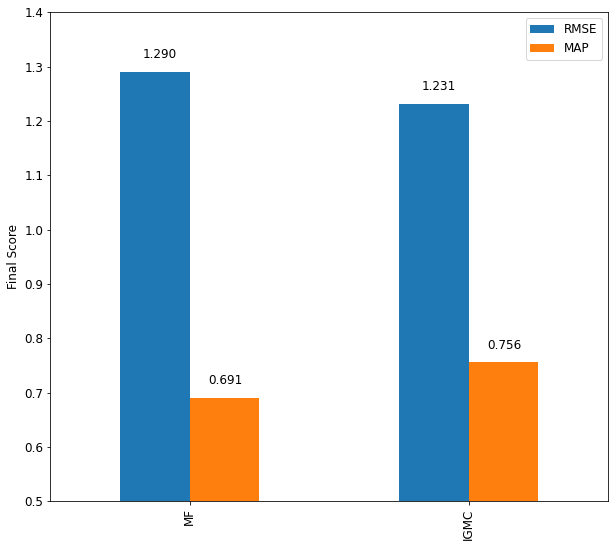

In [45]:
fig,ax = plt.subplots(figsize =(10, 9))
ax.set_ylim([0.5,1.4])
results.plot.bar(ax=ax)
plt.ylabel("Final Score")

plt.text(-0.167,1.290+0.025,'1.290')
plt.text(0.067,0.691+0.025,'0.691')
plt.text(1-0.167,1.231+0.025,'1.231')
plt.text(1+0.067,0.756+0.025,'0.756')

plt.rcParams.update({'font.size': 12}) 
